# Проект “Авторынок Казахстана 2019”
### Описание данных
Датасет с данными по продажам автомобилей в Казахстане за 2019 год. Данные получены из официальной статистики VAG, после перевода из эксель в csv обнаружились множественные проблемы с исходными данными: некорректные разделители десятичных разрядов, несоответствие данных типу данных. Дополнительной проблемой является то, что статистику собирал не один человек, поэтому есть неявные дубликаты - например, 4WD, 4 WD и 4-WD, а также одни и те же признаки могут быть записаны как на русском, так и на английском языке. Также необходимо очистить датасет от лишних столбцов, которые используют технические специалисты, но которые не нужны в управленческом учете.
### Способ сбора данных
Агрегация данных от марок
### Предобработка
Данные из xlsx конвертированы в csv

### Цели и задачи проекта
1. Загрузить данные
2. Очистить данные
- привести данные в столбцах к единообразию;
- избавиться или исправить некорректные значения данных;
- закодировать данные, где это целесообразно (например, страна- производитель)
3. Провести исследовательский анализ данных
- провести первичный анализ признаков в датасете
4. Провести анализ рынка
- описать ситуацию на рынке через базовые показатели
5. Подготовить выводы и рекомендации

In [1]:
#!pip install googletrans --quiet
!pip install googletrans==3.1.0a0 --quiet

In [230]:
# import
import pandas as pd
import numpy as np
from googletrans import Translator
from datetime import timedelta
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('dataset/kz_2019_final_all_dirt.csv')
df.head()

Unnamed: 0   Год Месяц     Компания Бренд Модель      Модификация  \
0           0  2019  Март  Mercur Auto  Audi     A3     Audi A3 TFSI   
1           1  2019   Май  Mercur Auto  Audi     A3             TFSI   
2           2  2019  Июнь  Mercur Auto  Audi     A3             TFSI   
3           3  2019  Июль  Mercur Auto  Audi     A3             TFSI   
4           4  2019  Июль  Mercur Auto  Audi     A4  A4 Allroad TFSI   

  Год выпуска Страна-производитель Вид топлива  ... Тип клиента Форма расчета  \
0        2017             Германия      Бензин  ...   Физ. Лицо   безналичный   
1        2018             Германия      Бензин  ...   Физ. Лицо      наличный   
2        2018             Германия      Бензин  ...   Физ. Лицо      наличный   
3        2017             Германия      Бензин  ...   Физ. Лицо      наличный   
4        2017             Германия      Бензин  ...    Юр. Лицо   безналичный   

  Количество     Цена, USD  Продажа, USD   Область      Сегментация 2013  \
0        1.0  31250.000000  31250.000000  г.Алматы  Легковые автомобили    
1        1.0  30581.000000  30581.000000  г.Алматы  Легковые автомобили    
2        1.0  35087.719000  35087.719000  г.Алматы  Легковые автомобили    
3        1.0  26608.232900  26608.232900  г.Алматы  Легковые автомобили    
4        1.0  48343.982648  48343.982648  г.Алматы  Легковые автомобили    

  Класс 2013  Сегментация Eng  Локализация производства  
0   C класс                 C                    Импорт  
1   C класс                 C                    Импорт  
2   C класс                 C                    Импорт  
3   C класс                 C                    Импорт  
4   D класс                 D                    Импорт  

[5 rows x 26 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32854 entries, 0 to 32853
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      32854 non-null  int64  
 1   Год                             32854 non-null  int64  
 2   Месяц                           32854 non-null  object 
 3   Компания                        32854 non-null  object 
 4   Бренд                           32854 non-null  object 
 5   Модель                          32854 non-null  object 
 6   Модификация                     29729 non-null  object 
 7   Год выпуска                     32700 non-null  object 
 8   Страна-производитель            32854 non-null  object 
 9   Вид топлива                     31942 non-null  object 
 10  Объём двиг, л,                  30968 non-null  object 
 11  Коробка передач                 31662 non-null  object 
 12  Тип привода                     

## Очистить данные

In [5]:
df.duplicated().sum()

0

В начале исправим и привидем к единому стилю названия столбцов

In [6]:
new_col = dict()
translator = Translator()

for i in df.columns:
    new_col[i] = translator.translate(i, src='ru', dest='en').text.replace(' ', '_').lower()
for i in new_col:
    if i == 'Область':
        new_col['Область'] = 'city'
        break
df.columns = [new_col[i] for i in new_col]
df.columns

Index(['0', 'year', 'month', 'company', 'brand', 'model', 'modification',
       'year_of_issue', 'manufacturer_country', 'type_of_fuel',
       'engine_volume,_l,', 'transmission', 'type_of_drive', 'segment',
       'region', 'dealership_name', 'client_type', 'calculation_form',
       'quantity', 'price,_usd', 'sale,_usd', 'city', 'segmentation_2013',
       'class_of_2013', 'segmentation_eng', 'production_localization'],
      dtype='object')

Посчитаем пропуски и выведем столбцы, в которых они есть

In [7]:
for i in df.columns:
    k = df[i].isnull().sum()
    if k > 0:
        print(f'{i}: {round(k/len(df), 2)} (доля)')

modification: 0.1 (доля)
year_of_issue: 0.0 (доля)
type_of_fuel: 0.03 (доля)
engine_volume,_l,: 0.06 (доля)
transmission: 0.04 (доля)
type_of_drive: 0.07 (доля)
segment: 0.15 (доля)
client_type: 0.17 (доля)
calculation_form: 0.78 (доля)
quantity: 0.0 (доля)


In [8]:
#список для подсчета потерь в данных после очистки
rez = []

В столбцах Год и Месяц, указана дата продажи. Есть смысл объединить данные из данных столбцов в новый столбец в формате даты, для удобства в дальнейшем анализе.

In [9]:
df['year'].unique()

array([2019])

In [10]:
df['month'].unique()

array(['Март', 'Май', 'Июнь', 'Июль', 'Январь', 'Февраль', 'Апрель',
       'Август', 'Сентябрь'], dtype=object)

In [11]:
def months(col):
    month = {
        'Январь': 1,
        'Февраль': 2,
        'Март': 3,
        'Апрель': 4,
        'Май': 5,
        'Июнь': 6,
        'Июль': 7,
        'Август': 8,
        'Сентябрь': 9,
        'Октябрь': 10,
        'Ноябрь': 11,
        'Декабрь': 12
    }
    
    if col['month'] in month:
        return datetime.strptime(f"{col['year']}-0{month[col['month']]}-01", '%Y-%m-%d')
    else:
        return datetime.strptime('0000-00-00', '%Y-%m-%d')
    
df['date'] = df.apply(months, axis=1)
df[['date', 'year', 'month']].head()

date  year month
0 2019-03-01  2019  Март
1 2019-05-01  2019   Май
2 2019-06-01  2019  Июнь
3 2019-07-01  2019  Июль
4 2019-07-01  2019  Июль

In [12]:
df[df['date'] == '0000-00-00']

Empty DataFrame
Columns: [0, year, month, company, brand, model, modification, year_of_issue, manufacturer_country, type_of_fuel, engine_volume,_l,, transmission, type_of_drive, segment, region, dealership_name, client_type, calculation_form, quantity, price,_usd, sale,_usd, city, segmentation_2013, class_of_2013, segmentation_eng, production_localization, date]
Index: []

[0 rows x 27 columns]

In [13]:
df.columns

Index(['0', 'year', 'month', 'company', 'brand', 'model', 'modification',
       'year_of_issue', 'manufacturer_country', 'type_of_fuel',
       'engine_volume,_l,', 'transmission', 'type_of_drive', 'segment',
       'region', 'dealership_name', 'client_type', 'calculation_form',
       'quantity', 'price,_usd', 'sale,_usd', 'city', 'segmentation_2013',
       'class_of_2013', 'segmentation_eng', 'production_localization', 'date'],
      dtype='object')

Далее рассмотрим данные в столбцах company,	brand,	model,	modification

In [14]:
df['company'].unique()

array(['Mercur Auto', 'Автоцентр-Бавария', 'БИПЭК АВТО', 'Вираж',
       'Sivi Finance Consulting', 'Eurasia Motor Premium',
       'Daewoo Bus Kazakhstan', 'Caspian Motors', 'Каспиан Моторс',
       'СемАЗ', 'ТК Рос-Авто', 'Astana Motors',
       'Hyundai Com Trans Kazakhstan ', 'Nissan Manufacturing RUS', 'СВС',
       'СВС-ТРАНС', 'Allur Auto', 'Jaguar Land Rover', 'ТК КАМАЗ',
       'Toyota Motor Kazakhstan', 'Лифан Моторс Рус',
       'MAN Truck & Bus Kazakhstan', 'Автомир ГК', 'Autokapital',
       'MMC RUS', 'ММС Рус', 'УзАвто-Казахстан', 'Алматы АТО',
       'Renault Россия', 'Scania Central Asia', 'Subaru Kazakhstan',
       'SMC', 'Scandinavian Motors', 'Хино Моторс Казахстан',
       'Hino Motors Kazakhstan'], dtype=object)

In [15]:
df[(df['company'] == 'Хино Моторс Казахстан')].head(2)

0  year   month                company brand model  \
32800  32800  2019  Январь  Хино Моторс Казахстан  Hino   300   
32801  32801  2019  Январь  Хино Моторс Казахстан  Hino   300   

          modification year_of_issue manufacturer_country type_of_fuel  ...  \
32800  XZU720L-HKFRPW3          2017               Япония       Дизель  ...   
32801  XZU710L-HKFRPW3          2017               Япония       Дизель  ...   

      calculation_form quantity    price,_usd      sale,_usd      city  \
32800      безналичный     10.0  40043.859909  400438.599086  г.Алматы   
32801      безналичный      1.0  40043.859909   40043.859909  г.Алматы   

              segmentation_2013             class_of_2013 segmentation_eng  \
32800  Коммерческие автомобили   Малотоннажные грузовики                 N   
32801  Коммерческие автомобили   Малотоннажные грузовики                 N   

       production_localization       date  
32800                   Импорт 2019-01-01  
32801                   Импорт 2019-01-01  

[2 rows x 27 columns]

In [16]:
df[(df['company'] == 'Hino Motors Kazakhstan')]

0  year   month                 company brand model  \
32828  32828  2019    Июль  Hino Motors Kazakhstan  Hino   300   
32830  32830  2019  Август  Hino Motors Kazakhstan  Hino   300   

          modification year_of_issue manufacturer_country type_of_fuel  ...  \
32828  XZU650L-HKMMSW3          2018               Япония       Дизель  ...   
32830  XZU650L-HKMMSW3          2018               Япония       Дизель  ...   

      calculation_form quantity    price,_usd     sale,_usd  \
32828      безналичный      1.0  34745.762712  34745.762712   
32830      Безналичная      1.0  34745.762712  34745.762712   

                       city         segmentation_2013  \
32828  Костанайская область  Коммерческие автомобили    
32830  Костанайская область  Коммерческие автомобили    

                  class_of_2013 segmentation_eng  production_localization  \
32828  Малотоннажные грузовики                 N                   Импорт   
32830  Малотоннажные грузовики                 N                   Импорт   

            date  
32828 2019-07-01  
32830 2019-08-01  

[2 rows x 27 columns]

In [17]:
df[df['company'] == 'Хино Моторс Казахстан']['region'].unique()

array(['Алматы'], dtype=object)

In [18]:
df[(df['company'] == 'Hino Motors Kazakhstan')]['region'].unique()

array(['Костанай'], dtype=object)

In [19]:
df[df['company'] == 'Хино Моторс Казахстан']['city'].unique()

array(['г.Алматы'], dtype=object)

In [20]:
df[(df['company'] == 'Hino Motors Kazakhstan')]['city'].unique()

array(['Костанайская область'], dtype=object)

Как видно из данных названия компаний: 'Хино Моторс Казахстан', 'Hino Motors Kazakhstan' различаются только в написании, но при детальном рассмотрении видно, что представительства размещаются в двух разных местах.

In [21]:
df['brand'].unique()

array(['Audi', 'BMW', 'Chevrolet', 'Daewoo', 'Ford', 'Foton', 'GAZ',
       'Hyundai', 'Hyundai Truck & Bus', 'Infiniti', 'Isuzu', 'Iveco',
       'Jac', 'Jaguar', 'KAMAZ', 'Kia', 'Lada', 'Land Rover', 'Lexus',
       'Lifan', 'MAN', 'Mazda', 'Mercedes-Benz', 'Mercedes-Benz Trucks',
       'Mini', 'Mitsubishi', 'Nissan', 'Peugeot', 'Porsche', 'Ravon',
       'Renault', 'Scania', 'Shacman', 'Skoda', 'SsangYong', 'Subaru',
       'Suzuki', 'Toyota', 'UAZ', 'Volkswagen', 'Volvo', 'Урал', 'МАЗ',
       'Cadillac', 'ANKAI', 'Hino', 'Rolls Royce'], dtype=object)

'Hyundai' и 'Hyundai Truck & Bus' или 'Mercedes-Benz' и 'Mercedes-Benz Trucks', есть смысл оставить так т.к. это подразделения специлизирующиеся с коммерческим автотранспортом. Приведем названия к строчным буквам.

In [22]:
df['brand'] = df['brand'].str.lower().str.strip()

In [23]:
df['model'].unique()

array(['A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q5', 'Q7', '1 серия',
       '2 серия', '3 серия', '4 серия', '5 серия', '6 серия', '7 серия',
       'i3', 'X1', 'X3', 'X4', 'X5', 'X6', 'Aveo', 'Captiva', 'Niva',
       'Tahoe', 'Tracker', 'BS 106 A', 'EcoSport', 'Explorer', 'Fiesta',
       'Focus', 'Kuga', 'Mondeo', 'Transit', 'Transit Custom',
       'BJ1032V3JB3-S', 'BJ3143DKPGA-1', 'BJ3253DMPKB-AD',
       'BJ5032V3BB3-S', 'BJ5163VKCHN-1', '2217', '2310', '2705', '2752',
       '3221', '3302', '3308', '3309', 'Next', 'Accent', 'Creta',
       'Elantra', 'Genesis G90', 'Grandeur', 'Santa Fe', 'Sonata',
       'TQ-1/H-1', 'County', 'H350', 'HD 160', 'HD 170', 'HD 260',
       'HD 65', 'HD 72', 'HD 78', 'Universe', 'Tucson', 'Q30', 'Q50',
       'QX30', 'QX50', 'QX60', 'QX70', 'QX80', 'D-MAX', 'FVR34', 'NMR',
       'NPR', 'NQR71', 'Daily', 'Daily A', 'Daily V', 'Stralis', 'Tipper',
       'S3', 'S5', 'F-Pace', 'XE', 'XF', '4308', '43114', '43118',
       '43253', '43502', '44108', '4514

В данном столбце оставим пока всё так. Приведем только строчному регистру и уберем лишнии пробелы.

In [24]:
df['model'] = df['model'].str.lower().str.strip()

In [25]:
df['modification'].unique()

array(['Audi A3 TFSI', 'TFSI', 'A4 Allroad TFSI', ..., 'АКН-10ОД ',
       'HINO 470400', 'HINO 47040A'], dtype=object)

Как минимум видно, что в данный столбец попали бренды и модели автомобилей. Поправим данную неточность, для этого напишем функцию, где уберем все встречающиеся в модификации бренды и модели. Так же почистим лишнии от лишних отступов и приведем все модификации строчным буквам.

In [26]:
list_brend = df['brand'].tolist()
list_model = df['model'].tolist()
del_brand = []
del_model = []
def anti_brend(name_mod):
    name_mod = str(name_mod)
    name_mod = name_mod.strip().lower()
    for i in list_brend:
        if i in name_mod:
            del_brand.append(i)
            name_mod = name_mod.replace(i, '')
    for i in list_model:
        if i in name_mod:
            del_model.append(i)
            name_mod = name_mod.replace(i, '')
    return name_mod.strip()

df['modification'] = df['modification'].apply(anti_brend)
df['modification'].unique()

array(['tfsi', 'allroad tfsi', 'l tfsi', ..., 'од', '470400', '47040a'],
      dtype=object)

In [27]:
print(f'Внесено изменений: бренд - {len(del_brand)/len(df)} модель - {len(del_model)/len(df)}')

Внесено изменений: бренд - 0.41867048152431974 модель - 0.7036281731296037


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32854 entries, 0 to 32853
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   0                        32854 non-null  int64         
 1   year                     32854 non-null  int64         
 2   month                    32854 non-null  object        
 3   company                  32854 non-null  object        
 4   brand                    32854 non-null  object        
 5   model                    32854 non-null  object        
 6   modification             32854 non-null  object        
 7   year_of_issue            32700 non-null  object        
 8   manufacturer_country     32854 non-null  object        
 9   type_of_fuel             31942 non-null  object        
 10  engine_volume,_l,        30968 non-null  object        
 11  transmission             31662 non-null  object        
 12  type_of_drive            30589 n

Используя мн-ва просмотрим уникальные значения брендов и модификаций, которые были изменены.

In [29]:
set(del_brand)

{'ankai',
 'audi',
 'bmw',
 'cadillac',
 'chevrolet',
 'daewoo',
 'ford',
 'foton',
 'gaz',
 'hino',
 'hyundai',
 'infiniti',
 'isuzu',
 'iveco',
 'jac',
 'jaguar',
 'kamaz',
 'kia',
 'lada',
 'land rover',
 'lexus',
 'lifan',
 'man',
 'mazda',
 'mercedes-benz',
 'mini',
 'mitsubishi',
 'nissan',
 'peugeot',
 'porsche',
 'ravon',
 'scania',
 'skoda',
 'ssangyong',
 'subaru',
 'toyota',
 'uaz',
 'volkswagen',
 'маз',
 'урал'}

In [30]:
set(del_model)

{'2 серия',
 '2217',
 '2310',
 '2705',
 '2752',
 '3',
 '3 серия',
 '3221',
 '3302',
 '3308',
 '3309',
 '4 серия',
 '4308',
 '43114',
 '43118',
 '43253',
 '43502',
 '44108',
 '45142',
 '45143',
 '5 серия',
 '500',
 '508',
 '53215',
 '5350',
 '53605',
 '5490',
 '5557',
 '5814',
 '6',
 '6 серия',
 '6460',
 '65111',
 '65115',
 '65116',
 '65117',
 '6520',
 '66052',
 '66062',
 '66065',
 '7 серия',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a8',
 'accent',
 'actros',
 'almera',
 'amarok',
 'asx',
 'aveo',
 'bj1032v3jb3-s',
 'bj3143dkpga-1',
 'bj3253dmpkb-ad',
 'bj5032v3bb3-s',
 'bj5163vkchn-1',
 'bs 106 a',
 'camry',
 'captiva',
 'cayenne',
 'cerato',
 'cooper',
 'corolla',
 'county',
 'creta',
 'cx-5',
 'cx-9',
 'd-max',
 'daily',
 'discovery',
 'dokker',
 'e-class',
 'e-pace',
 'eclipse cross',
 'ecosport',
 'elantra',
 'es',
 'explorer',
 'f-pace',
 'fiesta',
 'focus',
 'forward 18',
 'fvr34',
 'genesis g90',
 'gentra',
 'grandeur',
 'granta',
 'h350',
 'hd 78',
 'hiace',
 'highlander',
 'hilux 

In [31]:
df['year_of_issue'].unique()

array(['2017', '2018', '2016', '2011', '2015', nan, '2014', '2013',
       '2012', '2\xa0018', '2\xa0017', '2\xa0016', 2018, 2017, 2015, 2016],
      dtype=object)

In [32]:
df.query("year_of_issue in ['2\xa0018', '2\xa0017', '2\xa0016']")

0  year month                  company   brand model modification  \
14216  14216  2019  Июнь  Toyota Motor Kazakhstan   lexus    es           sb   
14217  14217  2019  Июнь  Toyota Motor Kazakhstan   lexus    es           s1   
14218  14218  2019  Июнь  Toyota Motor Kazakhstan   lexus    es           sb   
14219  14219  2019  Июнь  Toyota Motor Kazakhstan   lexus    es           rf   
14220  14220  2019  Июнь  Toyota Motor Kazakhstan   lexus    es           s1   
...      ...   ...   ...                      ...     ...   ...          ...   
32643  32643  2019  Июнь  Toyota Motor Kazakhstan  toyota  c-hr           xc   
32644  32644  2019  Июнь  Toyota Motor Kazakhstan  toyota  c-hr           xc   
32721  32721  2019  Июнь  Toyota Motor Kazakhstan  toyota  c-hr           xc   
32722  32722  2019  Июнь  Toyota Motor Kazakhstan  toyota  c-hr           xc   
32723  32723  2019  Июнь  Toyota Motor Kazakhstan  toyota  c-hr                

      year_of_issue manufacturer_country type_of_fuel  ... calculation_form  \
14216         2 018               Япония       Бензин  ...              NaN   
14217         2 018               Япония       Бензин  ...              NaN   
14218         2 018               Япония       Бензин  ...              NaN   
14219         2 018               Япония       Бензин  ...              NaN   
14220         2 018               Япония       Бензин  ...              NaN   
...             ...                  ...          ...  ...              ...   
32643         2 018               Турция       Бензин  ...              NaN   
32644         2 018               Турция       Бензин  ...              NaN   
32721         2 018               Турция       Бензин  ...              NaN   
32722         2 018               Турция       Бензин  ...              NaN   
32723         2 018               Турция       Бензин  ...              NaN   

      quantity    price,_usd     sale,_usd                  city  \
14216      1.0  41666.666667  41666.666667              г.Астана   
14217      1.0  23571.428571  23571.428571              г.Астана   
14218      1.0  41666.666667  41666.666667              г.Астана   
14219      1.0  47916.666667  47916.666667              г.Алматы   
14220      1.0  23571.428571  23571.428571    Атырауская область   
...        ...           ...           ...                   ...   
32643      1.0  32351.190476  32351.190476  Павлодарская область   
32644      1.0  32351.190476  32351.190476              г.Алматы   
32721      1.0  32351.190476  32351.190476       Экспорт область   
32722      1.0  32351.190476  32351.190476       Экспорт область   
32723      1.0  30386.904762  30386.904762       Экспорт область   

          segmentation_2013         class_of_2013 segmentation_eng  \
14216  Легковые автомобили               E класс                 E   
14217  Легковые автомобили               E класс                 E   
14218  Легковые автомобили               E класс                 E   
14219  Легковые автомобили               E класс                 E   
14220  Легковые автомобили               E класс                 E   
...                     ...                   ...              ...   
32643         Внедорожники   Среднеразмерные SUV                K1   
32644         Внедорожники   Среднеразмерные SUV                K1   
32721         Внедорожники   Среднеразмерные SUV                K1   
32722         Внедорожники   Среднеразмерные SUV                K1   
32723         Внедорожники   Среднеразмерные SUV                K1   

       production_localization       date  
14216                   Импорт 2019-06-01  
14217                   Импорт 2019-06-01  
14218                   Импорт 2019-06-01  
14219                   Импорт 2019-06-01  
14220                   Импорт 2019-06-01  
...                        ...        ...  
32643                   Импорт 2019-06-01  
32644                   Импорт 2019-06-01  
32721                   Импорт 2019-06-01  
327

In [33]:
df['year_of_issue'].isnull().sum() / len(df['year_of_issue'])

0.004687404882206124

Удалим табуляцию из строчек

In [34]:
df['year_of_issue'] = df['year_of_issue'].str.replace('\xa0', '')

Строчки с пропусками можно удалить, так как их прцент ничтожно мал) Стоит отметить, что точный год востановить проблемно так как модели автомобилей не меняются каждый год, а некоторые и 10-я

In [35]:
df = df[~df['year_of_issue'].isnull()]

In [36]:
df['year_of_issue'].isnull().sum() / len(df['year_of_issue'])

0.0

In [37]:
df['year_of_issue'].unique()

array(['2017', '2018', '2016', '2011', '2015', '2014', '2013', '2012'],
      dtype=object)

In [38]:
df['manufacturer_country'].unique()

array(['Германия', 'США', 'Республика Казахстан', 'Российская Федерация',
       'Белоруссия', 'Турция', 'Япония', 'Корея', 'Вьетнам', 'UK',
       'Таиланд', 'Узбекистан', 'Венгрия', 'Австрия', 'Нидерланды',
       'Швеция'], dtype=object)

In [39]:
countries_codes = pd.read_table('https://www.artlebedev.ru/country-list/tab/')

In [40]:
countries_codes

name                 fullname  \
0                                      Абхазия       Республика Абхазия   
1                                    Австралия                      NaN   
2                                      Австрия   Австрийская Республика   
3                                  Азербайджан   Республика Азербайджан   
4                                      Албания       Республика Албания   
..                                         ...                      ...   
246  Южная Джорджия и Южные Сандвичевы острова                      NaN   
247                               Южная Осетия  Республика Южная Осетия   
248                                Южный Судан                      NaN   
249                                     Ямайка                      NaN   
250                                     Япония                      NaN   

                                          english alpha2 alpha3  iso location  \
0                                        Abkhazia     AB    ABH  895     Азия   
1                                       Australia     AU    AUS   36  Океания   
2                                         Austria     AT    AUT   40   Европа   
3                                      Azerbaijan     AZ    AZE   31     Азия   
4                                         Albania     AL    ALB    8   Европа   
..                                            ...    ...    ...  ...      ...   
246  South Georgia and the South Sandwich Islands     GS    SGS  239      NaN   
247                                 South Ossetia     OS    OST  896     Азия   
248                                   South Sudan     SS    SSD  728   Африка   
249                                       Jamaica     JM    JAM  388  Америка   
250                                         Japan     JP    JPN  392     Азия   

               location-precise  
0                    Закавказье  
1    Австралия и Новая Зеландия  
2               Западная Европа  
3                 Западная Азия  
4                  Южная Европа  
..                          ...  
246                 Южный океан  
247                  Закавказье  
248             Северная Африка  
249           Карибский бассейн  
250              Восточная Азия  

[251 rows x 8 columns]

In [41]:
names_countries_codes = dict()

for i, g in zip(countries_codes['name'], countries_codes['alpha3']):
    names_countries_codes[i] = g
full_names_countries_codes = dict()

for i, g in zip(countries_codes['fullname'], countries_codes['alpha3']):
    full_names_countries_codes[i] = g
eng_names_countries_codes = dict()

for i, g in zip(countries_codes['english'], countries_codes['alpha3']):
    eng_names_countries_codes[i] = g

In [42]:
def coding_country(row):
    if row in names_countries_codes:
        return names_countries_codes[row]
    if row in full_names_countries_codes:
        return full_names_countries_codes[row]
    if row in eng_names_countries_codes:
        return eng_names_countries_codes[row]
    return row

In [43]:
df['code_manufacturer_country'] = df['manufacturer_country'].apply(coding_country)
df['code_manufacturer_country'].unique()

array(['DEU', 'США', 'KAZ', 'RUS', 'Белоруссия', 'TUR', 'JPN', 'Корея',
       'VNM', 'UK', 'THA', 'UZB', 'HUN', 'AUT', 'NLD', 'SWE'],
      dtype=object)

In [44]:
df['code_manufacturer_country'] = df['code_manufacturer_country'].str.replace('США', 'USA').str.replace('Корея', 'KOR').str.replace('Белоруссия', 'BLZ')
df['code_manufacturer_country'].unique()

array(['DEU', 'USA', 'KAZ', 'RUS', 'BLZ', 'TUR', 'JPN', 'KOR', 'VNM',
       'UK', 'THA', 'UZB', 'HUN', 'AUT', 'NLD', 'SWE'], dtype=object)

In [45]:
df['type_of_fuel'].unique()

array(['Бензин', 'Дизель', 'гибрид', 'Электрический', nan, '0', 'дизель ',
       'Газовый'], dtype=object)

In [46]:
rez.append(df['type_of_fuel'].isnull().sum() / len(df))
rez[-1]

0.026706322438216717

In [47]:
rez.append(len(df[df['type_of_fuel'] == '0']) / len(df))
rez[-1]

0.0001226467161341755

Данные составляют 3%, решено их удалить. Строки привести к строному стилю

In [48]:
df = df[~df['type_of_fuel'].isnull()]
df = df[~(df['type_of_fuel'] == '0')]

In [49]:
df['type_of_fuel'].isnull().sum() / len(df)

0.0

In [50]:
len(df[df['type_of_fuel'] == '0']) / len(df)

0.0

In [51]:
df['type_of_fuel'] = df['type_of_fuel'].str.lower()

In [52]:
df['engine_volume,_l,'].unique()

array(['1.4', '2', '3', '1.5', '4.4', '6.6', nan, '0', '1.8', '1.596',
       '1596', '2.4', '3000', '2400', '1.7', '6.2', '1800', '1400 turbo',
       '1,4 Turbo', '2.5', '1.6', '3.5', '2.2', '2.7', '2.8', '4.2', '5',
       '3.9', '7.5', '11', '3.933', '12.3', '1,6 T-GDI', '3.7', '5.6',
       '7.8', '2.9', '5.2', '10.3', '8.7', '1600', '1.998', '1.598',
       '1.248', '2.359', '2359', '1999', '3.8', '3800', '1.591', '1.368',
       '3.342', '3.47', '3470', '2000', '1.999', '1.69', '1690', '1.774',
       '1598', '1774', '4.9', '4.6', '3,5', '5.7', '10.5', '6.7', '4',
       '5.5', '12', '1.2', '3.6', '6.5', '4.5', '1.25', '1.3', '0.002',
       '0.0016', '1998', '13', '16', '1400', '2.3', '1.33', '2,4G',
       '2.693', '2693', '2.235', '2235', '2.0', '14860', '14.8', '17.5',
       '1,2T', '4.88'], dtype=object)

Уберем тысячи, запятые и текст

In [53]:
def engine_volume(row):
    numb = [str(i) for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]] + ['.']
    txt = ''
    for i in str(row):
        if i in numb:
            txt += i
        if i == ',':
            txt += '.'
    if txt:
        txt = float(txt)
        if txt >= 1000:
            txt = txt / 1000
        txt = str(round(txt, 1))
    return txt
df['engine_volume,_l,'] = df['engine_volume,_l,'].apply(engine_volume)
df['engine_volume,_l,'].unique()

array(['1.4', '2.0', '3.0', '1.5', '4.4', '6.6', '', '0.0', '1.8', '1.6',
       '2.4', '1.7', '6.2', '2.5', '3.5', '2.2', '2.7', '2.8', '4.2',
       '5.0', '3.9', '7.5', '11.0', '12.3', '3.7', '5.6', '7.8', '2.9',
       '5.2', '10.3', '8.7', '1.2', '3.8', '3.3', '4.9', '4.6', '5.7',
       '10.5', '6.7', '4.0', '5.5', '12.0', '3.6', '6.5', '4.5', '1.3',
       '13.0', '16.0', '2.3', '14.9', '14.8', '17.5'], dtype=object)

In [54]:
df[df['engine_volume,_l,'] == '14.9']

0  year    month        company brand   model modification  \
32296  32296  2019  Февраль  Astana Motors   маз  5516х5       евро 4   

      year_of_issue  manufacturer_country type_of_fuel  ... quantity  \
32296          2017  Республика Казахстан       дизель  ...      5.0   

         price,_usd      sale,_usd      city         segmentation_2013  \
32296  54914.285714  274571.428571  г.Алматы  Коммерческие автомобили    

                    class_of_2013 segmentation_eng production_localization  \
32296  Крупнотоннажные грузовики                 O  Локальное производство   

            date  code_manufacturer_country  
32296 2019-02-01                        KAZ  

[1 rows x 28 columns]

In [55]:
rez.append(len(df[df['engine_volume,_l,'] == '0.0']) / len(df))
rez[-1]

0.004001386307067015

In [56]:
rez.append(len(df[df['engine_volume,_l,'] == '']) / len(df))
rez[-1]

0.03188506254135291

Кол-во данных небольшое, уберем.

In [57]:
df = df[~(df['engine_volume,_l,'] == '0.0')]
df = df[~(df['engine_volume,_l,'] == '')]

In [58]:
len(df[df['engine_volume,_l,'] == '0.0']) / len(df)

0.0

In [59]:
len(df[df['engine_volume,_l,'] == '']) / len(df)

0.0

In [259]:
df['engine_volume,_l,'] = df['engine_volume,_l,'].astype('float')

In [60]:
df['transmission'].unique()

array(['S-tronic', 'S-Тronic', 'S-Тroic', 'S-troic', 'Steptronic',
       'ТipТronic', 'Tiptronic', 'SТepТronic', 'Автомат', 'AT', '6 АТ',
       '5 МТ', '6AT', '5MT', '6АТ', '5МТ', 'MT', 'МТ', 'MТ', '6АT', '6MT',
       'Powershift S6', 'PowershiftS6', 'PowershifТS6', '6МТ', '6MТ',
       'Мех.', 'МКПП', '6 AT', '6 MT', '8АТ', '5AT', '5АТ', '7DCT',
       '7 DCT', '7DCТ', 'АТ', nan, 'CVT', 'N', 'CVT(вариатор)', 'CVТ',
       '6 МТ', '4АТ', '8 АТ', '8AT', '4 АТ', 'AMT', '4AT', '9AT', 'АКПП8',
       'МКПП4', 'CVT (вариатор)', 'CVT(вариATор)', 'CVТ(вариатор)', '9АТ',
       '12AT', '7AT', '7АТ', '6М/Т', '6M/T', '6M/Т', '0', 'PDK', '8АКПП',
       '8-ступ АКПП', '8', 'АКПП', ' -', '-', '7 DSG', '7DSG', '6 DSG',
       '6DSG', 'CVТ(вАриАтор)', '5MТ', 'АТ (автомат)', '8 AT 4Motion',
       '8АТ4МoТion', '6A', '5M', '6-ступАКПП', '6А', 'AT (автомат)',
       '7DSG4МoТion', '6Aвтомат', '6Aатомат', '5М', '5-ступМТ', 'АT',
       'A/T', '7АT', 'МТ (механика)', 'АКПП4', 'Механическая'],
      d

Для начала приведем все к строчному виду и уберем лишние пробелы

In [61]:
df['transmission'] = df['transmission'].str.lower().str.strip().str.replace('т', 't')
df['transmission'].unique()

array(['s-tronic', 's-troic', 'steptronic', 'tiptronic', 'авtомаt', 'at',
       '6 аt', '5 мt', '6at', '5mt', '6аt', '5мt', 'mt', 'мt', '6mt',
       'powershift s6', 'powershifts6', '6мt', 'мех.', 'мкпп', '6 at',
       '6 mt', '8аt', '5at', '5аt', '7dct', '7 dct', 'аt', nan, 'cvt',
       'n', 'cvt(вариаtор)', '6 мt', '4аt', '8 аt', '8at', '4 аt', 'amt',
       '4at', '9at', 'акпп8', 'мкпп4', 'cvt (вариаtор)', 'cvt(вариatор)',
       '9аt', '12at', '7at', '7аt', '6м/t', '6m/t', '0', 'pdk', '8акпп',
       '8-сtуп акпп', '8', 'акпп', '-', '7 dsg', '7dsg', '6 dsg', '6dsg',
       'аt (авtомаt)', '8 at 4motion', '8аt4мotion', '6a', '5m',
       '6-сtупакпп', '6а', 'at (авtомаt)', '7dsg4мotion', '6aвtомаt',
       '6aаtомаt', '5м', '5-сtупмt', 'a/t', 'мt (механика)', 'акпп4',
       'механическая'], dtype=object)

Далее сделаем отдельный столбец и сохраним в него модификацию трансмисии разделенную по группам: механика, автомат, s-tronic, dsg, вариатор, tiptronic, powershift

In [62]:
legend = {
        'а': 'a',
        'б': 'b',
        'в': 'v',
        'г': 'g',
        'д': 'd',
        'е': 'e',
        'ё': 'yo',
        'ж': 'zh',
        'з': 'z',
        'и': 'i',
        'й': 'y',
        'к': 'k',
        'л': 'l',
        'м': 'm',
        'н': 'n',
        'о': 'o',
        'п': 'p',
        'р': 'r',
        'с': 's',
        'т': 't',
        'у': 'u',
        'ф': 'f',
        'х': 'h',
        'ц': 'ts',
        'ч': 'ch',
        'ш': 'sh',
        'щ': 'shch',
        'ъ': 'y',
        'ы': 'y',
        'ь': "'",
        'э': 'e',
        'ю': 'yu',
        'я': 'ya',
        'А': 'A',
        'Б': 'B',
        'В': 'V',
        'Г': 'G',
        'Д': 'D',
        'Е': 'E',
        'Ё': 'Yo',
        'Ж': 'Zh',
        'З': 'Z',
        'И': 'I',
        'Й': 'Y',
        'К': 'K',
        'Л': 'L',
        'М': 'M',
        'Н': 'N',
        'О': 'O',
        'П': 'P',
        'Р': 'R',
        'С': 'S',
        'Т': 'T',
        'У': 'U',
        'Ф': 'F',
        'Х': 'H',
        'Ц': 'Ts',
        'Ч': 'Ch',
        'Ш': 'Sh',
        'Щ': 'Shch',
        'Ъ': 'Y',
        'Ы': 'Y',
        'Ь': "'",
        'Э': 'E',
        'Ю': 'Yu',
        'Я': 'Ya',
    }

In [63]:
def transmition(row):
    row = str(row).lower()
    row = ''.join([legend[i] if i in legend else i for i in row])

    if ('mt' in row) or ('mkpp' in row) or ('meh' in row) or ('m/t' in row) or ((len(row) == 2) and ('m' in row)):
        return 'mt'
    if ('at' in row) or ('am' in row) or ('a/t' in row) or ('akp' in row) or ('av' in row) or ((len(row) == 2) and ('a' in row)):
        return 'at'
    if ('s-tronic' in row) or (('s' in row) and (('tronic' in row) or ('troic' in row))):
        return 's-tronic'
    if ('dsg' in row):
        return 'dsg'
    if ('dct' in row):
        return 'dct'
    if ('var' in row) or ('cvt' in row):
        return 'cvt'
    if ('t-tronic' in row) or (('tip' in row) and ('troic') in row):
        return 't-tronic'
    if ('powershift' in row):
        return 'powershift'
    #return row

In [64]:
df['transmition_group'] = df['transmission'].apply(transmition)
df['transmition_group'].unique()

array(['s-tronic', None, 'at', 'mt', 'powershift', 'dct', 'cvt', 'dsg'],
      dtype=object)

In [65]:
df['transmission'].isnull().sum() / len(df)

0.006143790849673203

In [66]:
rez.append(df['transmition_group'].isnull().sum() / len(df))
rez[-1]

0.009738562091503268

In [67]:
df = df[~(df['transmition_group'].isnull())]
df['transmition_group'].isnull().sum() / len(df)

0.0

In [68]:
df['type_of_drive'].unique()

array([nan, 'FWD', 'передний', 'quattro', 'Quattro', 'RWD', '4WD',
       'Полный', 'Задний', 'AWD', 'Передний', '4х2.2', 'Полный ',
       'задний', '2WD', '2 WD', '4 WD', '4х4', '4x2', 'FR', '4х2', '4x4',
       '2х4', 'CVT', '0', 'P/TIME', 'FF', 'полный', '4Motion',
       'передний '], dtype=object)

Разделим типы приводов на группы для удобства: RWD - задний привод, FWD - передний привод, 4WD - полный привод (постоянный и подключаемый), AWD - автоматически подключаемый полный привод, 2wd - не полный привод на 2 колеса(передний или задний)

In [69]:
df['type_of_drive'] = df['type_of_drive'].str.lower().str.strip()

In [70]:
def type_drive(row):
    row = str(row).lower().strip()
    row = ''.join([i for i in row if i != ' '])
    if row in ['rwd', 'fwd', '4wd', 'awd', '2wd']:
        return row
    if row in ['передний', 'FF', 'ff']:
        return 'fwd'
    if row in ['задний', 'FR', 'fr']:
        return 'rwd'
    if row in ['полный', 'quattro', '4Motion', 'CVT', '4motion', 'cvt']:
        return '4wd'
    if row in ['подключаемы', 'P/TIME', 'p/time', '2x4', '4x2', '2х4']:
        return 'awd'

In [71]:
df['type_of_drive_group'] = df['type_of_drive'].apply(type_drive)
df[['type_of_drive', 'type_of_drive_group']].head()

type_of_drive type_of_drive_group
0           NaN                None
1           fwd                 fwd
2           fwd                 fwd
3      передний                 fwd
4       quattro                 4wd

In [72]:
df['type_of_drive_group'].unique()

array([None, 'fwd', '4wd', 'rwd', 'awd', '2wd'], dtype=object)

In [73]:
df['type_of_drive_group'].isnull().sum() / len(df)

0.017226585703913933

In [74]:
df[df['type_of_drive_group'].isnull()].head(10)

0  year    month                company   brand     model  \
0      0  2019     Март            Mercur Auto    audi        a3   
959  959  2019  Февраль  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
960  960  2019   Апрель  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
961  961  2019      Май  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
962  962  2019      Май  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
963  963  2019     Июнь  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
964  964  2019     Июнь  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
965  965  2019     Июнь  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
966  966  2019     Июль  Daewoo Bus Kazakhstan  daewoo  bs 106 a   
967  967  2019     Июль  Daewoo Bus Kazakhstan  daewoo  bs 106 a   

            modification year_of_issue  manufacturer_country type_of_fuel  \
0                   tfsi          2017              Германия       бензин   
959  bus bs 10 а bs 10 а          2018  Республика Казахстан       дизель   
960                               2018  Республика Казахстан       дизель   
961                               2018  Республика Казахстан       дизель   
962                               2018  Республика Казахстан       дизель   
963                               2018  Республика Казахстан       дизель   
964                               2018  Республика Казахстан       дизель   
965                               2018  Республика Казахстан       дизель   
966                               2018  Республика Казахстан       дизель   
967                               2018  Республика Казахстан       дизель   

     ...     sale,_usd                            city  \
0    ...  3.125000e+04                        г.Алматы   
959  ...  9.229493e+05              Атырауская область   
960  ...  1.000838e+06              Атырауская область   
961  ...  1.005699e+05           Мангистауская область   
962  ...  1.980922e+06              Атырауская область   
963  ...  1.972441e+05          Кызылординская область   
964  ...  9.862205e+04          Кызылординская область   
965  ...  1.136634e+05                        г.Астана   
966  ...  1.925639e+05          Кызылординская область   
967  ...  9.628193e+04  Восточно-Казахстанская область   

            segmentation_2013      class_of_2013 segmentation_eng  \
0        Легковые автомобили            C класс                 C   
959  Коммерческие автомобили   Большие автобусы                 O   
960  Коммерческие автомобили   Большие автобусы                 O   
961  Коммерческие автомобили   Большие автобусы                 O   
962  Коммерческие автомобили   Большие автобусы                 O   
963  Коммерческие автомобили   Большие автобусы                 O   
964  Коммерческие автомобили   Большие автобусы                 O   
965  Коммерческие автомобили   Большие автобусы                 O   
966  Коммерческие автомобили   Большие автобусы                 O   
967  Коммерческие автомобили   Большие автобусы                 O   

    production_localization       date code_manufacturer_country  \
0                    Импорт 2019-03-01                       DEU   
959  Локальное производство 2019-02-01                       KAZ   
960  Локальное производство 2019-04-01                       KAZ   
961  Локальное производство 2019-05-01                       KAZ   
962  Локальное производство 2019-05-01                       KAZ   
963  Локальное производство 2019-06-01                       KAZ   
964  Локальное производство 2019-06-01                       KAZ   
965  Локальное производство 2019-06-01                       KAZ   
966  Локальное производство 2019-07-01                       KAZ   
967  Локальное производство 2019-07-01                       KAZ   

     transmition_group  type_of_drive_group  
0             s-tronic                 None  
959                 mt                 None  
960                 mt                 None  
961                 mt                 None  
962                 mt          

In [75]:
df[df['type_of_drive_group'].isnull()].groupby(['brand'])['brand'].agg('count').sort_values()

brand
audi                      1
маз                       2
man                       4
mercedes-benz trucks     14
daewoo                   15
land rover               20
isuzu                    23
mercedes-benz            53
renault                 139
volkswagen              251
Name: brand, dtype: int64

In [76]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'volkswagen')].head()

0  year   month      company       brand           model  \
31248  31248  2019    Март  Mercur Auto  volkswagen          amarok   
31257  31257  2019     Май  Mercur Auto  volkswagen  crafter kasten   
31259  31259  2019  Январь  Mercur Auto  volkswagen           jetta   
31260  31260  2019  Январь  Mercur Auto  volkswagen           jetta   
31261  31261  2019  Январь  Mercur Auto  volkswagen           jetta   

      modification year_of_issue  manufacturer_country type_of_fuel  ...  \
31248      comfort          2017              Германия       дизель  ...   
31257       kasten          2017              Германия       дизель  ...   
31259      highine          2017  Российская Федерация       бензин  ...   
31260      highine          2017  Российская Федерация       бензин  ...   
31261      highine          2017  Российская Федерация       бензин  ...   

          sale,_usd                        city         segmentation_2013  \
31248  51450.367244                    г.Алматы                   Пикапы    
31257  52083.329778                    г.Алматы  Коммерческие автомобили    
31259  23708.410492                    г.Алматы      Легковые автомобили    
31260  23353.823641  Южно-Казахстанская область      Легковые автомобили    
31261  46707.647283                    г.Алматы      Легковые автомобили    

        class_of_2013 segmentation_eng production_localization       date  \
31248        Pick-ups               K4                  Импорт 2019-03-01   
31257  Микроавтобусы                L2                  Импорт 2019-05-01   
31259        C класс                 C                  Импорт 2019-01-01   
31260        C класс                 C                  Импорт 2019-01-01   
31261        C класс                 C                  Импорт 2019-01-01   

      code_manufacturer_country  transmition_group  type_of_drive_group  
31248                       DEU                 at                 None  
31257                       DEU                 mt                 None  
31259                       RUS                 at                 None  
31260                       RUS                dsg                 None  
31261                       RUS                dsg                 None  

[5 rows x 30 columns]

In [77]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'volkswagen')].tail()

0  year month      company       brand               model  \
32019  32019  2019   Май  Mercur Auto  volkswagen  transporter kasten   
32020  32020  2019   Май  Mercur Auto  volkswagen  transporter kasten   
32021  32021  2019   Май  Mercur Auto  volkswagen  transporter kasten   
32022  32022  2019  Июнь  Mercur Auto  volkswagen  transporter kasten   
32023  32023  2019  Июнь  Mercur Auto  volkswagen  transporter kasten   

      modification year_of_issue manufacturer_country type_of_fuel  ...  \
32019       kasten          2018             Германия       бензин  ...   
32020       kasten          2018             Германия       бензин  ...   
32021       kasten          2018             Германия       бензин  ...   
32022       kasten          2018             Германия       бензин  ...   
32023  kasten long          2017             Германия       бензин  ...   

          sale,_usd      city         segmentation_2013   class_of_2013  \
32019  50083.808247  г.Алматы  Коммерческие автомобили   Микроавтобусы    
32020  40639.959772  г.Алматы  Коммерческие автомобили   Микроавтобусы    
32021  34132.813214  г.Алматы  Коммерческие автомобили   Микроавтобусы    
32022  37918.980600  г.Астана  Коммерческие автомобили   Микроавтобусы    
32023  35110.687931  г.Алматы  Коммерческие автомобили   Микроавтобусы    

      segmentation_eng production_localization       date  \
32019               L2                  Импорт 2019-05-01   
32020               L2                  Импорт 2019-05-01   
32021               L2                  Импорт 2019-05-01   
32022               L2                  Импорт 2019-06-01   
32023               L2                  Импорт 2019-06-01   

      code_manufacturer_country  transmition_group  type_of_drive_group  
32019                       DEU                dsg                 None  
32020                       DEU                dsg                 None  
32021                       DEU                 mt                 None  
32022                       DEU                 mt                 None  
32023                       DEU                 mt                 None  

[5 rows x 30 columns]

In [78]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'volkswagen')][['brand',
                                                                     'model',
                                                                     'modification',
                                                                     'year_of_issue',
                                                                     'type_of_drive',
                                                                     'type_of_drive_group']
                                                                    ].head()

brand           model modification year_of_issue type_of_drive  \
31248  volkswagen          amarok      comfort          2017           NaN   
31257  volkswagen  crafter kasten       kasten          2017           NaN   
31259  volkswagen           jetta      highine          2017           NaN   
31260  volkswagen           jetta      highine          2017           NaN   
31261  volkswagen           jetta      highine          2017           NaN   

      type_of_drive_group  
31248                None  
31257                None  
31259                None  
31260                None  
31261                None

In [79]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'volkswagen')].groupby('model')['model'].agg('count')

model
amarok                  1
crafter kasten          1
jetta                  21
passat b8               4
polo                  175
tiguan                 39
touareg                 1
transporter             2
transporter kasten      7
Name: model, dtype: int64

In [80]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'volkswagen') & (df['model'] == 'polo')][['brand',
                                                                     'model',
                                                                     'modification',
                                                                     'year_of_issue',
                                                                     'type_of_drive',
                                                                     'type_of_drive_group']
                                                                    ].head()

brand model modification year_of_issue type_of_drive  \
31373  volkswagen  polo         life          2017           NaN   
31384  volkswagen  polo  comfortline          2017           NaN   
31387  volkswagen  polo  comfortline          2017           NaN   
31389  volkswagen  polo  comfortline          2017           NaN   
31400  volkswagen  polo           fl          2017           NaN   

      type_of_drive_group  
31373                None  
31384                None  
31387                None  
31389                None  
31400                None

In [81]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'renault')][['brand',
                                                                     'model',
                                                                     'modification',
                                                                     'year_of_issue',
                                                                     'type_of_drive',
                                                                     'type_of_drive_group']
                                                                    ].head()

brand   model modification year_of_issue type_of_drive  \
18933  renault  duster     e2gb4aga          2017           NaN   
18934  renault  duster   e2 gb4 aga          2017           NaN   
18935  renault  duster   e2 gb4 aga          2017           NaN   
18936  renault  duster     e2gb4aga          2017           NaN   
18937  renault  duster    e2pgb4 ag          2018           NaN   

      type_of_drive_group  
18933                None  
18934                None  
18935                None  
18936                None  
18937                None

In [82]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'renault')]['type_of_drive'].unique()

array([nan, '0'], dtype=object)

In [83]:
df[(df['type_of_drive_group'].isnull()) & (df['brand'] == 'renault')]['modification'].unique()

array(['e2gb4aga', 'e2 gb4 aga', 'e2pgb4 ag', 'e1 fb4 aga', 'nan',
       'yb4aac', 'yb1 2 ja 5c', 'yb12jc', 'slb4ac', 'sxp 1pr b',
       'sut1prb'], dtype=object)

In [84]:
def type_drive_renault(row):
    row_ = str(row['modification']).lower().strip()
    row_ = ''.join([i for i in row_ if i != ' '])

    if row_ in ['e2gb4aga', 'e1fb4aga', 'e2pgb4ag', 'yb4aac', 'slb4ac']:
        return '4wd'
    if row_ in ['yb12ja5c', 'yb12jc', 'sxp1prb', 'sut1prb']:
        return 'fwd'
    return row['type_of_drive_group'] 


In [85]:
df['type_of_drive_group'] = df.apply(type_drive_renault, axis=1)

In [86]:
rez.append(df['type_of_drive_group'].isnull().sum() / len(df))
rez[-1]

0.015378522869777573

Оставшийся 1.5% с пропусками мы удалим из таблицы

In [87]:
df = df[~df['type_of_drive_group'].isnull()]

In [88]:
df['segment'].unique()

array(['Легковые автомобили Premium', 'Внедорожники Premium', nan,
       'Легковые автомобили', 'B класс ', 'Легковые автомобили ',
       'Среднеразмерные SUV ', 'Внедорожники ', 'premium SUV',
       'Субкомпактные SUV ', 'LCV', 'Коммерческие автомобили',
       'микроавтобус', 'МCV', 'Грузовые авто', 'B', 'B-SUV', 'C',
       'C класс', 'F-Premium', 'E', 'E класс', 'D-SUV', 'D', 'D класс',
       'MPV', 'городской', 'малотоннажные', 'Крупнотоннажные',
       'среднетоннажные', 'среднетоннажные 6500', 'среднетоннажные 7800',
       'турестический', 'туристический', 'C-SUV', 'Premium PC',
       'Магистральный тягач', 'Компактные SUV ', 'C класс ', 'D класс ',
       'A класс ', 'F класс', 'Стандартные SUV ', 'Pick-ups',
       'Коммерческие автомобили ', 'Развозные автомобили ', 'E-Premium',
       'Полноразмерные SUV Premium', 'Среднеразмерные SUV Premium',
       'Субкомпактные SUV', 'HCV', 'Compact SUV', 'Medium SUV',
       'Large SUV', 'E класс ', 'SUV cars', 'внедорожник',
   

In [89]:
df['segmentation_2013'].unique()

array(['Легковые автомобили ', 'Внедорожники ',
       'Коммерческие автомобили ', 'Минивэны', 'Пикапы '], dtype=object)

In [90]:
df['class_of_2013'].unique()

array(['C класс ', 'D класс ', 'Спортивные автомобили ', 'E класс ',
       'Среднеразмерные SUV ', 'F класс ', 'Компактные SUV ',
       'Стандартные SUV ', 'B класс ', 'Субкомпактные SUV ',
       'Микроавтобусы ', 'Малотоннажные грузовики ',
       'Развозные автомобили ', 'Среднетоннажные грузовики ',
       'Полноразмерный Минивэн ', 'Средние автобусы ',
       'Крупнотоннажные грузовики ', 'Большие автобусы ',
       'Полноразмерные SUV ', 'A класс ', 'Компактвэн', 'Pick-ups'],
      dtype=object)

Вывод: так как у нас есть другие столбцы с сегментами и классами автомобилей, удалим данный столбец.

In [91]:
df.drop(columns='segment', axis=1, inplace=True)

In [92]:
df['region'].unique()

array(['Алматы', 'Костанай', 'Атырау', 'Астана', 'Уральск',
       'Усть-Каменогорск', 'Петропавловск', 'Павлодар', 'Кокшетау',
       'Актау', 'Семей', 'Караганда', 'Актобе', 'Шымкент', 'Талдыкорган',
       'Кызылорда', 'Экибастуз', 'Рудный', 'Тараз', 'Аксай', 'Щучинск',
       'ЭКСПОРТ', 'Риддер'], dtype=object)

In [93]:
df[df['region'] == 'ЭКСПОРТ'].head()

0  year    month     company brand model        modification  \
10027  10027  2019  Февраль  Allur Auto   jac    s3       luxury 1.5 mt   
10028  10028  2019  Февраль  Allur Auto   jac    s3       luxury 1.5 mt   
10029  10029  2019     Июль  Allur Auto   jac    s3  intelligent 1. cvt   
10030  10030  2019     Июль  Allur Auto   jac    s3  intelligent 1. cvt   
10031  10031  2019     Июль  Allur Auto   jac    s3  intelligent 1. cvt   

      year_of_issue  manufacturer_country type_of_fuel  ...     sale,_usd  \
10027          2017  Республика Казахстан       бензин  ...  12579.621014   
10028          2017  Республика Казахстан       бензин  ...  12579.621014   
10029          2018  Республика Казахстан       бензин  ...  11474.273077   
10030          2018  Республика Казахстан       бензин  ...  11474.273077   
10031          2018  Республика Казахстан       бензин  ...  11474.273077   

                  city segmentation_2013    class_of_2013 segmentation_eng  \
10027  Экспорт область     Внедорожники   Компактные SUV                K1   
10028  Экспорт область     Внедорожники   Компактные SUV                K1   
10029  Экспорт область     Внедорожники   Компактные SUV                K1   
10030  Экспорт область     Внедорожники   Компактные SUV                K1   
10031  Экспорт область     Внедорожники   Компактные SUV                K1   

      production_localization       date  code_manufacturer_country  \
10027  Локальное производство 2019-02-01                        KAZ   
10028  Локальное производство 2019-02-01                        KAZ   
10029  Локальное производство 2019-07-01                        KAZ   
10030  Локальное производство 2019-07-01                        KAZ   
10031  Локальное производство 2019-07-01                        KAZ   

       transmition_group  type_of_drive_group  
10027                 mt                  2wd  
10028                 mt                  2wd  
10029                cvt                  2wd  
10030                cvt                  2wd  
10031                cvt                  2wd  

[5 rows x 29 columns]

Вариант с ЭКСПОРТ оставим, данный показатель может указывать о том что автомобили для экспорта.

In [94]:
df['dealership_name'].unique()

array(['Mercur Auto Алматы', 'Mercur Auto Астана', 'Автодом Костанай',
       'Mercur Auto Атырау', 'Автоцентр-Бавария Алматы',
       'Автоцентр-Бавария Астана', 'ЖАЙЫК HYUNDAI MOTORS',
       'Автоцентр Бавария Восток', 'Автокомплекс Тарлан',
       'БИПЭК АВТО Усть-Каменогорск', 'БИПЭК АВТО Петропавловск',
       'БИПЭК АВТО Павлодар', 'БИПЭК АВТО Кокшетау', 'БИПЭК АВТО Атырау',
       'БИПЭК АВТО Алматы', 'БИПЭК АВТО Актау', 'БИПЭК АВТО Астана',
       'БИПЭК АВТО Уральск', 'БИПЭК АВТО Семей', 'БИПЭК АВТО Караганда',
       'БИПЭК АВТО Актобе', 'БИПЭК АВТО Шымкент',
       'БИПЭК АВТО Талдыкорган', 'БИПЭК АВТО Кызылорда',
       'БИПЭК АВТО Костанай', 'БИПЭК АВТО Экибастуз', 'Вираж Астана',
       'Вираж Кокшетау', 'Вираж Караганда', 'Вираж Уральск',
       'Вираж Актобе', 'Вираж Павлодар', 'Вираж Алматы',
       'Вираж Усть-Каменогорск', 'Вираж Атырау', 'Вираж Рудный',
       'Вираж Костанай', 'Вираж Шымкент', 'Вираж Петропавловск',
       'Вираж Актау', 'Вираж Кызылорда', 'Вираж 

В данном столбце уберем лишь отступы и приведем все к нижнему регистру.

In [95]:
df['dealership_name'] = df['dealership_name'].str.lower().str.strip()

In [96]:
df.columns

Index(['0', 'year', 'month', 'company', 'brand', 'model', 'modification',
       'year_of_issue', 'manufacturer_country', 'type_of_fuel',
       'engine_volume,_l,', 'transmission', 'type_of_drive', 'region',
       'dealership_name', 'client_type', 'calculation_form', 'quantity',
       'price,_usd', 'sale,_usd', 'city', 'segmentation_2013', 'class_of_2013',
       'segmentation_eng', 'production_localization', 'date',
       'code_manufacturer_country', 'transmition_group',
       'type_of_drive_group'],
      dtype='object')

In [97]:
df['client_type'].unique()

array(['Физ. Лицо', 'Юр. Лицо', nan, ' '], dtype=object)

Вывод: оставим так же

In [98]:
df['calculation_form'].unique()

array(['наличный', 'безналичный', nan, 'Наличная', 'Безналичная',
       'кредит', 'лизинг', 'Безналичная ', 'Перечисление', 'Без оплаты',
       'рассрочка', 'trade-in', 'Предоплата', 'тендер', 'б/н',
       'кредит+обмен', 'обмен'], dtype=object)

In [99]:
df['calculation_form'] = df['calculation_form'].str.lower().str.strip().replace('б/н', 'безналичный')

In [100]:
df['calculation_form'].unique()

array(['наличный', 'безналичный', nan, 'наличная', 'безналичная',
       'кредит', 'лизинг', 'перечисление', 'без оплаты', 'рассрочка',
       'trade-in', 'предоплата', 'тендер', 'кредит+обмен', 'обмен'],
      dtype=object)

In [101]:
df['calculation_form'].isnull().sum()/len(df)

0.8077155114626625

In [102]:
df.drop(columns='calculation_form', axis=1, inplace=True)

In [103]:
df['quantity'].unique()

array([ 1.,  3.,  2.,  4.,  5.,  6.,  7.,  8., 11.,  9., 10., 12., 37.,
       40., 17., 15., 24., 26., 13., nan, 19., 20., 14., 25., 16., 22.,
       18., 30., 21., 31., 46., 23., 29., 41., 33., 56., 28., 35., 36.,
       39., 34., 27., 38., 32., 91.])

In [104]:
df['price,_usd'].isnull().sum()

0

In [105]:
df['price,_usd'].describe()

count     29836.000000
mean      28563.025918
std       20808.237670
min        4571.358913
25%       15161.285407
50%       22012.616044
75%       33106.760765
max      243827.222122
Name: price,_usd, dtype: float64

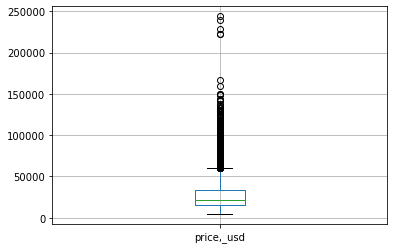

In [106]:
ax = df.boxplot(column=['price,_usd'])

Вывод: ситуация с выбросами в большую сторону нормальна, так как чем автомобиль дороже, тем их меньше продается

In [107]:
df['sale,_usd'].isnull().sum()

0

In [108]:
df['sale,_usd'].describe()

count    2.983600e+04
mean     3.330246e+04
std      3.447192e+04
min      0.000000e+00
25%      1.639979e+04
50%      2.478365e+04
75%      3.600000e+04
max      1.055600e+06
Name: sale,_usd, dtype: float64

In [109]:
df['city'].unique()

array(['г.Алматы', 'Костанайская область', 'Атырауская область',
       'г.Астана', 'Западно-Казахстанская область',
       'Восточно-Казахстанская область', 'Северо-Казахстанская область',
       'Павлодарская область', 'Акмолинская область',
       'Мангистауская область', 'Карагандинская область',
       'Актюбинская область', 'Южно-Казахстанская область',
       'Алматинская область', 'Кызылординская область',
       'Жамбылская область', 'Экспорт область'], dtype=object)

In [110]:
df['class_of_2013'].unique()

array(['C класс ', 'D класс ', 'Спортивные автомобили ', 'E класс ',
       'Среднеразмерные SUV ', 'F класс ', 'Компактные SUV ',
       'Стандартные SUV ', 'B класс ', 'Субкомпактные SUV ',
       'Микроавтобусы ', 'Малотоннажные грузовики ',
       'Развозные автомобили ', 'Среднетоннажные грузовики ',
       'Полноразмерный Минивэн ', 'Средние автобусы ',
       'Крупнотоннажные грузовики ', 'Большие автобусы ',
       'Полноразмерные SUV ', 'A класс ', 'Компактвэн', 'Pick-ups'],
      dtype=object)

In [111]:
df['class_of_2013'] = df['class_of_2013'].str.lower().str.strip()

In [112]:
df['production_localization'].unique()

array(['Импорт', 'Локальное производство'], dtype=object)

In [113]:
df['date'].isnull().sum()

0

In [114]:
df.drop(columns='segmentation_eng', axis=1, inplace=True)

In [115]:
print(f'Вывод: Итого убрано данных после отчистки (доля): {round(sum(rez), 2)}')

Вывод: Итого убрано данных после отчистки (доля): 0.09


### исследовательский анализ данных

Проверим еще раз на дубликаты

In [116]:
df.duplicated().sum()

0

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29836 entries, 1 to 32767
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   0                          29836 non-null  int64         
 1   year                       29836 non-null  int64         
 2   month                      29836 non-null  object        
 3   company                    29836 non-null  object        
 4   brand                      29836 non-null  object        
 5   model                      29836 non-null  object        
 6   modification               29836 non-null  object        
 7   year_of_issue              29836 non-null  object        
 8   manufacturer_country       29836 non-null  object        
 9   type_of_fuel               29836 non-null  object        
 10  engine_volume,_l,          29836 non-null  object        
 11  transmission               29836 non-null  object        
 12  type

In [118]:
df.head(2)

0  year month      company brand model modification year_of_issue  \
1  1  2019   Май  Mercur Auto  audi    a3         tfsi          2018   
2  2  2019  Июнь  Mercur Auto  audi    a3         tfsi          2018   

  manufacturer_country type_of_fuel  ... price,_usd  sale,_usd      city  \
1             Германия       бензин  ...  30581.000  30581.000  г.Алматы   
2             Германия       бензин  ...  35087.719  35087.719  г.Алматы   

      segmentation_2013 class_of_2013 production_localization       date  \
1  Легковые автомобили        c класс                  Импорт 2019-05-01   
2  Легковые автомобили        c класс                  Импорт 2019-06-01   

   code_manufacturer_country  transmition_group type_of_drive_group  
1                        DEU           s-tronic                 fwd  
2                        DEU           s-tronic                 fwd  

[2 rows x 27 columns]

In [119]:
df[df['engine_volume,_l,'].isin(['6.6', '11.0', '12.3', '10.3', '8.7', '12.0', '14.9', '14.8', '6.7'])]

0  year     month            company                 brand  \
164      164  2019      Июль  Автоцентр-Бавария                   bmw   
168      168  2019    Август  Автоцентр-Бавария                   bmw   
7111    7111  2019    Январь      Astana Motors   hyundai truck & bus   
7112    7112  2019    Январь      Astana Motors   hyundai truck & bus   
7113    7113  2019      Март      Astana Motors   hyundai truck & bus   
...      ...   ...       ...                ...                   ...   
9433    9433  2019  Сентябрь         Allur Auto                 iveco   
15752  15752  2019       Май        Autokapital  mercedes-benz trucks   
32296  32296  2019   Февраль      Astana Motors                   маз   
32297  32297  2019      Июнь      Astana Motors                   маз   
32612  32612  2019      Июнь         Allur Auto                   jac   

         model         modification year_of_issue  manufacturer_country  \
164    7 серия          70li xdrive          2017              Германия   
168    7 серия         m70li xdrive          2017              Германия   
7111    hd 260  промтоварный фургон          2013  Республика Казахстан   
7112    hd 260                 борт          2016  Республика Казахстан   
7113    hd 260     trucks hd20 борт          2016  Республика Казахстан   
...        ...                  ...           ...                   ...   
9433    tipper            мусоровоз          2016  Республика Казахстан   
15752   actros              182 l 4          2017              Германия   
32296   5516х5               евро 4          2017  Республика Казахстан   
32297   5516х5                  551          2017  Республика Казахстан   
32612    n944s              v шасси          2016  Республика Казахстан   

      type_of_fuel  ...     price,_usd      sale,_usd      city  \
164         бензин  ...  143849.620960  143849.620960  г.Астана   
168         бензин  ...  142168.609384  142168.609384  г.Алматы   
7111        дизель  ...   53233.128834   53233.128834  г.Астана   
7112        дизель  ...   50171.779141   50171.779141  г.Алматы   
7113        дизель  ...   51138.546836   51138.546836  г.Алматы   
...            ...  ...            ...            ...       ...   
9433        дизель  ...   80158.353646   80158.353646  г.Астана   
15752       дизель  ...  104785.217706  104785.217706  г.Астана   
32296       дизель  ...   54914.285714  274571.428571  г.Алматы   
32297       дизель  ...   52286.870473   52286.870473  г.Алматы   
32612       дизель  ...   23506.308022   23506.308022  г.Алматы   

              segmentation_2013              class_of_2013  \
164        Легковые автомобили                     f класс   
168        Легковые автомобили                     f класс   
7111   Коммерческие автомобили   крупнотоннажные грузовики   
7112   Коммерческие автомобили   крупнотоннажные грузовики   
7113   Коммерческие автомобили   крупнотоннажные грузовики   
...                         ...                        ...   
9433   Коммерческие автомобили     малотоннажные грузовики   
15752  Коммерческие автомобили   крупнотоннажные грузовики   
32296  Коммерческие автомобили   крупнотоннажные грузовики   
32297  Коммерческие автомобили   крупнотоннажные грузовики   
32612  Коммерческие автомобили     малотоннажные грузовики   

      production_localization       date  code_manufacturer_country  \
164                    Импорт 2019-07-01                        DEU   
168                    Импорт 2019-08-01                        DEU   
7111   Локальное производство 2019-01-01                        KAZ   
7112   Локальное производство 2019-01-01                        KAZ   
7113   Локальное производство 2019-03-01                        KAZ   
...                       ...        ...                        ...   
9433   Локальное производство 2019-09-01                        KAZ   
15752                  Импорт 2019-05-01                        DEU   
32296  Локальное производство 2019-02-01    

In [120]:
df[df['engine_volume,_l,'].isin(['6.6', '11.0', '12.3', '10.3', '8.7', '12.0', '14.9', '14.8', '6.7'])]['brand'].unique()

array(['bmw', 'hyundai truck & bus', 'iveco', 'mercedes-benz trucks',
       'маз', 'jac'], dtype=object)

In [121]:
df[df['engine_volume,_l,'].isin(['6.6', '11.0', '12.3', '10.3', '8.7', '12.0', '14.9', '14.8', '6.7'])]['model'].unique()

array(['7 серия', 'hd 260', 'universe', 'stralis', 'tipper', 'actros',
       '5516х5', 'n944s'], dtype=object)

In [122]:
df[df['engine_volume,_l,'].isin(['11.0', '12.3', '10.3', '12.0', '14.9', '14.8'])]['model'].unique()

array(['hd 260', 'universe', 'stralis', 'actros', '5516х5'], dtype=object)

Из данных видно, что объемы больше 10л, относятся все к грузовикам и спец транспорту, что вполне обосновано

<AxesSubplot:>

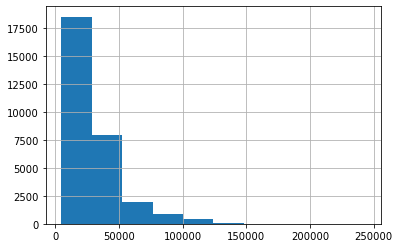

In [123]:
df['price,_usd'].hist()

из данных видно, что основная группа машин до 25т, и вторая до 50т.

<AxesSubplot:>

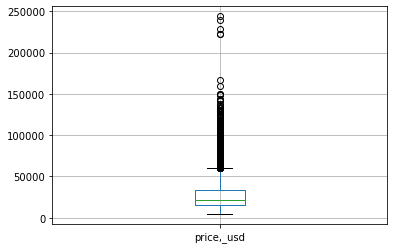

In [124]:
df.boxplot(column=['price,_usd'])

<AxesSubplot:>

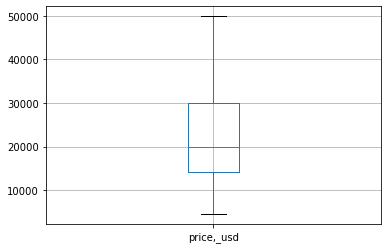

In [125]:
df[df['price,_usd'] <= 50000].boxplot(column=['price,_usd'])

In [126]:
df['price,_usd'].describe()

count     29836.000000
mean      28563.025918
std       20808.237670
min        4571.358913
25%       15161.285407
50%       22012.616044
75%       33106.760765
max      243827.222122
Name: price,_usd, dtype: float64

In [127]:
df[df['price,_usd'] > 243827]

0  year    month        company                brand     model  \
7145  7145  2019  Февраль  Astana Motors  hyundai truck & bus  universe   

                              modification year_of_issue manufacturer_country  \
7145  trucks  luxury туристический автобус          2017                Корея   

     type_of_fuel  ...     price,_usd      sale,_usd                city  \
7145       дизель  ...  243827.222122  243827.222122  Атырауская область   

             segmentation_2013     class_of_2013 production_localization  \
7145  Коммерческие автомобили   большие автобусы                  Импорт   

           date  code_manufacturer_country  transmition_group  \
7145 2019-02-01                        KOR                 mt   

     type_of_drive_group  
7145                 2wd  

[1 rows x 27 columns]

In [128]:
df[df['price,_usd'] < 4572]

0  year month     company brand model modification year_of_issue  \
32332  32332  2019   Май  Allur Auto   jac  x200          nan          2016   

       manufacturer_country type_of_fuel  ...   price,_usd    sale,_usd  \
32332  Республика Казахстан       дизель  ...  4571.358913  4571.358913   

           city         segmentation_2013            class_of_2013  \
32332  г.Алматы  Коммерческие автомобили   малотоннажные грузовики   

      production_localization       date  code_manufacturer_country  \
32332  Локальное производство 2019-05-01                        KAZ   

       transmition_group type_of_drive_group  
32332                 mt                 2wd  

[1 rows x 27 columns]

При более детальном рассмотрении видно, что оснавной ценовой диапазон в котором продаются авто от 15т до 33т. Минимальная цена 4,5т., максимальная 243т.

In [129]:
df[df['quantity'].isnull()]['sale,_usd']

11525    0.0
11665    0.0
11927    0.0
13062    0.0
Name: sale,_usd, dtype: float64

## Анализ рынка

### Анализ: Компания
- кол-во продаж по компаниям
- выручка по компаниям
- средняя/медиана стоимость автомобиля по компаниям
- какие сегменты представлены в компаниях
- автомобили каких стран/брендов представлены в автосалоне
- компании по регионам
- какие типы коробок передач представлены по автосалонам
- какие типы приводов представлены по компаниям

##### кол-во продаж по компаниям

<AxesSubplot:title={'center':'кол-во продаж по компаниям'}, xlabel='company'>

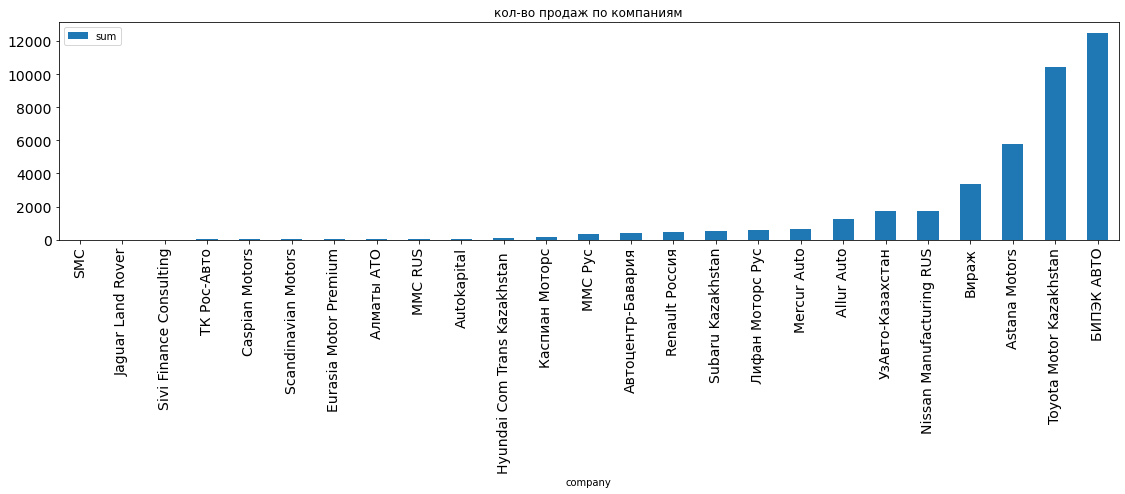

In [130]:
df.groupby(['company'])['quantity'].agg(['sum']).reset_index().sort_values(by='sum').plot(
        x='company',
        y="sum",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='кол-во продаж по компаниям'
)

Вывод: как видно из данных, лидерами по продажам являются компании: БИПЭК АВТО, Toyota Motor Kazakhstan, Astana Motors, Вираж.
Антилидерами - SMC, jaguar Land Rover

#### выручка по компаниям

<AxesSubplot:title={'center':'выручка по компаниям'}, xlabel='company'>

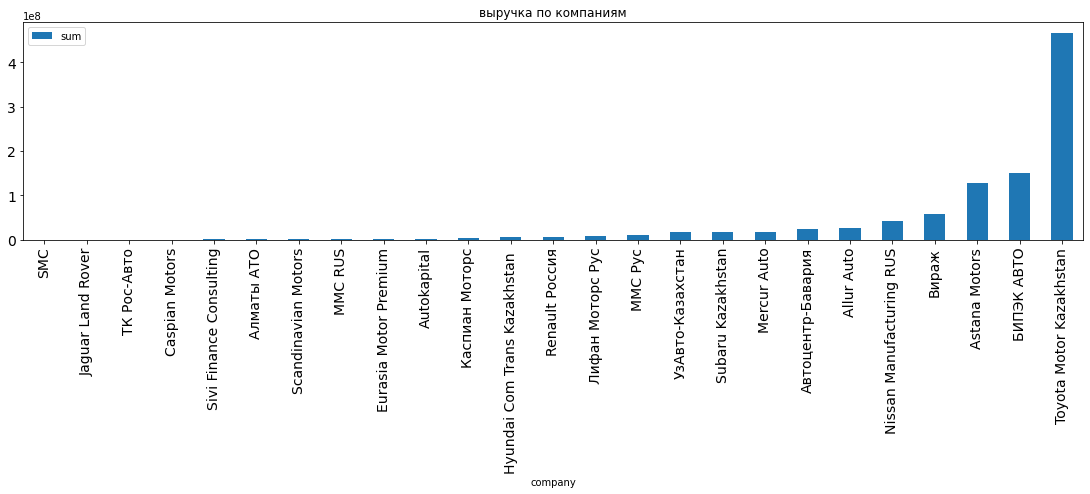

In [131]:
df.groupby(['company'])['sale,_usd'].agg(['sum']).reset_index().sort_values(by='sum').plot(
        x='company',
        y="sum",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='выручка по компаниям'
)

Вывод: как видно из полученных данных по выручке есть лидер: Toyota Motor Kazakhstan. Остальные схожи с кол-м продаж. Высокая выручка Toyota Motor Kazakhstan может быть обоснована более высокой стоимотью продаваемых автомобилей.
Антилидеры - SMC, jaguar Land Rover

#### средняя/медиана стоимость автомобиля по компаниям

<AxesSubplot:title={'center':'средняя стоимость автомобиля по компаниям'}, xlabel='company'>

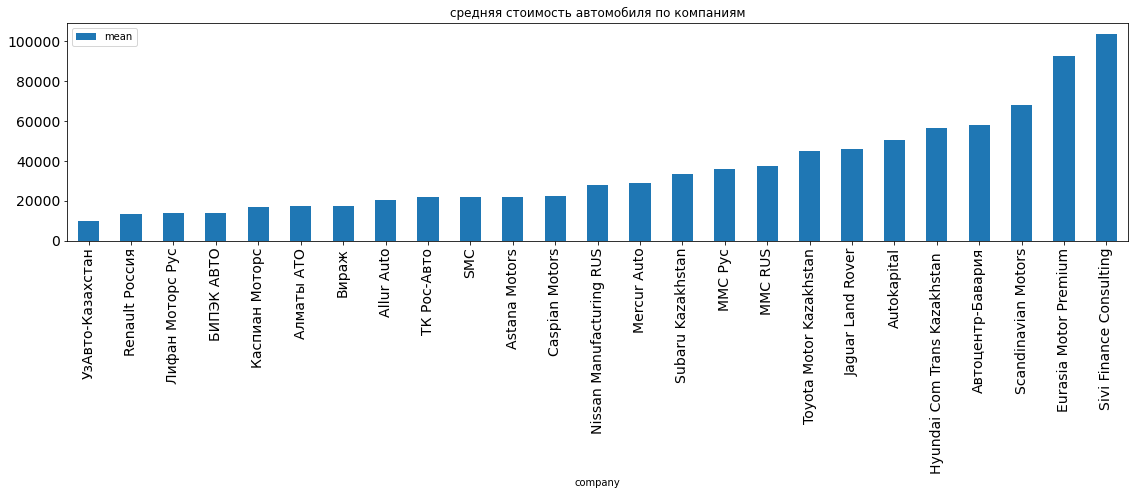

In [132]:
df.groupby(['company'])['price,_usd'].agg(['mean']).reset_index().sort_values(by='mean').plot(
        x='company',
        y="mean",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='средняя стоимость автомобиля по компаниям'
)

<AxesSubplot:title={'center':'медиана стоимость автомобиля по компаниям'}, xlabel='company'>

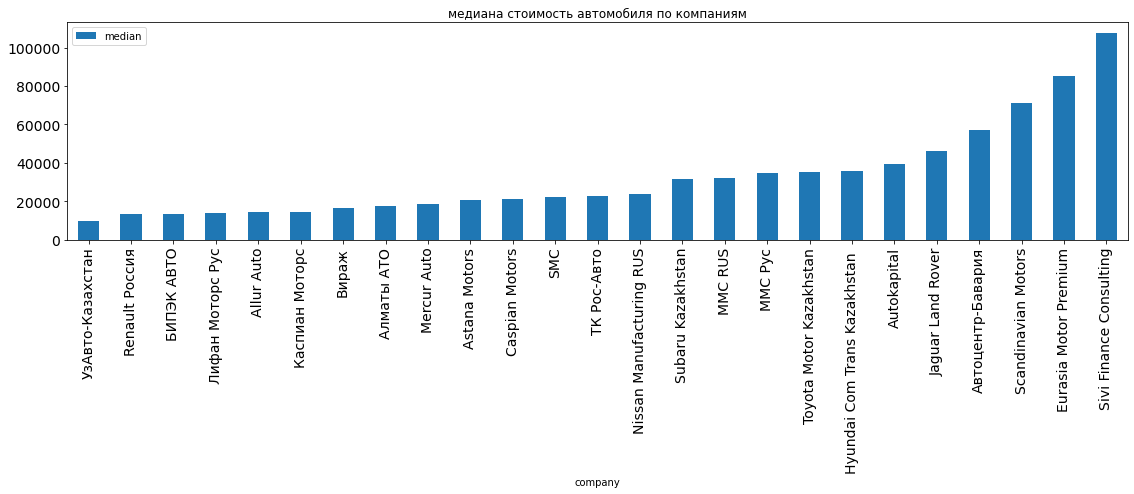

In [133]:
df.groupby(['company'])['price,_usd'].agg(['median']).reset_index().sort_values(by='median').plot(
        x='company',
        y="median",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='медиана стоимость автомобиля по компаниям'
)

Вывод: как видно из полученных данных Toyota Motor Kazakhstan не оказалась лидером по стоимости автомобиля. Самые дорогие автомобили в компаниях: Eurasia Motor Premium, Sivi Finance Consulting. Самые дешевые: УАЗавто Казахстан, Renault Россия. Но стоит еще оценить какие сегменты автомобилей представленны в компаниях. Далее это рассмотрим.

#### какие сегменты представлены в компаниях

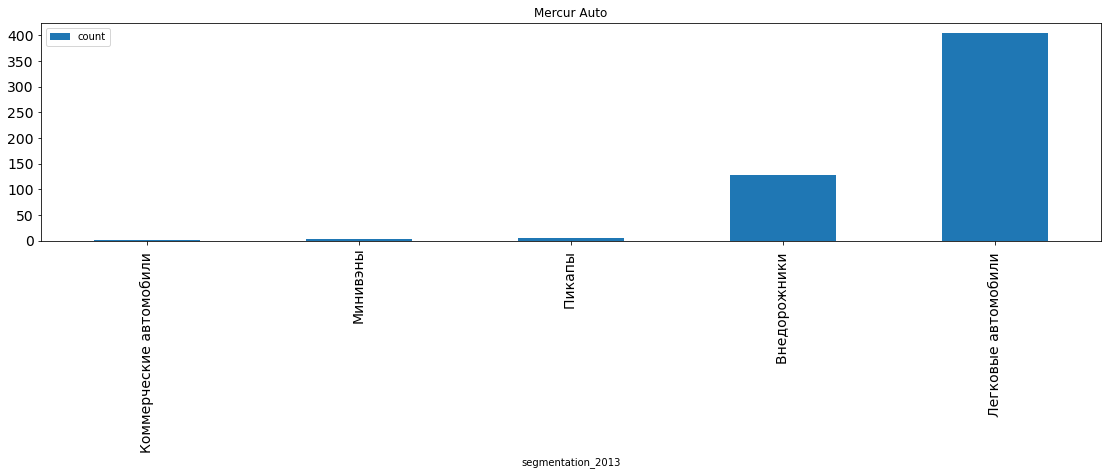

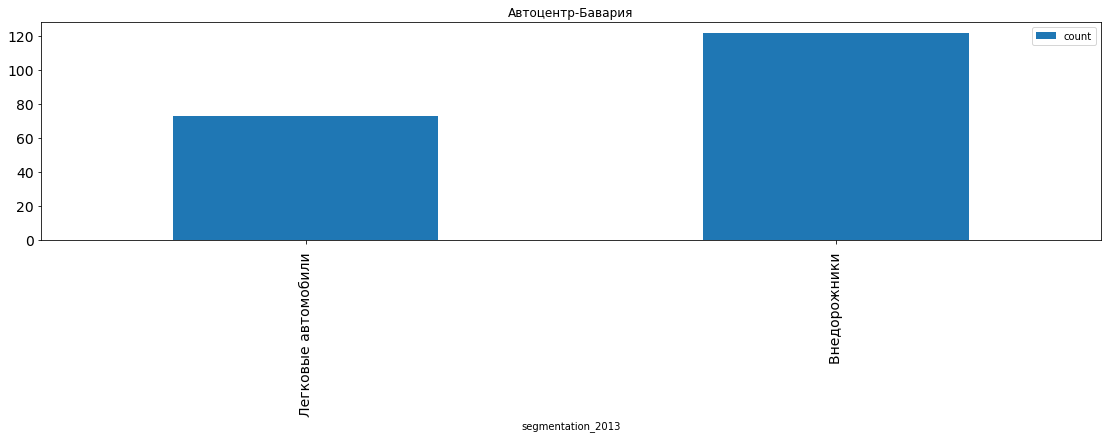

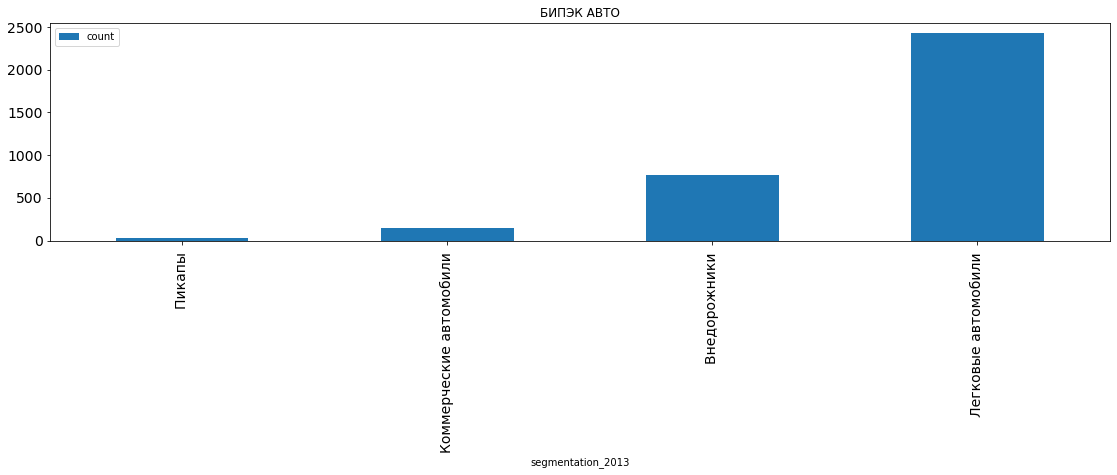

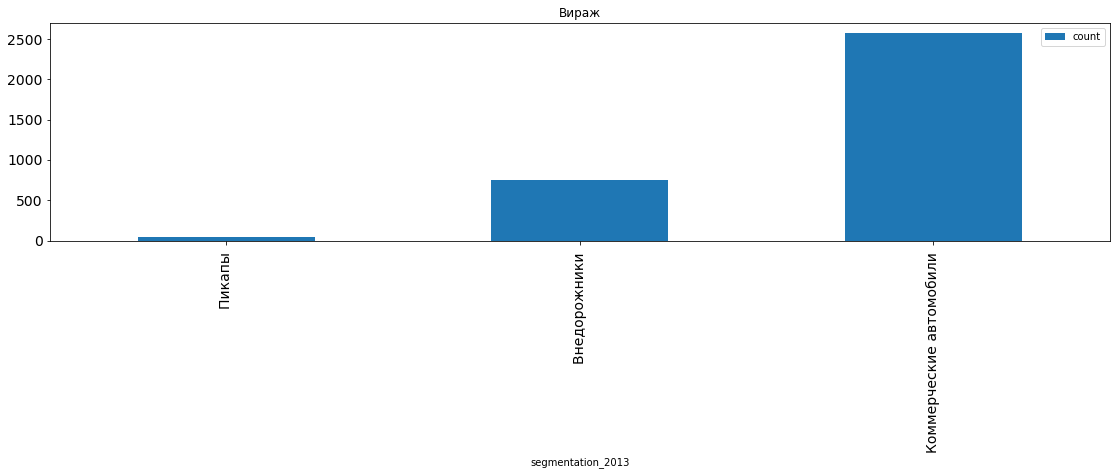

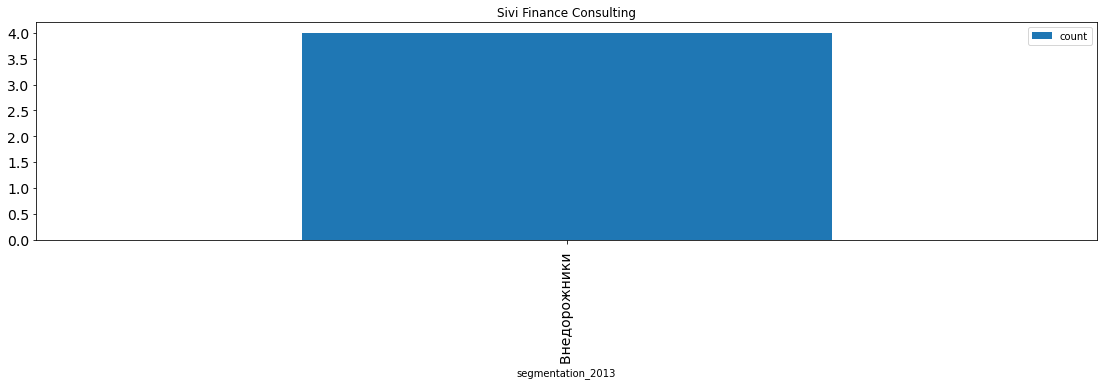

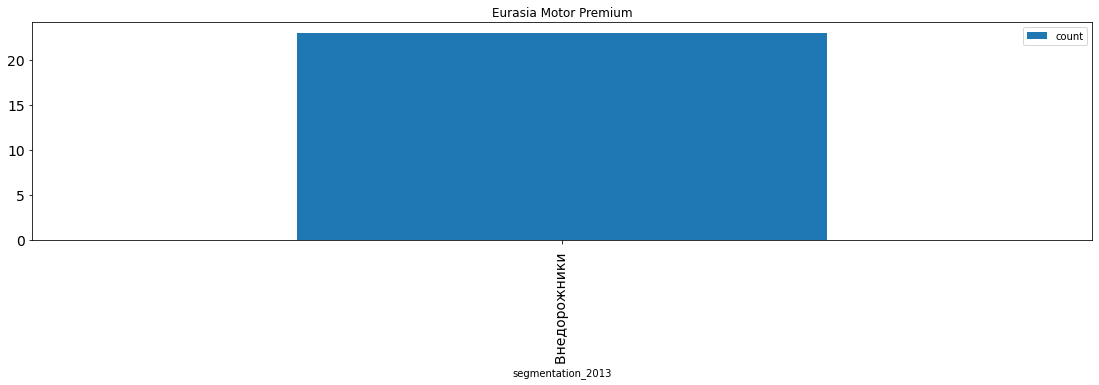

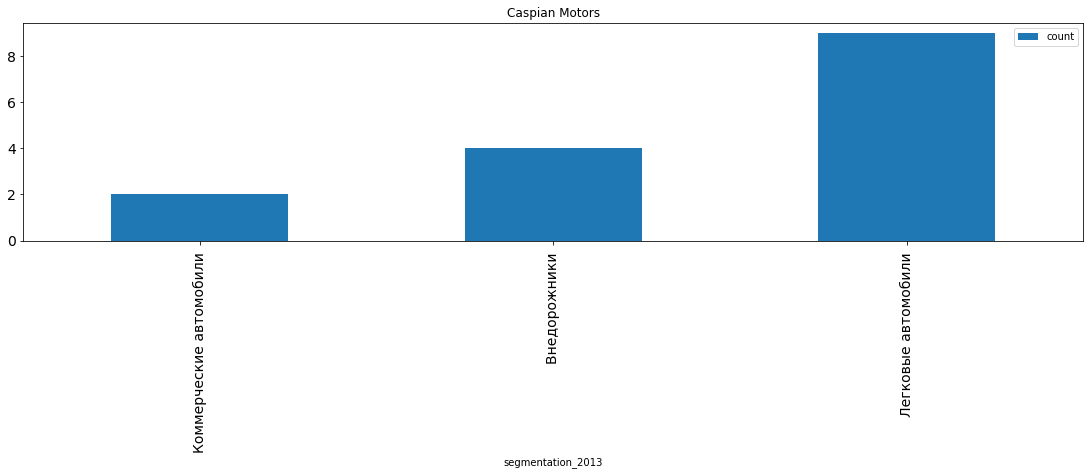

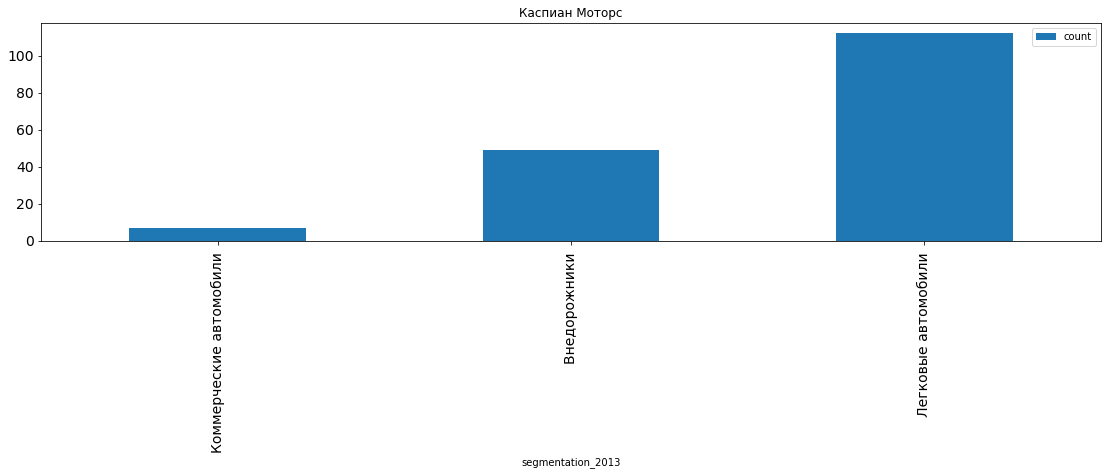

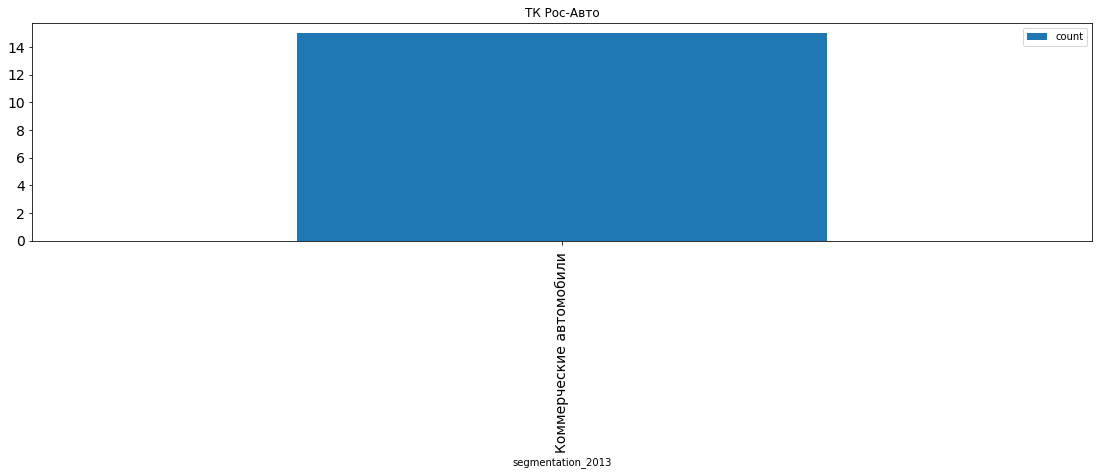

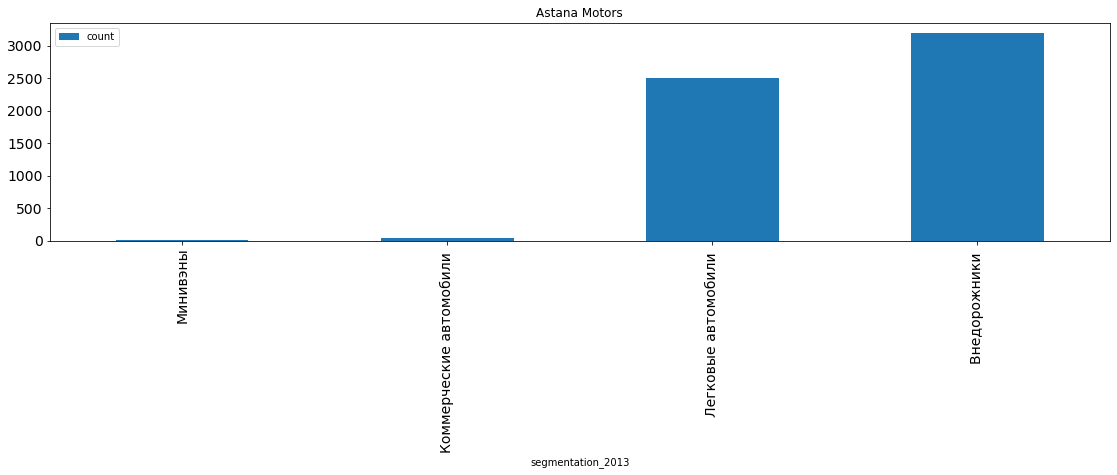

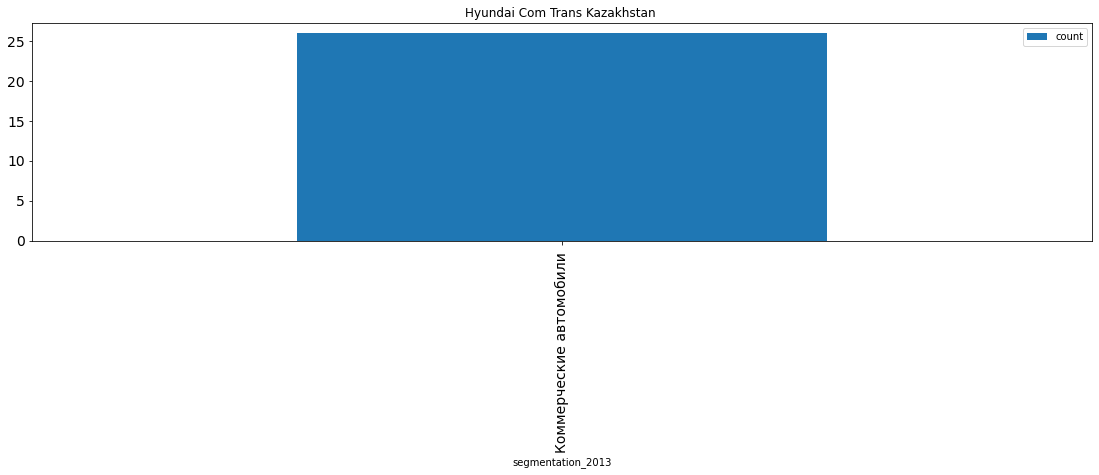

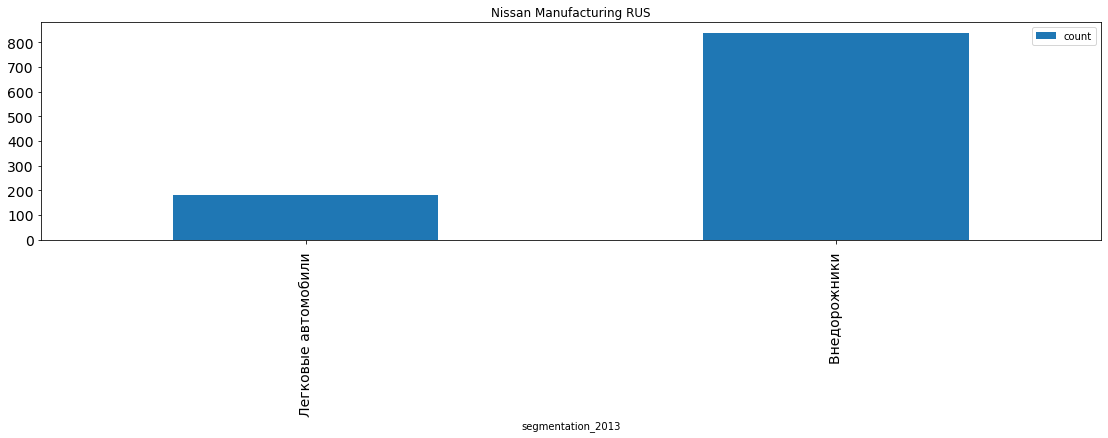

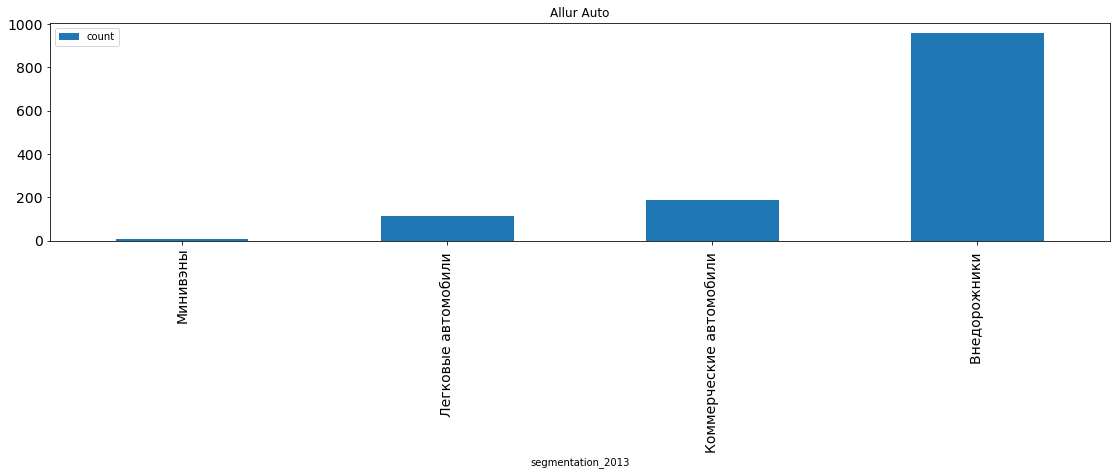

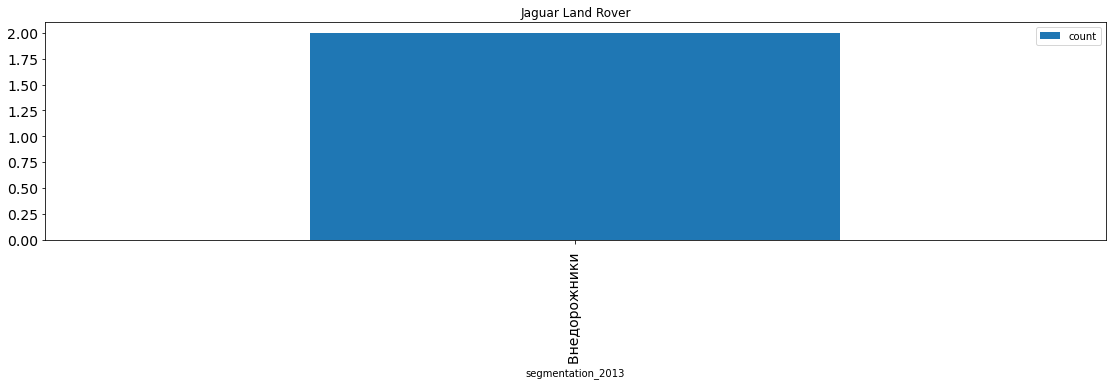

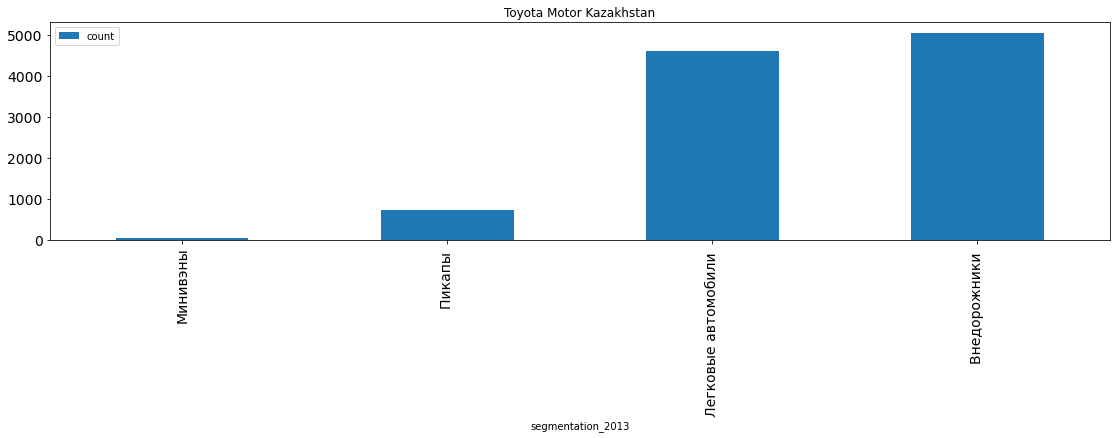

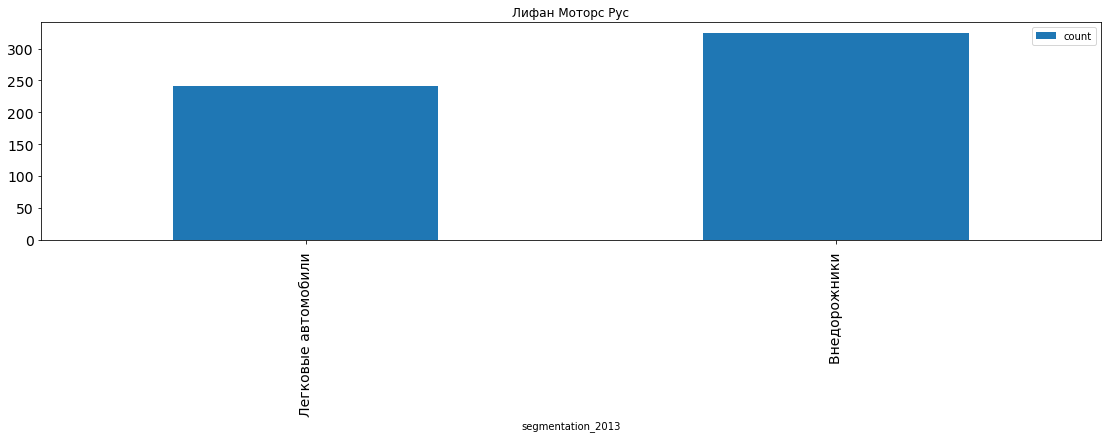

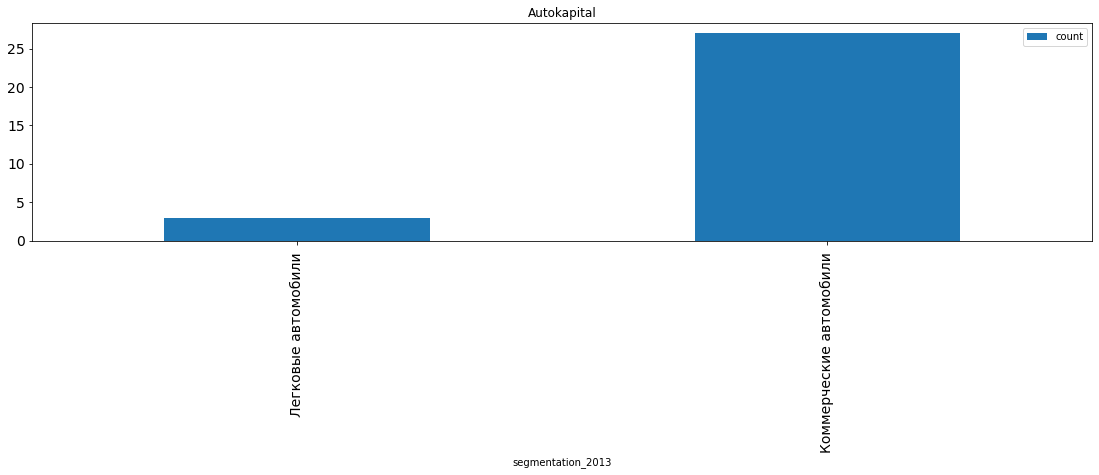

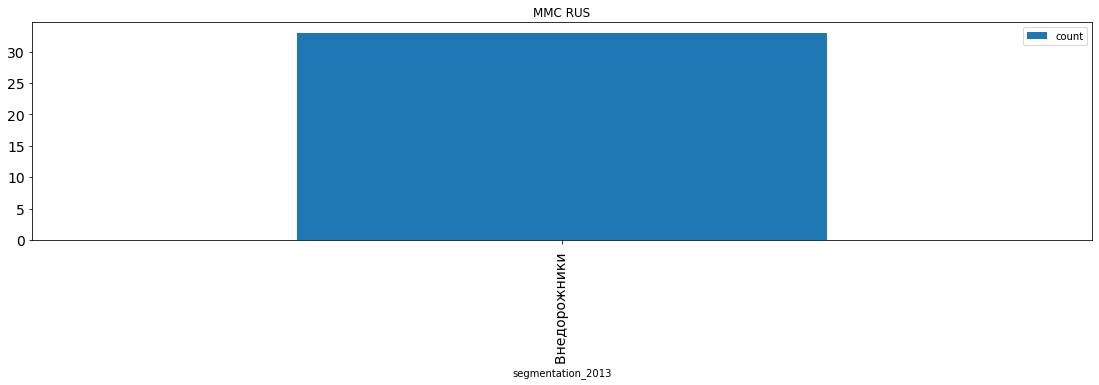

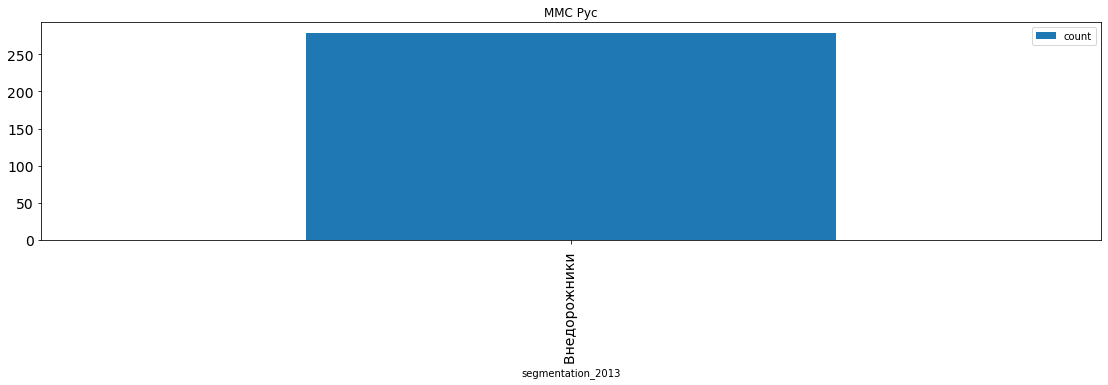

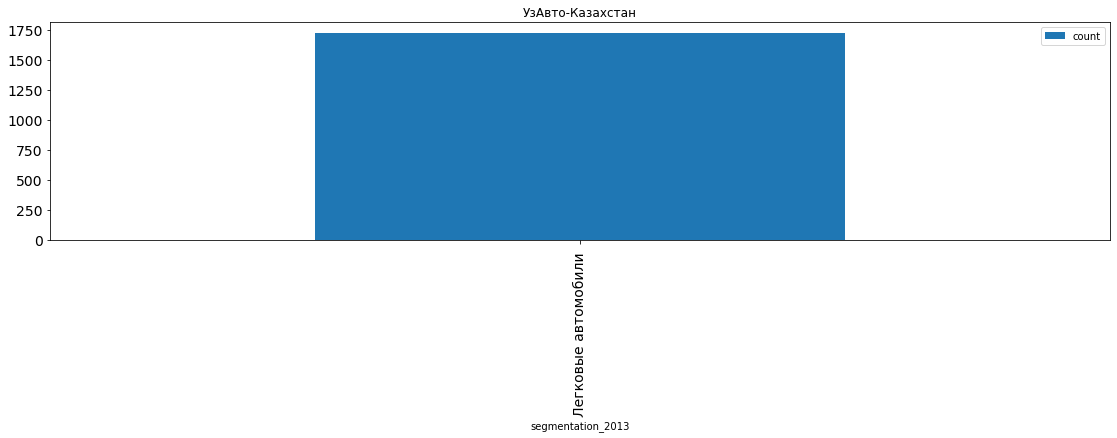

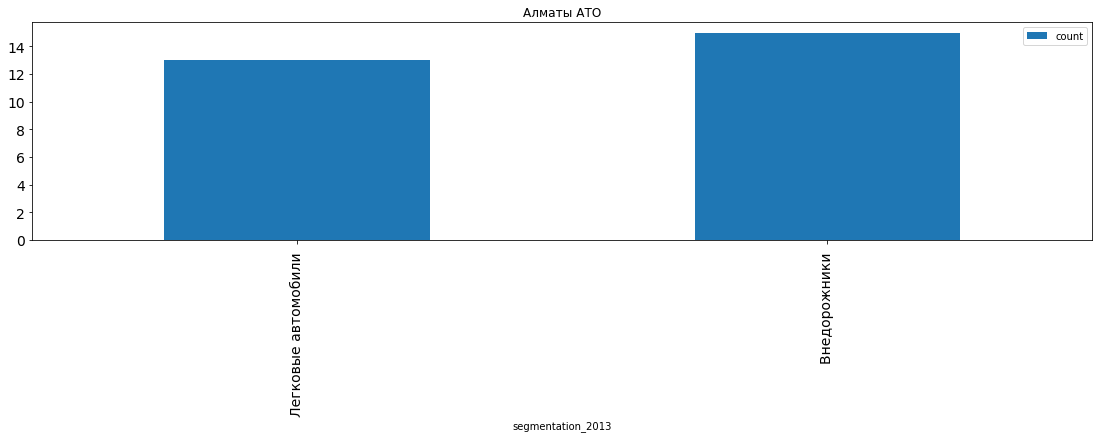

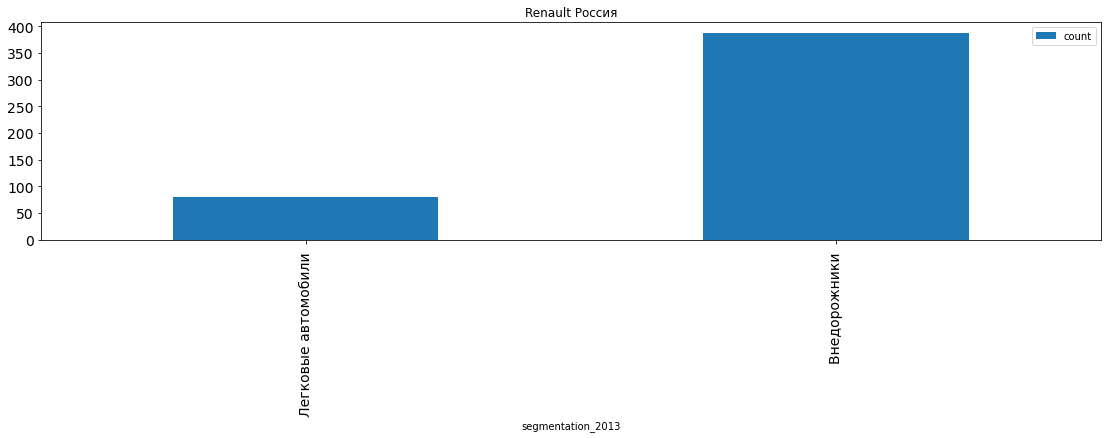

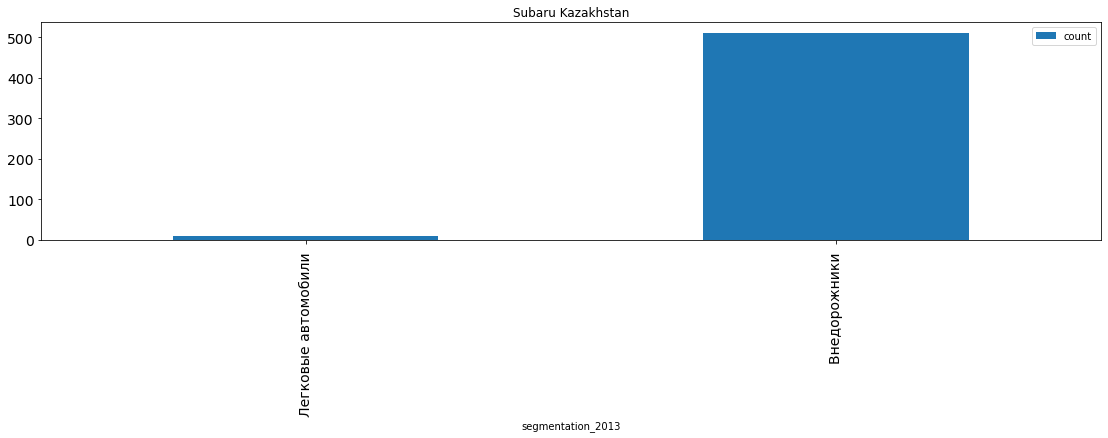

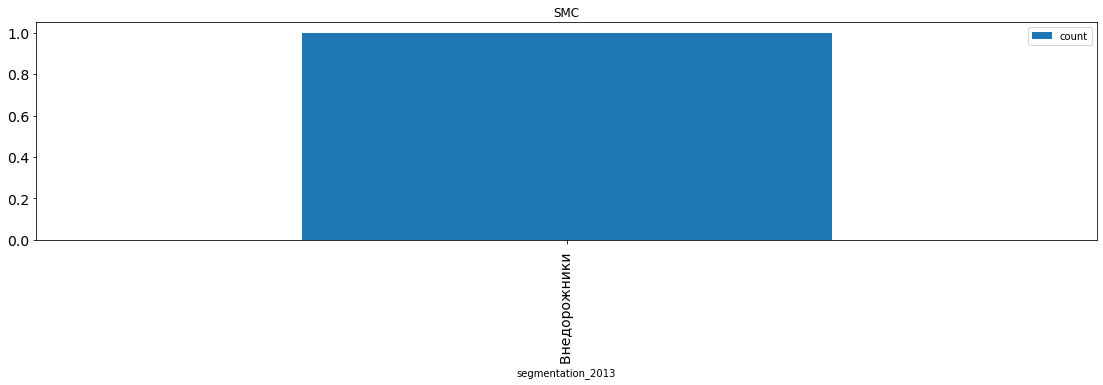

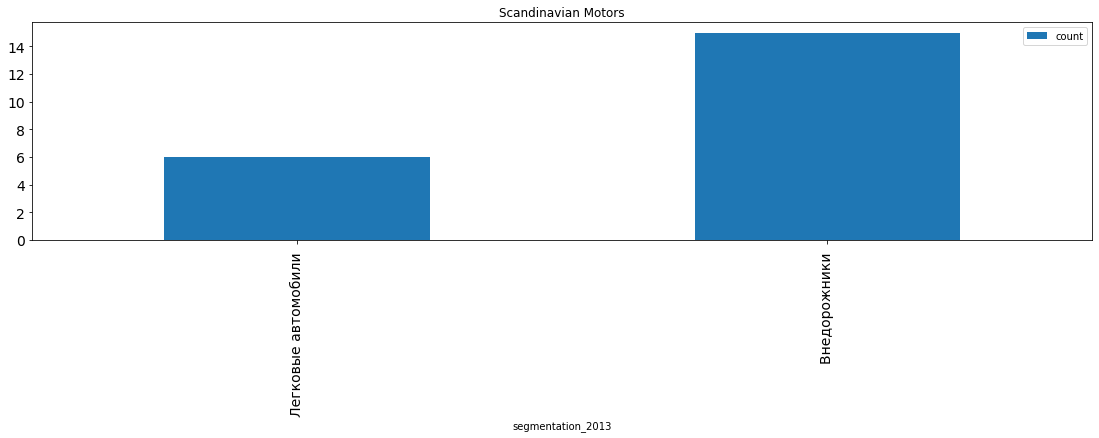

In [134]:
for i in df['company'].unique():
    df[df['company'] == i].groupby(['segmentation_2013'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='segmentation_2013',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Вывод:
- БИПЭК АВТО (Пикапы, Комер. авто, внедорожники(лидер), легк. авто(лидер)), 
- Toyota Motor Kazakhstan (минивэны, пикапы, легк. авто (лидер), внедорожники(лидер)), 
- Astana Motors (минивэны, ком. авто, легк. авто(лидер), внедорожники(лидер)), 
- Вираж (Пикапы, Внедорожники(лидер), Комер. авто(лидер)),
- Eurasia Motor Premium (Внедорожники(лидер)), 
- Sivi Finance Consulting (Внедорожники(лидер)),
- УАЗавто Казахстан (легк. авто),
- Renault Россия (Внедорожники(лидер), легк. авто),
- SMC (Внедорожники),
- jaguar Land Rover (Внедорожники).

Из полученных данных видно, что больше всего компании получают прибыли с внедорожников. Лидеры по кол-ву продаж: внедорожники и лег. автомобили.

#### какие классы представлены в компаниях

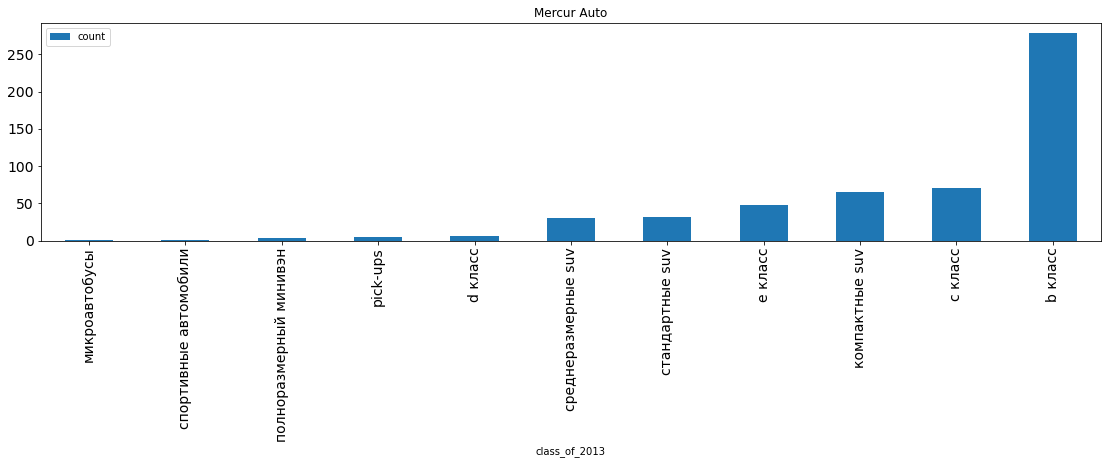

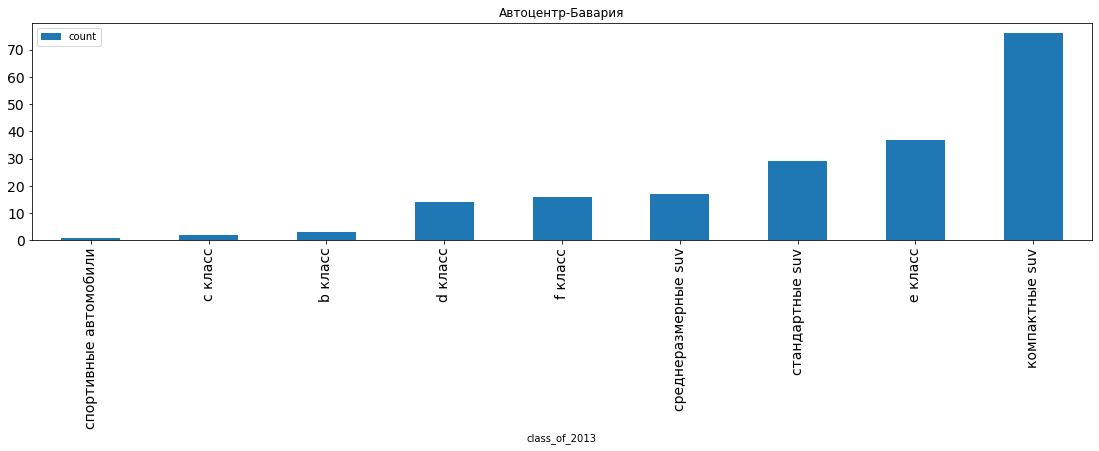

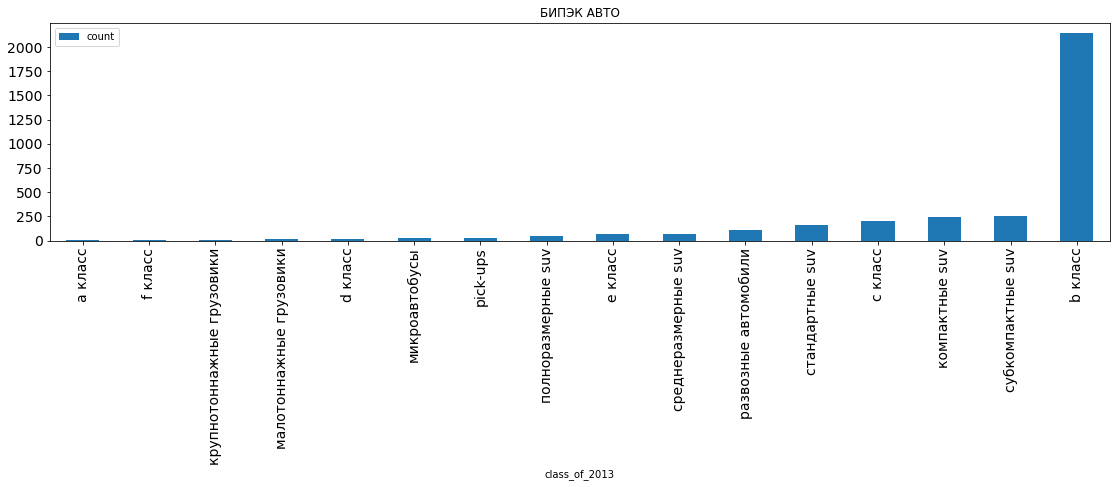

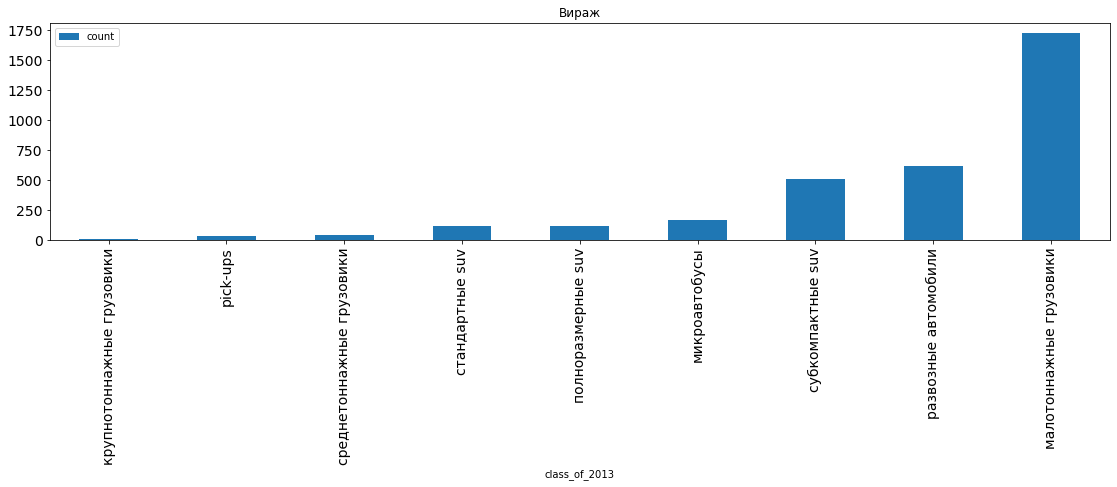

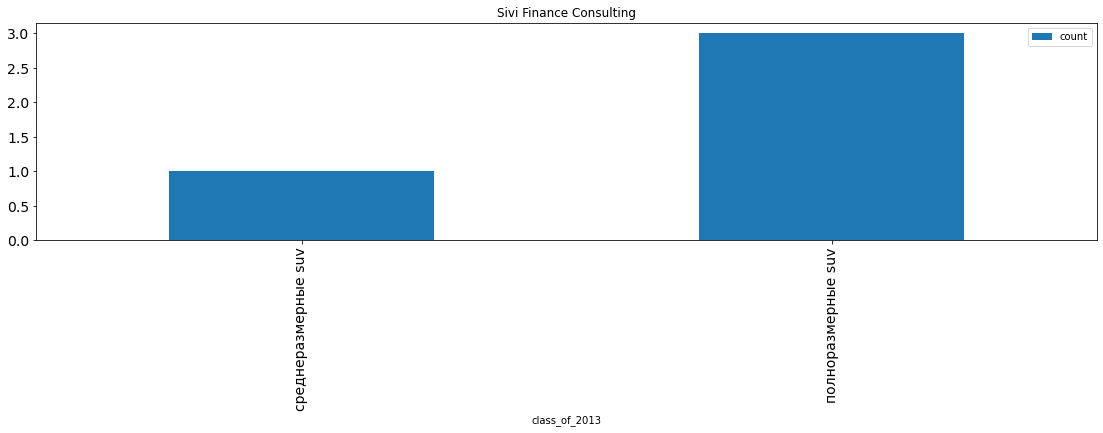

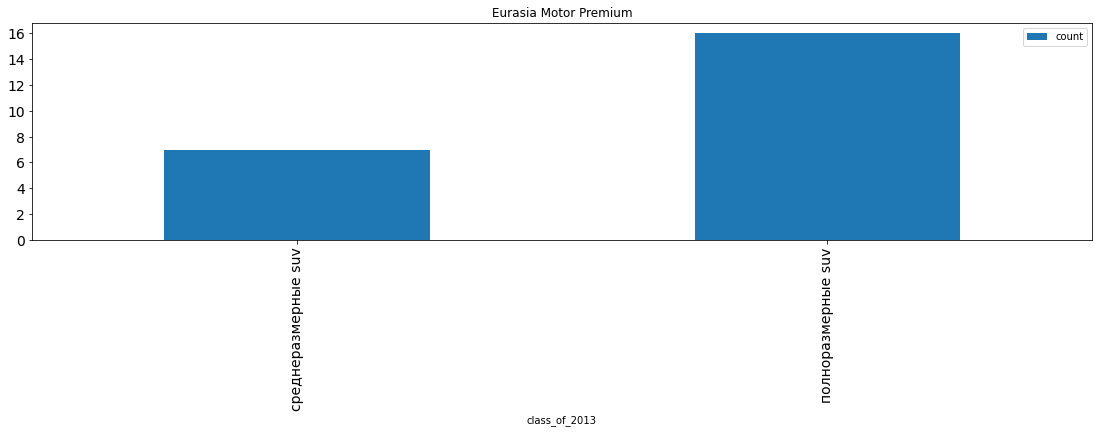

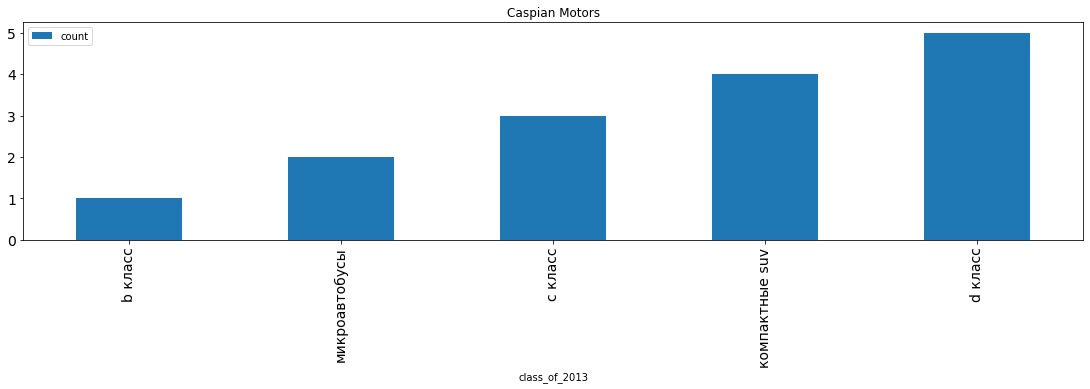

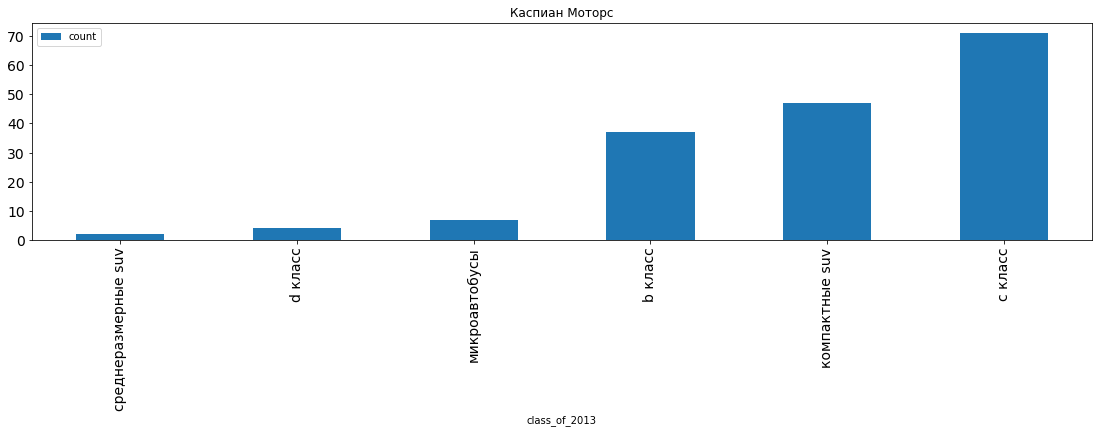

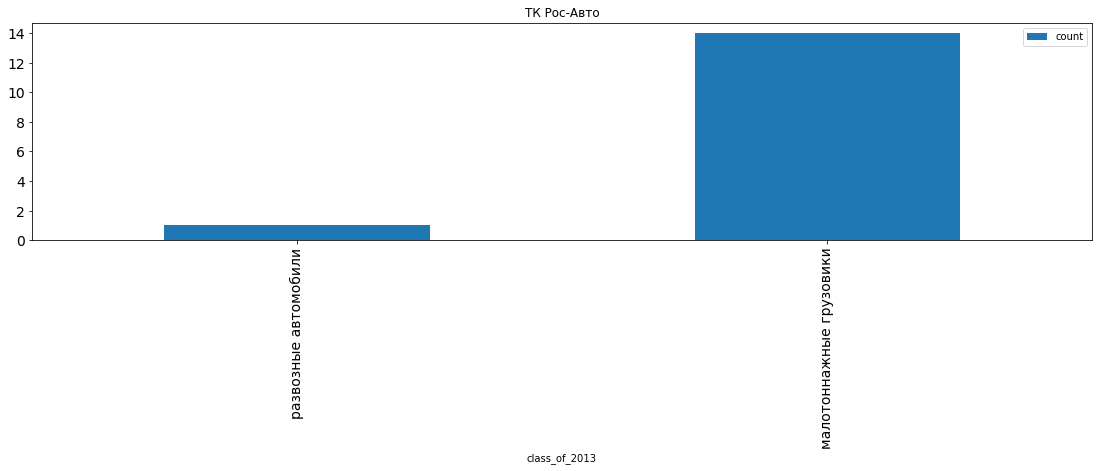

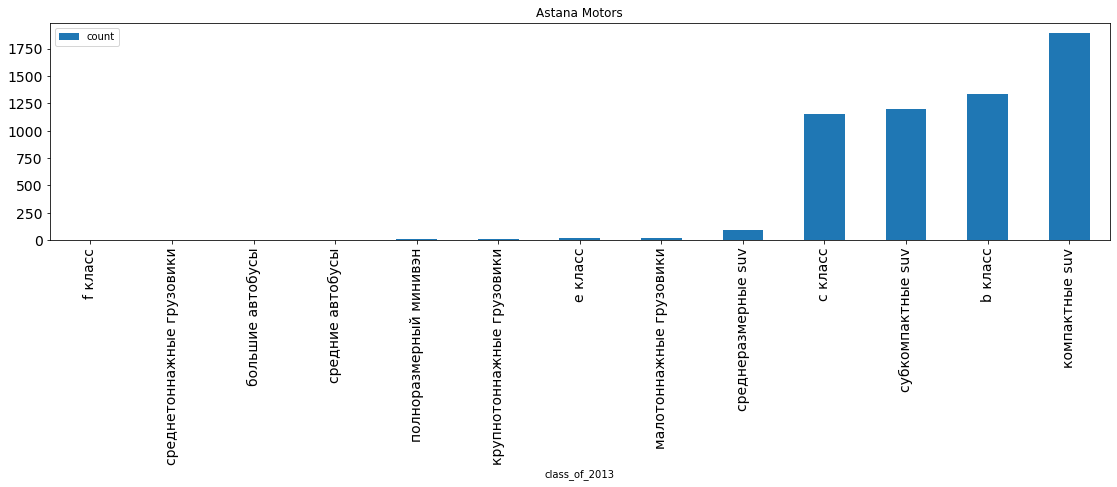

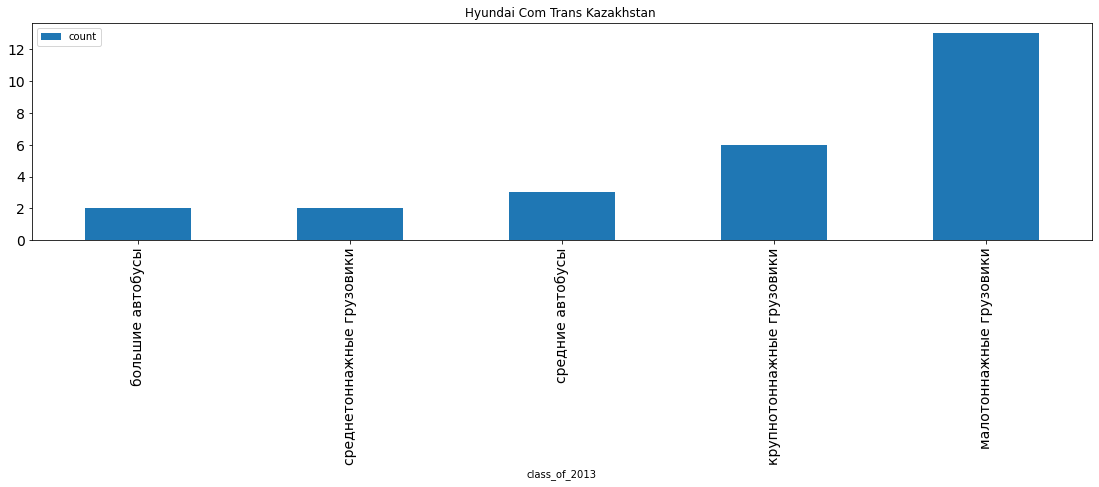

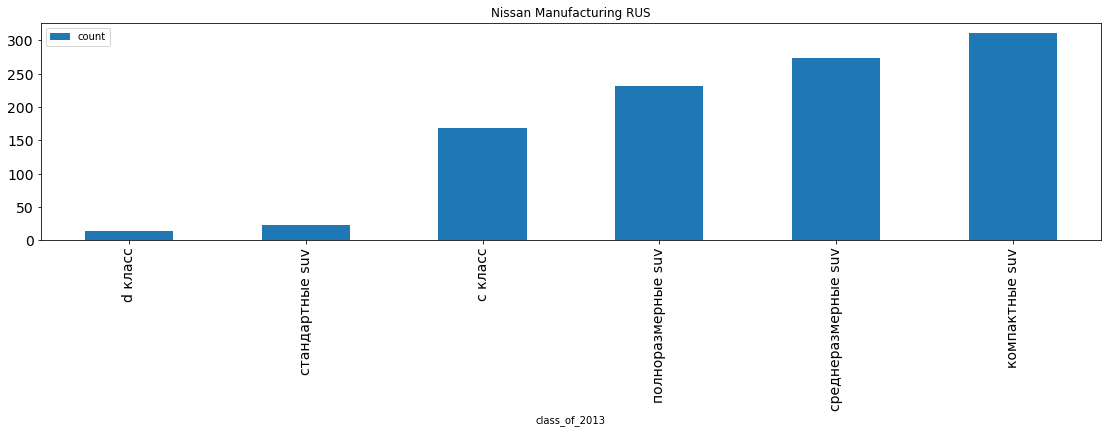

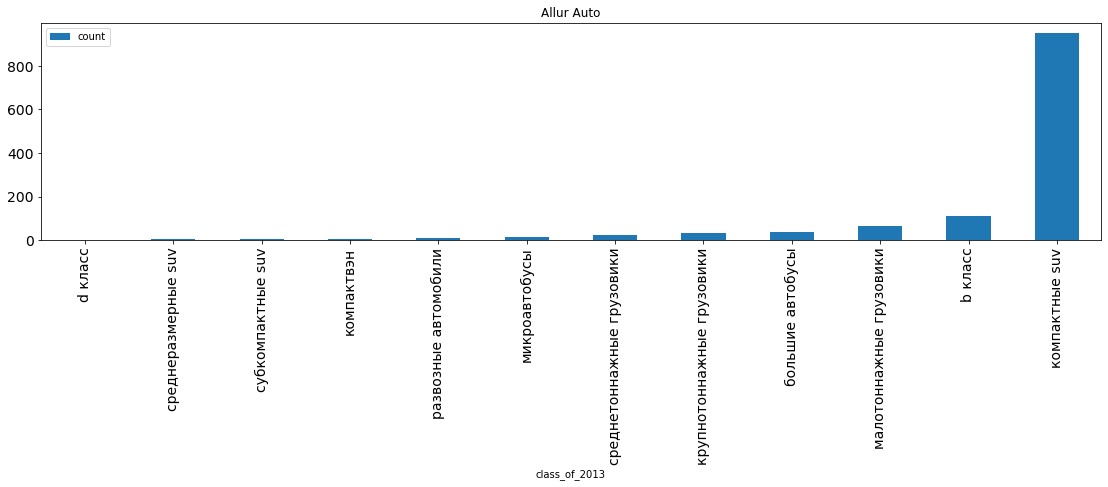

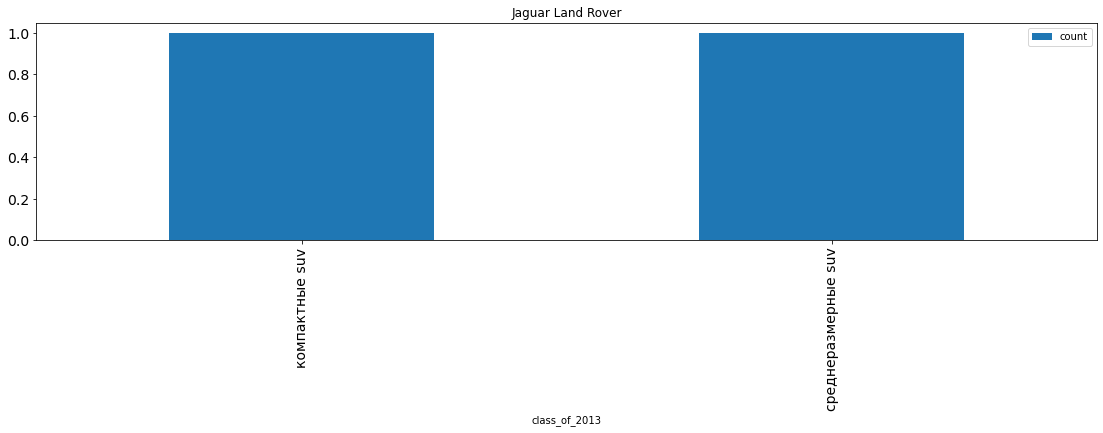

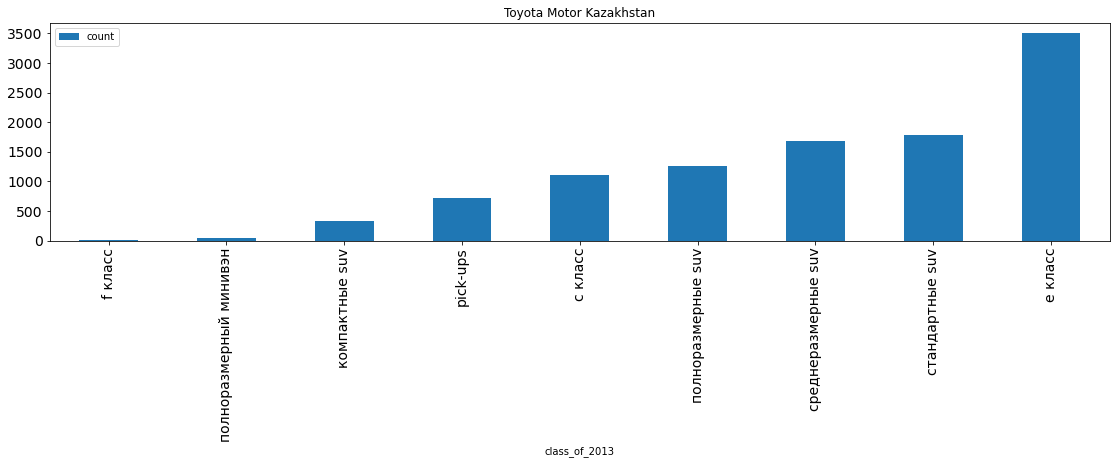

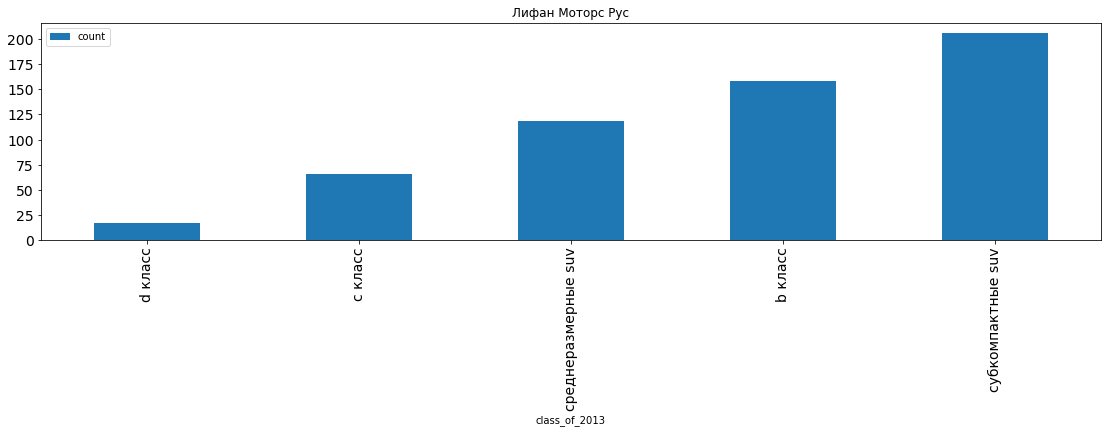

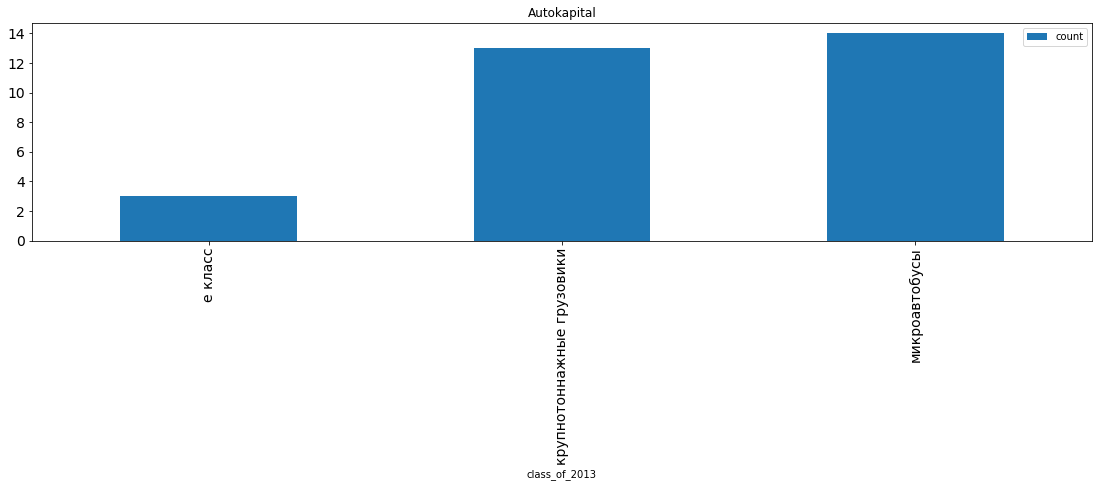

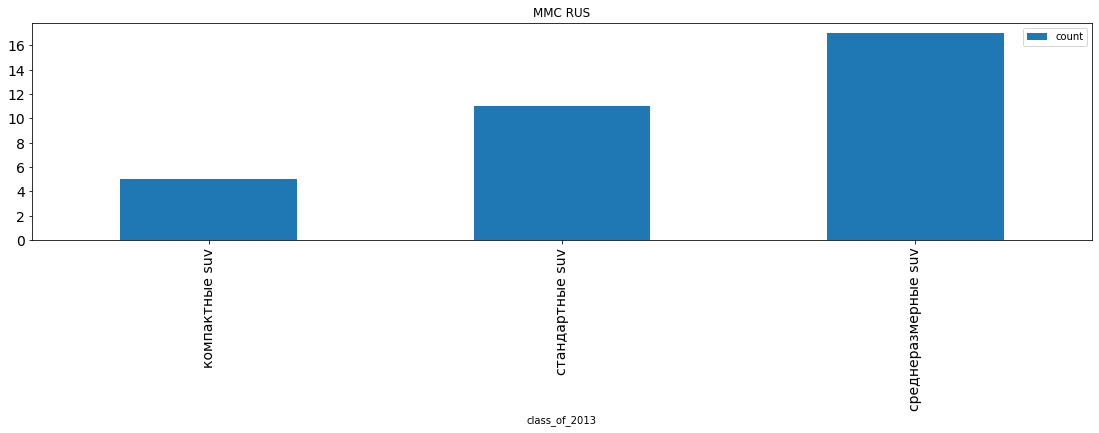

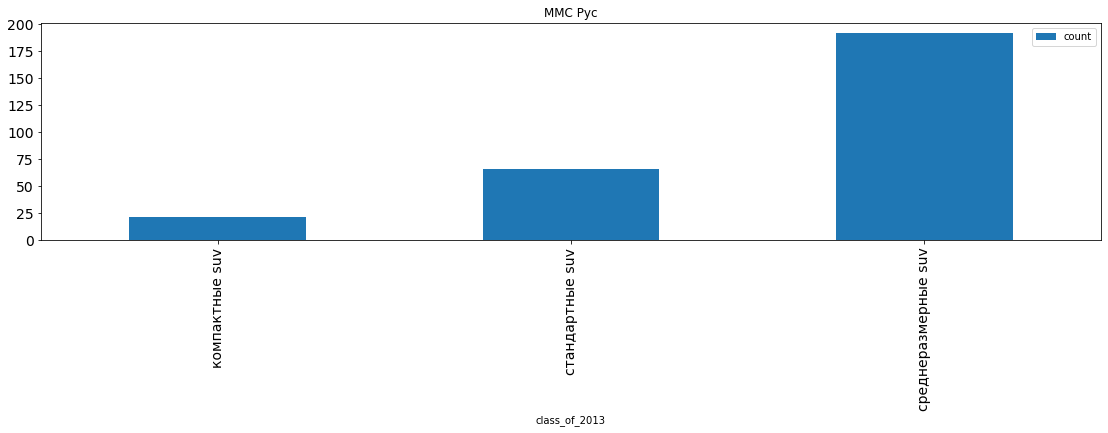

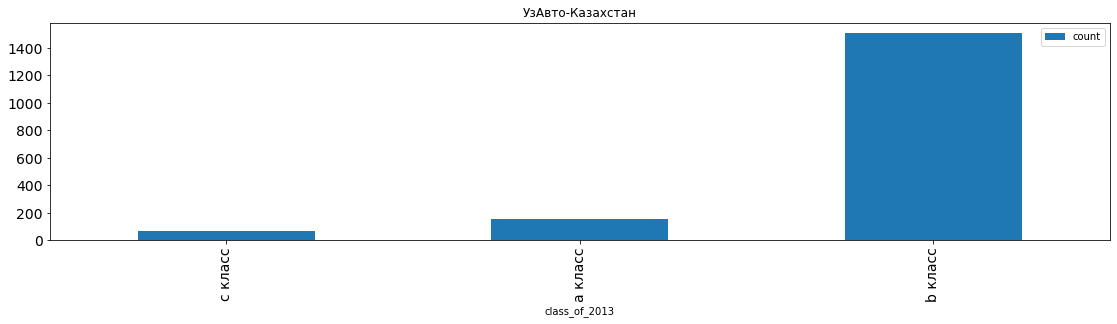

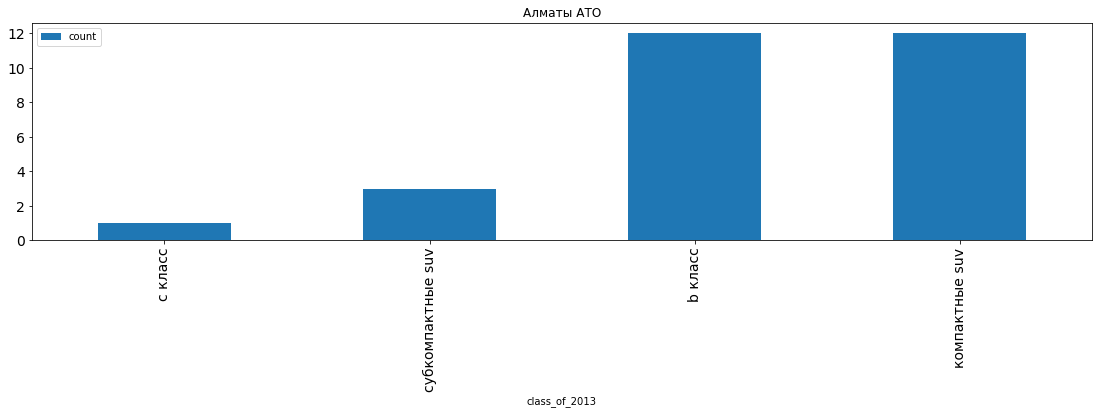

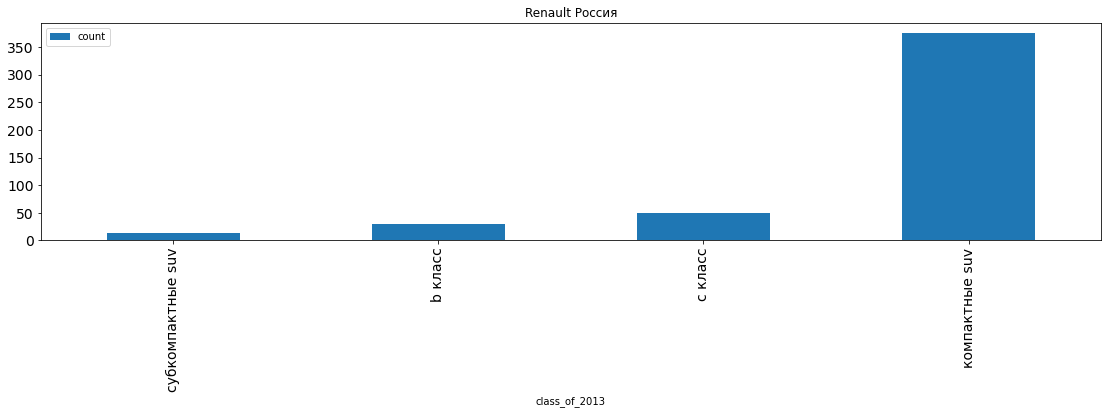

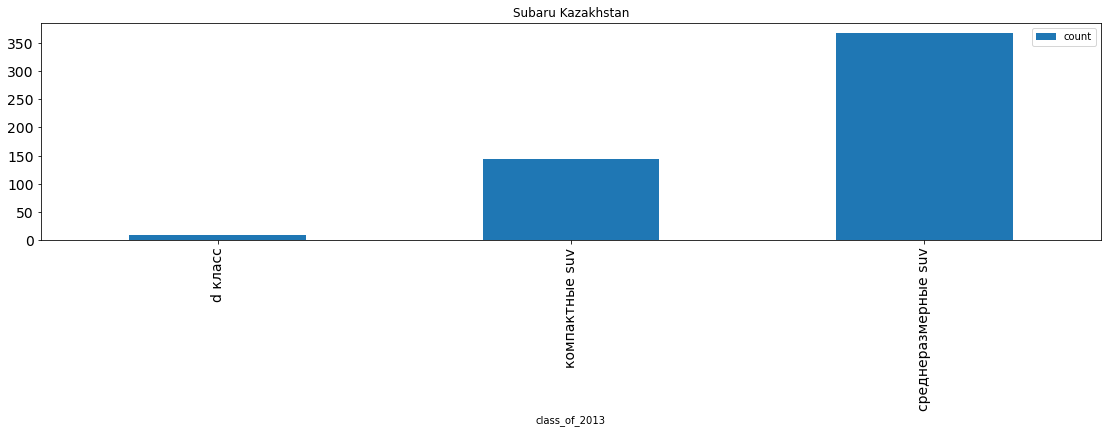

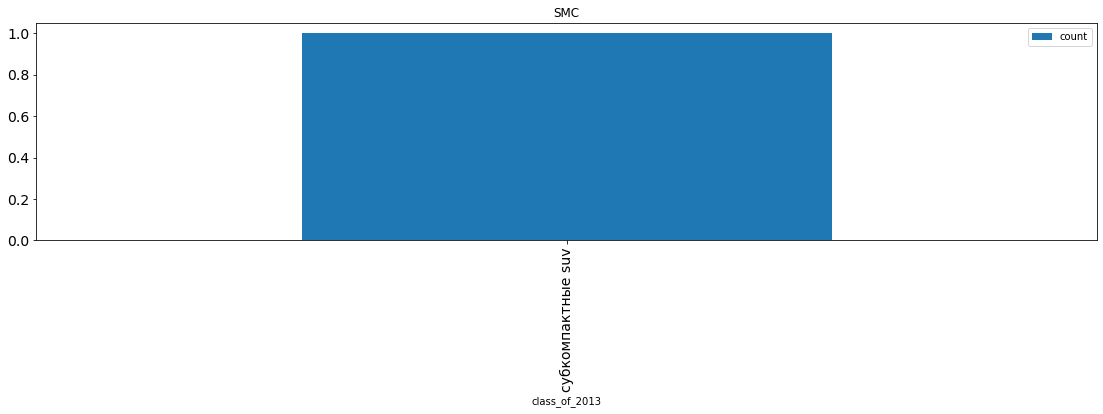

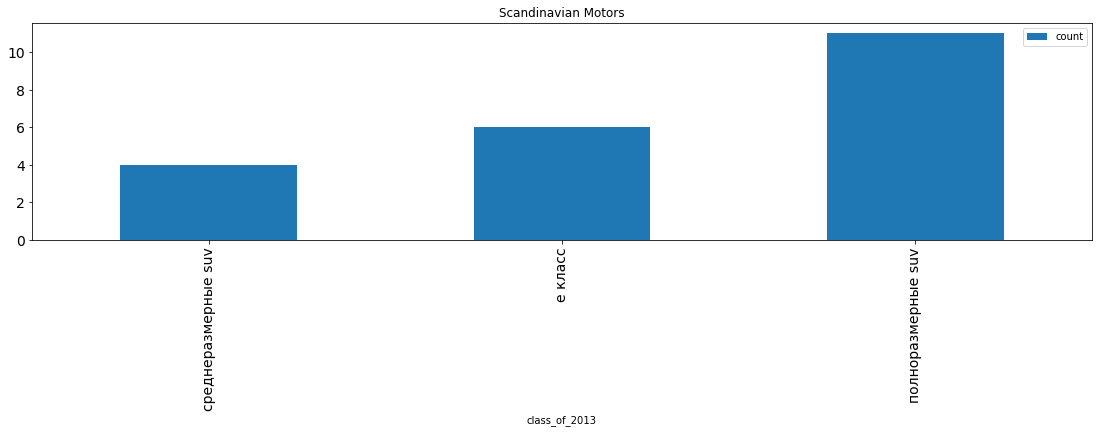

In [135]:
for i in df['company'].unique():
    df[df['company'] == i].groupby(['class_of_2013'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='class_of_2013',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Вывод:<br>
    в компаниях в основном представлены:
- БИПЭК АВТО (b-класс), 
- Toyota Motor Kazakhstan (полноразмерные, стандартные и среднеразмерные suv, е-класс), 
- Astana Motors (c-класс, субкомпактные suv, b-класс, компактные suv), 
- Вираж (малотонажные грузовики, развозные автомобили, субкомпактные),
- Eurasia Motor Premium (полноразмерные и среднеразмерные suv), 
- Sivi Finance Consulting (полноразмерные и среднеразмерные suv),
- УАЗавто Казахстан (b-класс),
- Renault Россия (компактные suv)
- SMC (субкомпактные suv),
- jaguar Land Rover (компактные suv и среднеразмерные suv).<br>
Из данных можно сделать выводы:
- самые прибыльные это различные внедорожники,
- из легковых самые продаваемые это c-класс, е-класс и b-класс

#### автомобили каких стран представлены в автосалоне

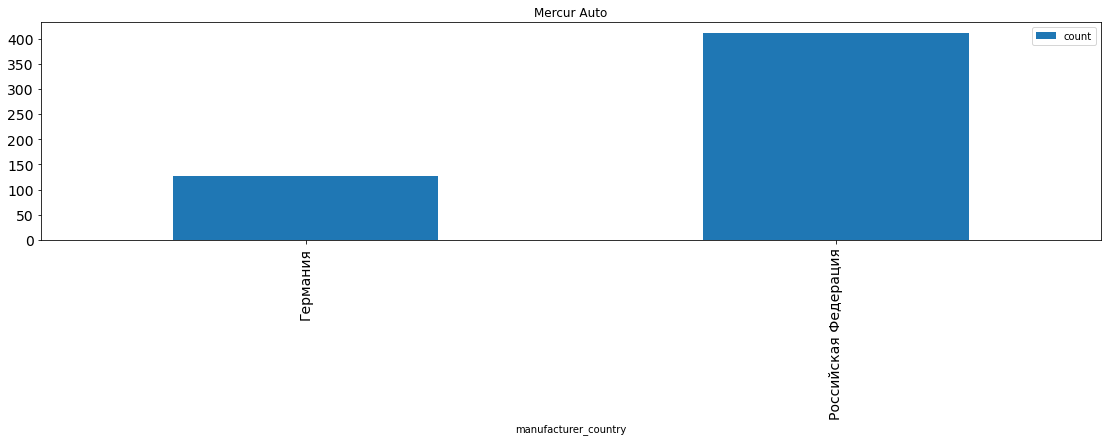

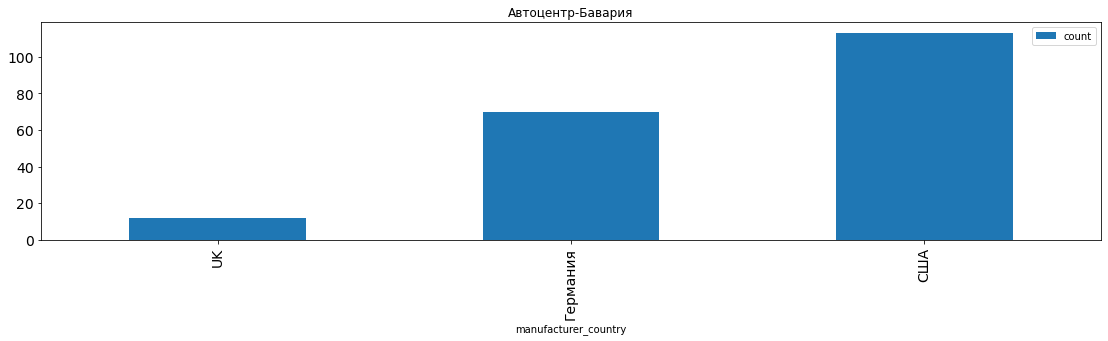

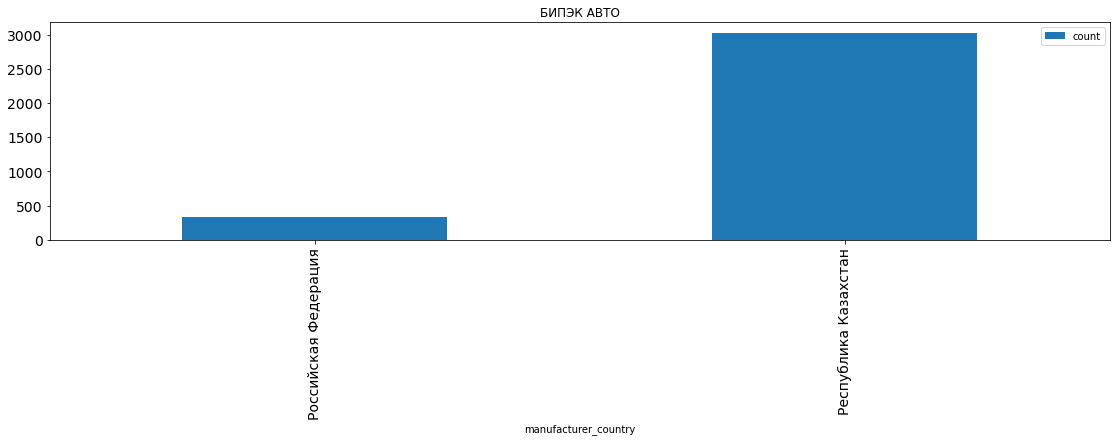

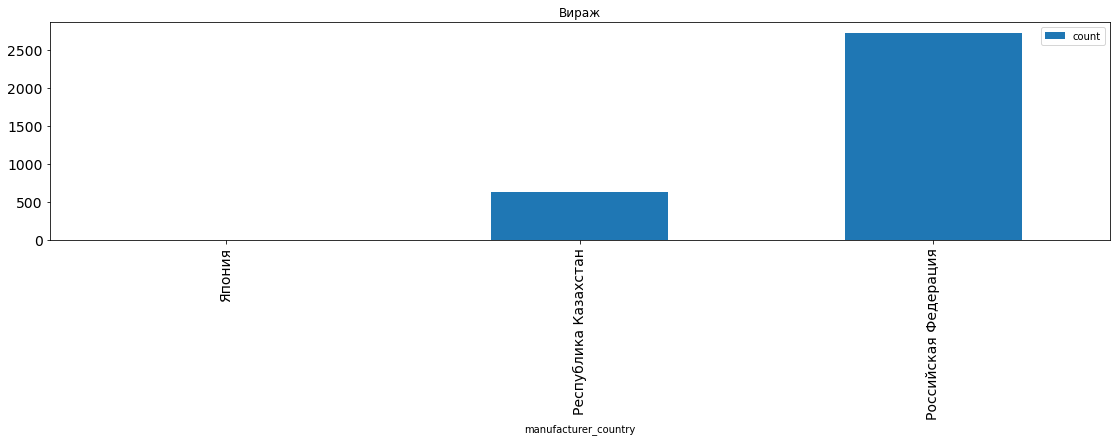

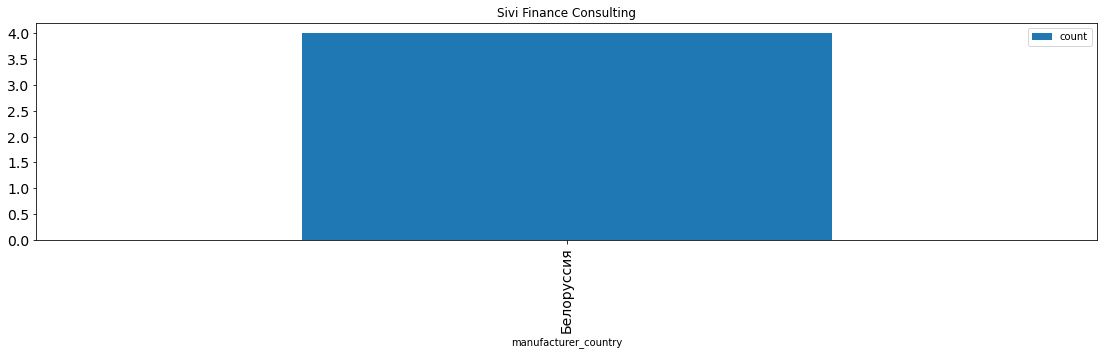

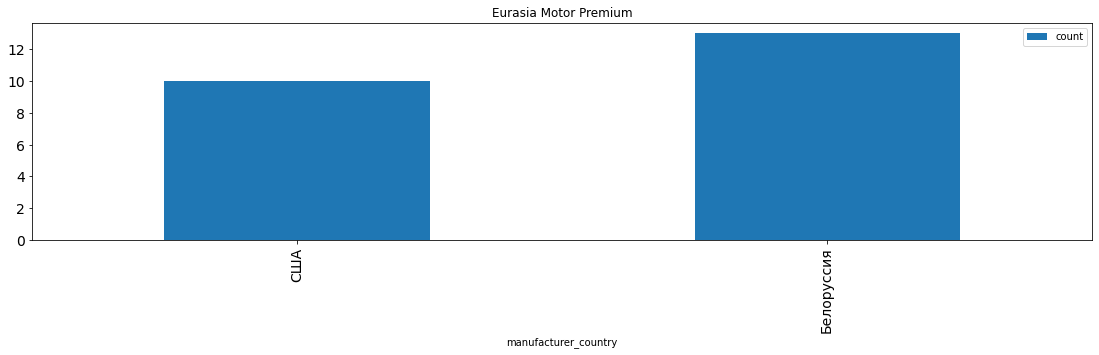

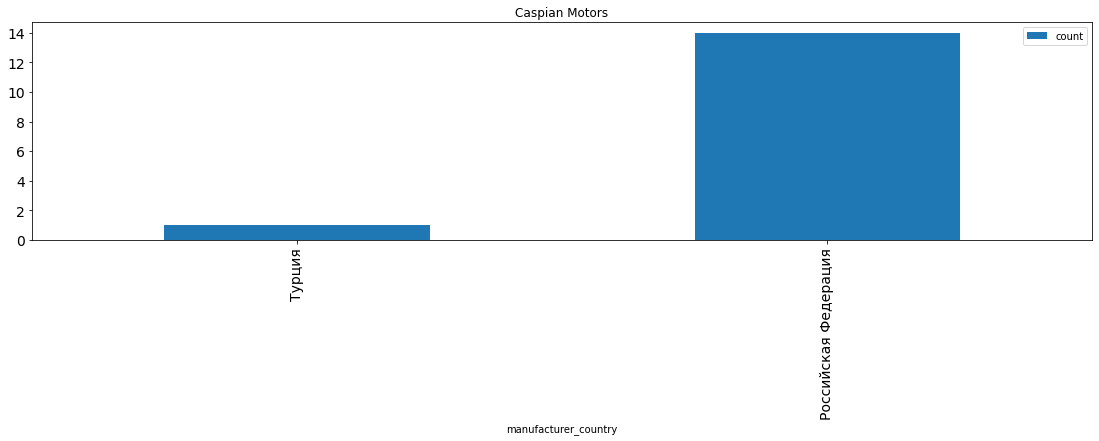

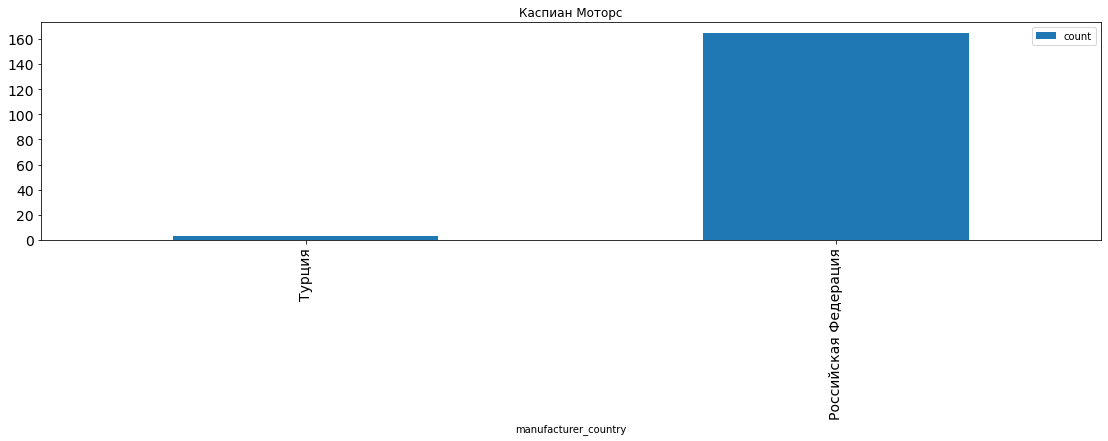

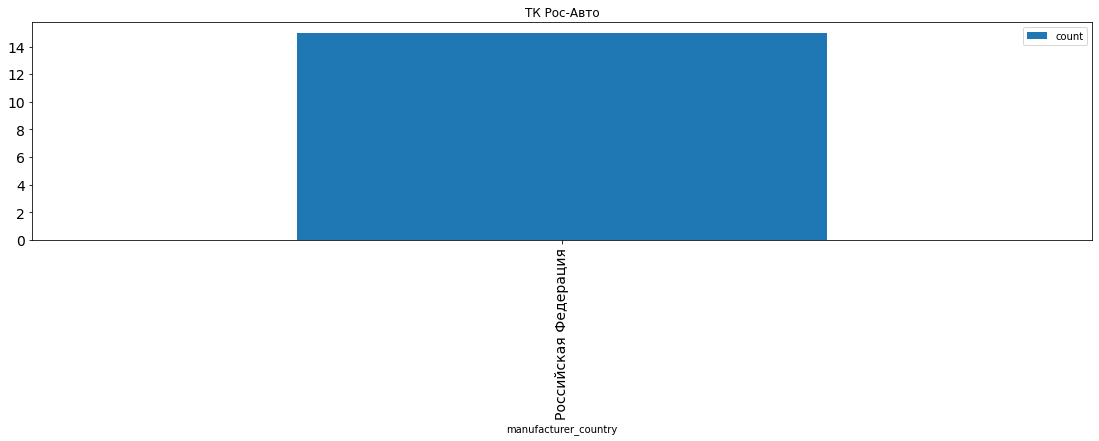

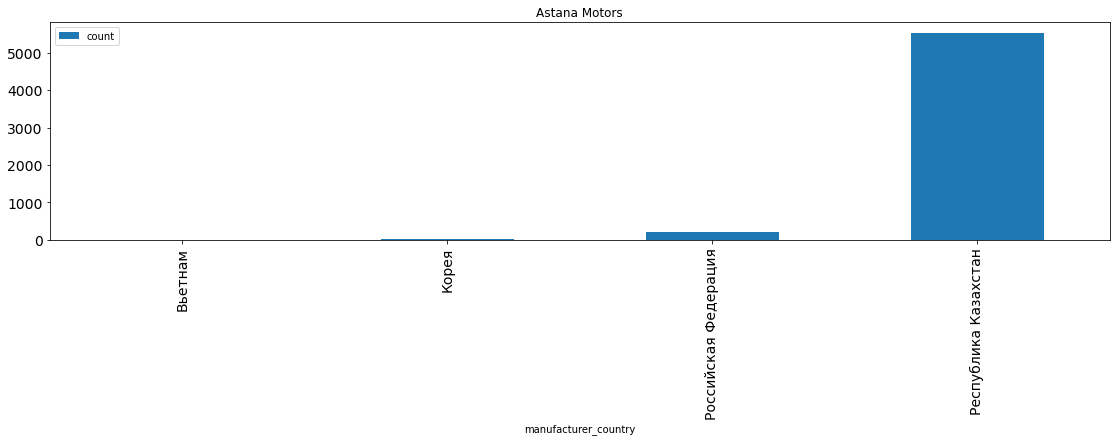

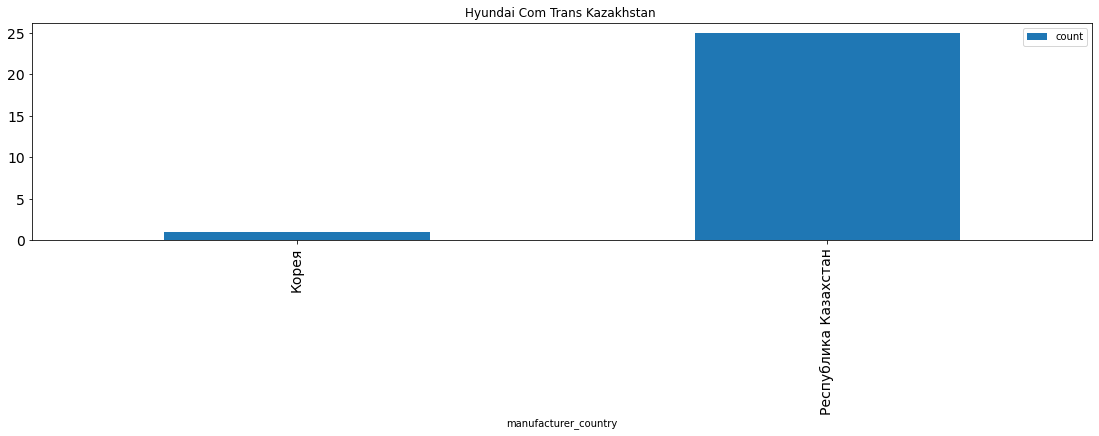

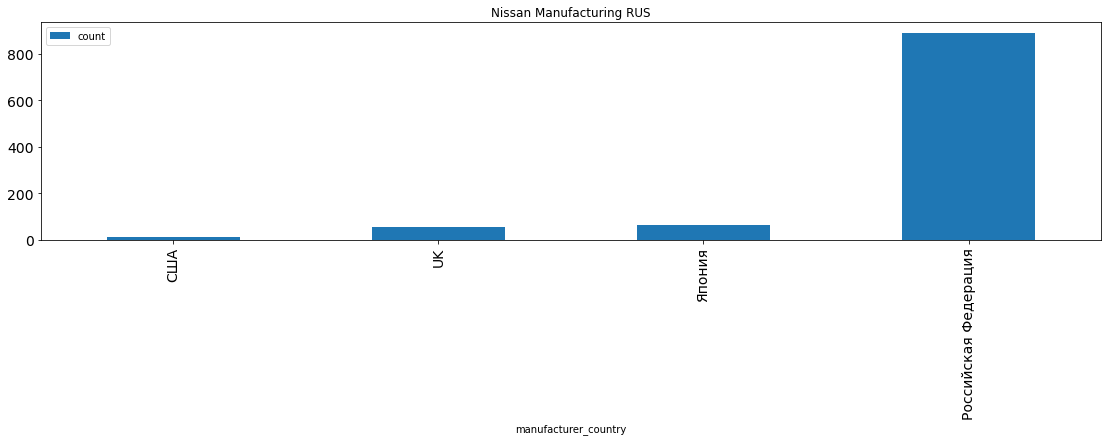

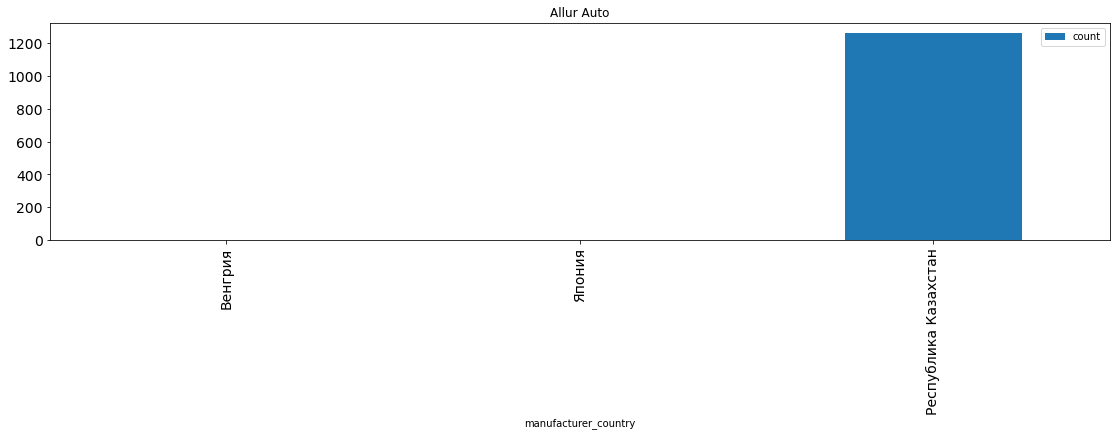

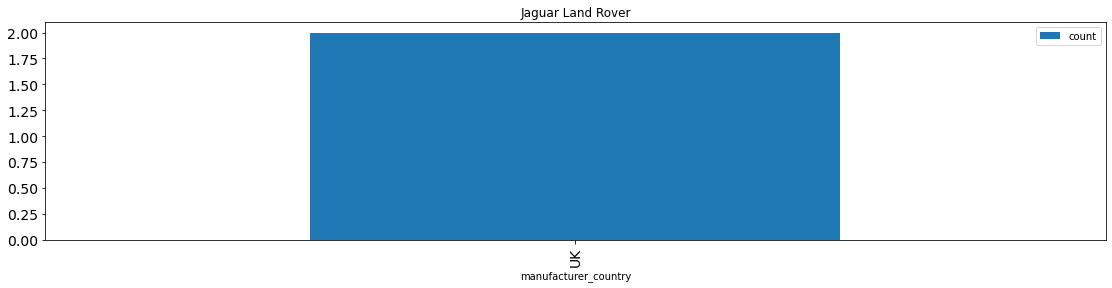

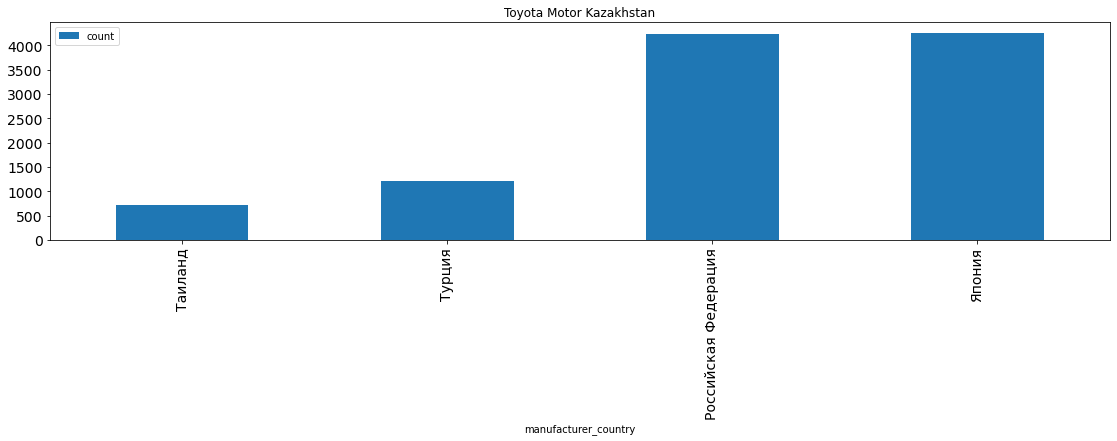

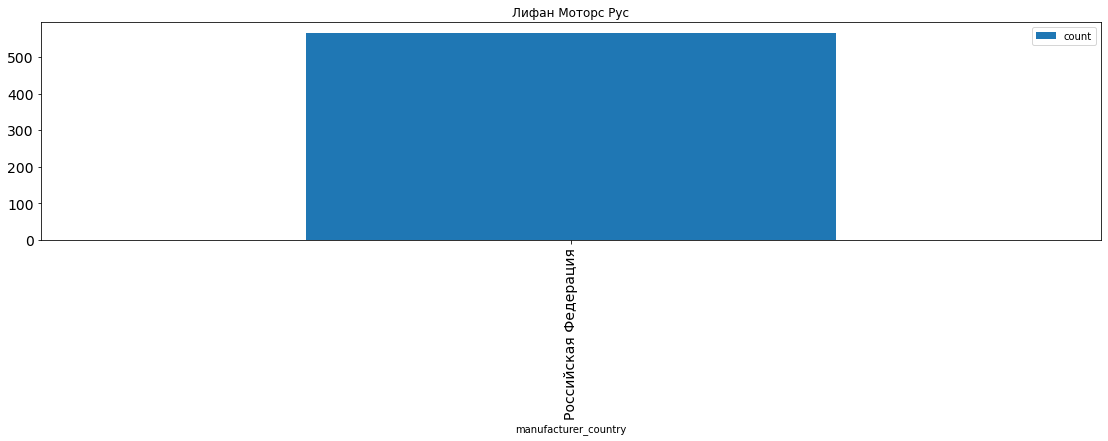

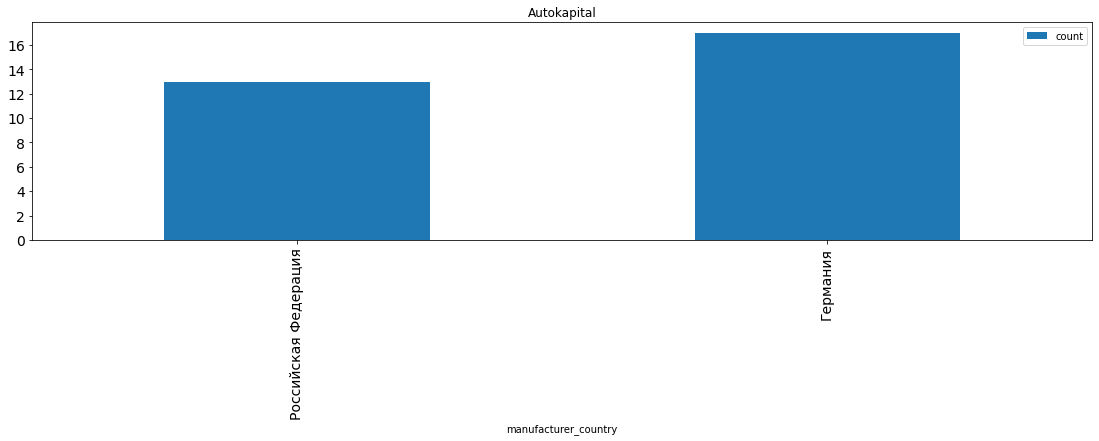

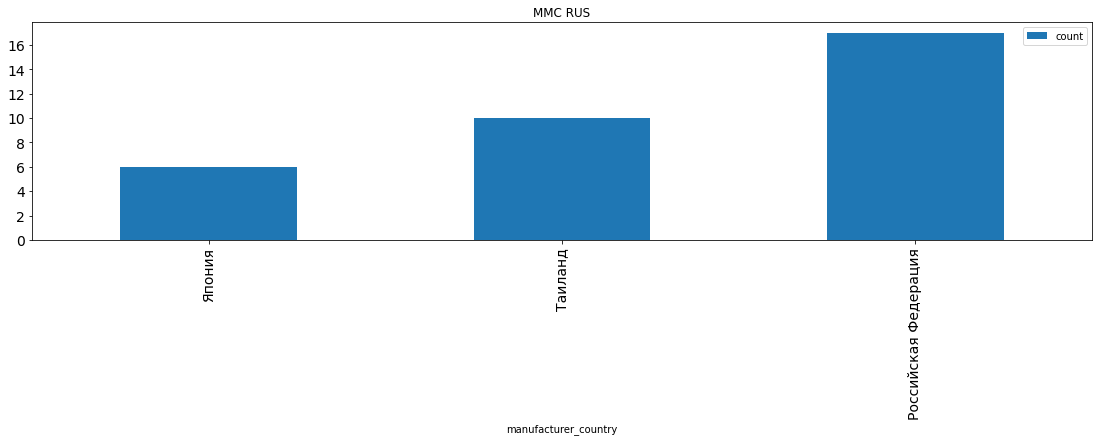

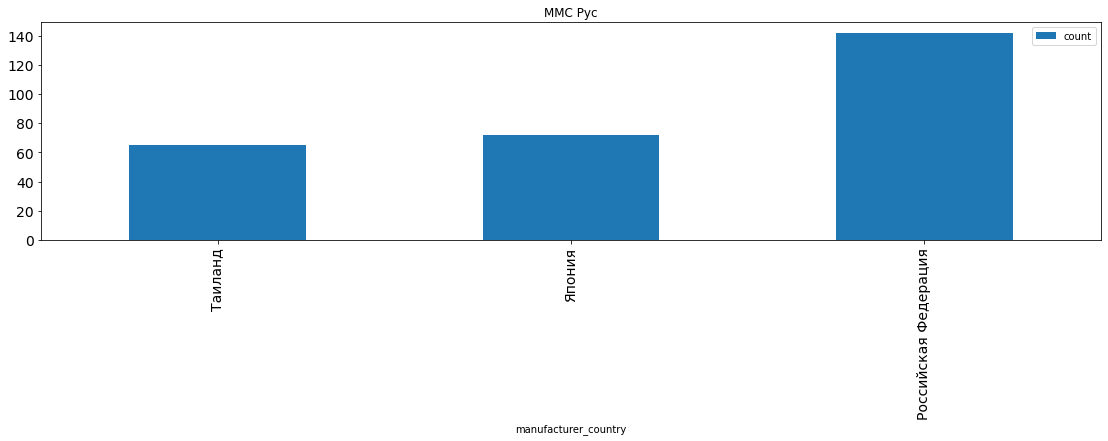

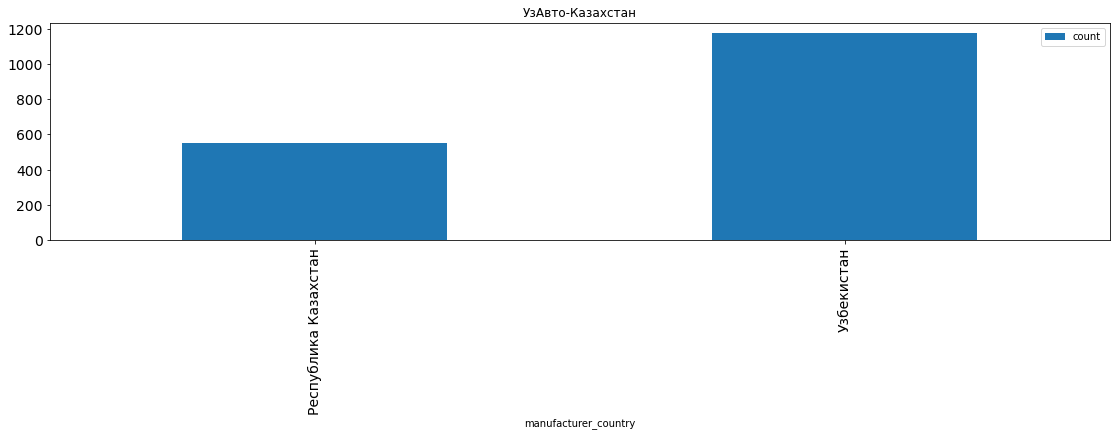

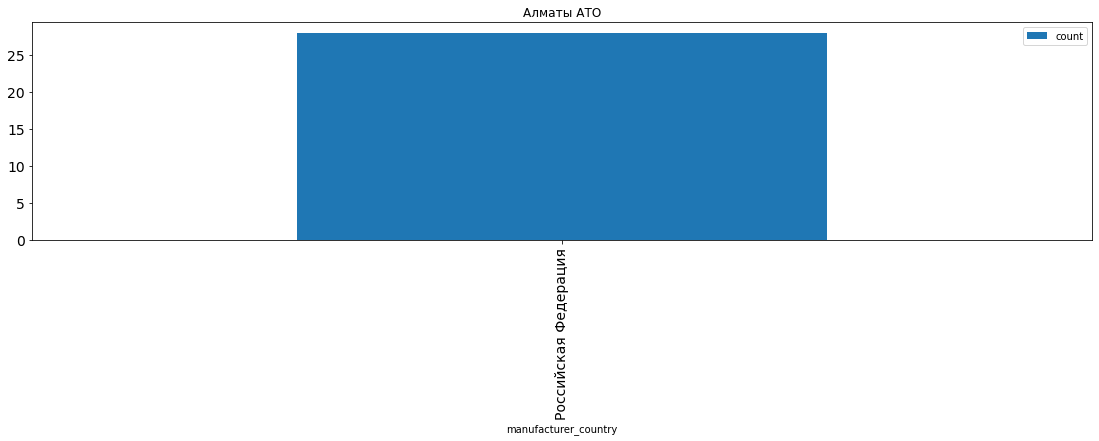

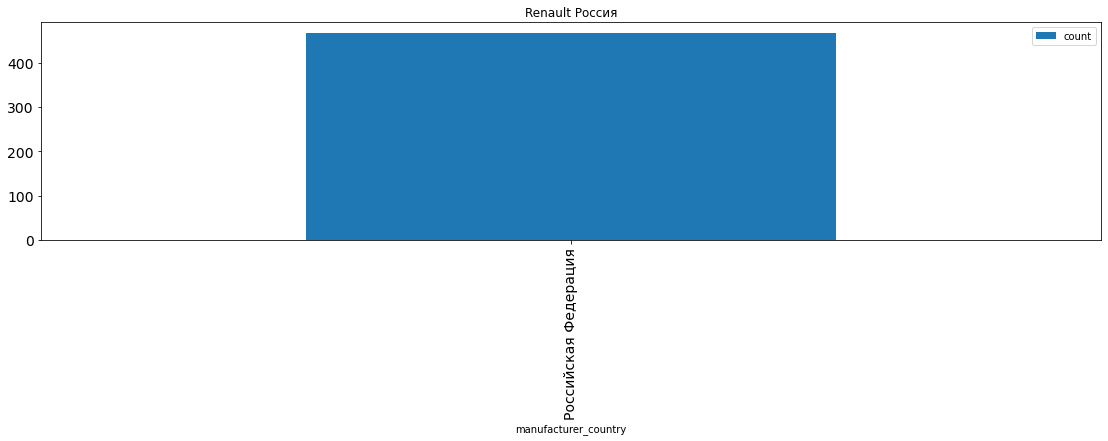

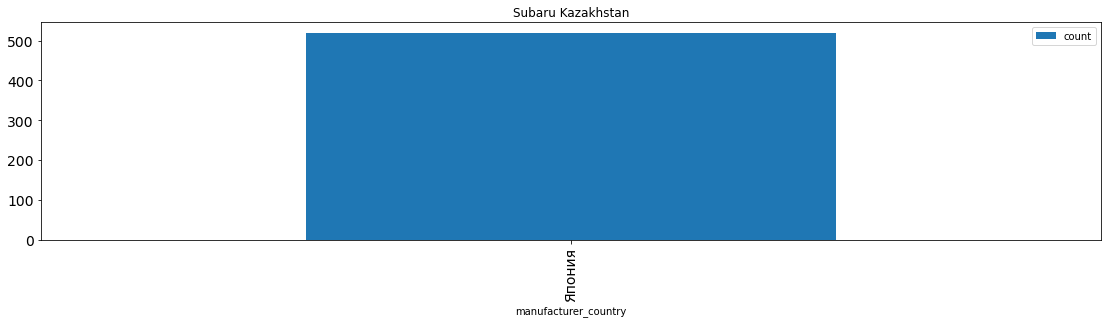

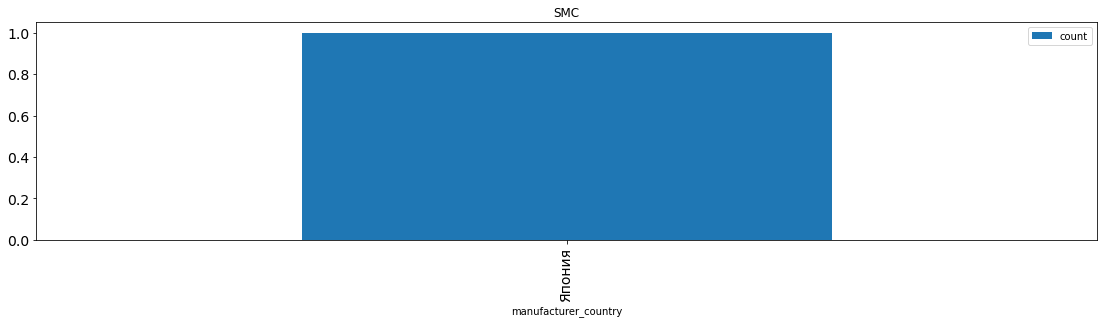

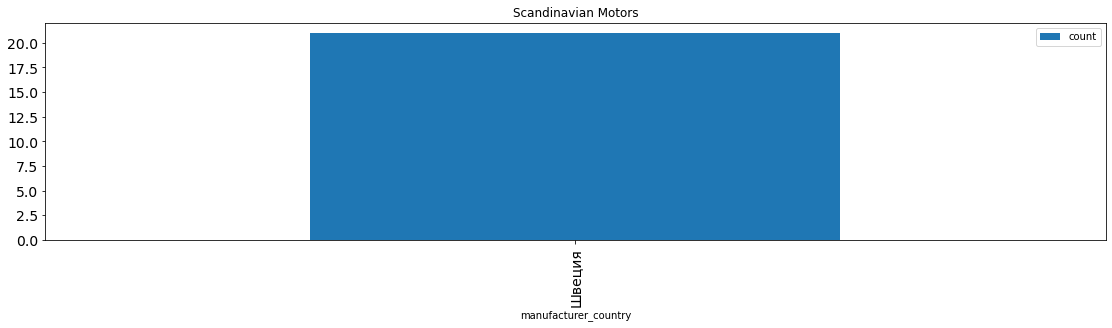

In [136]:
for i in df['company'].unique():
    df[df['company'] == i].groupby(['manufacturer_country'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='manufacturer_country',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Вывод:<br>
    в компаниях в основном представлены:
- БИПЭК АВТО (Россия, Казахстан), 
- Toyota Motor Kazakhstan (Россия, Япония), 
- Astana Motors (Казахстан), 
- Вираж (Россия, Казахстан),
- Eurasia Motor Premium (США, Белоруссия), 
- Sivi Finance Consulting (Белоруссия),
- УАЗавто Казахстан (Казахстан, Узбекистан),
- Renault Россия (Россия)
- SMC (Япония),
- jaguar Land Rover (Великобритания).<br>
Из данных можно сделать выводы:
- у лидеров в основном автомобили: Россия, Япония и Казахстан
- меньше всего представлена Великобритания.

#### автомобили каких брендов представлены в автосалоне

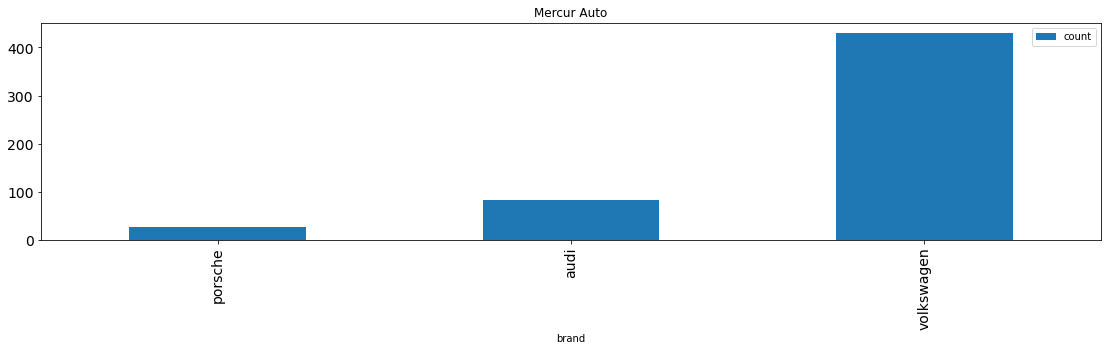

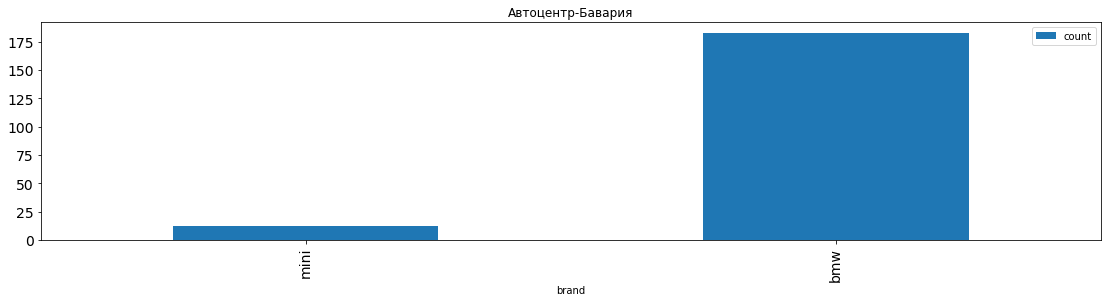

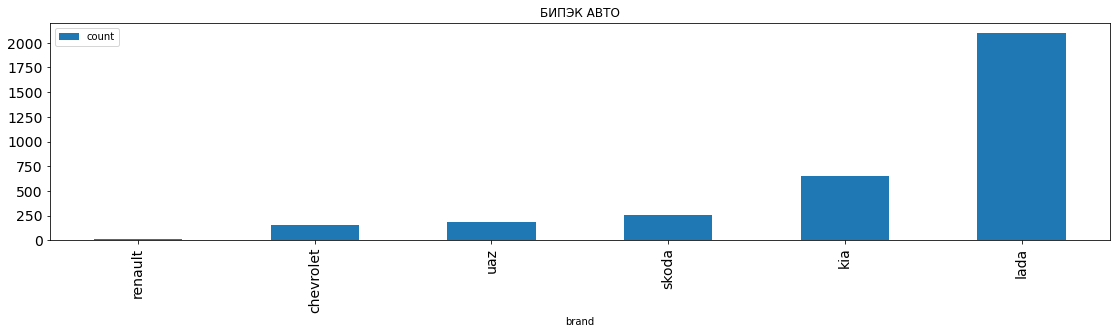

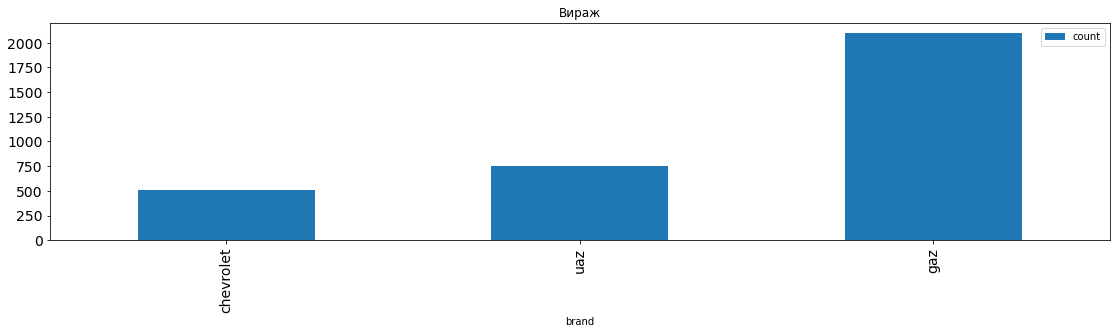

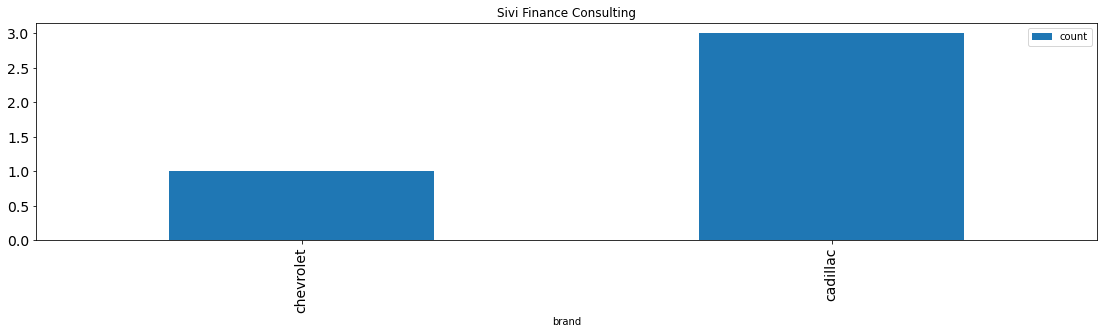

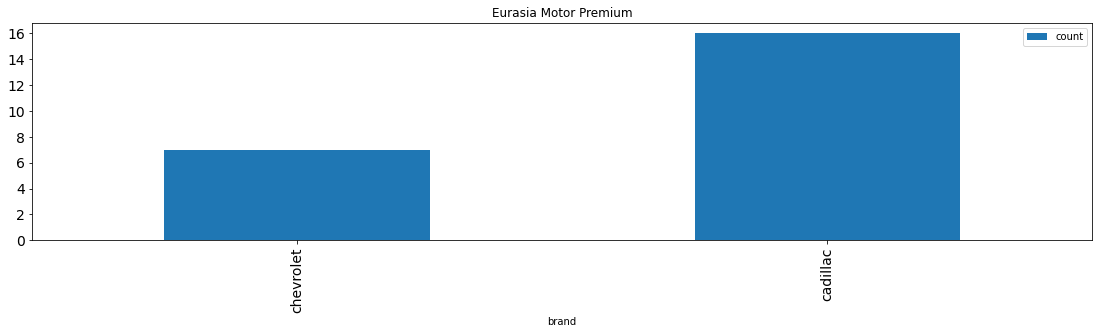

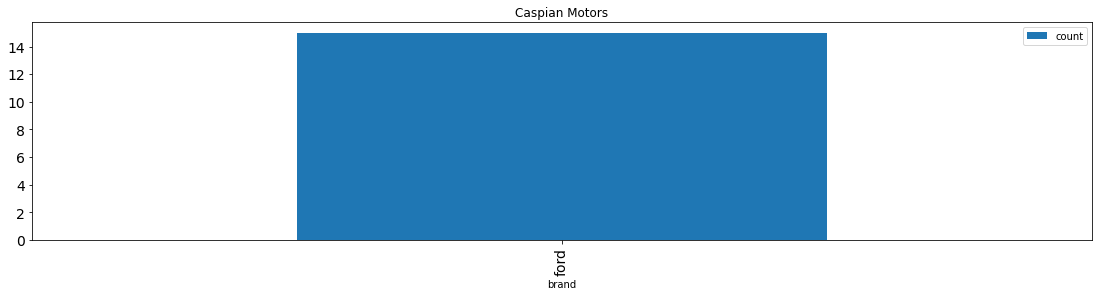

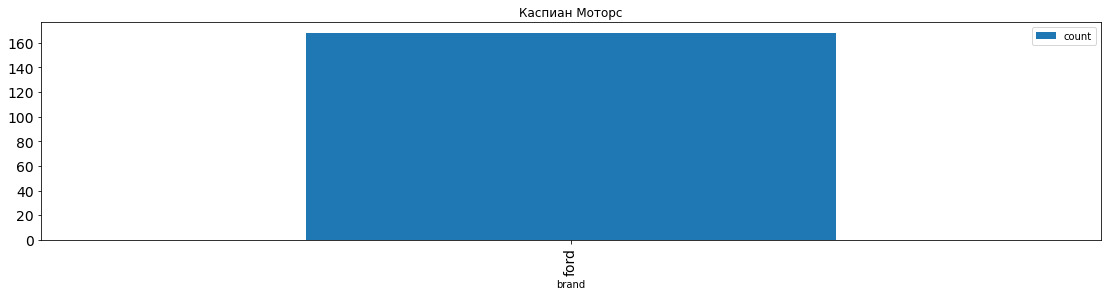

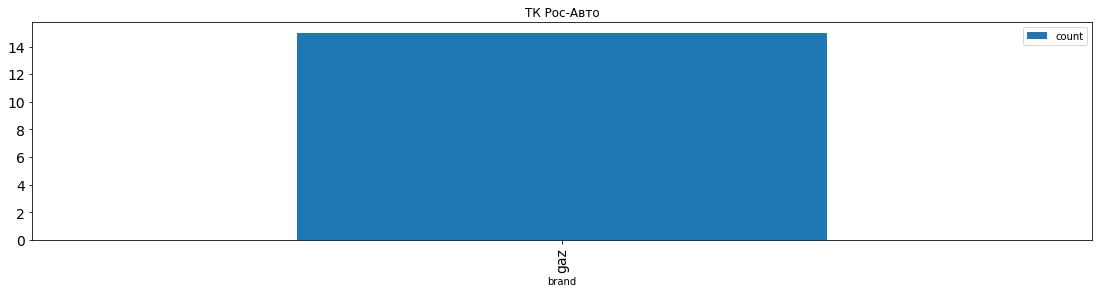

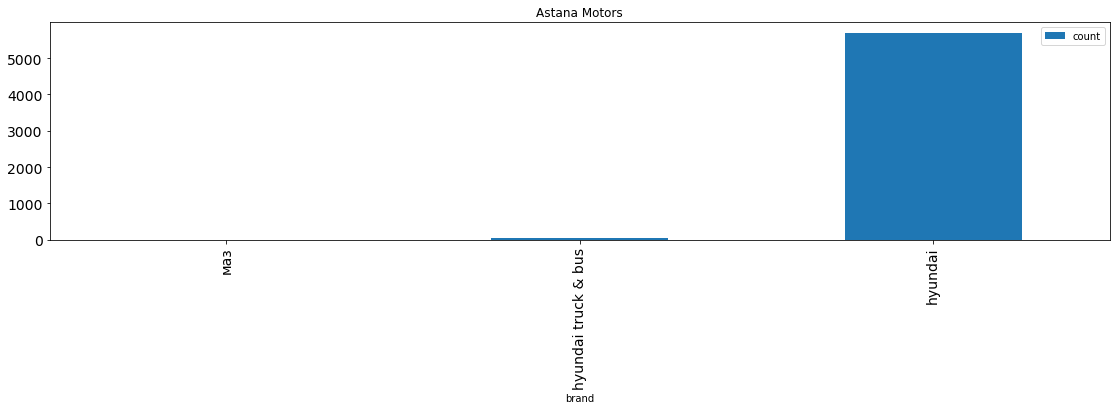

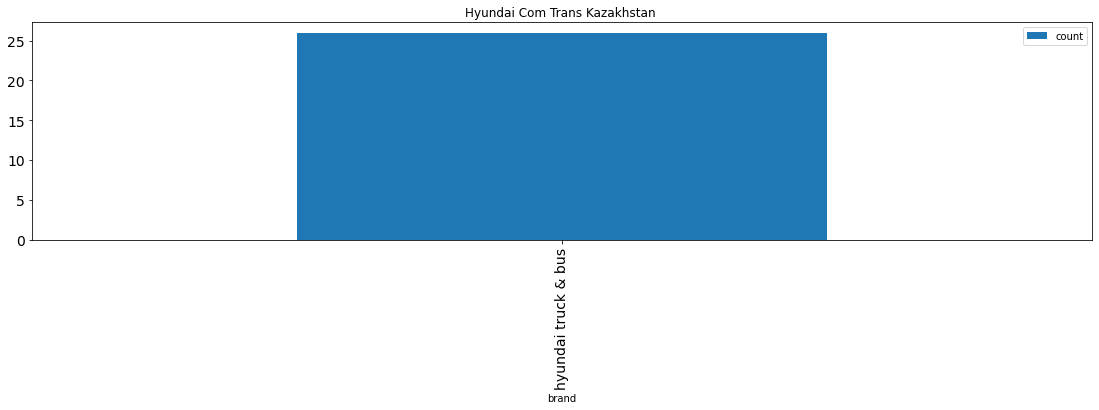

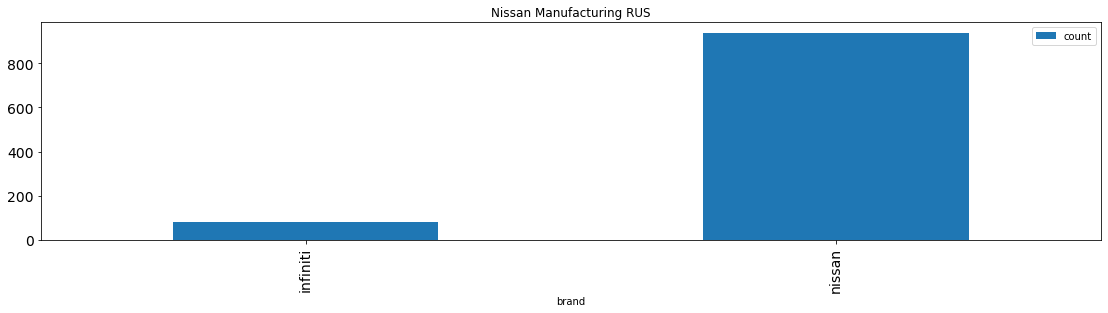

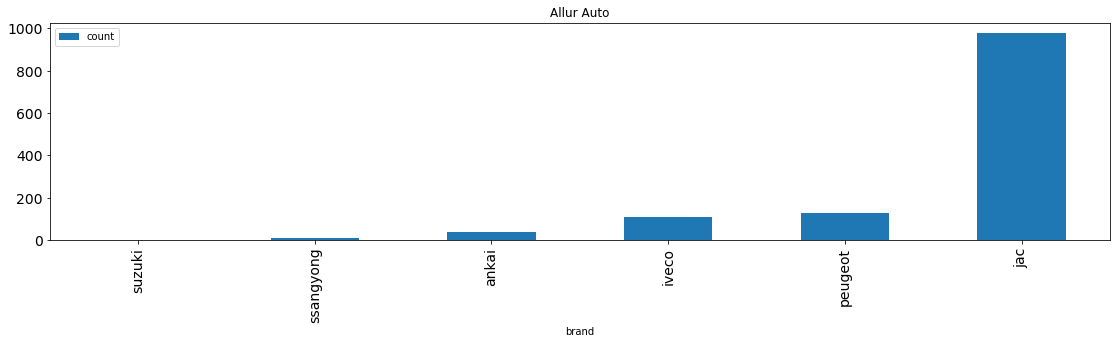

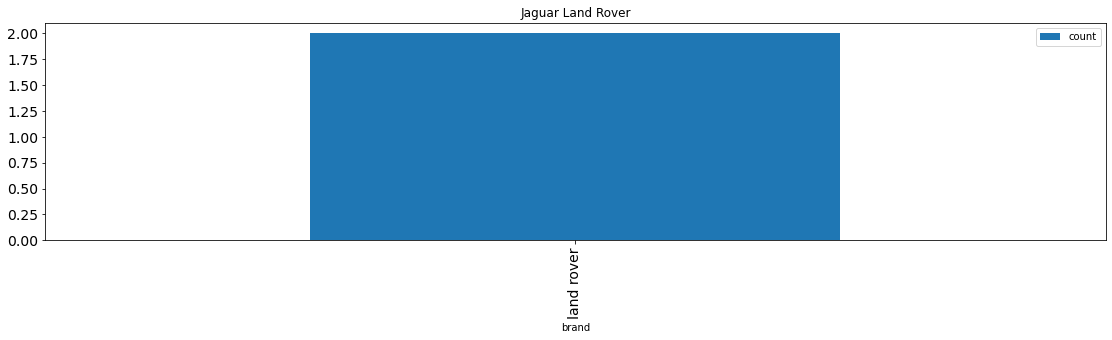

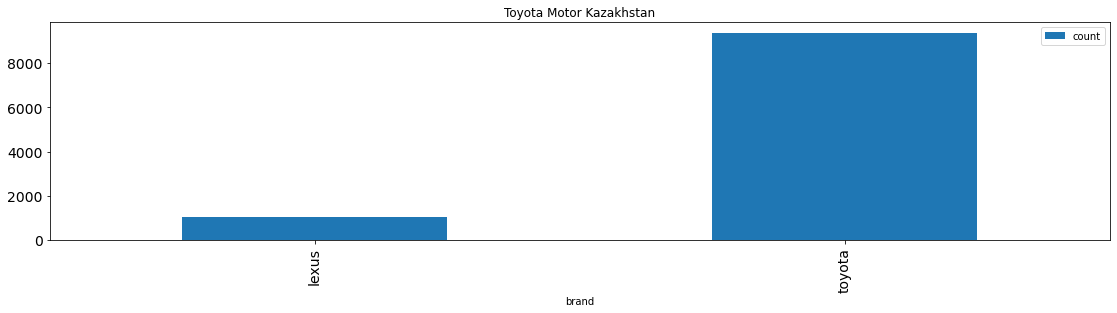

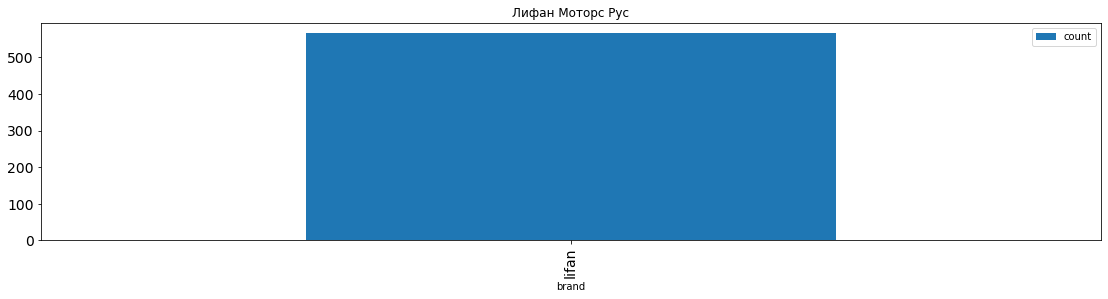

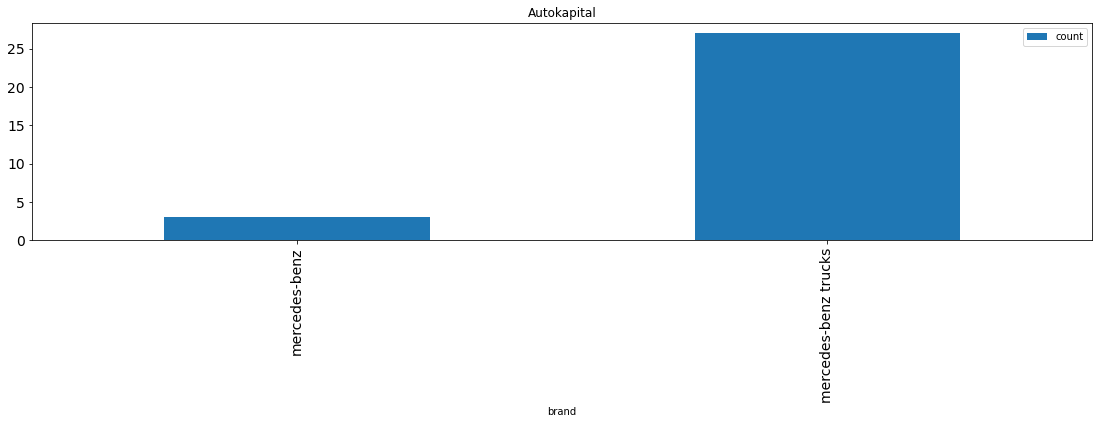

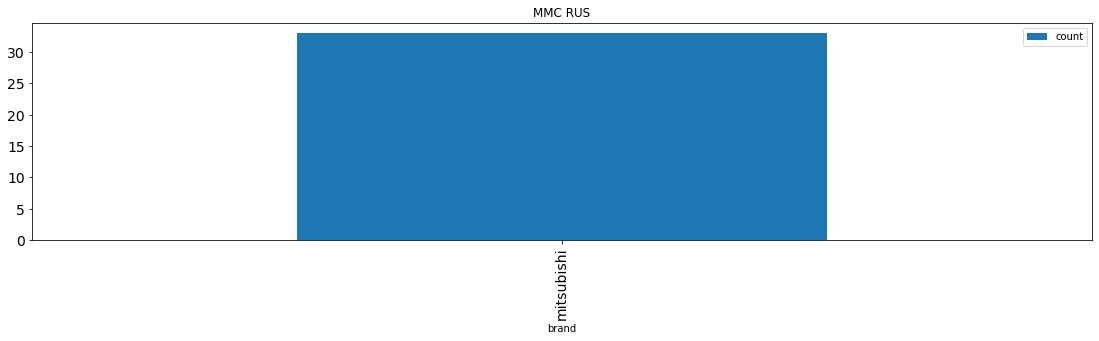

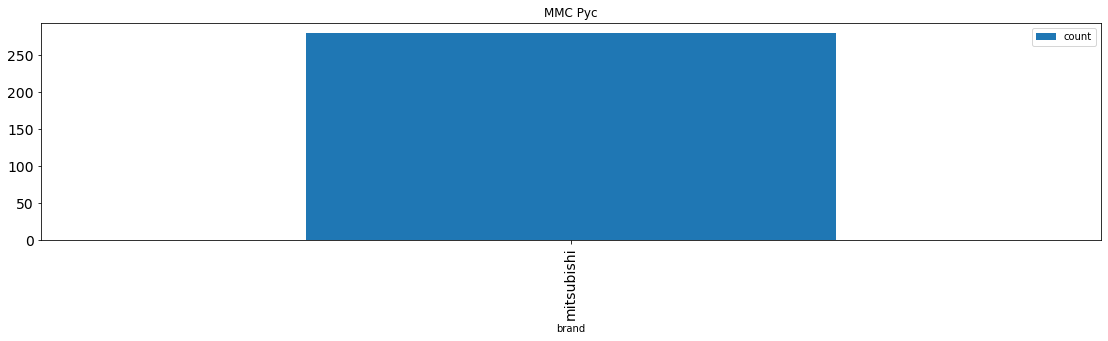

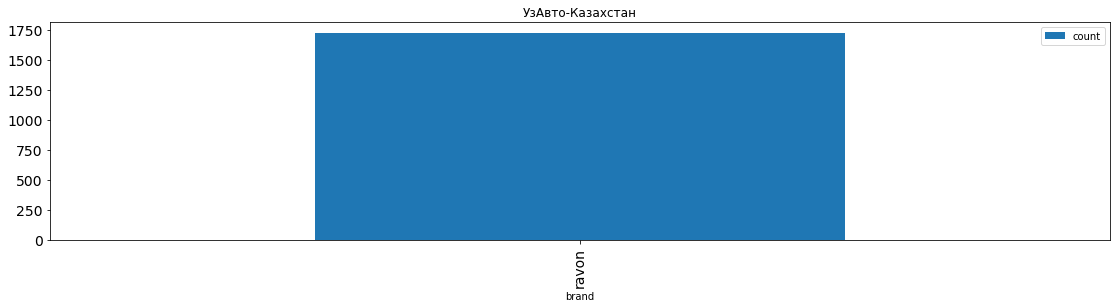

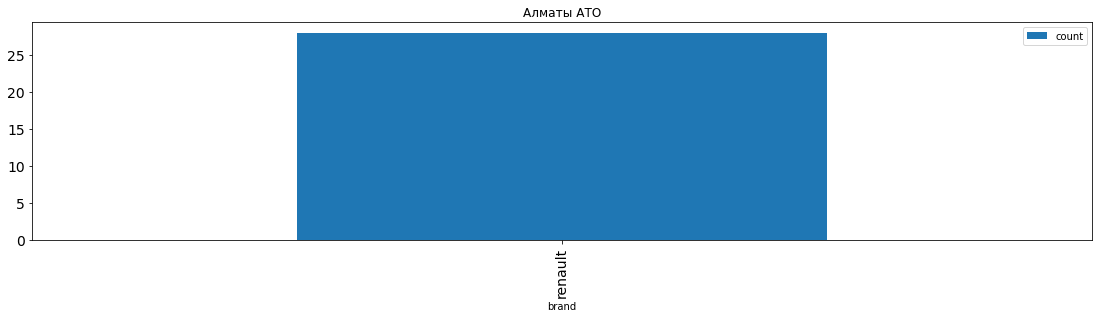

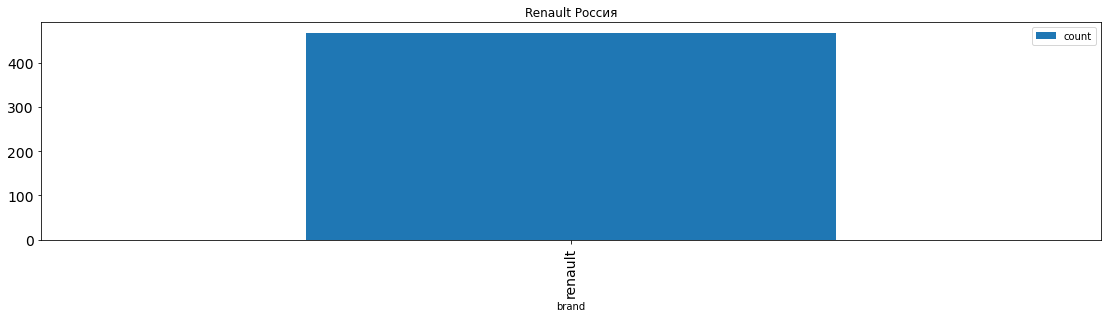

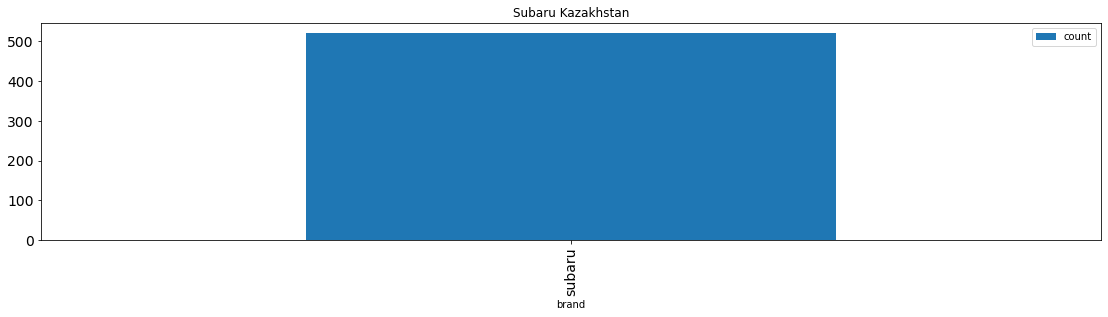

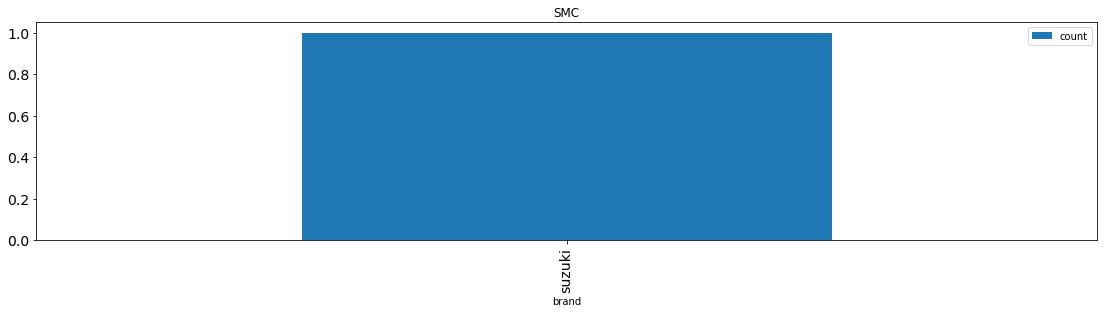

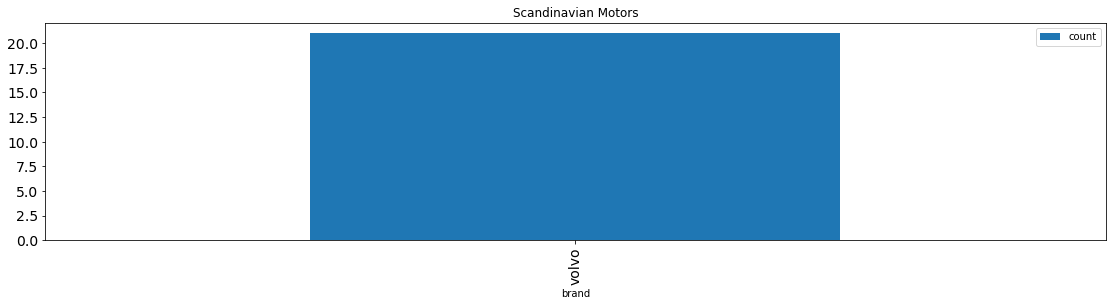

In [137]:
for i in df['company'].unique():
    df[df['company'] == i].groupby(['brand'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='brand',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Вывод:<br>
    в компаниях в основном представлены:
- БИПЭК АВТО (Lada, kia), 
- Toyota Motor Kazakhstan (Toyota, lexus), 
- Astana Motors (hyndai), 
- Вираж (gaz, uaz, chevrolet),
- Eurasia Motor Premium (cadillac, chevrolet), 
- Sivi Finance Consulting (cadillac, chevrolet),
- УАЗавто Казахстан (ravon),
- Renault Россия (Renault)
- SMC (suzuki),
- jaguar Land Rover (Land Rover).<br>
Из данных можно сделать выводы:
- самые прибыльные это cadillac, chevrolet,
- меньше всего приносят деньги ravon, Renault,
- чаще всего продают Toyota,
- реже всего Land Rover.

#### компании по регионам

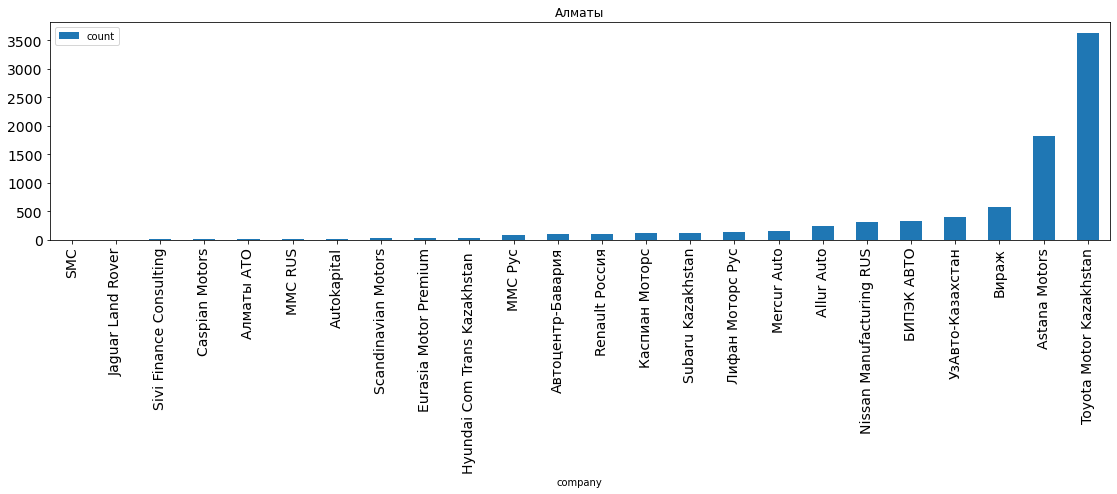

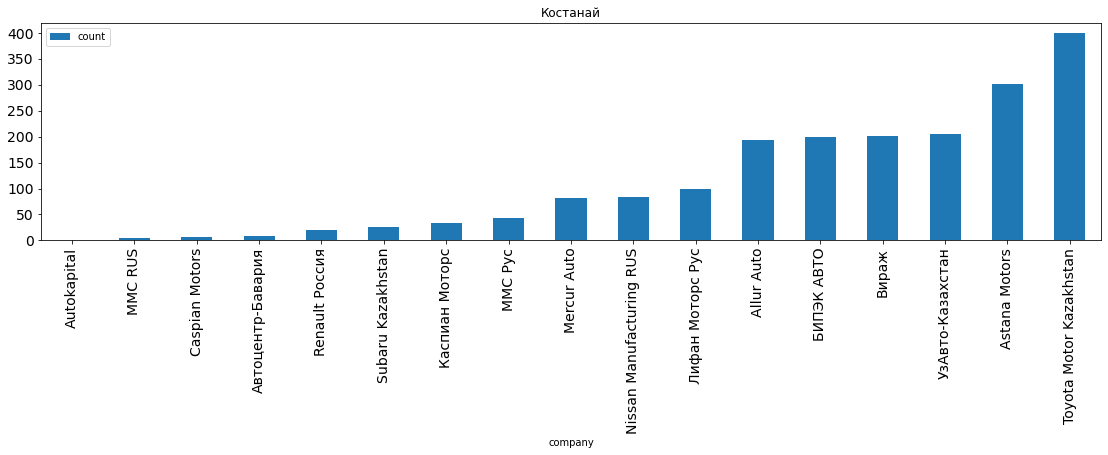

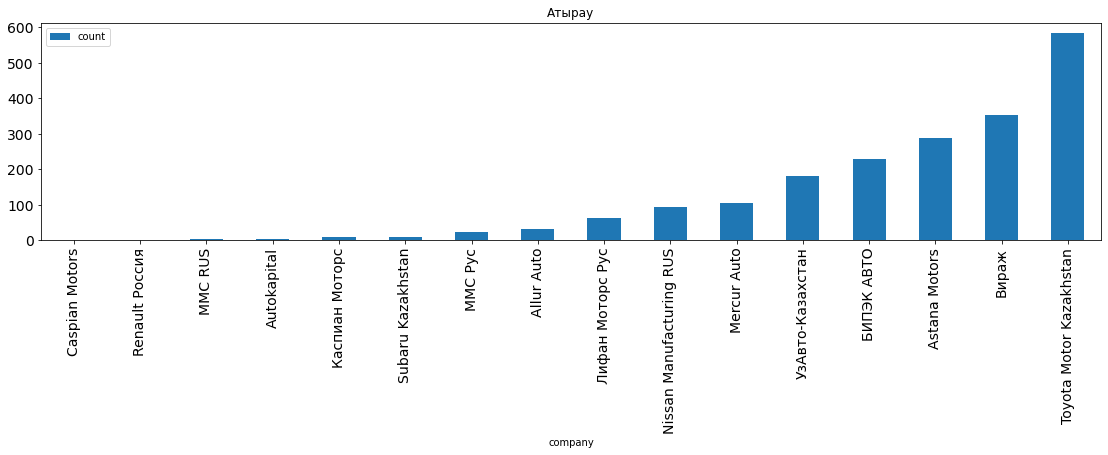

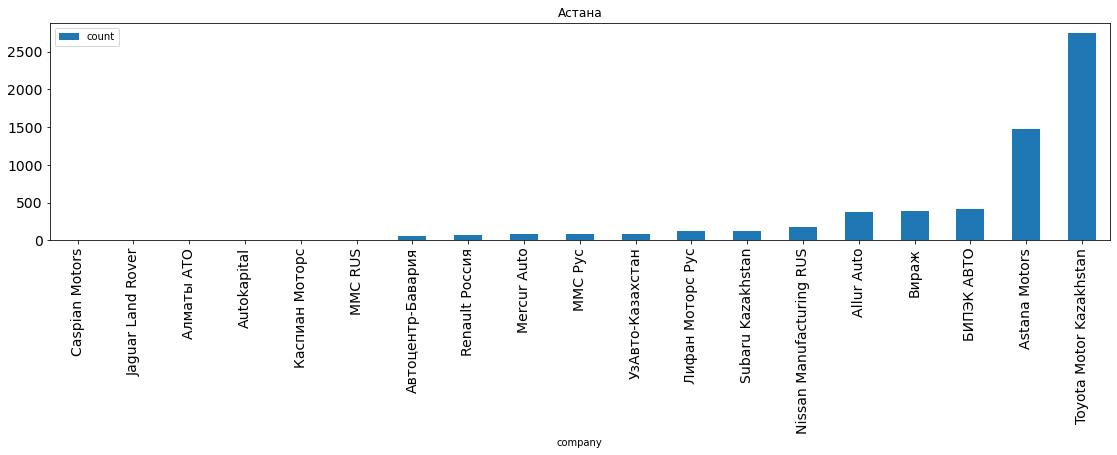

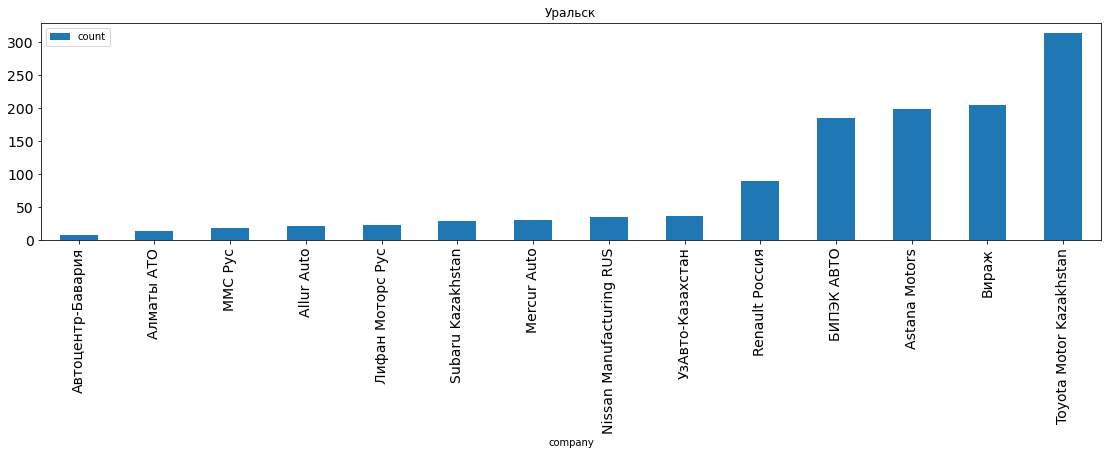

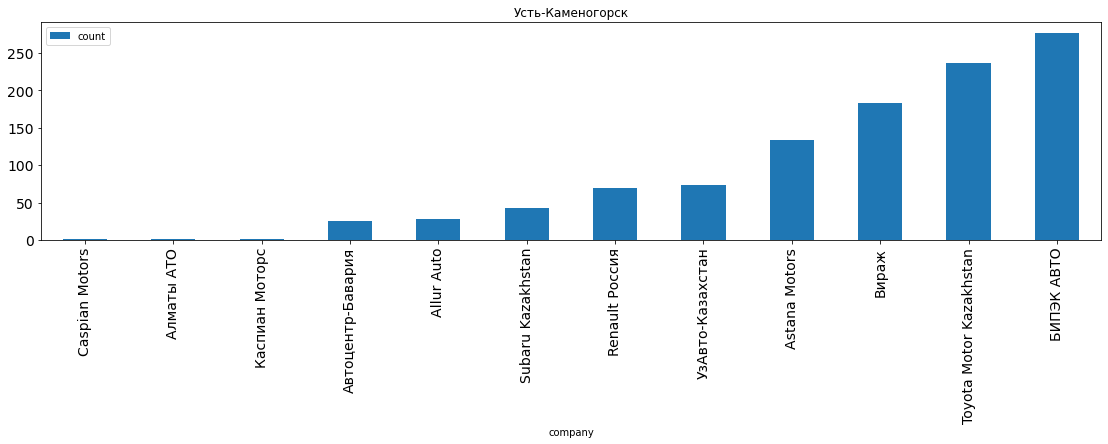

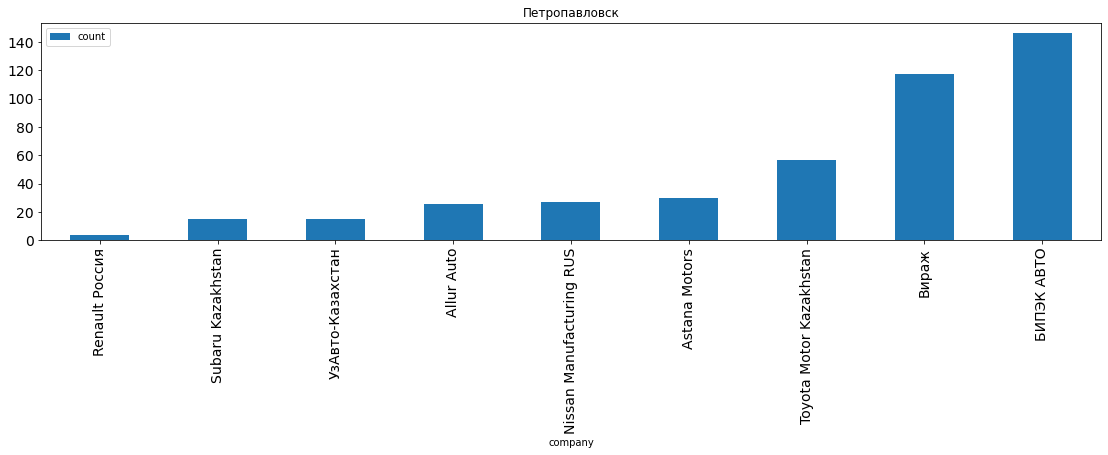

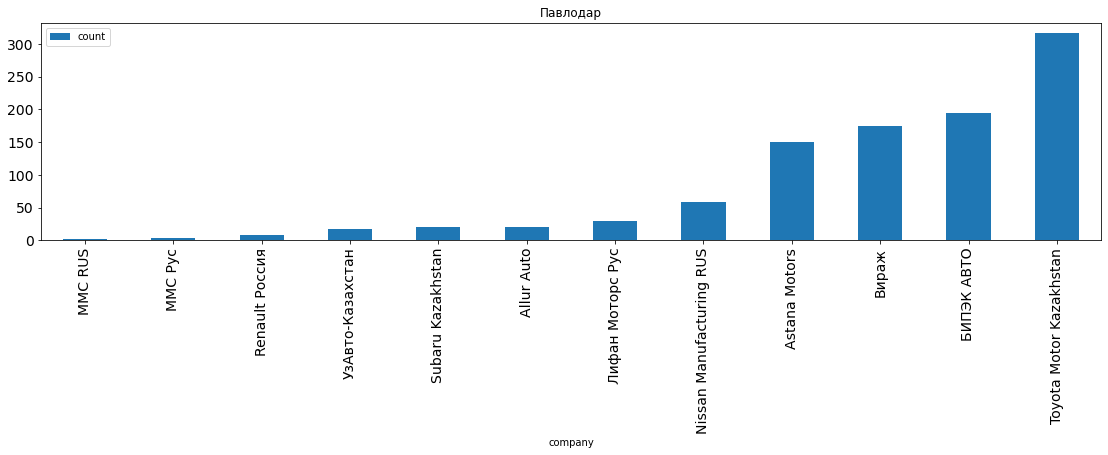

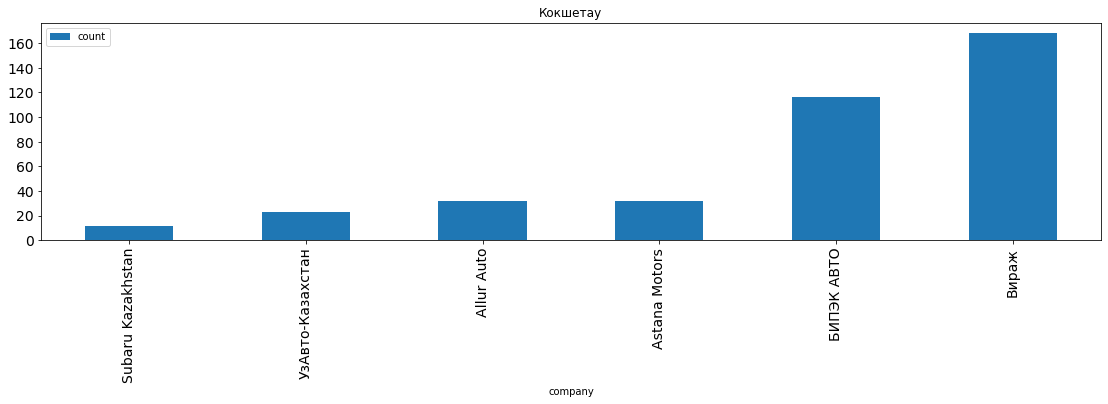

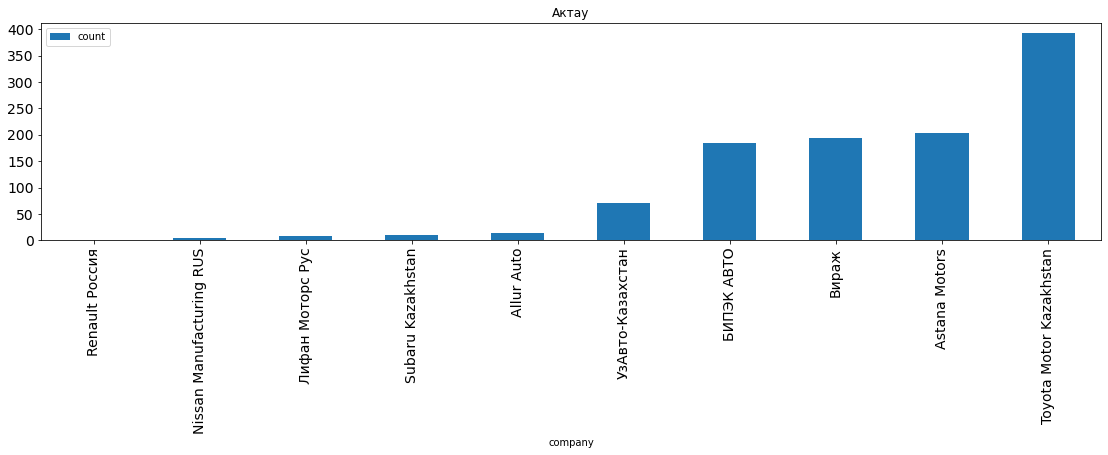

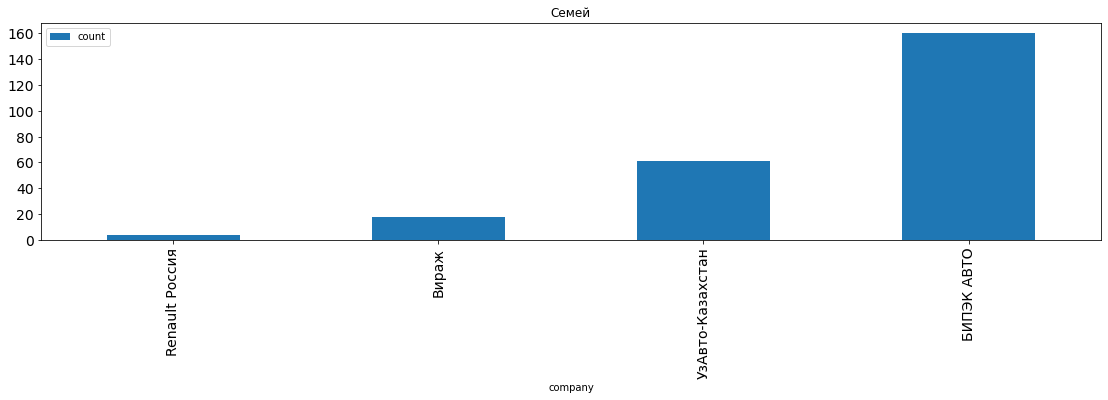

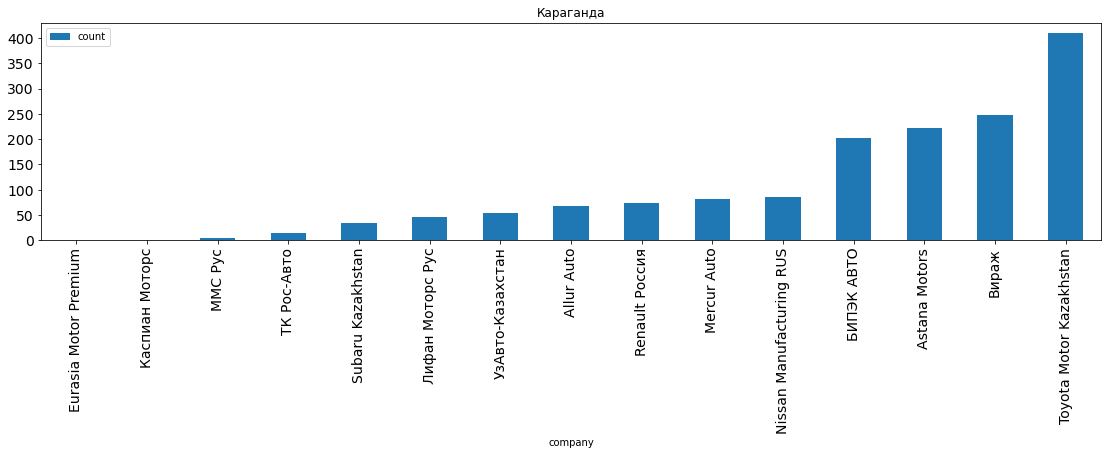

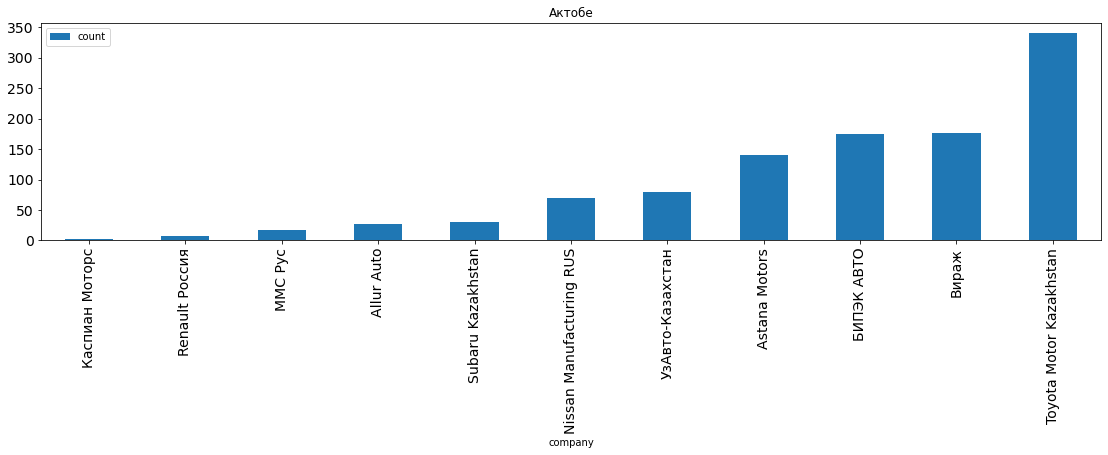

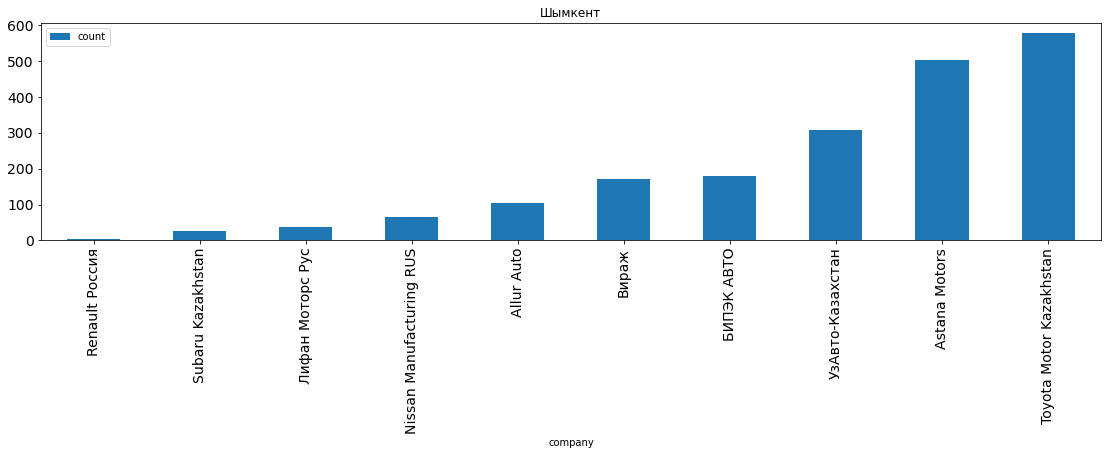

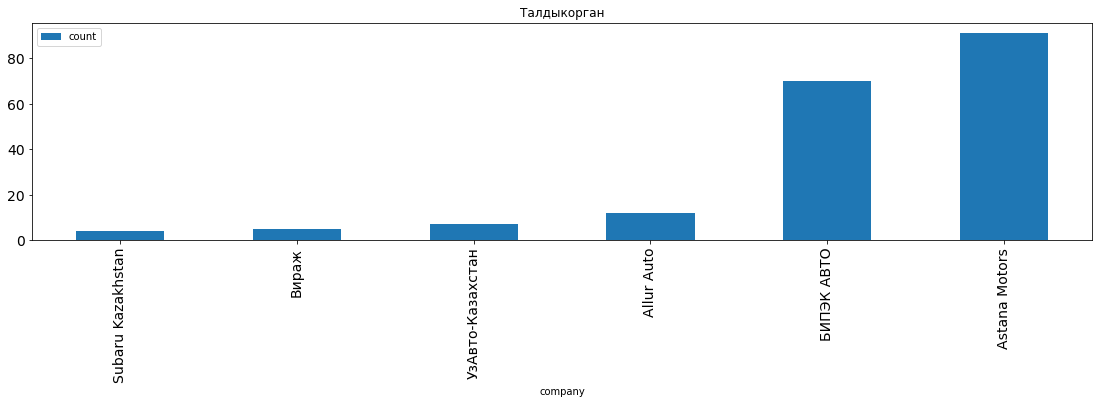

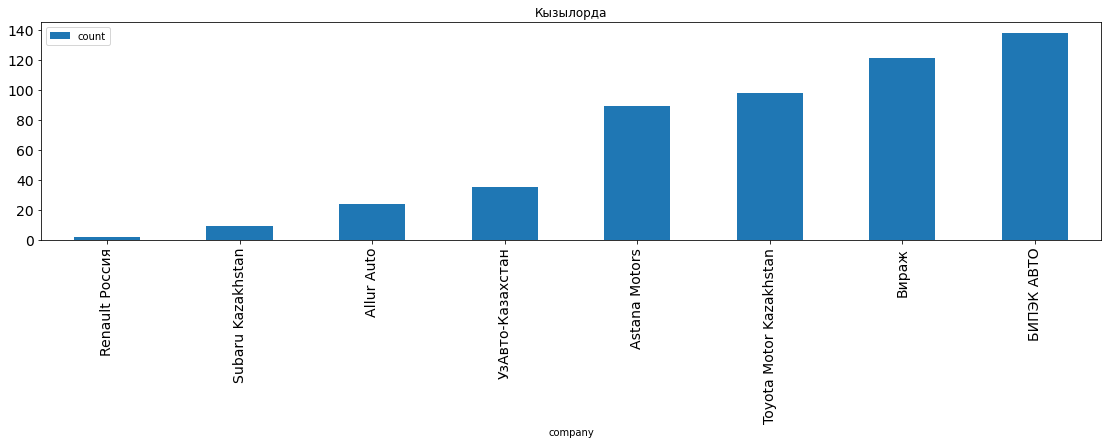

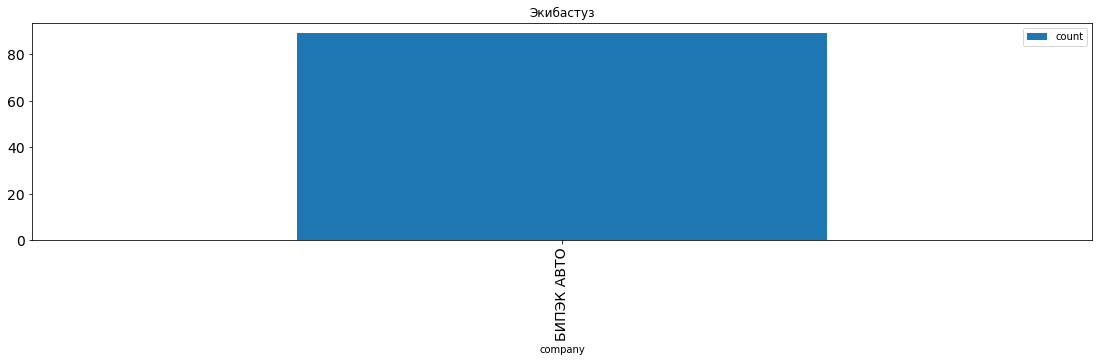

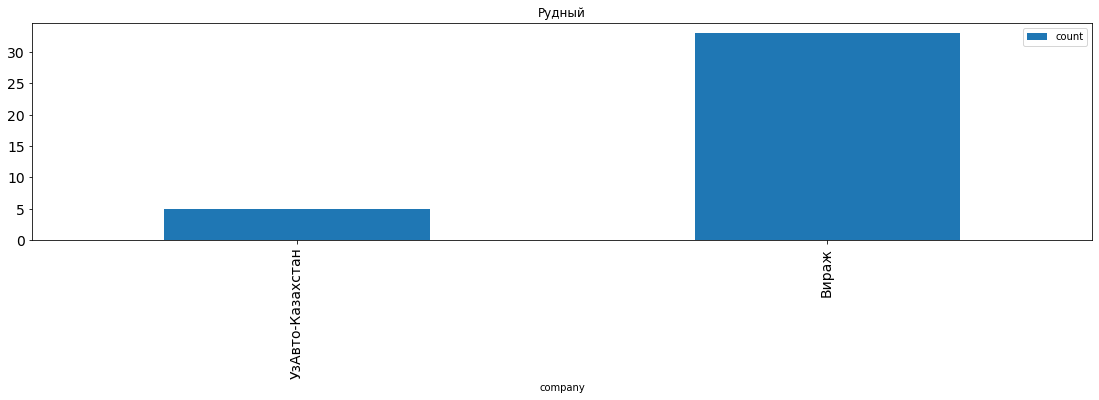

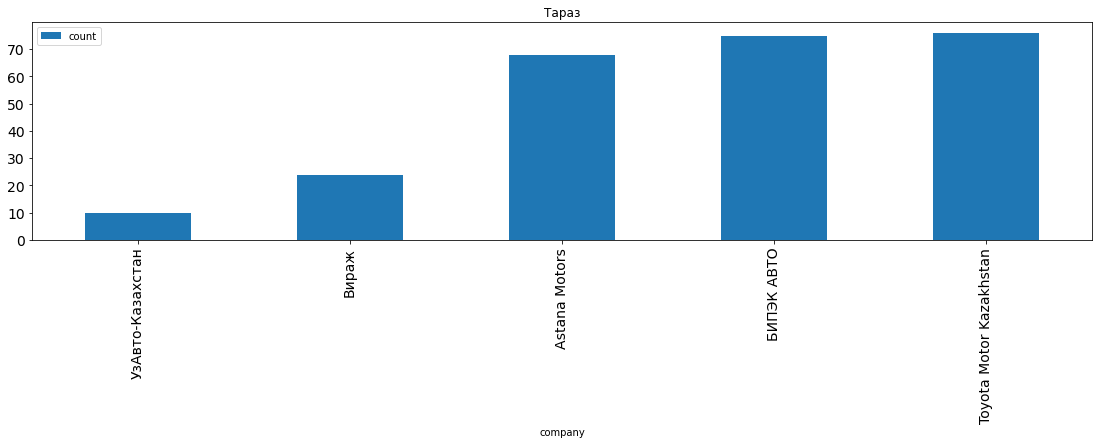

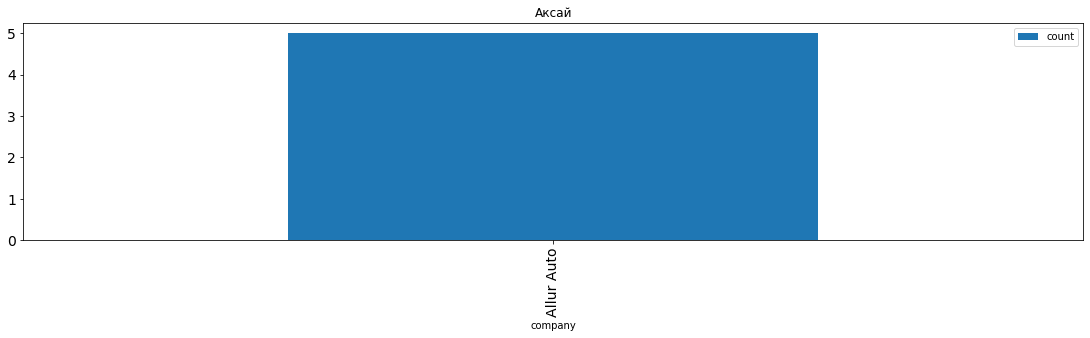

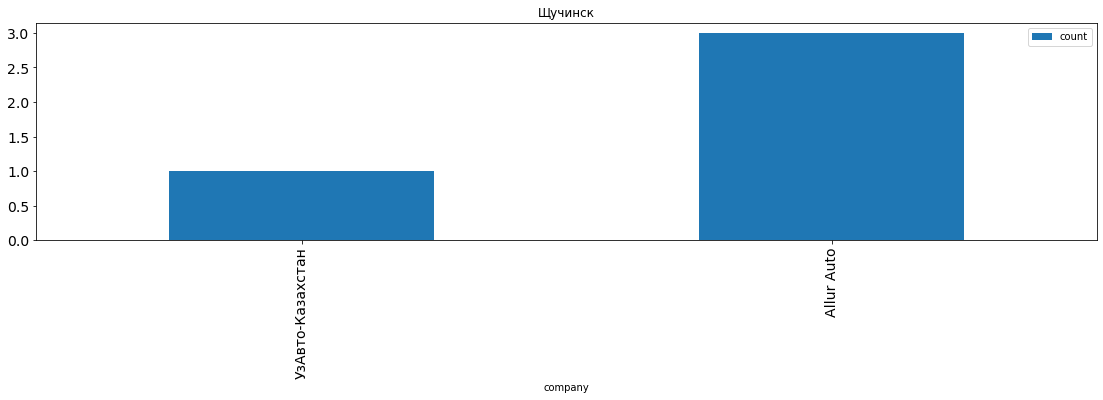

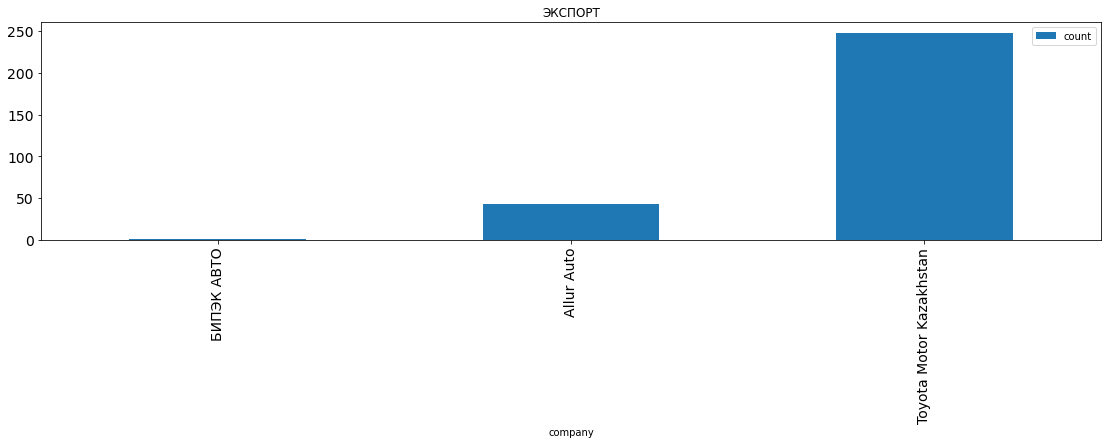

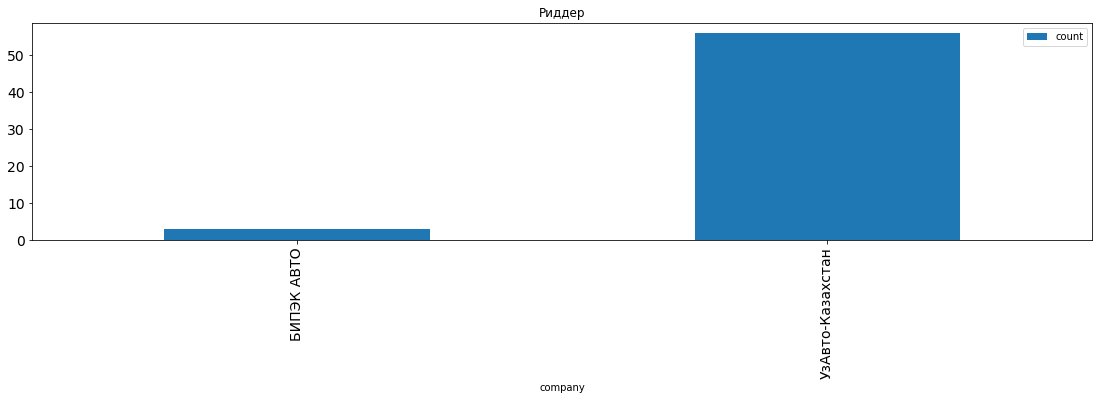

In [138]:
for i in df['region'].unique():
    df[df['region'] == i].groupby(['company'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='company',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Вывод: из полученных данных видно, что по регионам остаются теже самые компании в лидерах, так и в антилидирах. Стоит отметить компании в антилидерах меняются т.к. они представлены в малом кол-ве регионов регионах.

#### какие типы коробок передач представлены по автосалонам

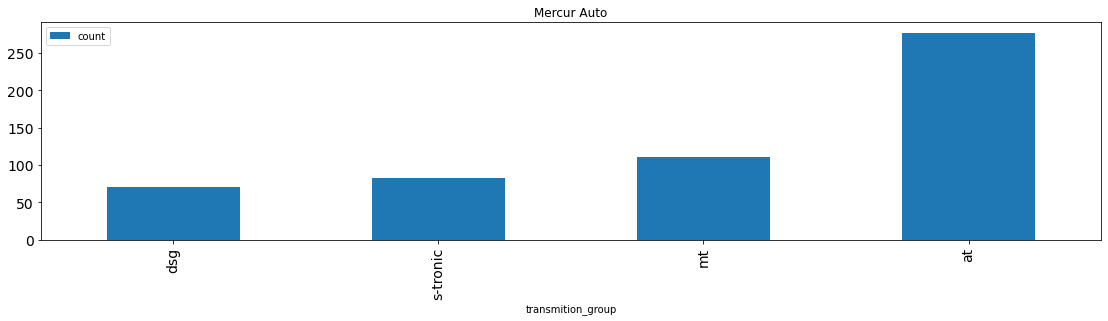

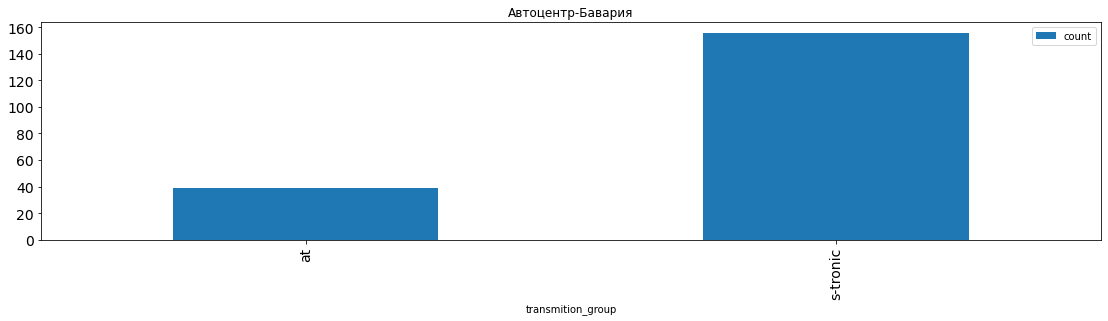

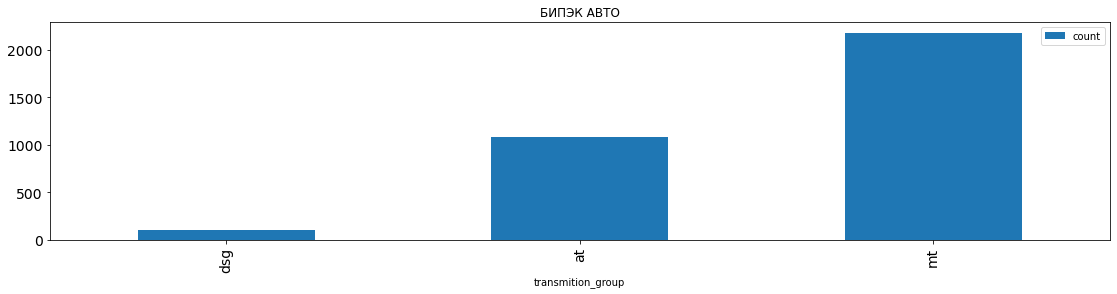

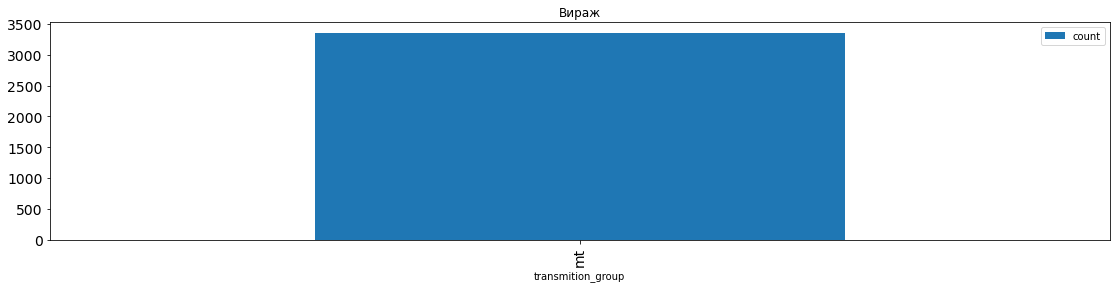

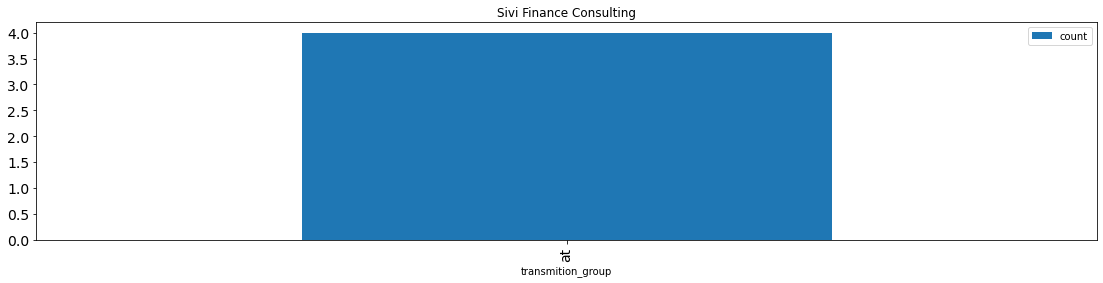

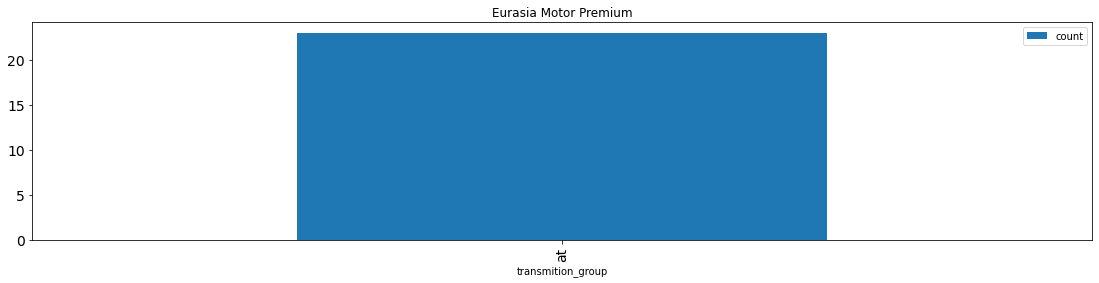

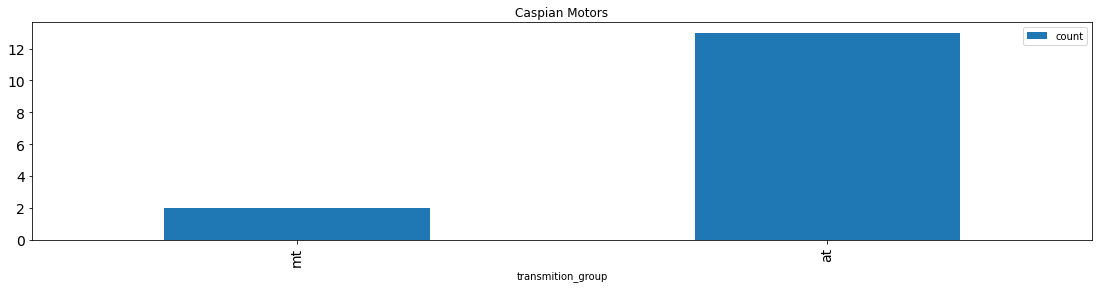

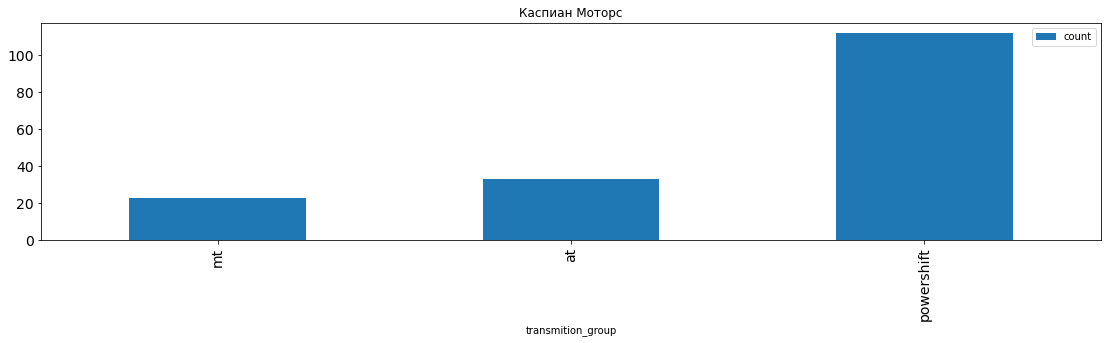

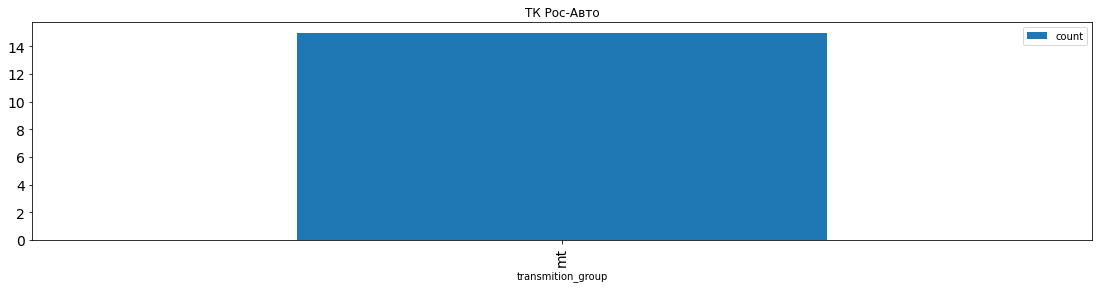

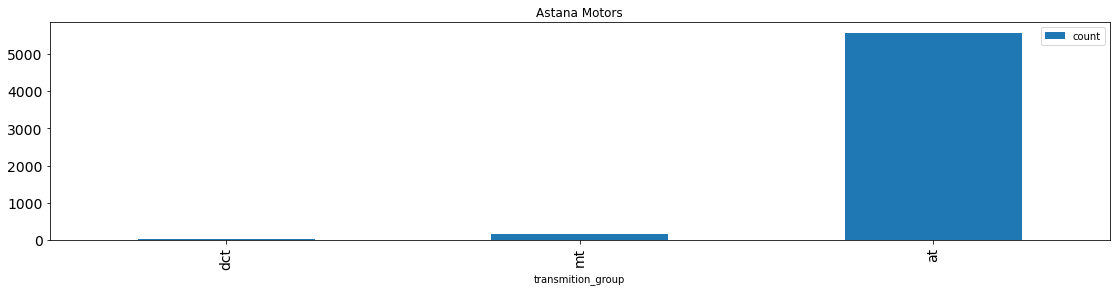

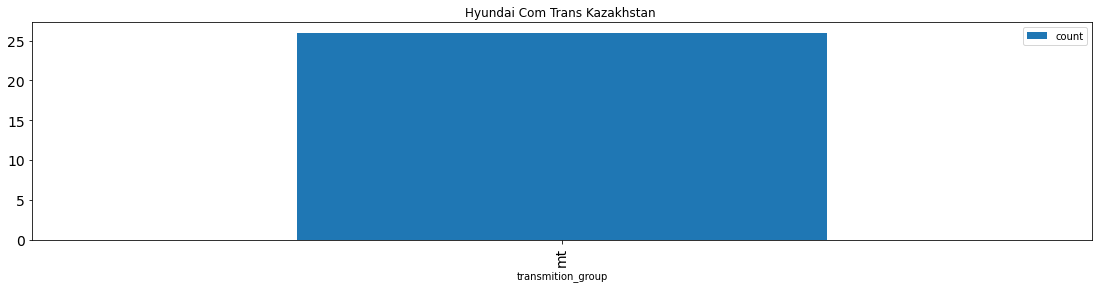

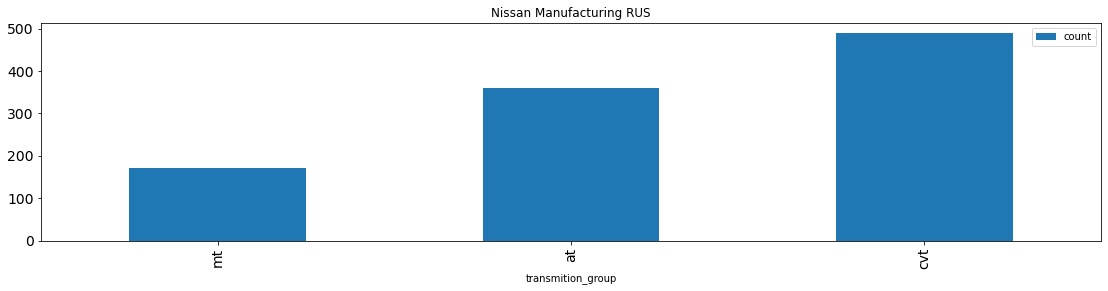

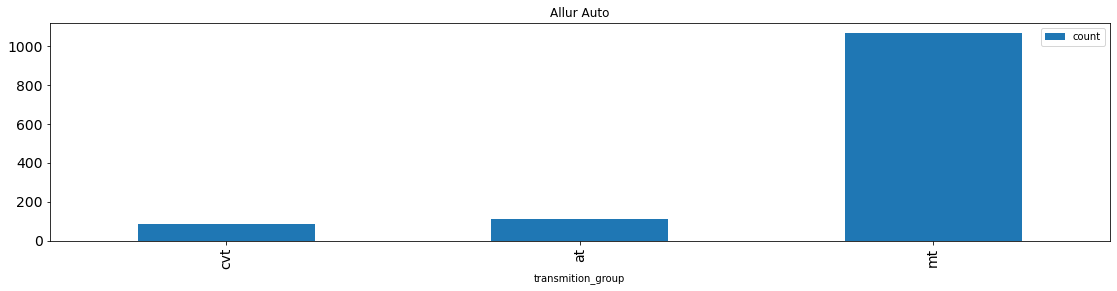

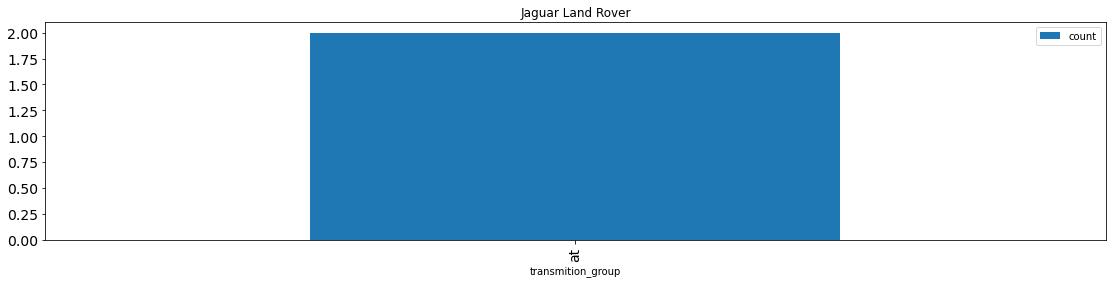

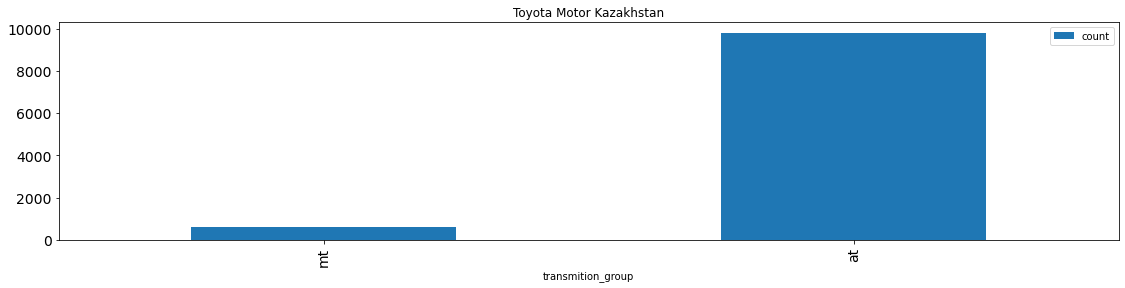

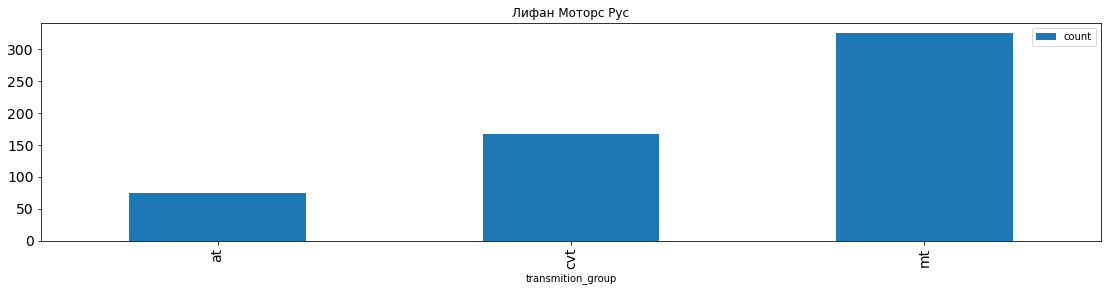

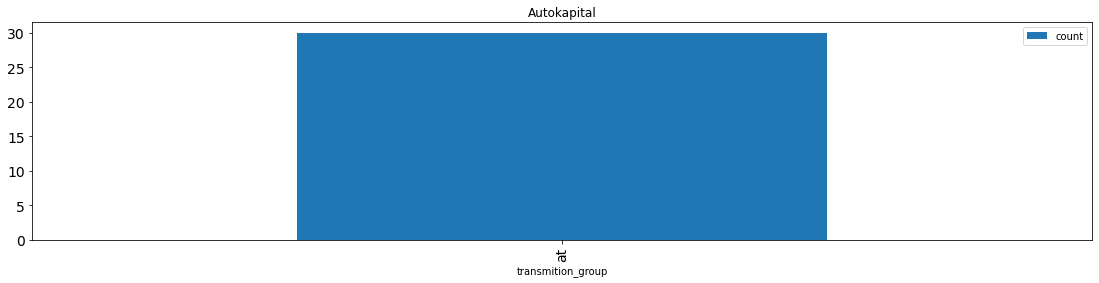

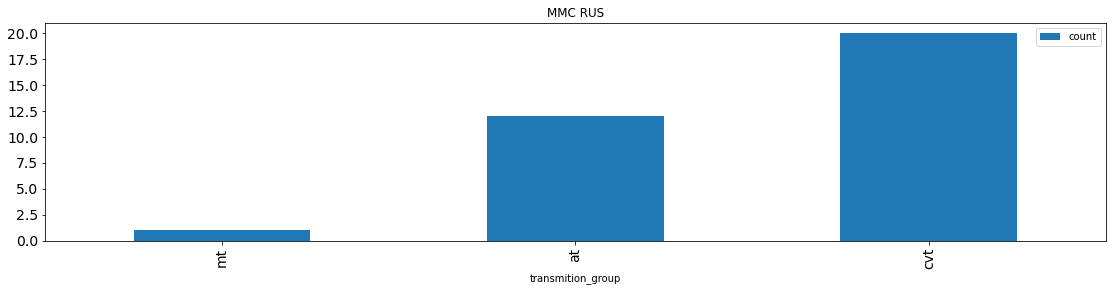

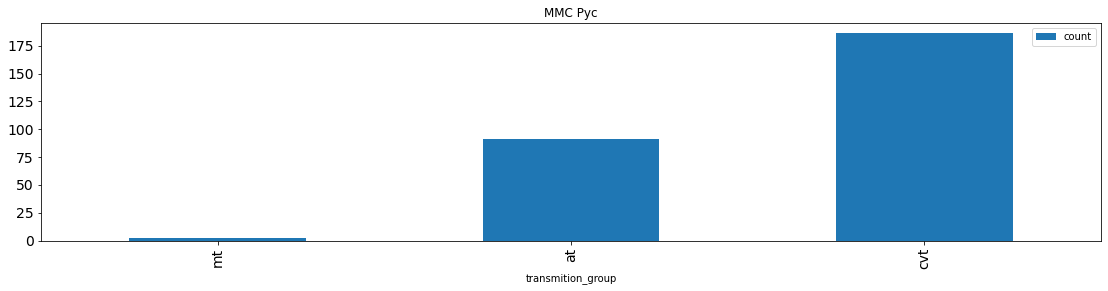

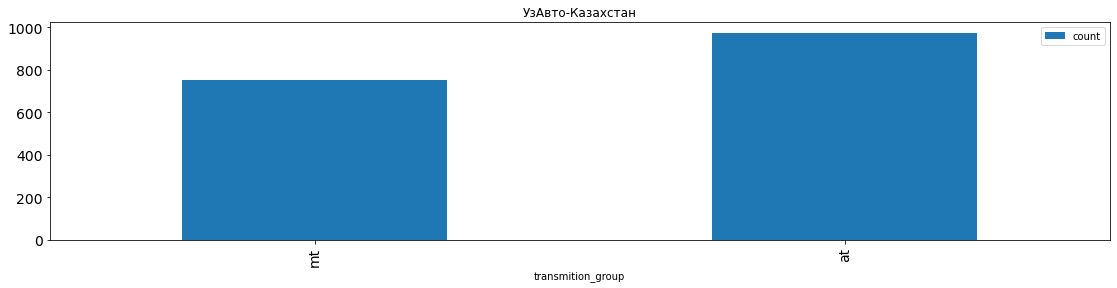

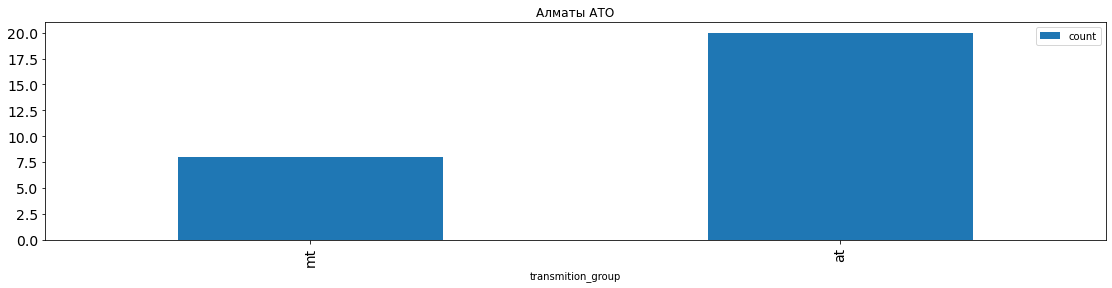

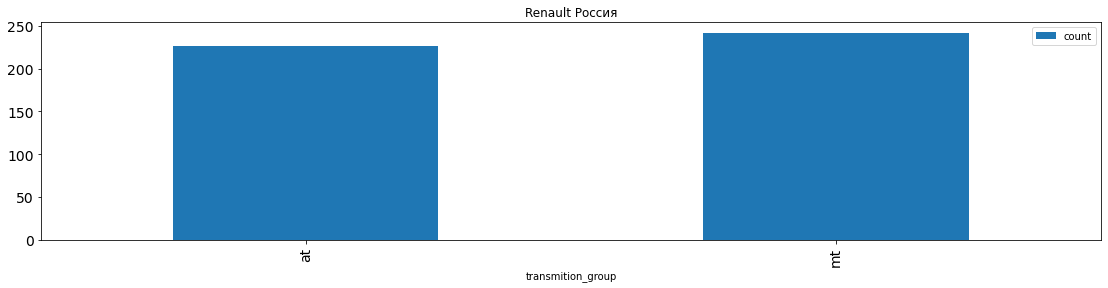

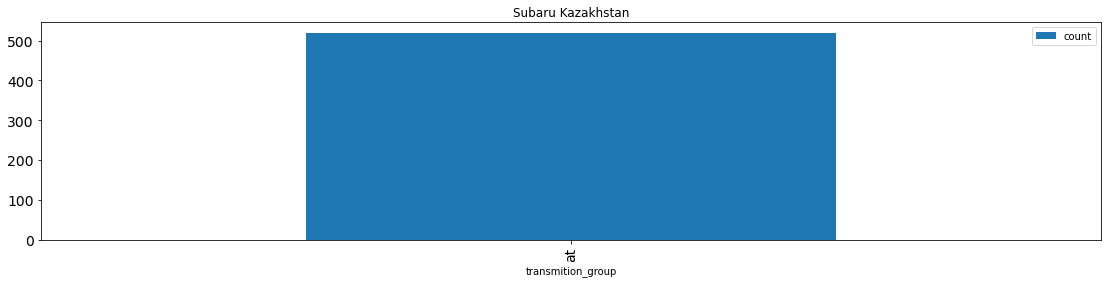

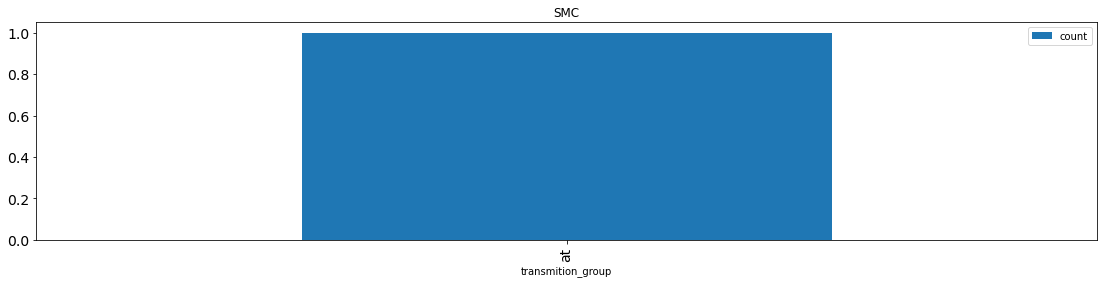

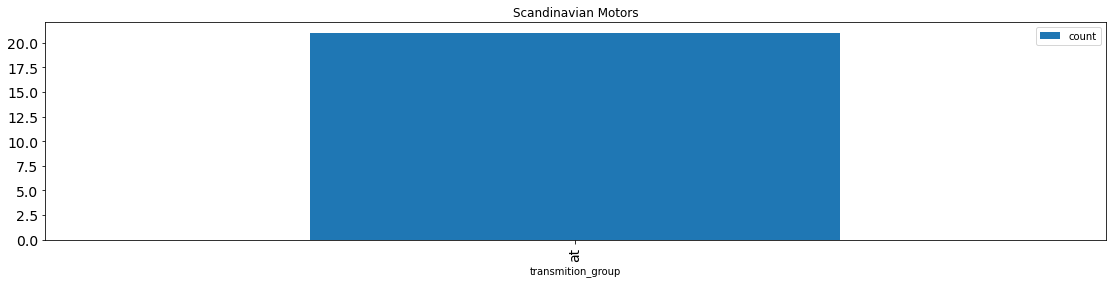

In [139]:
for i in df['company'].unique():
    df[df['company'] == i].groupby(['transmition_group'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='transmition_group',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Выводы:
- лидирующее место занимает коробка автомат
- на втором месте различные варианты вариаторов или с автоматическим сцеплением
- механика представлена не у все, но по некоторым маркам занимает лидирующее место. Данные бренды относятся к эконом сегменту.

#### какие типы приводов представлены по компаниям

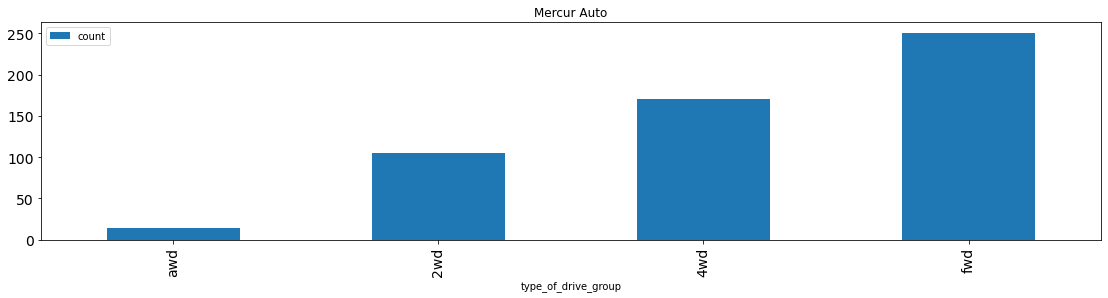

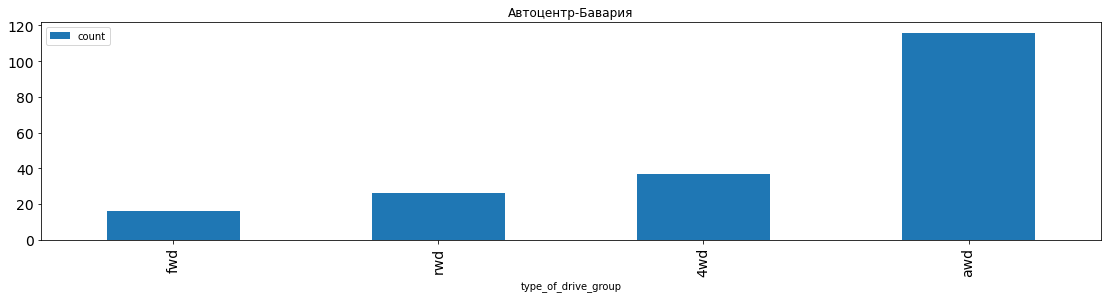

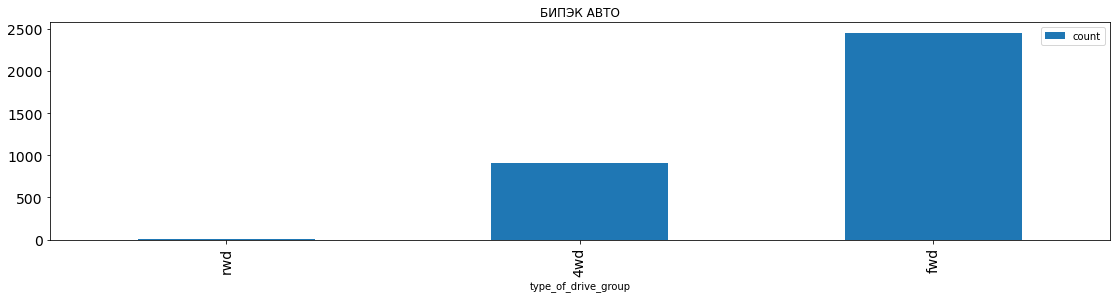

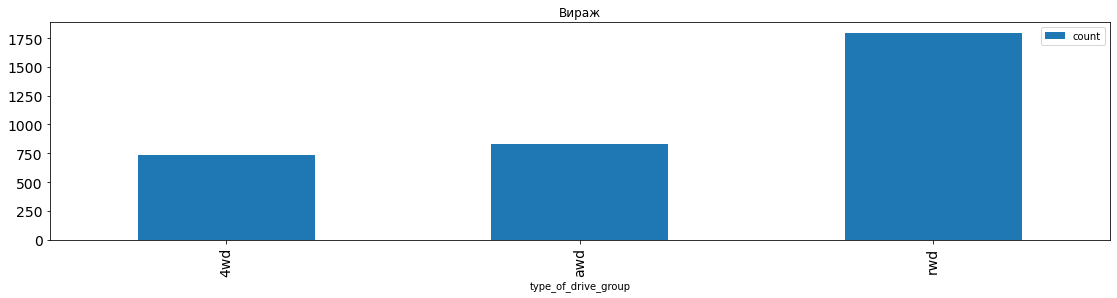

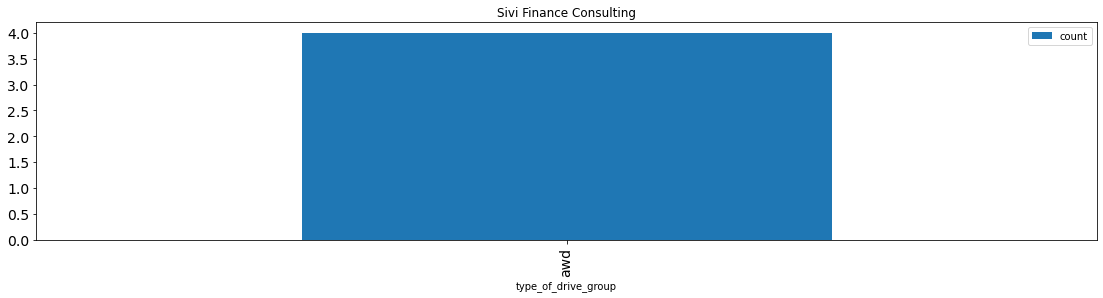

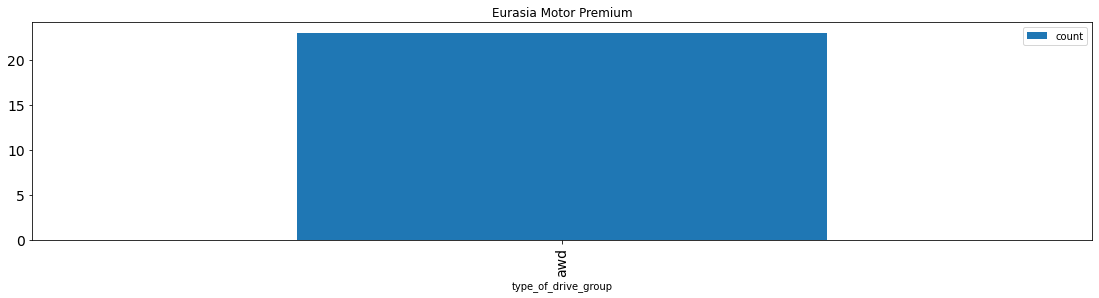

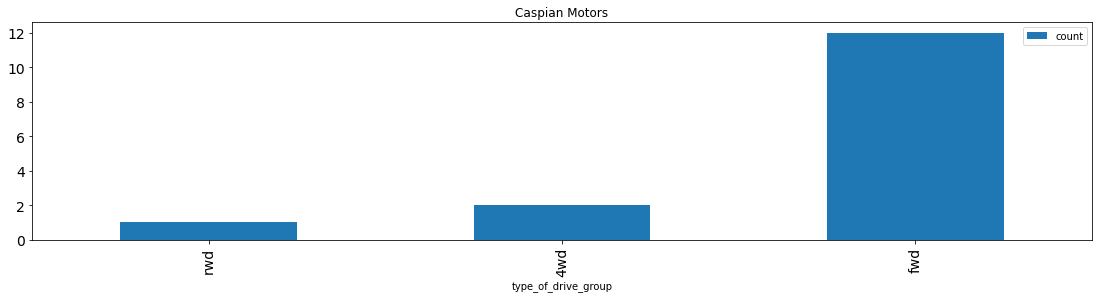

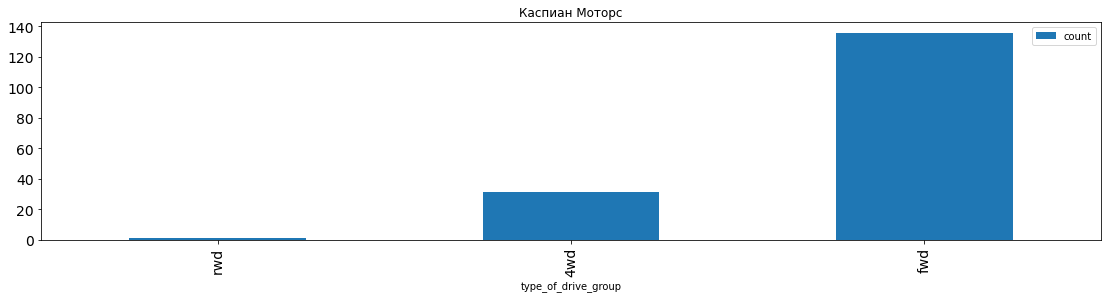

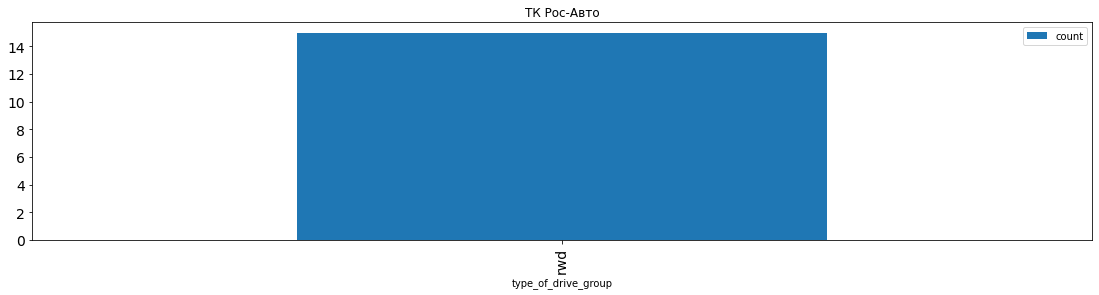

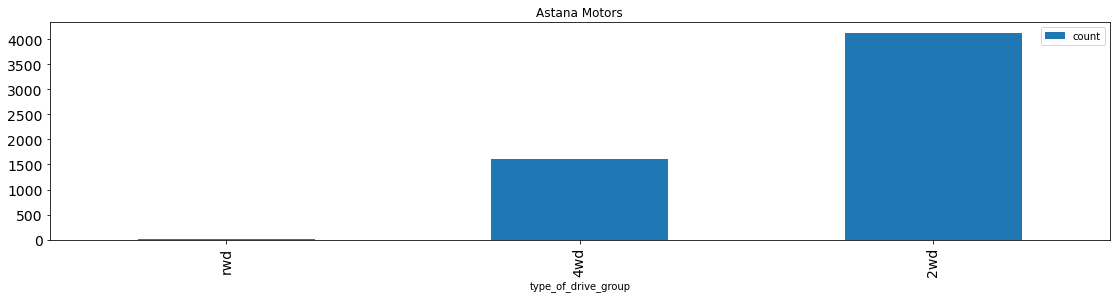

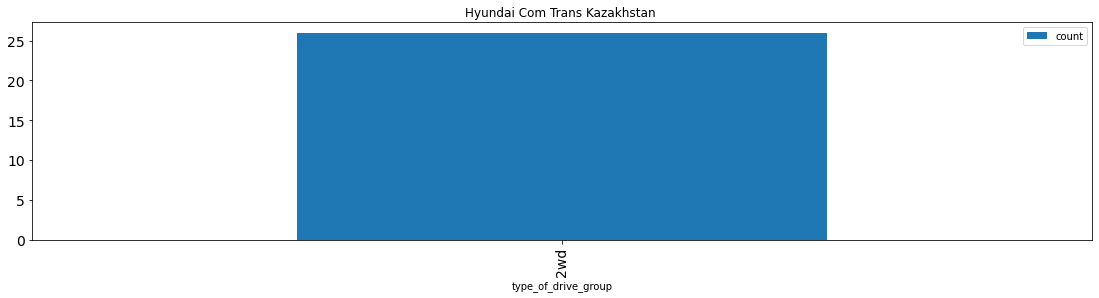

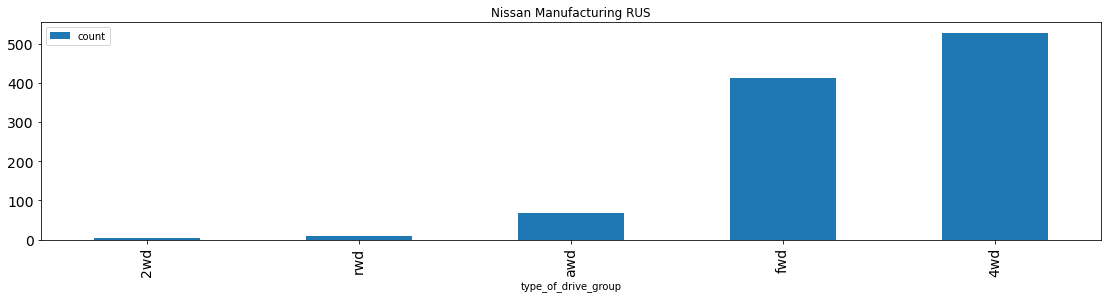

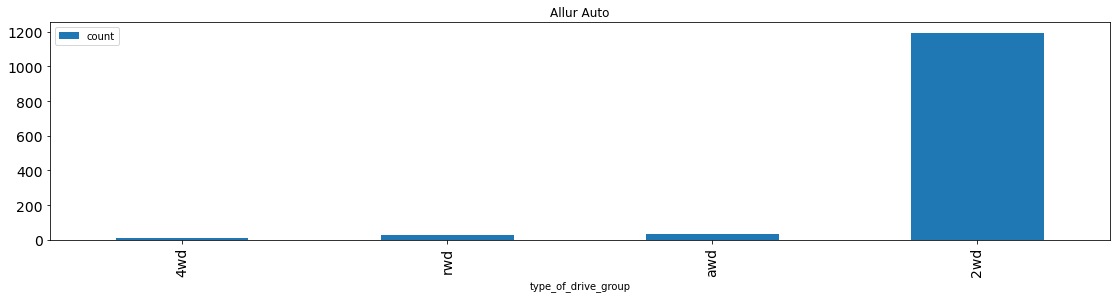

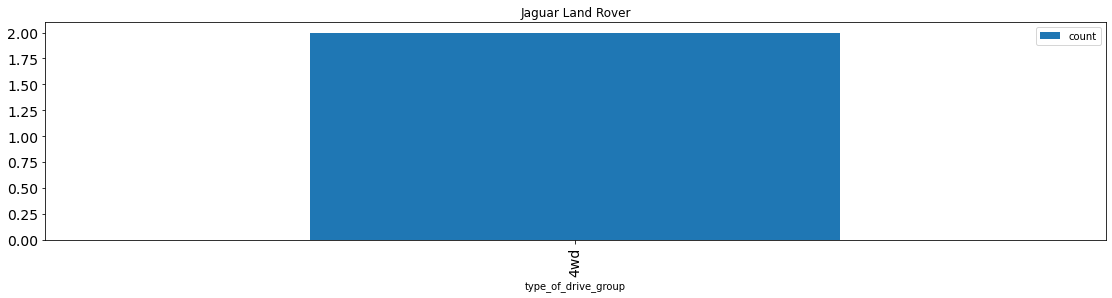

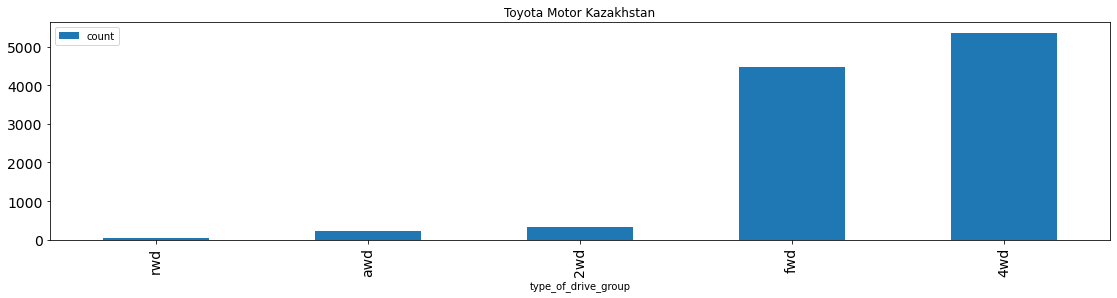

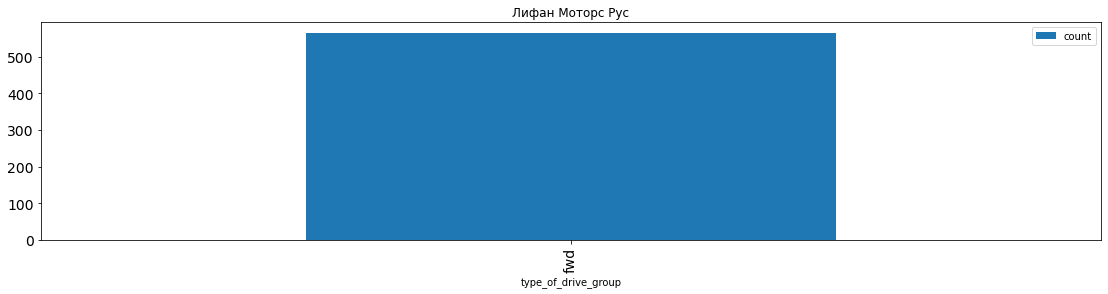

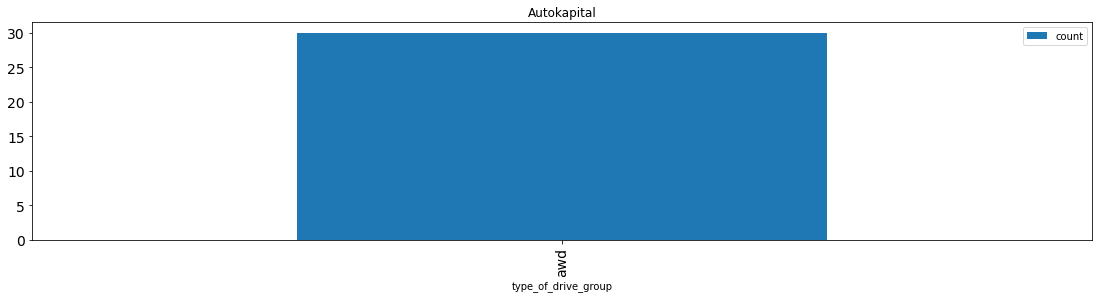

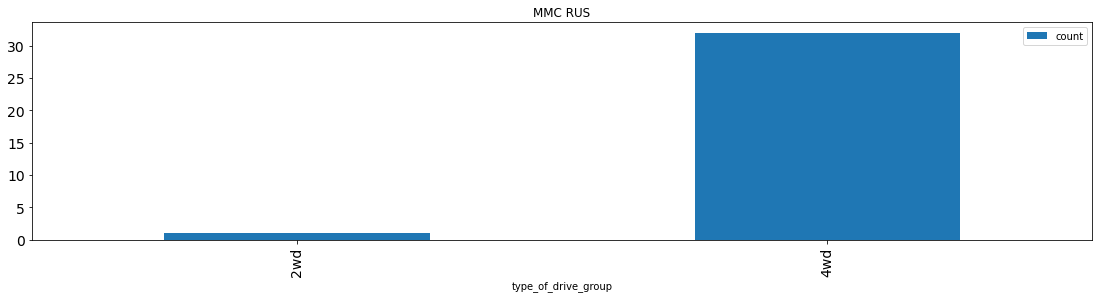

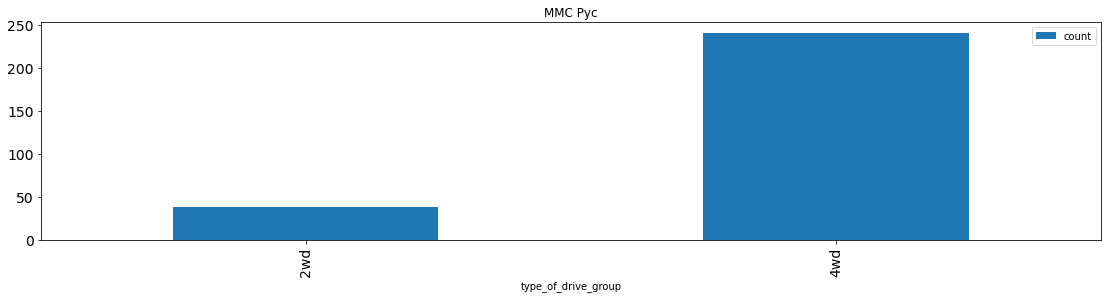

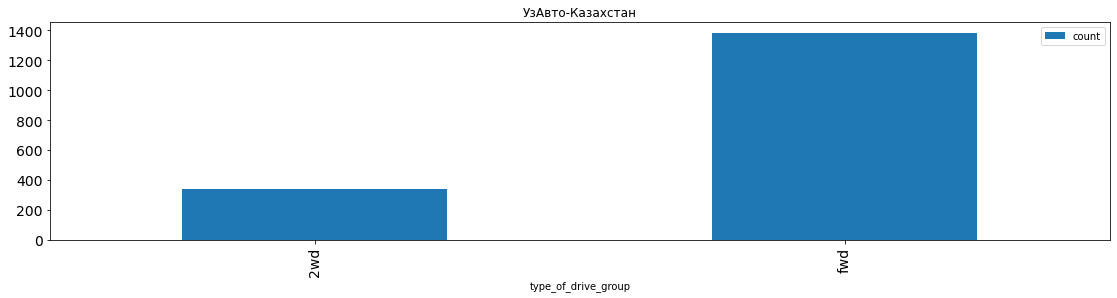

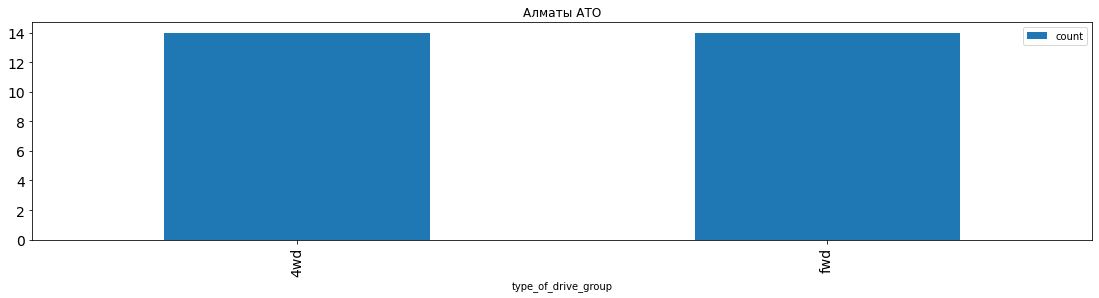

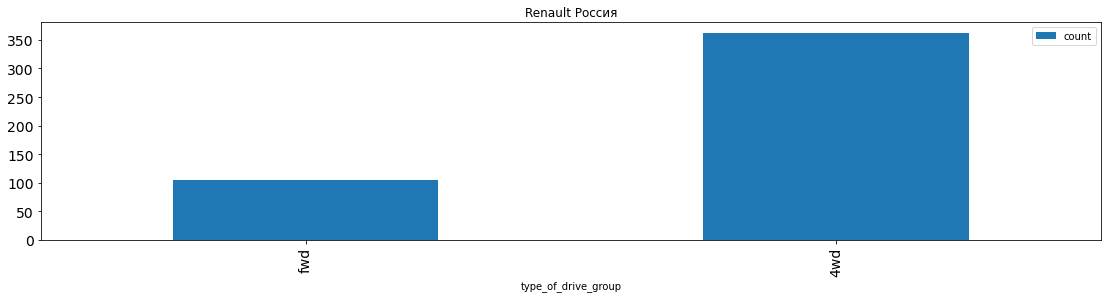

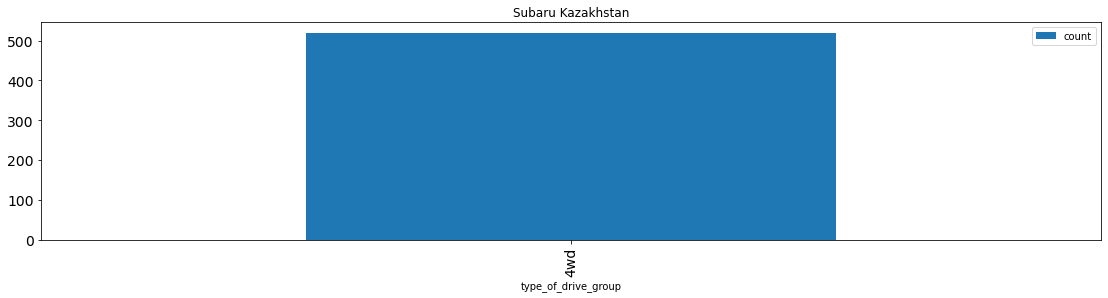

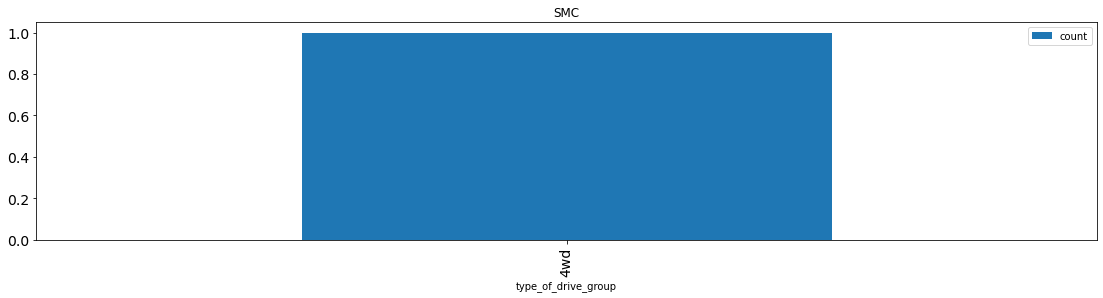

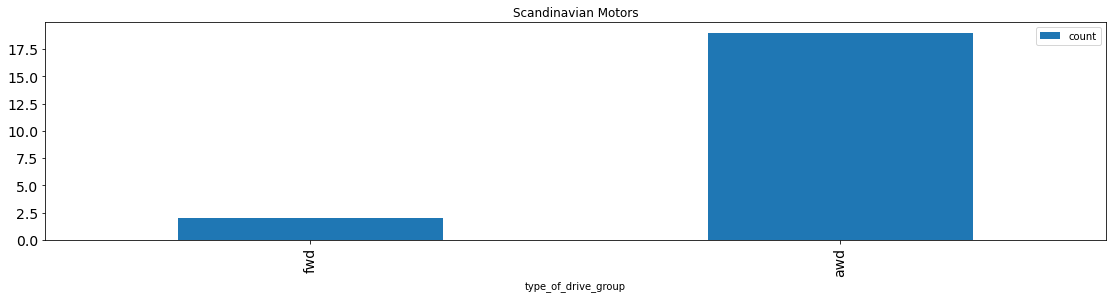

In [140]:
for i in df['company'].unique():
    df[df['company'] == i].groupby(['type_of_drive_group'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='type_of_drive_group',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Выводы:
- лидирующие места занимают различные вариации полноприводных автомобилей. Это логично, учитывая популярность внедорожников.
- из не полноприводных, лидируют переднеприводные
- меньше всего спросом пользуются автомобили заднеприводные. Тут стоит отметить, что в мире автомобилей с данной трансмисией меньше, чем с передним.

#### Общий вывод по компаниям:
- лидерами по продажам являюттся:
- аутсайдерами по продажам являются:
- лидерами по выручке являюттся:
- аутсайдерами по выручке являются:
- самый представленный сегмент в компаниях лидерах: внедорожники
- самый популярный производитель в компаниях лидерах:
- самая популярная трансмиссия: автомат
- самый популярный привлд: различные вариации полноприводных автомобилей

###  Анализ: Бренды
- самый популярный бренд
- бренды по выручке
- средняя/медиана стоимость автомобилей по брендам
- популярные бренды по регионам
- популярность трансмиссии по брендам
- популярность привода по брендам
- популярные объемы двигателя по брендам

#### самый популярный бренд

<AxesSubplot:title={'center':'самый популярный бренд'}, xlabel='brand'>

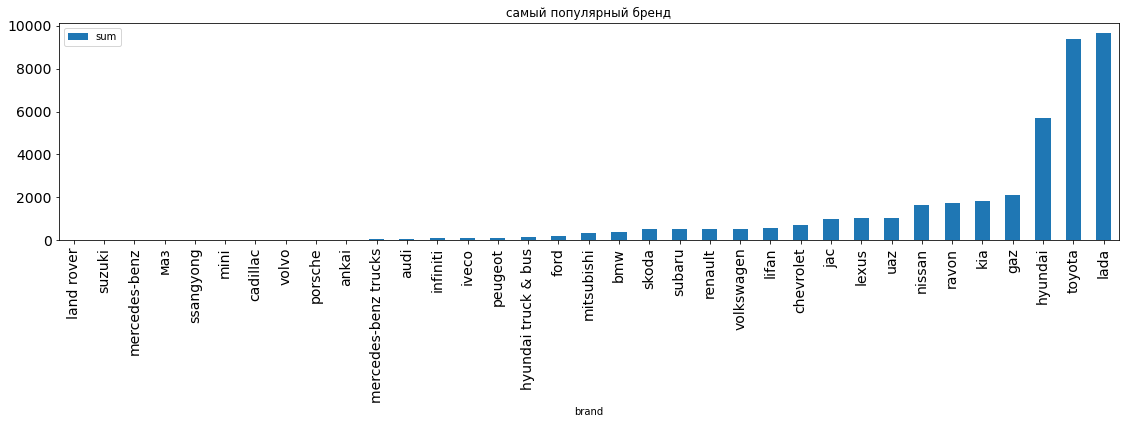

In [142]:
df.groupby(['brand'])['quantity'].agg(['sum']).reset_index().sort_values(by='sum').plot(
        x='brand',
        y="sum",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='самый популярный бренд'
)

Вывод:
- самые популярные бренды: hyundai, toyota и lada
- самые не популярные landrover, suzuki, mersedes-benz 

#### top бренды по выручке

<AxesSubplot:title={'center':'top бренды по выручке'}, xlabel='brand'>

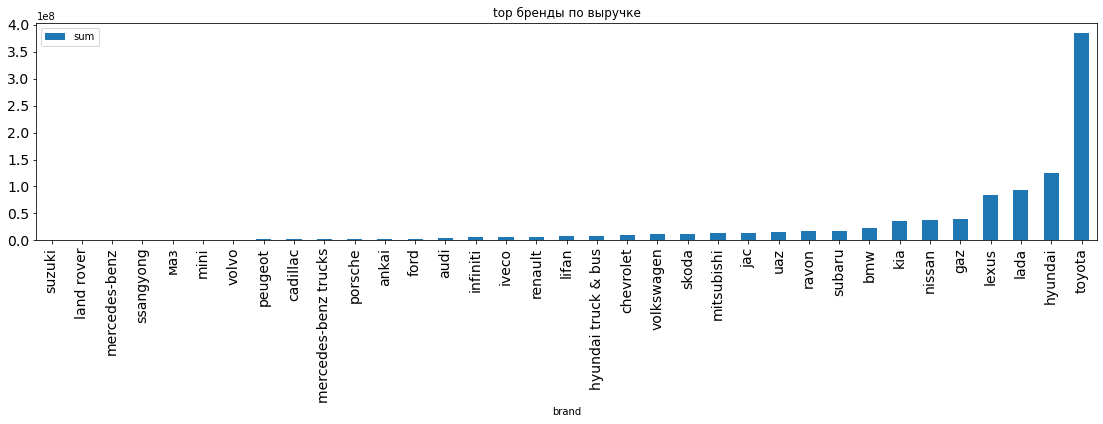

In [143]:
df.groupby(['brand'])['sale,_usd'].agg(['sum']).reset_index().sort_values(by='sum').plot(
        x='brand',
        y="sum",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='top бренды по выручке'
)

Вывод: <br> лидеры/антилидеры остаются теже самые
- самые популярные бренды: hyundai, toyota и lada
- самые не популярные landrover, suzuki, mersedes-benz

#### средняя стоимость автомобилей по брендам

<AxesSubplot:title={'center':'средняя стоимость автомобилей по брендам'}, xlabel='brand'>

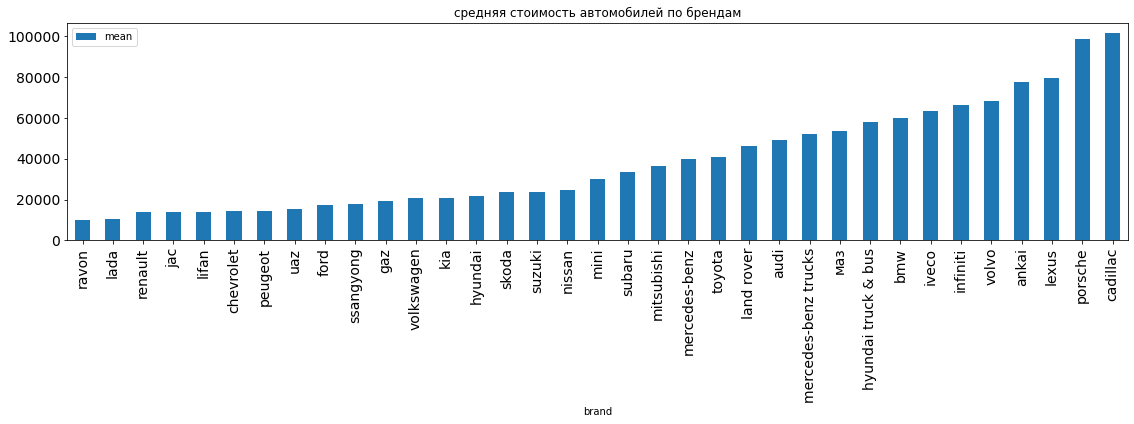

In [144]:
df.groupby(['brand'])['price,_usd'].agg(['mean']).reset_index().sort_values(by='mean').plot(
        x='brand',
        y="mean",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='средняя стоимость автомобилей по брендам'
)

#### медиана стоимость автомобилей по брендам

<AxesSubplot:title={'center':'медиана стоимость автомобилей по брендам'}, xlabel='brand'>

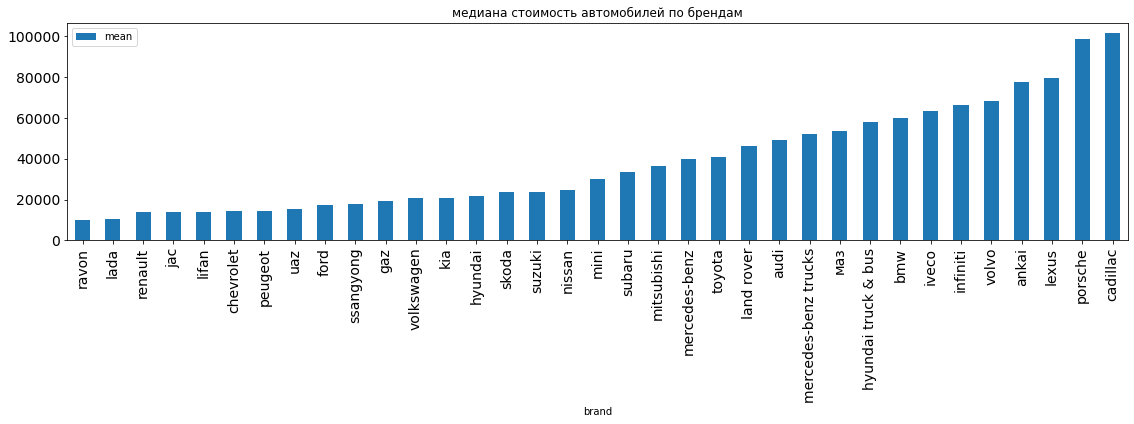

In [145]:
df.groupby(['brand'])['price,_usd'].agg(['mean']).reset_index().sort_values(by='mean').plot(
        x='brand',
        y="mean",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='медиана стоимость автомобилей по брендам'
)

Вывод:
- самые дорогие машины брендов: porsche, cadillac
- самые дешевые машины брендов: lada, ravon

#### популярные бренды по регионам

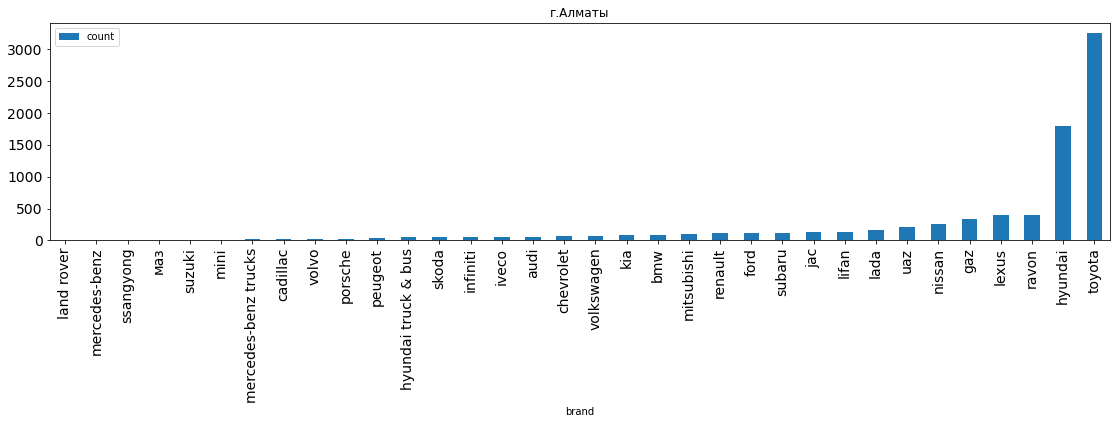

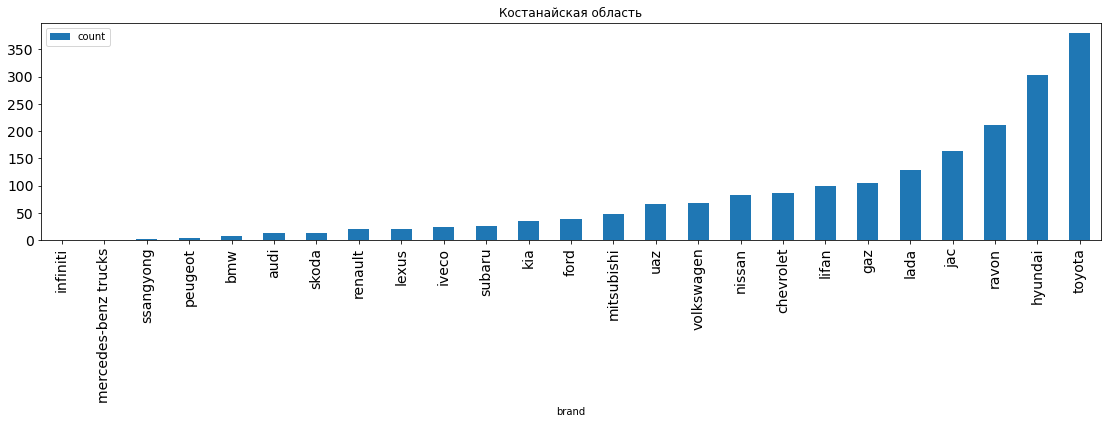

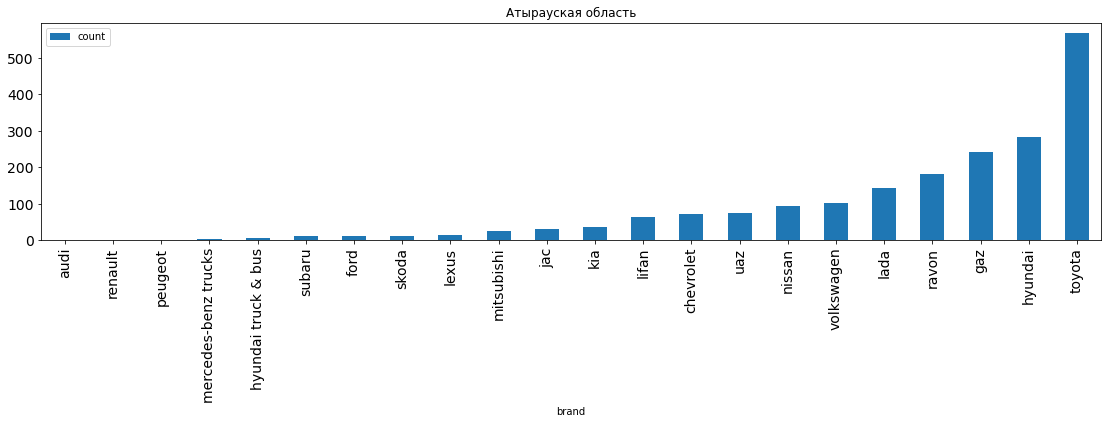

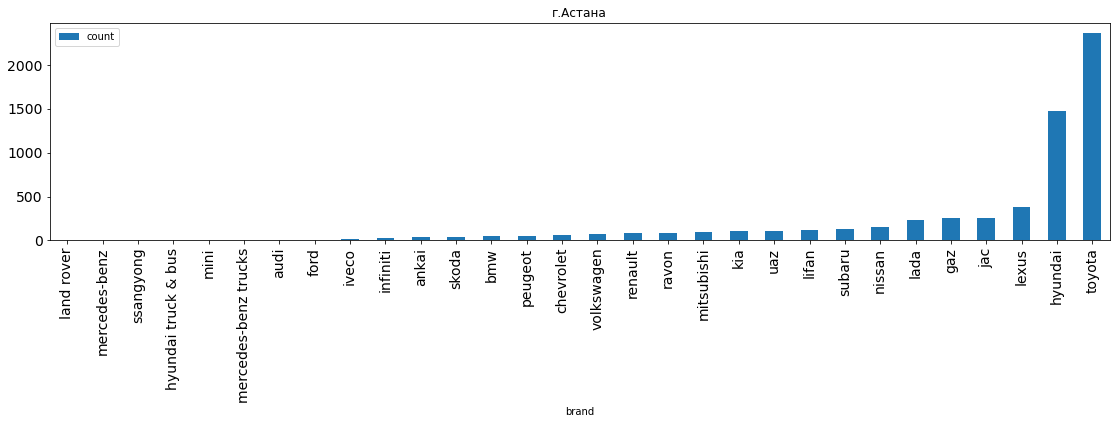

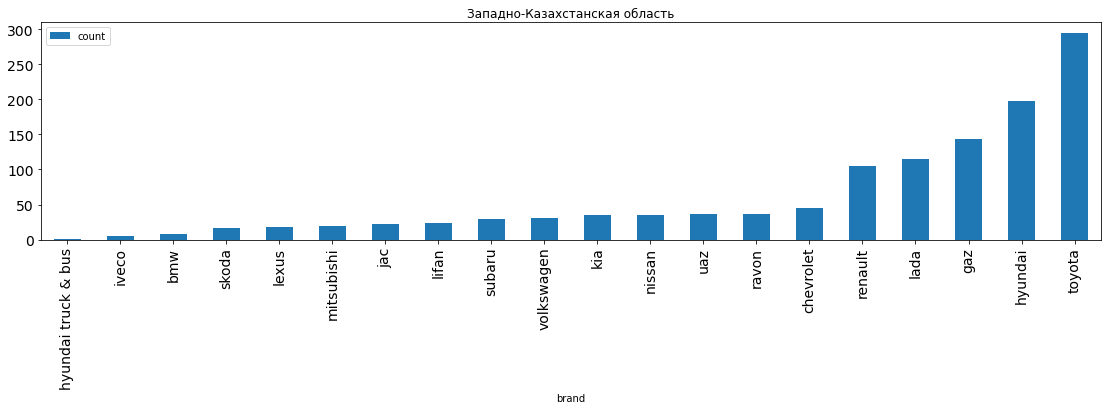

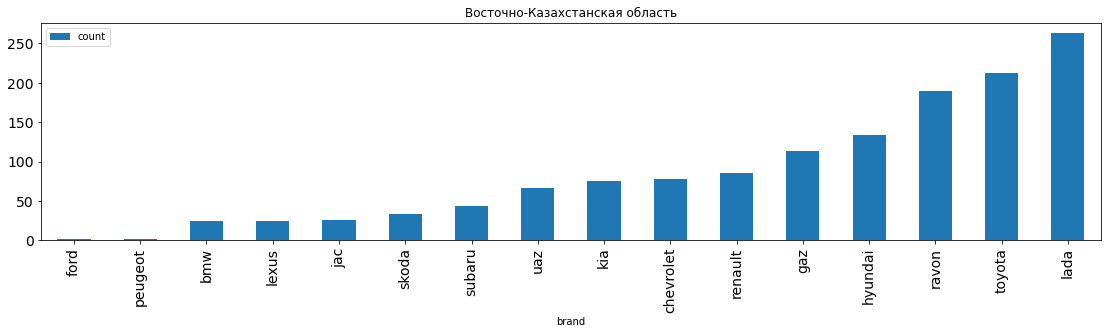

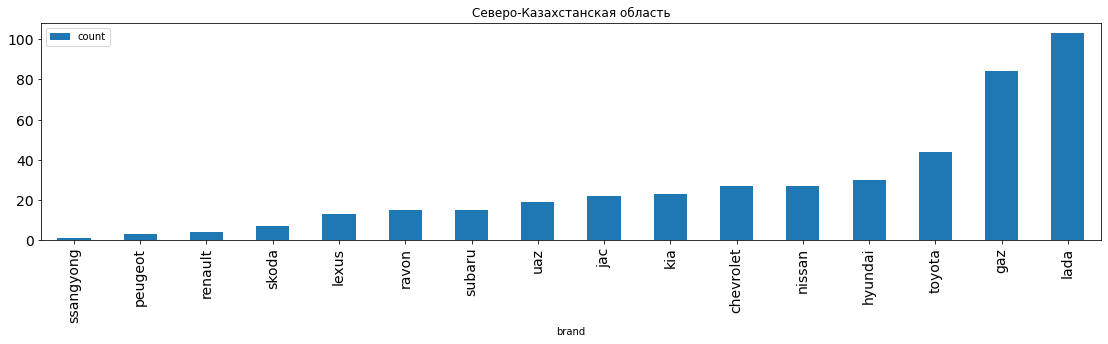

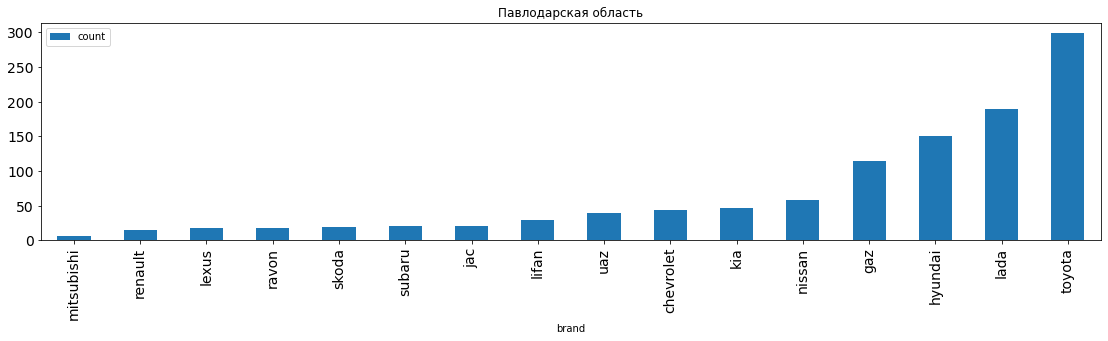

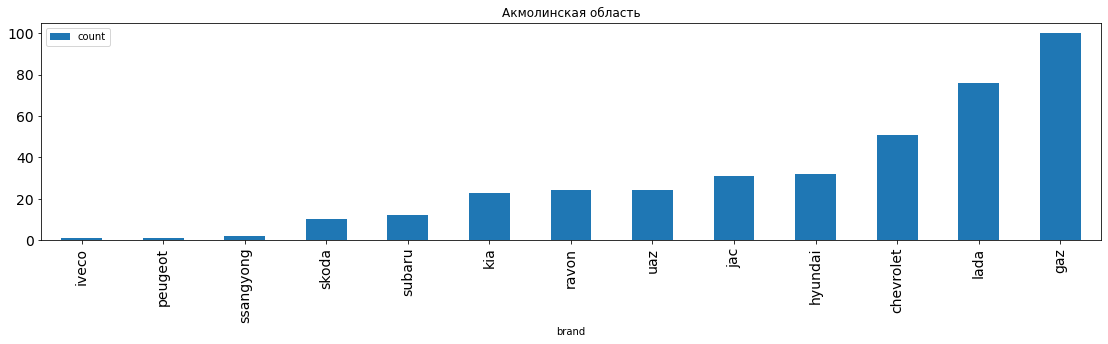

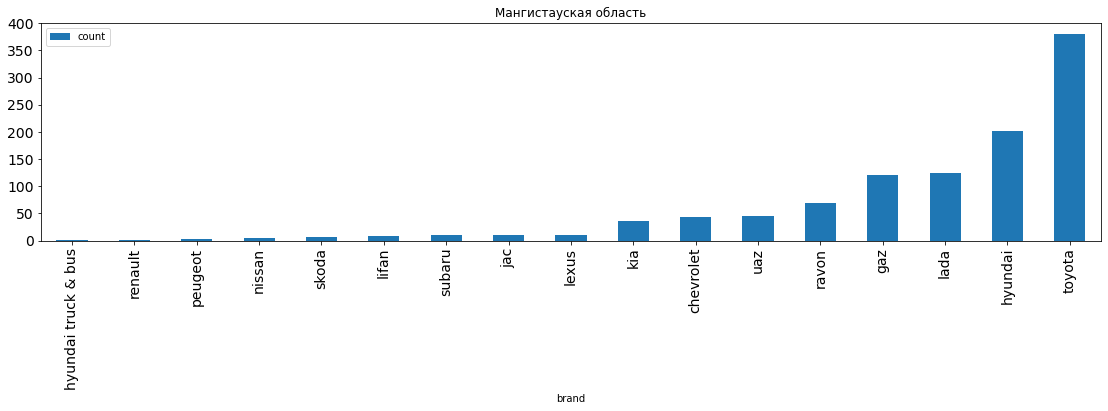

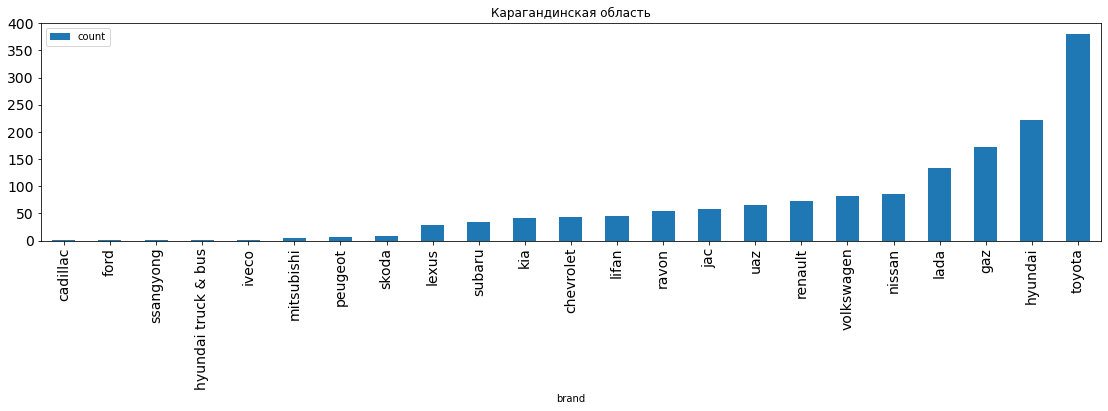

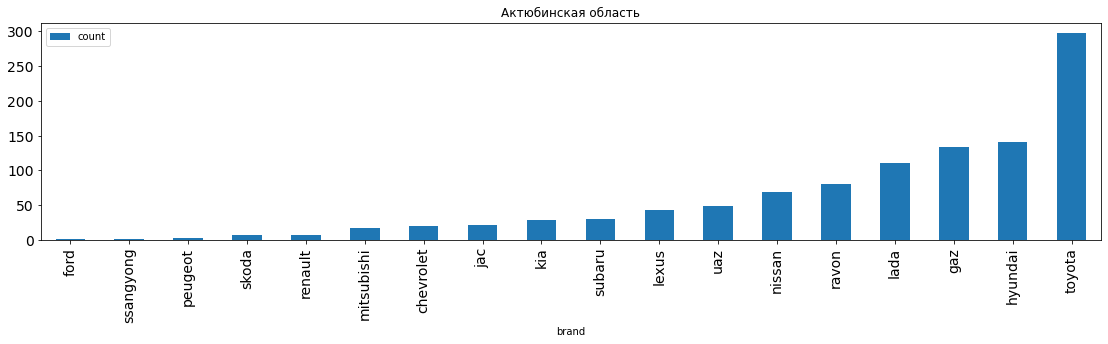

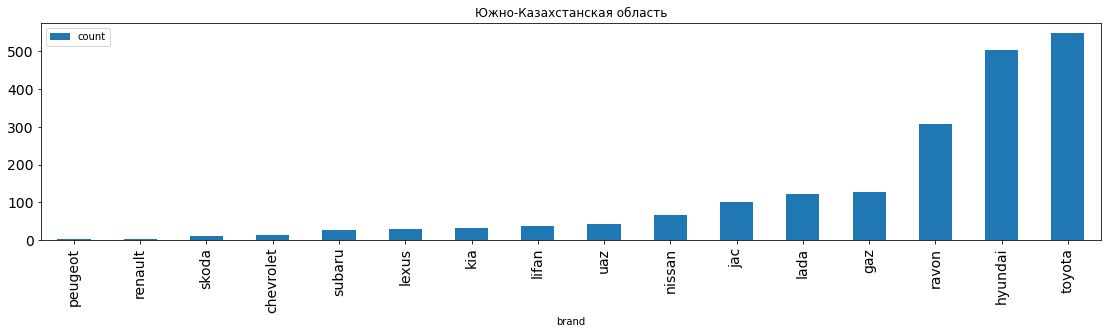

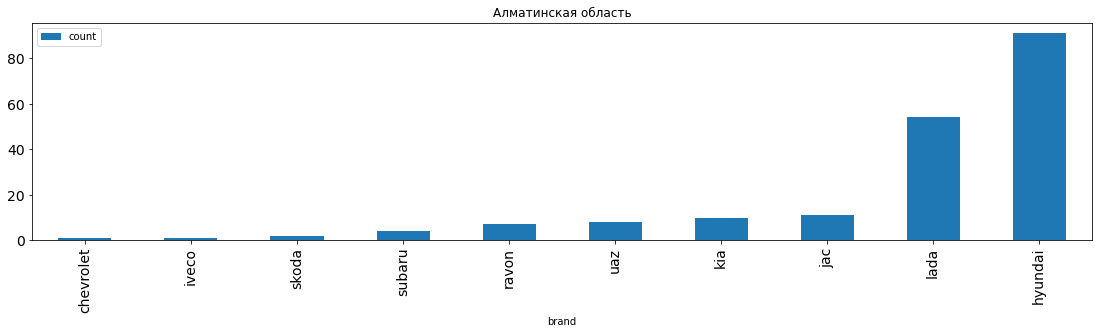

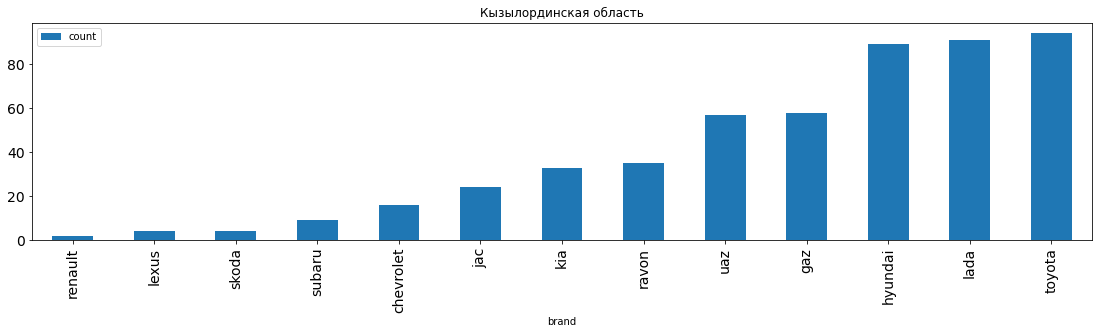

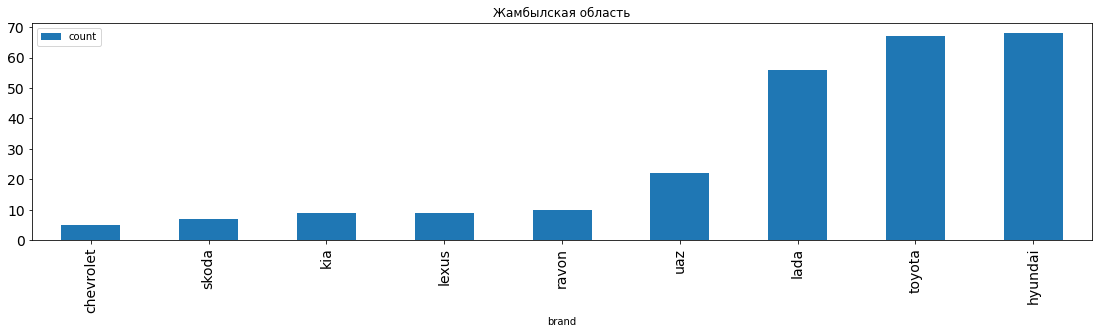

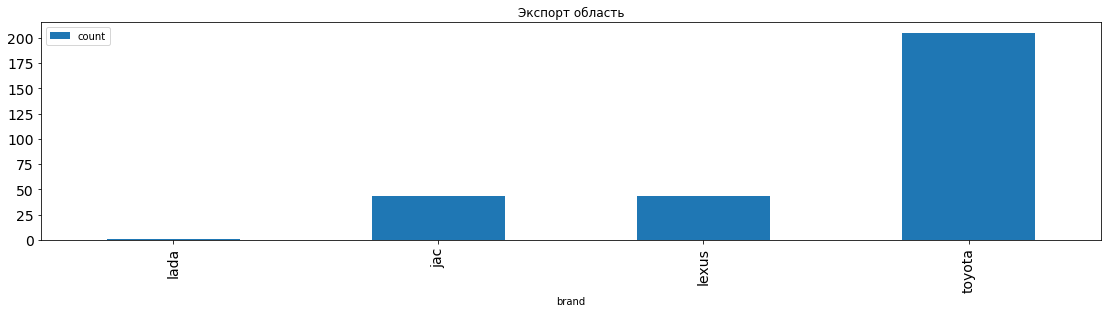

In [171]:
for i in df['city'].unique():
    df[df['city'] == i].groupby(['brand'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='brand',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

In [174]:
f = open('уровень дохода Казахи.csv').readlines()
m = [i for i in f]
level_life = dict()
for i in m[1:]:
    a, b = map(str, i.split(';'))
    level_life[a.strip().lower()[:4]] = int(b.strip().replace(' ', ''))
level_life

{'севе': 46678,
 'кызы': 48884,
 'акмо': 46468,
 'актю': 57747,
 'павл': 60318,
 'запа': 59152,
 'жамб': 36658,
 'атыр': 117671,
 'вост': 51409,
 'манг': 92495,
 'кост': 50033,
 'алма': 43217,
 'кара': 65067,
 'южно': 34336,
 'г.ас': 94421,
 'г.ал': 101803}

In [175]:
def level_lf(row):
    row = str(row).lower().strip()[:4]
    if row in level_life:
        return level_life[row]
    return 0
df['level_life'] = df['city'].apply(level_lf)
df['level_life'].unique()

array([101803,  50033, 117671,  94421,  59152,  51409,  46678,  60318,
        46468,  92495,  65067,  57747,  34336,  43217,  48884,  36658,
            0])

In [176]:
df.groupby(['level_life'])['0'].count()

level_life
0          292
34336     1976
36658      253
43217      189
46468      387
46678      437
48884      516
50033     1948
51409     1374
57747     1064
59152     1217
60318     1085
65067     1546
92495     1083
94421     6256
101803    8229
117671    1984
Name: 0, dtype: int64

In [178]:
df[df['level_life']==0]['region'].unique()

array(['ЭКСПОРТ'], dtype=object)

После как раставили уровень дохода, рассмотрим в какие доходы в городах где находятся лидеры и антилидеры

In [200]:
df_level = df.groupby(['city', 'brand', 'level_life'])['0'].agg(['count']).reset_index()
df_level.head()

city      brand  level_life  count
0  Акмолинская область  chevrolet       46468     51
1  Акмолинская область        gaz       46468    100
2  Акмолинская область    hyundai       46468     32
3  Акмолинская область      iveco       46468      1
4  Акмолинская область        jac       46468     31

In [205]:
df_level.sort_values('count', ascending=False).drop_duplicates(['city']).sort_values(by='level_life')

city    brand  level_life  count
221                 Экспорт область   toyota           0    205
236      Южно-Казахстанская область   toyota       34336    547
80               Жамбылская область  hyundai       36658     68
32              Алматинская область  hyundai       43217     91
1               Акмолинская область      gaz       46468    100
207    Северо-Казахстанская область     lada       46678    103
167          Кызылординская область   toyota       48884     94
153            Костанайская область   toyota       50033    379
70   Восточно-Казахстанская область     lada       51409    263
29              Актюбинская область   toyota       57747    297
105   Западно-Казахстанская область   toyota       59152    295
200            Павлодарская область   toyota       60318    299
128          Карагандинская область   toyota       65067    381
184           Мангистауская область   toyota       92495    381
299                        г.Астана   toyota       94421   2359
267                        г.Алматы   toyota      101803   3247
60               Атырауская область   toyota      117671    567

Вывод:
- самые популярные бренды: hyundai, toyota и lada
- как види больше всего представлена toyota
- можно заметить что lada, gaz  представлены в районах с уровнем дохода ниже среднего

#### популярность трансмиссии по брендам

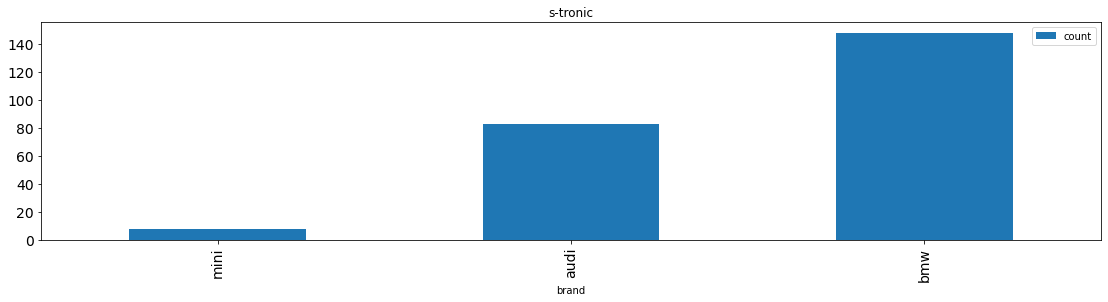

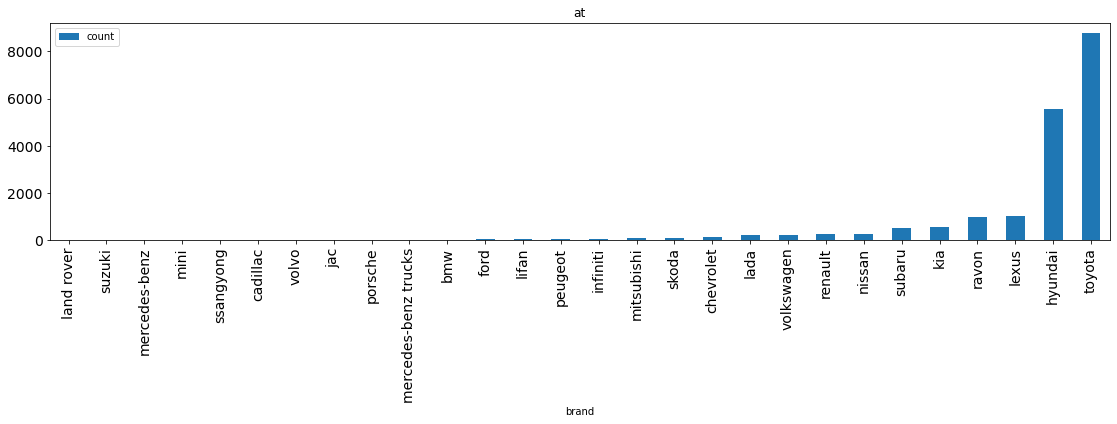

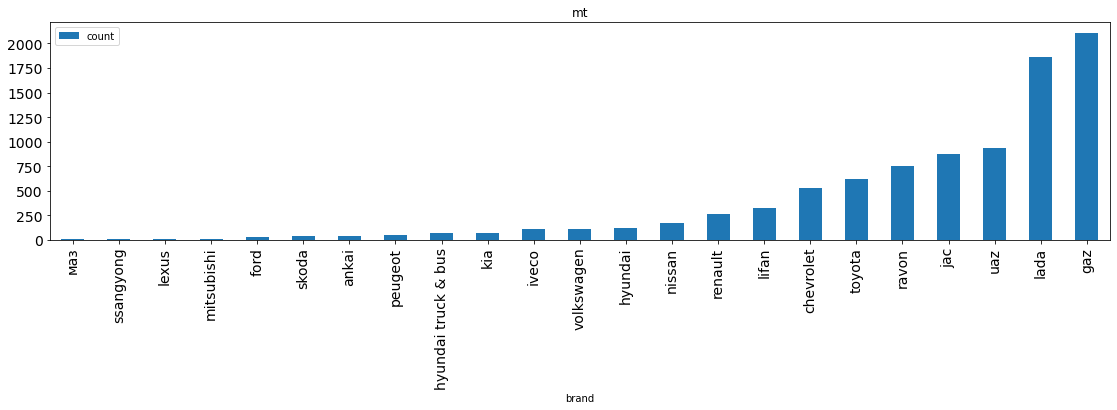

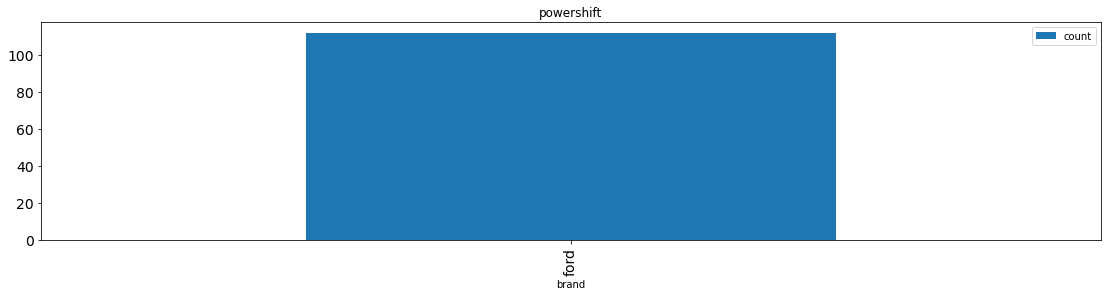

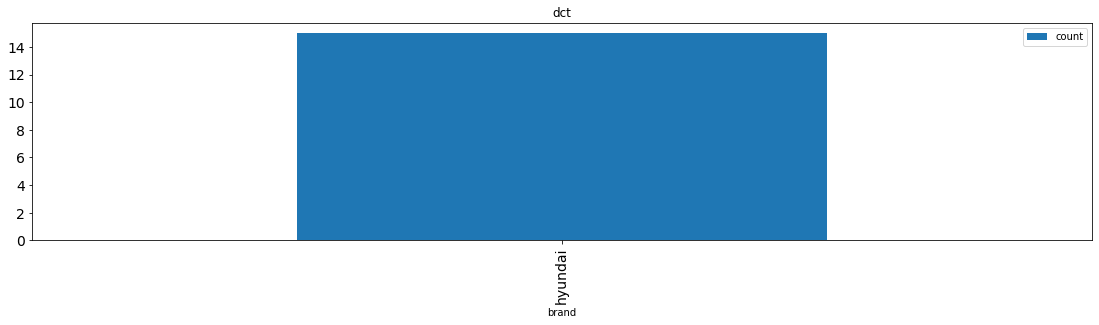

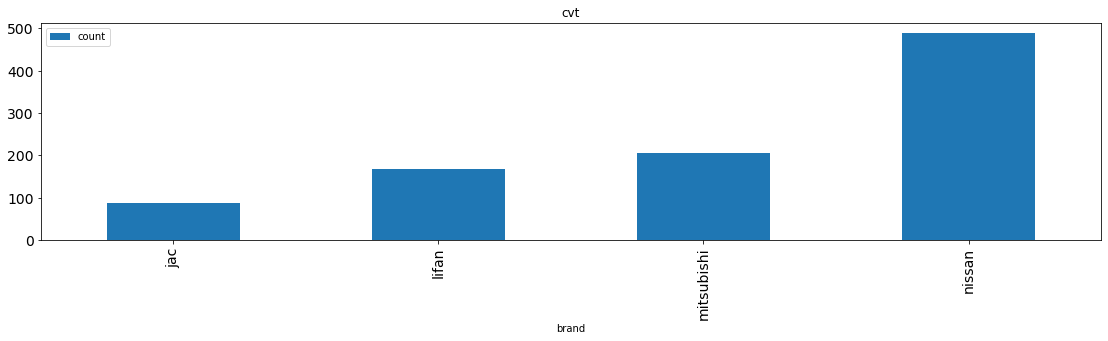

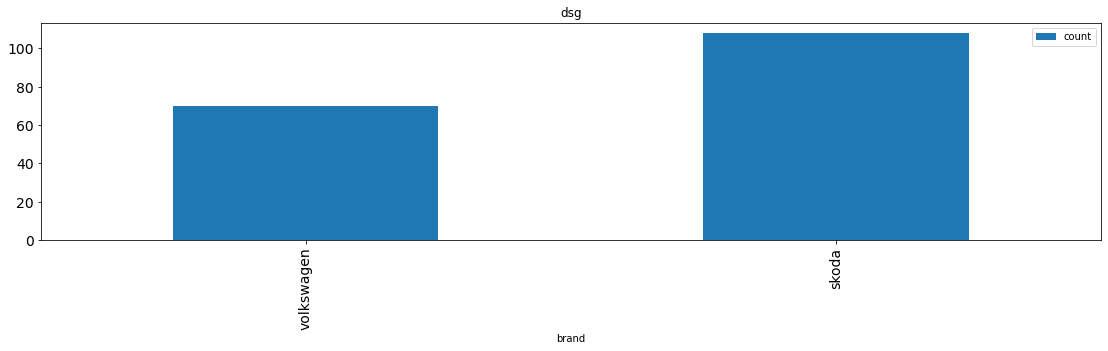

In [209]:
for i in df['transmition_group'].unique():
    df[df['transmition_group'] == i].groupby(['brand'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='brand',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Выводы:
- как видно что механика в основном представлена в российском автопроме и китайском. 
- Остальные типы приводов разделены по производителям
- чисто автоматическая является самой популярной из устанавливаемой отсюда и лидерство, но стоит учитывать все вариации автоматических вместе.

#### популярность привода по брендам

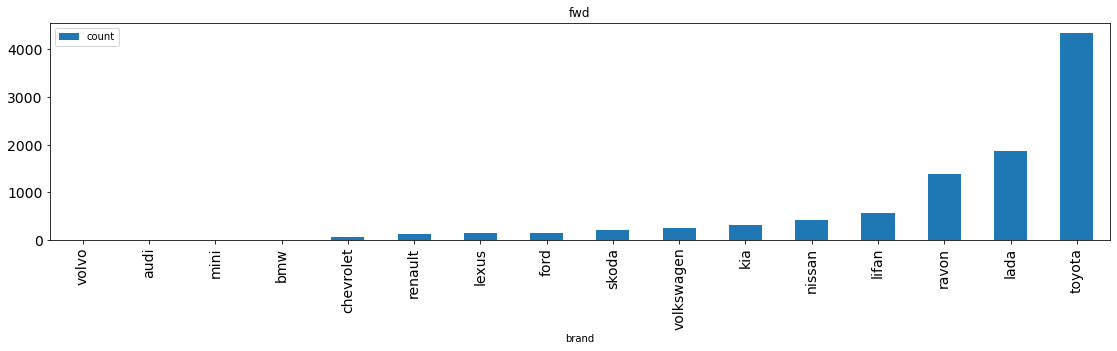

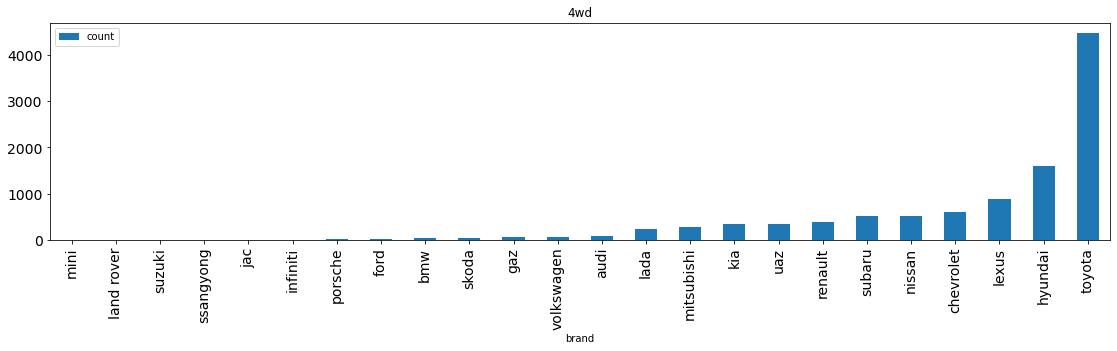

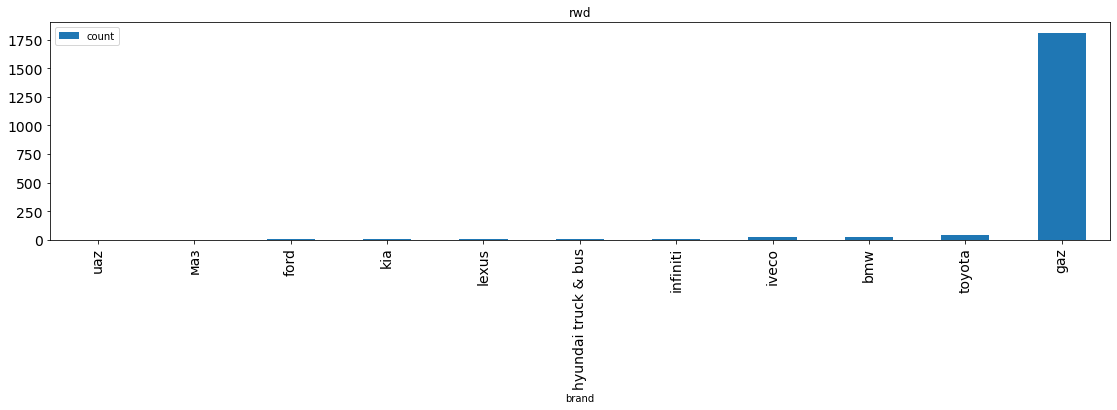

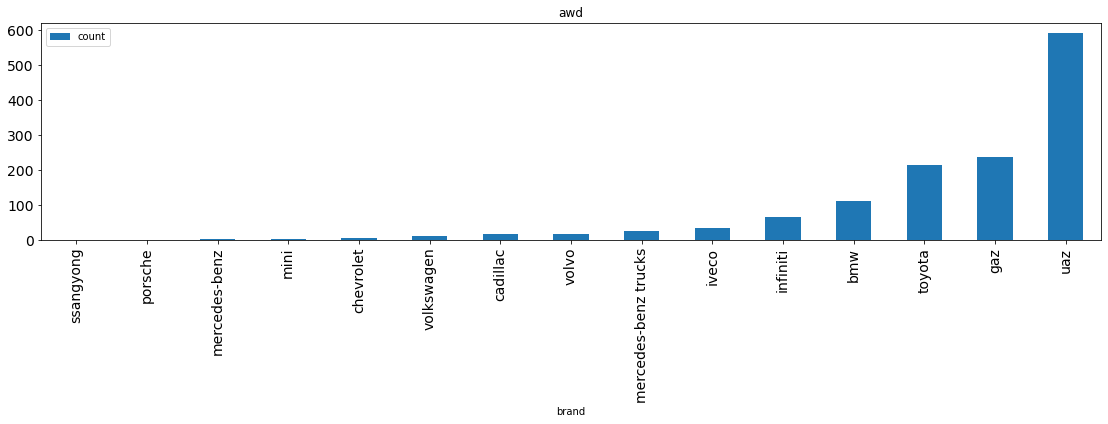

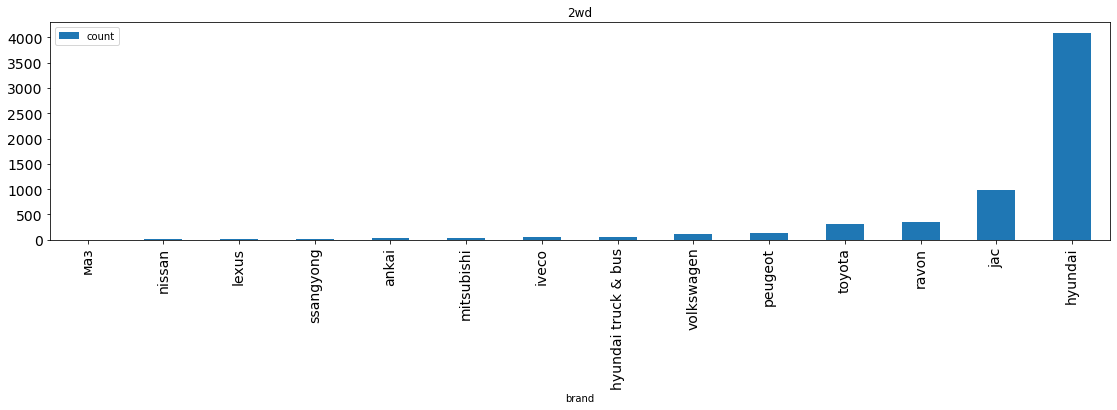

In [210]:
for i in df['type_of_drive_group'].unique():
    df[df['type_of_drive_group'] == i].groupby(['brand'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='brand',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

выводы:
  - toyota в основном предсталены в полном и переднеприводном сегменте
  - uaz, gaz с подключаемомы
  - hyndai в моноприводе

#### популярные объемы двигателя по брендам

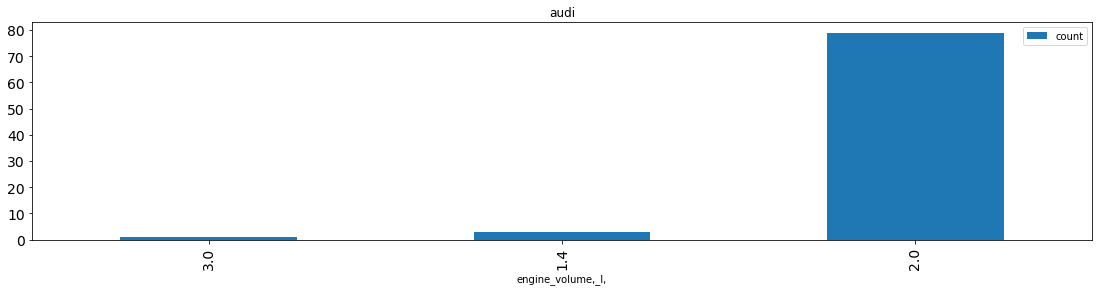

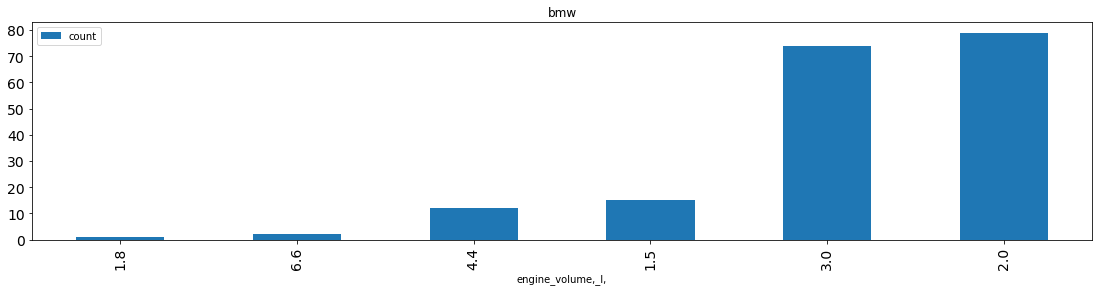

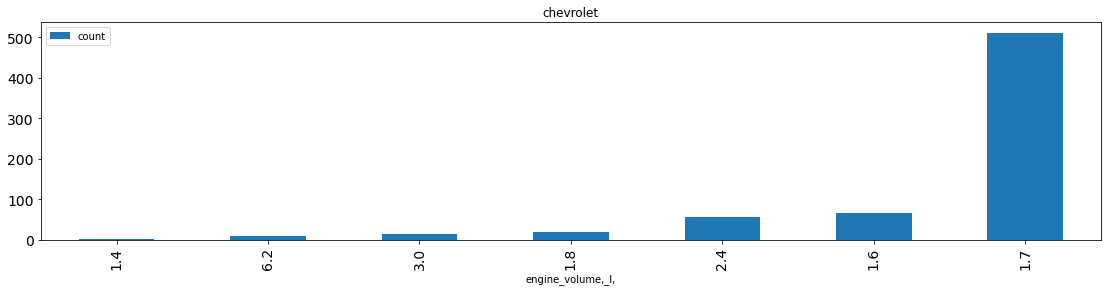

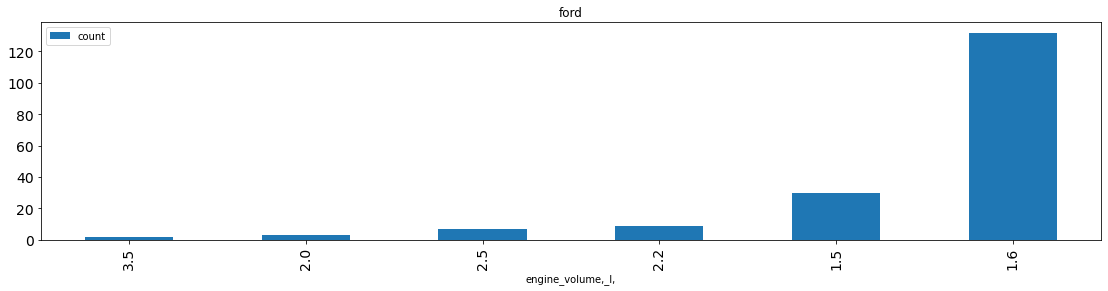

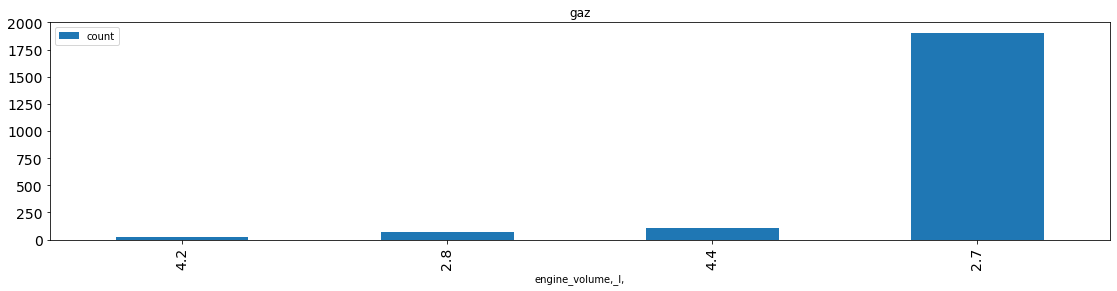

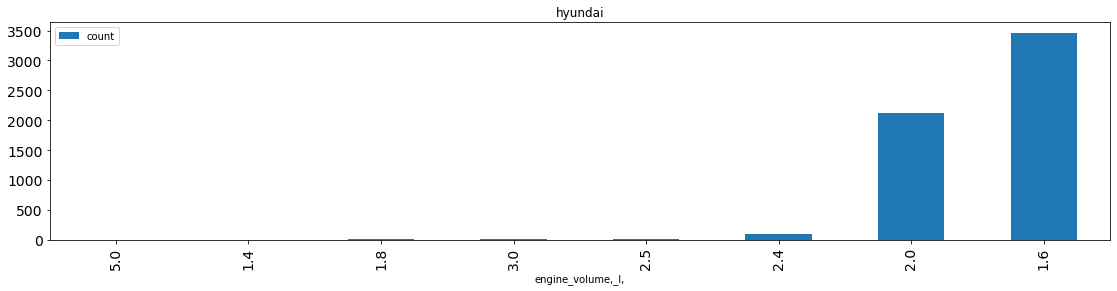

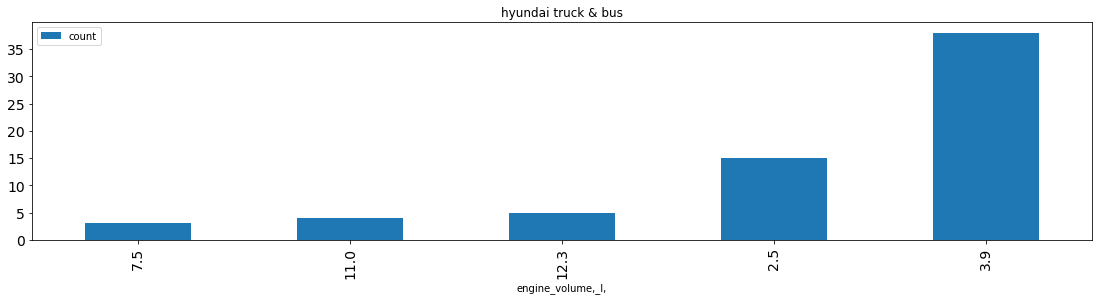

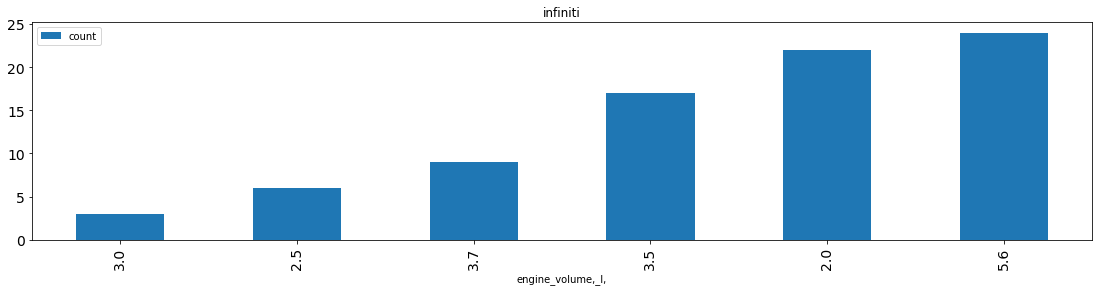

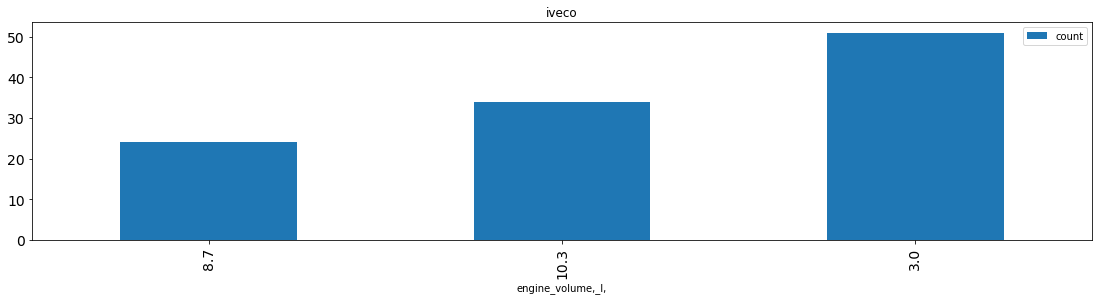

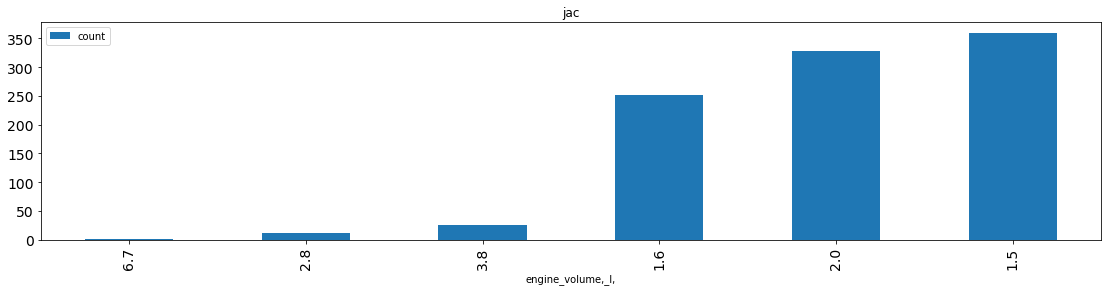

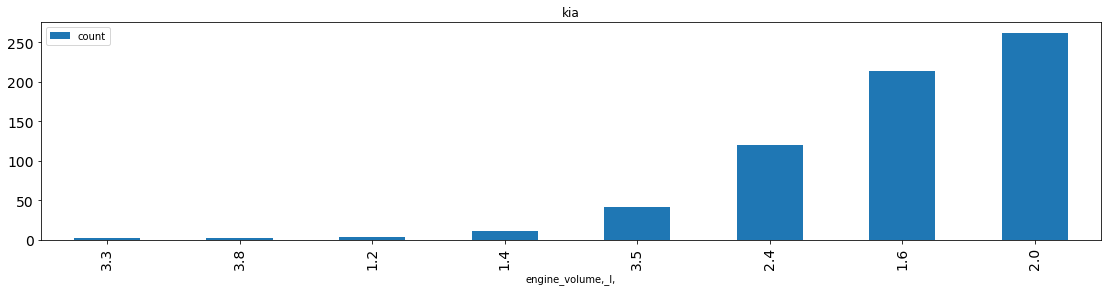

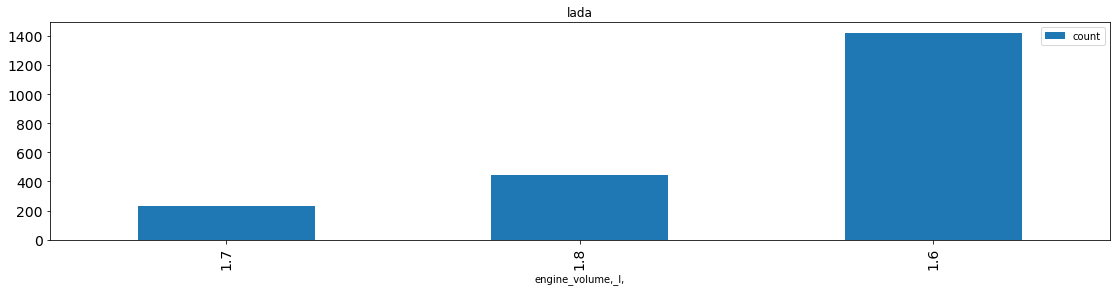

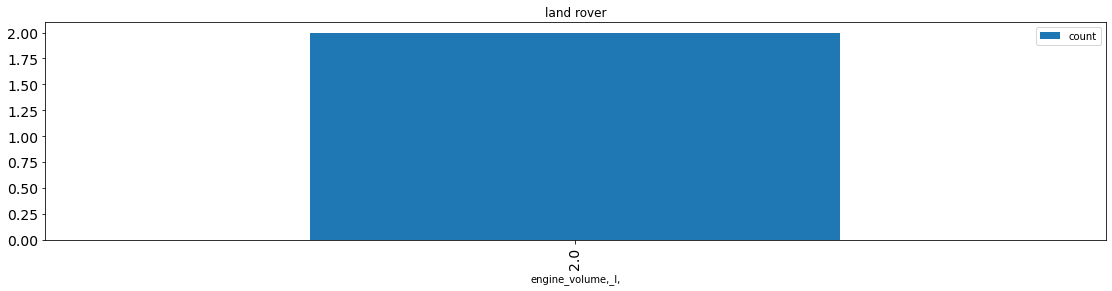

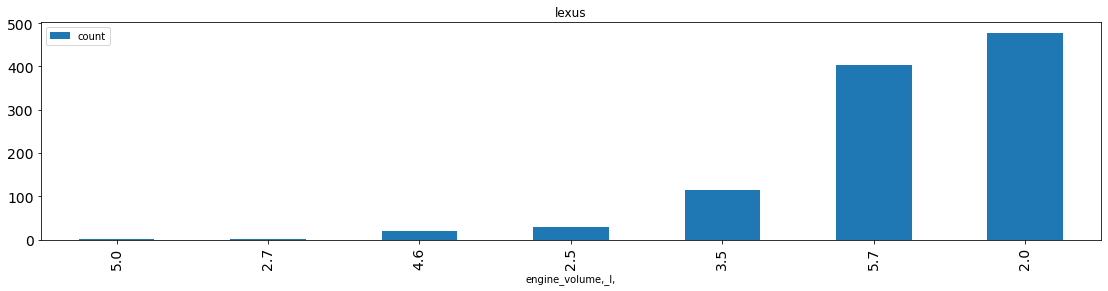

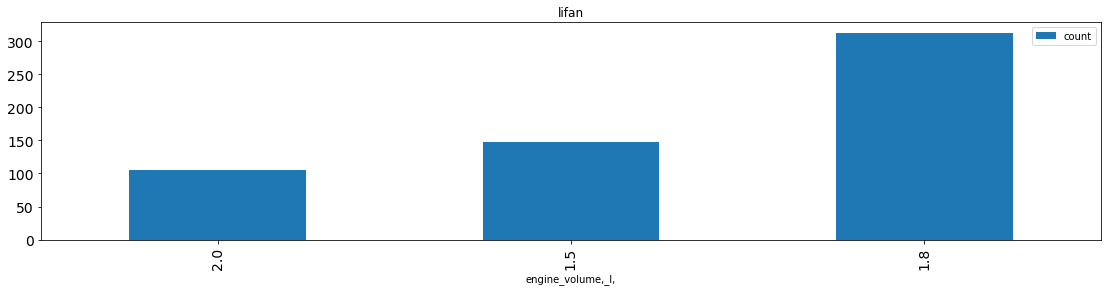

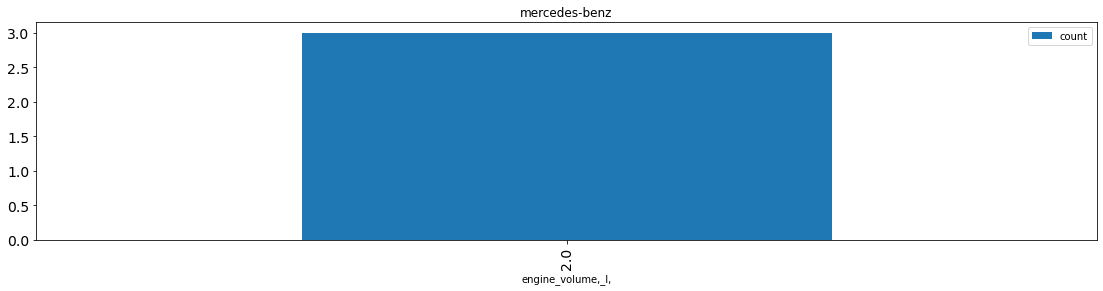

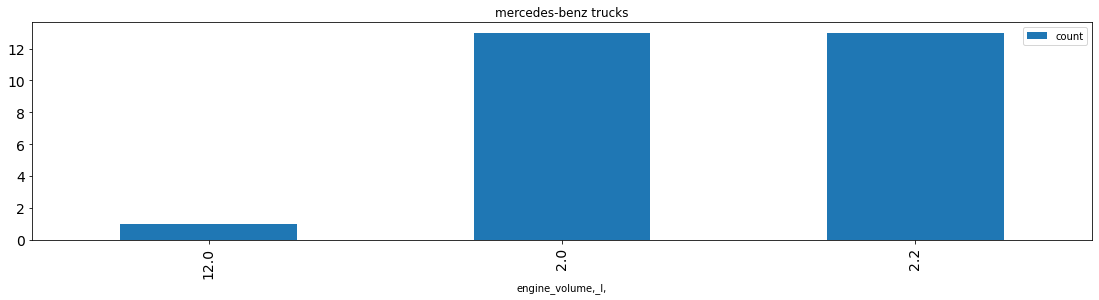

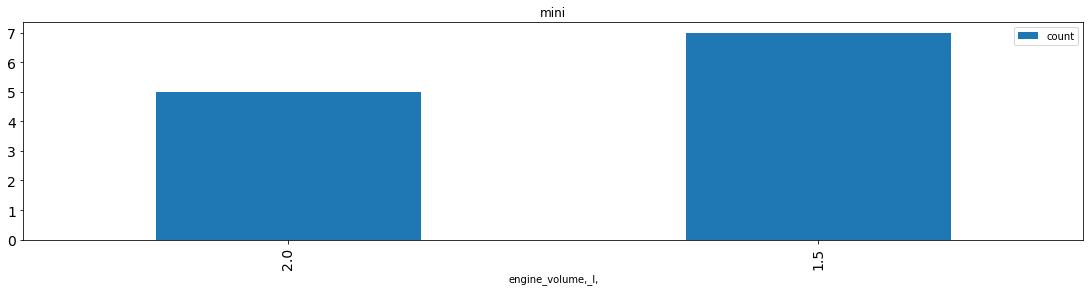

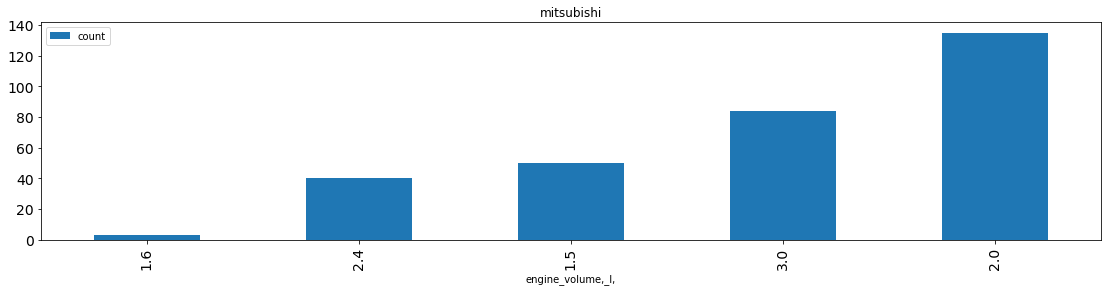

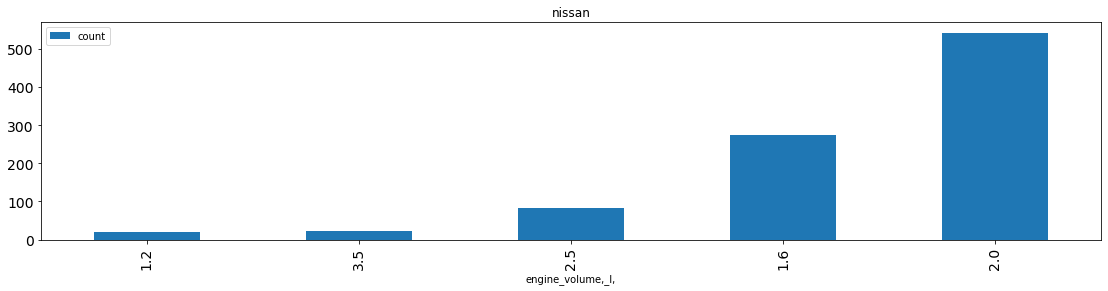

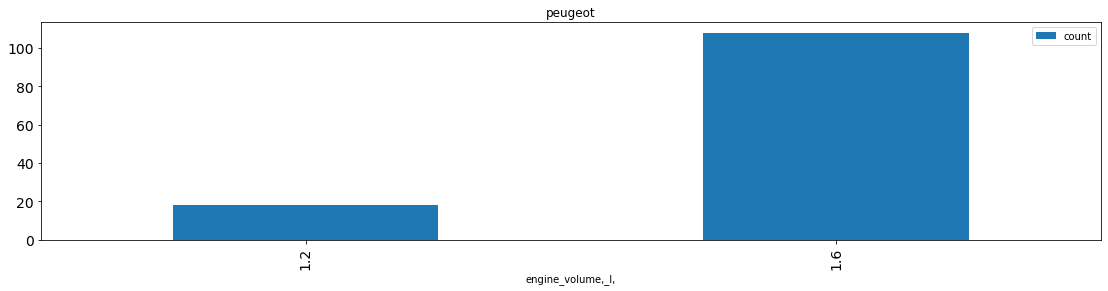

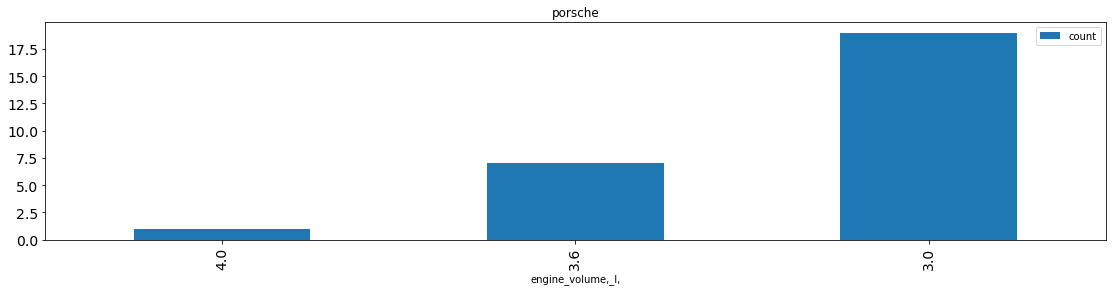

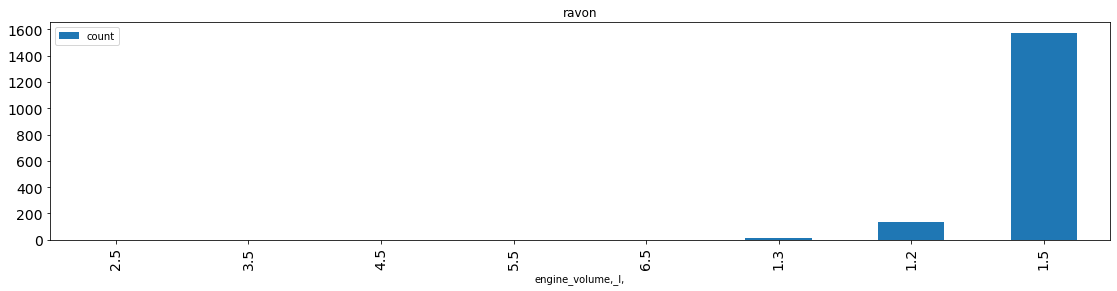

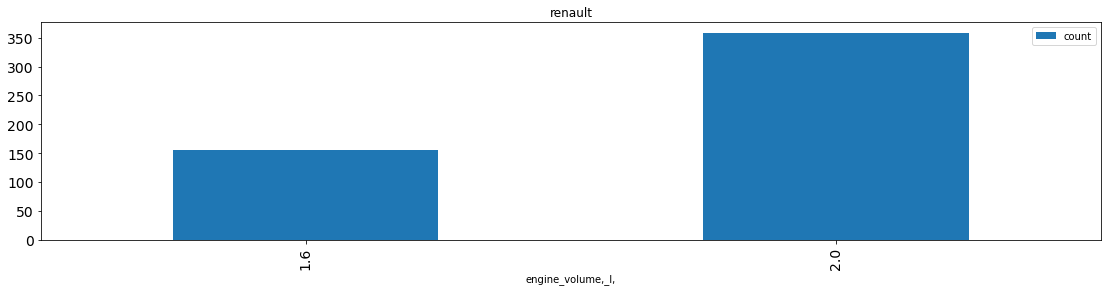

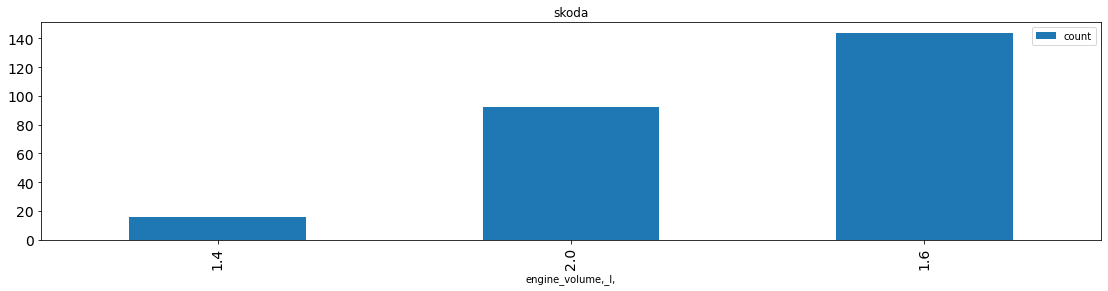

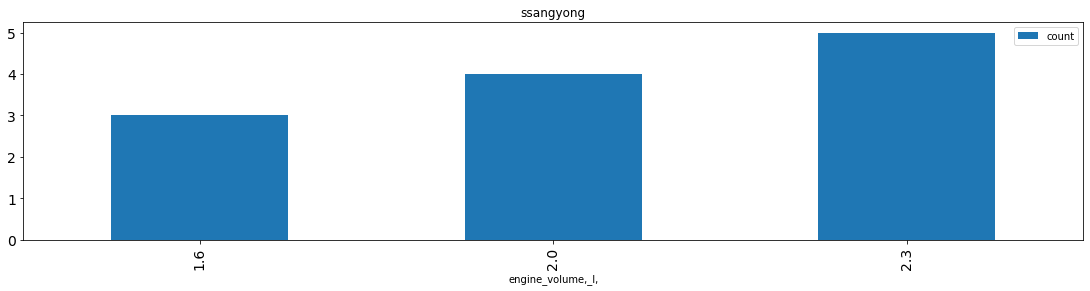

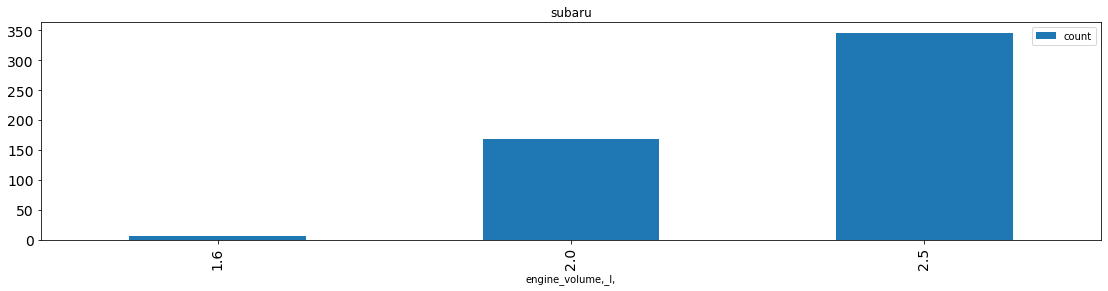

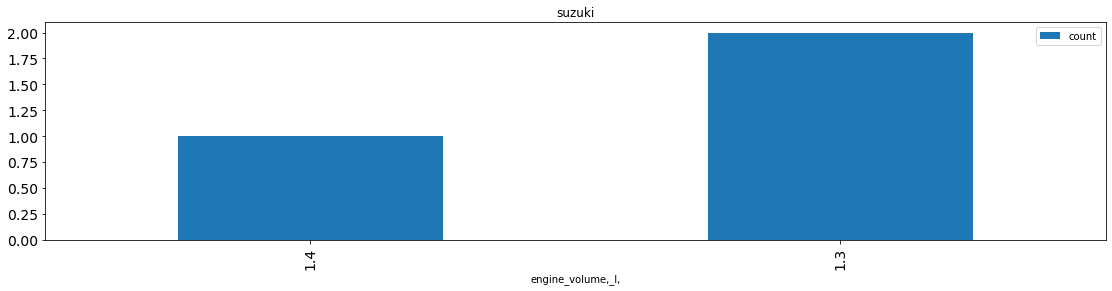

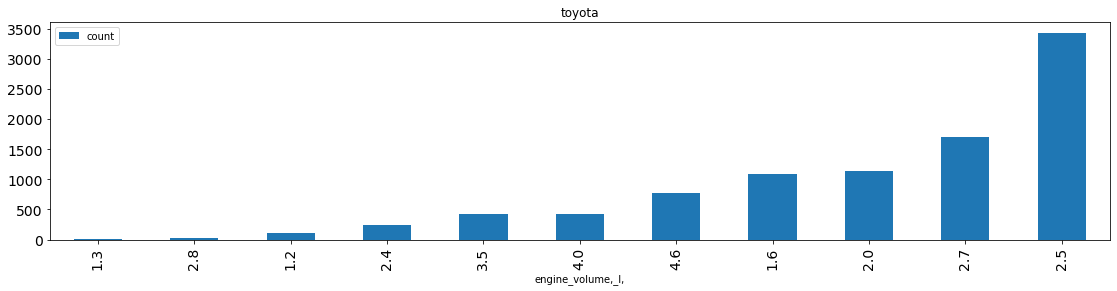

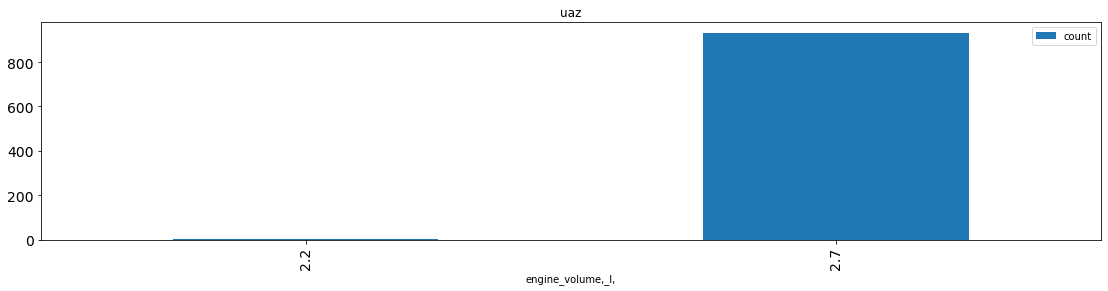

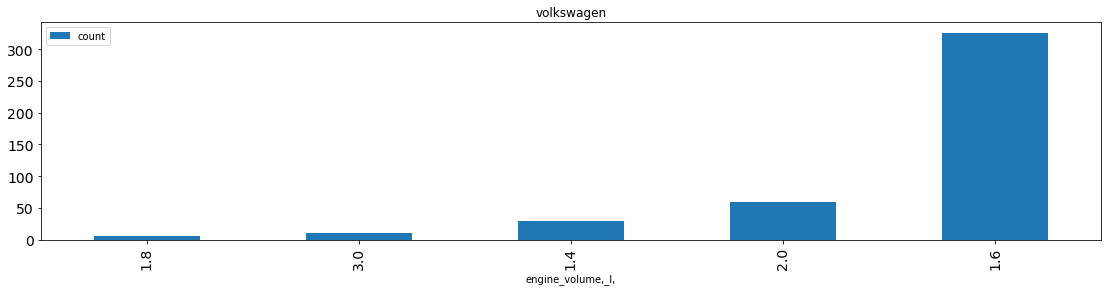

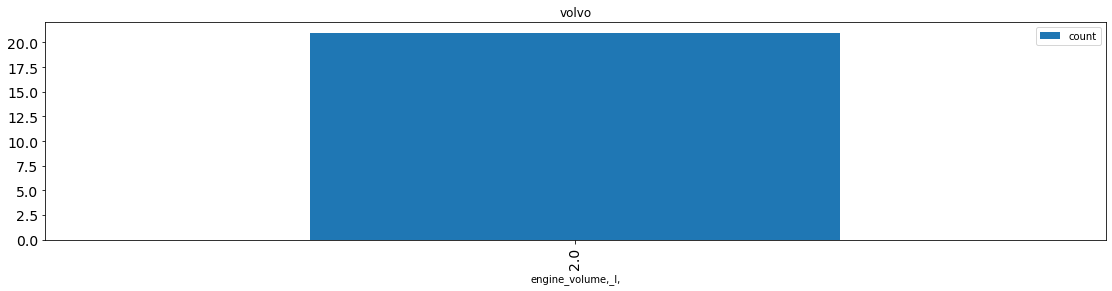

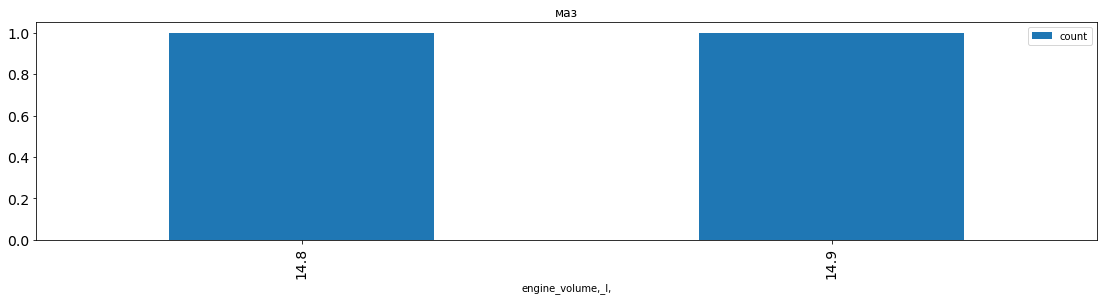

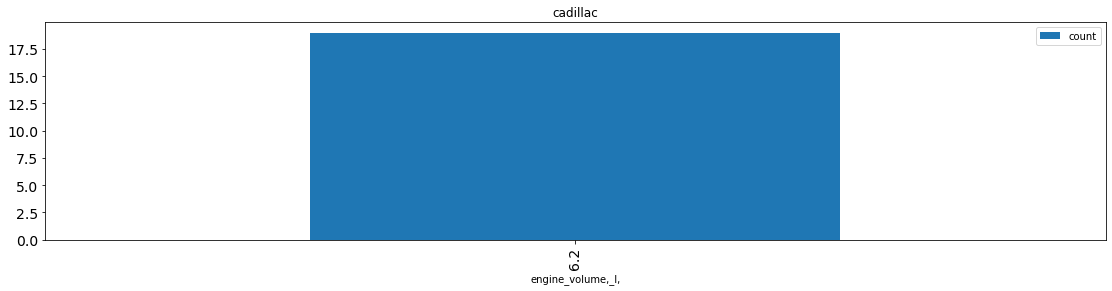

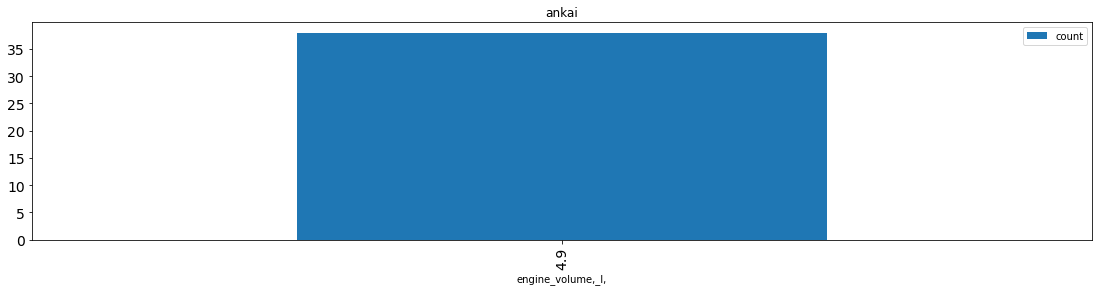

In [213]:
for i in df['brand'].unique():
    df[df['brand'] == i].groupby(['engine_volume,_l,'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='engine_volume,_l,',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

Вывод: 
- самые популярные объемы двигателей у лидеров бренды: hyundai (1.6 и 2.0), toyota (2.5) и lada (1.6)
- самые популярные объемы двигателей у антилидеров landrover (2.0), suzuki (1.3, 1.4), mersedes-benz (2.0)
- можно сделать вывод что самые популярные объемы: 1.6 и 2.0

Общий вывод по разделу анализ Брендов:
* самые популярные бренды: hyundai, toyota и lada
* самые не популярные landrover, suzuki, mersedes-benz
* самые дорогие машины брендов: porsche, cadillac
* самые дешевые машины брендов: lada, ravon
* как видно больше всего представлена в регионах toyota
* можно заметить что lada, gaz представлены в районах с уровнем дохода ниже среднего
* как видно что механика в основном представлена в российском автопроме и китайском.
* Остальные типы приводов разделены по производителям
* чисто автоматическая является самой популярной из устанавливаемой отсюда и лидерство, но стоит учитывать все вариации автоматических вместе
* toyota в основном предсталены в полном и переднеприводном сегменте
* uaz, gaz с подключаемомы
* hyndai в моноприводе
* самые популярные объемы двигателей у лидеров бренды: hyundai (1.6 и 2.0), toyota (2.5) и lada (1.6)
* самые популярные объемы двигателей у антилидеров landrover (2.0), suzuki (1.3, 1.4), mersedes-benz (2.0)
* можно сделать вывод что самые популярные объемы: 1.6 и 2.0
    

### статистический тест 

#### Влияние типа (вида) автомобиля на продажи

Сформулируем две гипотезы:
- H0: внедорожники не продаются чаще, в отличии от видов автомобилей
- H1: внедорожники продаются чаще, в отличии от видов автомобилей

In [344]:
df = df[~(df['quantity'].isnull())]

In [345]:
df_class_0 = df[(df['segmentation_2013'] == 'Внедорожники ')]['quantity'].sample(n=13000)
df_class_1 = df[~(df['segmentation_2013'] == 'Внедорожники ')]['quantity'].sample(n=13000)

<AxesSubplot:>

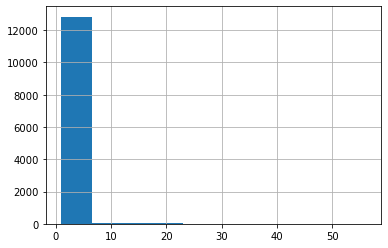

In [346]:
df_class_0.hist()

<AxesSubplot:>

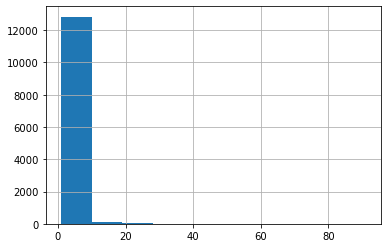

In [347]:
df_class_1.hist()

In [348]:
from scipy.stats import mannwhitneyu

alpha = .05
results = mannwhitneyu(
    df_class_0,
    df_class_1
)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  3.727089114699103e-28
Отвергаем нулевую гипотезу: разница статистически значима


Вывод: внедорожники продаются чаще, в отличии от видов автомобилей

#### Влияние трансмиссии на продажи

Сформулируем две гипотезы:
- H0: автомобили с автоматической трансмиссией не продаются чаще, в отличии от  автомобилей с другими видами коробки
- H1: автомобили с автоматической трансмиссией продаются чаще, в отличии от  автомобилей с другими видами коробки

In [364]:
df_transmition_0 = df[(df['transmition_group'] == 'at')]['quantity'].sample(n=10000)
df_transmition_1 = df[~(df['transmition_group'] == 'at')]['quantity'].sample(n=10000)

<AxesSubplot:>

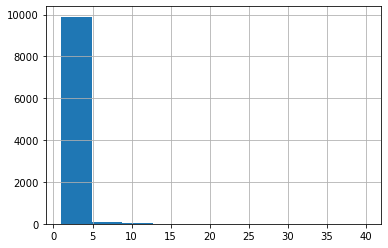

In [365]:
df_transmition_0.hist()

<AxesSubplot:>

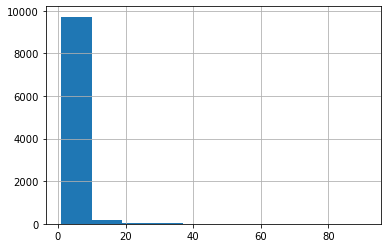

In [366]:
df_transmition_1.hist()

In [367]:
from scipy.stats import mannwhitneyu

alpha = .05
results = mannwhitneyu(
    df_transmition_0,
    df_transmition_1
)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  8.087662776682193e-153
Отвергаем нулевую гипотезу: разница статистически значима


Вывод: H1: автомобили с автоматической трансмиссией продаются чаще, в отличии от  автомобилей с другими видами коробки

#### Влияние типа привода на продажи

Сформулируем две гипотезы:
- H0: автомобили полноприводные не продаются чаще, в отличии от автомобилей с другими видами привода
- H1: автомобили полноприводные продаются чаще, в отличии от автомобилей с другими видами привода

In [368]:
df_wd_0 = df[(df['type_of_drive_group'] == '4wd')]['quantity'].sample(n=10000)
df_wd_1 = df[~(df['type_of_drive_group'] == '4wd')]['quantity'].sample(n=10000)

<AxesSubplot:>

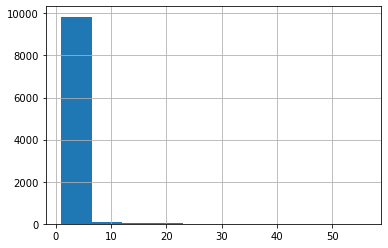

In [369]:
df_wd_0.hist()

<AxesSubplot:>

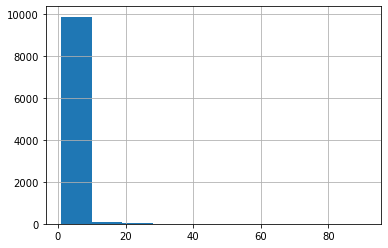

In [370]:
df_wd_1.hist()

In [371]:
from scipy.stats import mannwhitneyu

alpha = .05
results = mannwhitneyu(
    df_wd_0,
    df_wd_1
)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )

p-значение:  1.0675295296812368e-05
Отвергаем нулевую гипотезу: разница статистически значима


Вывод: H1: автомобили полноприводные продаются чаще, в отличии от автомобилей с другими видами привода

Общий вывод по разделу:
- внедорожники продаются чаще, в отличии от видов автомобилей
- автомобили с автоматической трансмиссией продаются чаще, в отличии от автомобилей с другими видами коробки
- автомобили полноприводные продаются чаще, в отличии от автомобилей с другими видами привода

### Зависимость цены от показателей


<AxesSubplot:>

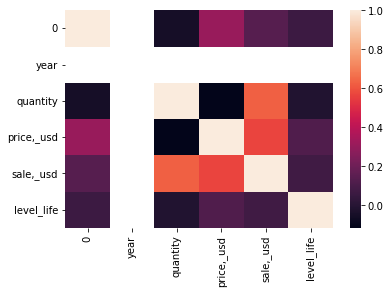

In [219]:
sns.heatmap(df.corr())

Рассмотрим зависимость цены от:
- суммы сделки
- от уровня заработной платы в регионе <br>
А так же зависимость суммы сделки:
- от уровня заработной платы в регионе

#### зависимость цены от суммы сделки

<AxesSubplot:xlabel='price,_usd', ylabel='sale,_usd'>

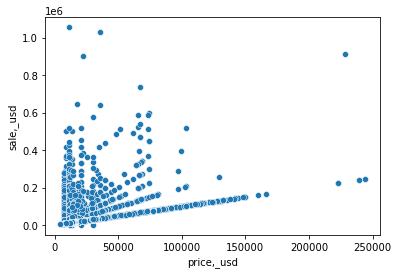

In [222]:
sns.scatterplot(data=df, x="price,_usd", y="sale,_usd") 

<AxesSubplot:xlabel='price,_usd', ylabel='sale,_usd'>

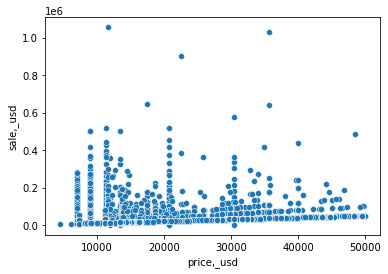

In [223]:
sns.scatterplot(data=df[df["price,_usd"] < 50000], x ="price,_usd", y="sale,_usd") 

<AxesSubplot:xlabel='price,_usd', ylabel='sale,_usd'>

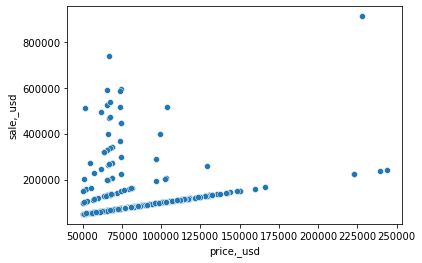

In [224]:
sns.scatterplot(data=df[df["price,_usd"] > 50000], x ="price,_usd", y="sale,_usd") 

Вывод: из полученных данных видно что очень небольшая зависимость видна в автомобилях дороже 50тыс., так зависимость цена на сумму сделки не видна

#### зависимость цены от уровня заработной платы в регионе

<AxesSubplot:xlabel='price,_usd', ylabel='level_life'>

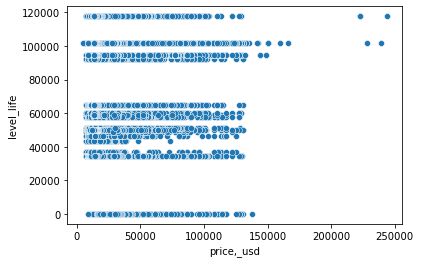

In [225]:
sns.scatterplot(data=df, x="price,_usd", y="level_life") 

Вывод: в основном зависимость не наблюдается, за исключением дорогово сегмента автомобилей, там видна небольшая зависимость.

#### зависимость суммы сделки от уровня заработной платы в регионе

<AxesSubplot:xlabel='sale,_usd', ylabel='level_life'>

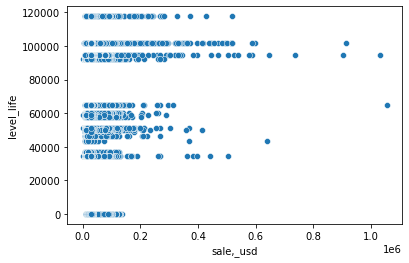

In [226]:
sns.scatterplot(data=df, x="sale,_usd", y="level_life") 

Вывод: зависимости не обнаружено.

In [220]:
df.columns

Index(['0', 'year', 'month', 'company', 'brand', 'model', 'modification',
       'year_of_issue', 'manufacturer_country', 'type_of_fuel',
       'engine_volume,_l,', 'transmission', 'type_of_drive', 'region',
       'dealership_name', 'client_type', 'quantity', 'price,_usd', 'sale,_usd',
       'city', 'segmentation_2013', 'class_of_2013', 'production_localization',
       'date', 'code_manufacturer_country', 'transmition_group',
       'type_of_drive_group', 'level_life'],
      dtype='object')

Общие выводы по разделу:
- из полученных данных видно что очень небольшая зависимость видна в автомобилях дороже 50тыс., так зависимость цены на сумму сделки не видна
- зависимость цены от уровня заработной платы в регионе не обнаружена
- зависимость суммы сделки от уровня заработной платы в регионе не обнаружена

### Динамика продаж по рынку (общая/компаниям/брендам/моделям)

<AxesSubplot:xlabel='date'>

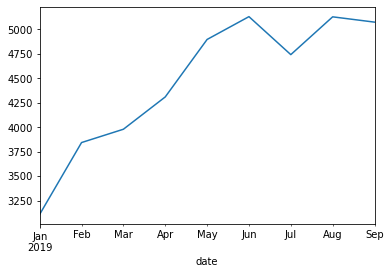

In [228]:
df.groupby('date')['quantity'].agg('sum').plot()

Вывод: в общем по рынку виден рост начиная с января. Замедление и снижение продаж в июле скорее всего связано с периодом отпусков.

#### Динамика продаж по рынку (компании) 

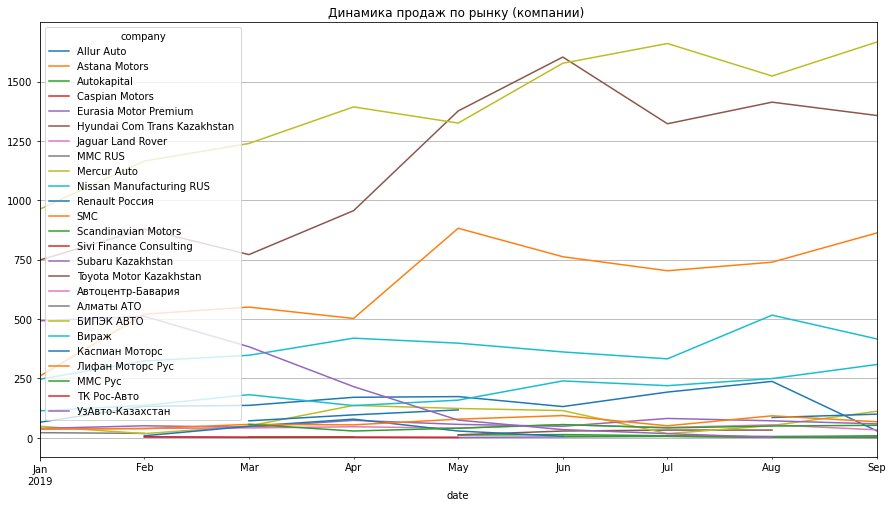

In [239]:
pd.pivot_table(
    df, index='company', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (компании) ')
plt.show()

Вывод: как видно из полученных данных у 3-х компаний идет рост к концу года (БИПЭК авто, Toyota Motor, SMC). У остальных компаний или в стагнации или снижение.

#### Динамика продаж по рынку (бренды)

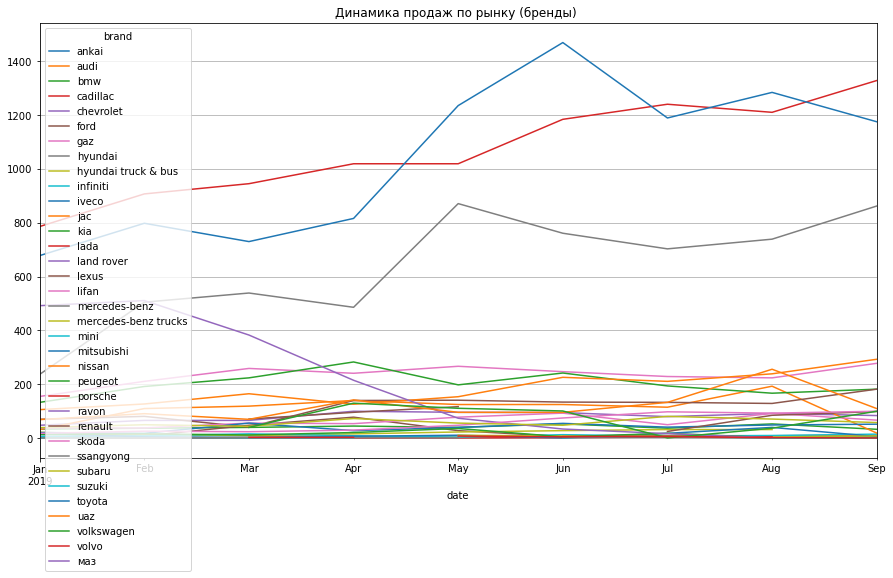

In [240]:
pd.pivot_table(
    df, index='brand', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (бренды) ')
plt.show()

Вывод: видно, что рост только у 3-х брендов toyota, lada, hyndai.

#### Динамика продаж по рынку (модели)
Только трех брендов:toyota, lada, hyndai.

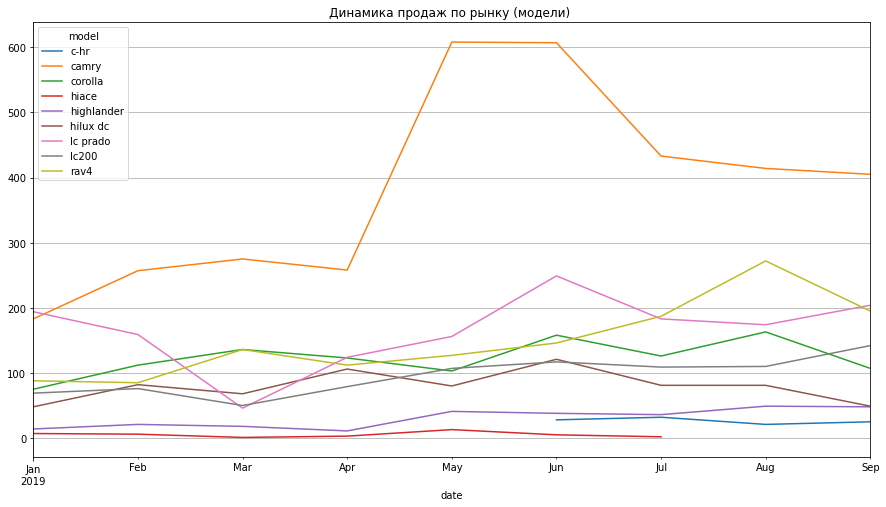

In [249]:
pd.pivot_table(
    df[(df['brand'] == 'toyota')], index='model', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (модели) ')
plt.show()

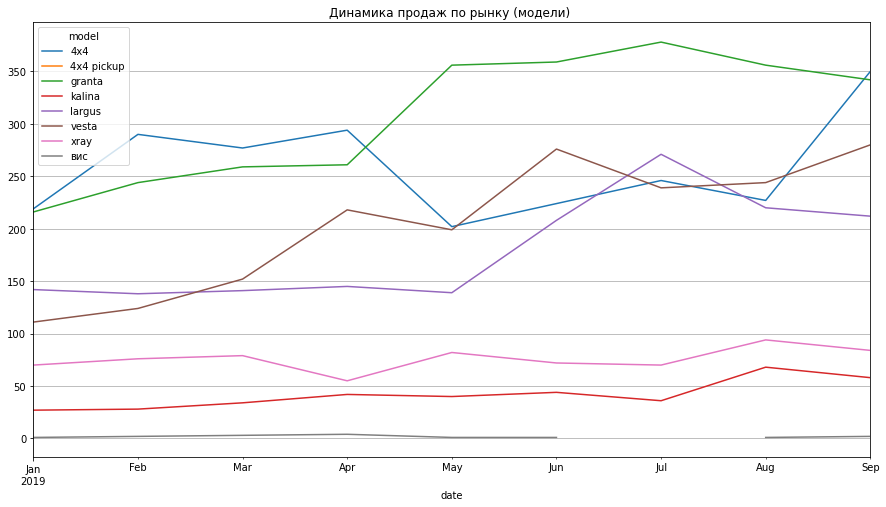

In [248]:
pd.pivot_table(
    df[(df['brand'] == 'lada')], index='model', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (модели) ')
plt.show()

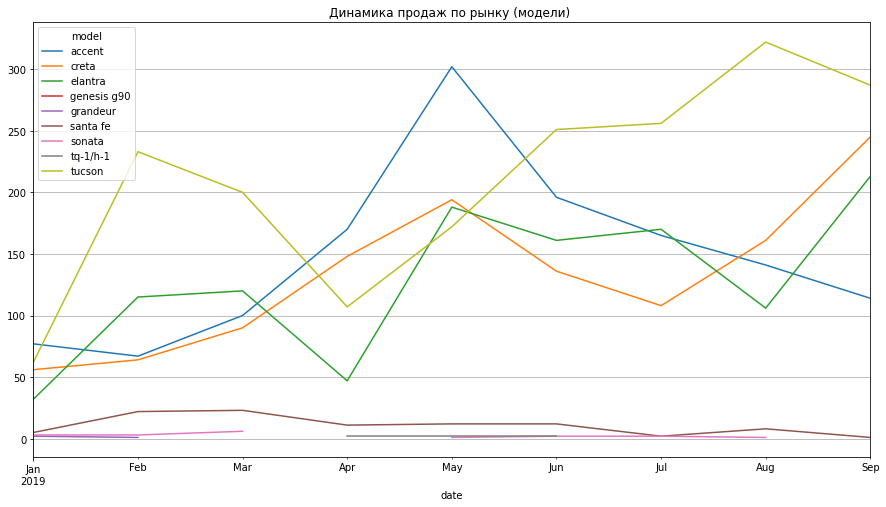

In [247]:
pd.pivot_table(
    df[(df['brand'] == 'hyundai')], index='model', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (модели) ')
plt.show()

Вывод: видно, что у toyota:
- снижение: camry
- рост у prado
<br>
у lada:
- снижение у granta
- рост у 4х4
<br>
у hyndai:
- снижение у accent
- рост у creta, elantra

#### Динамика продаж по рынку (коробка передач)

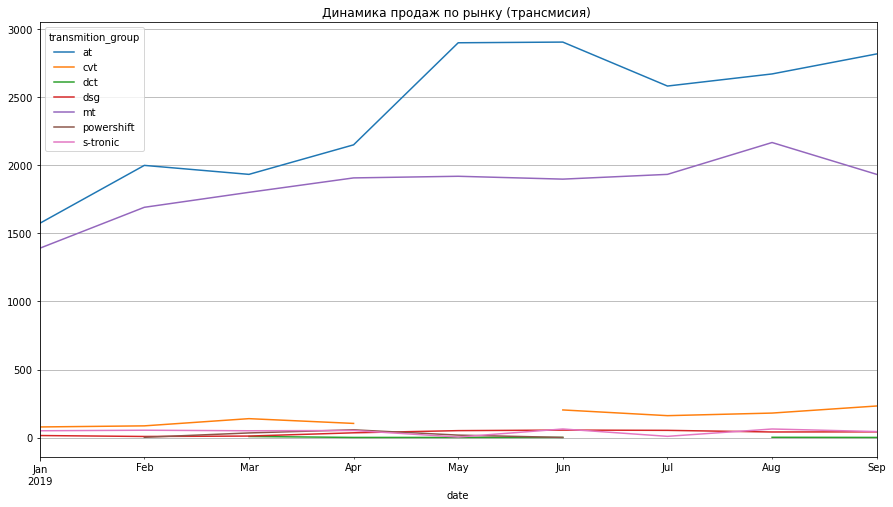

In [253]:
pd.pivot_table(
    df, index='transmition_group', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (трансмисия) ')
plt.show()

Вывод: 
- ведущие по продажам коробки: автомат и механика
- рост у автомата
- небольшое снижение у механики

#### Динамика продаж по рынку (привод)

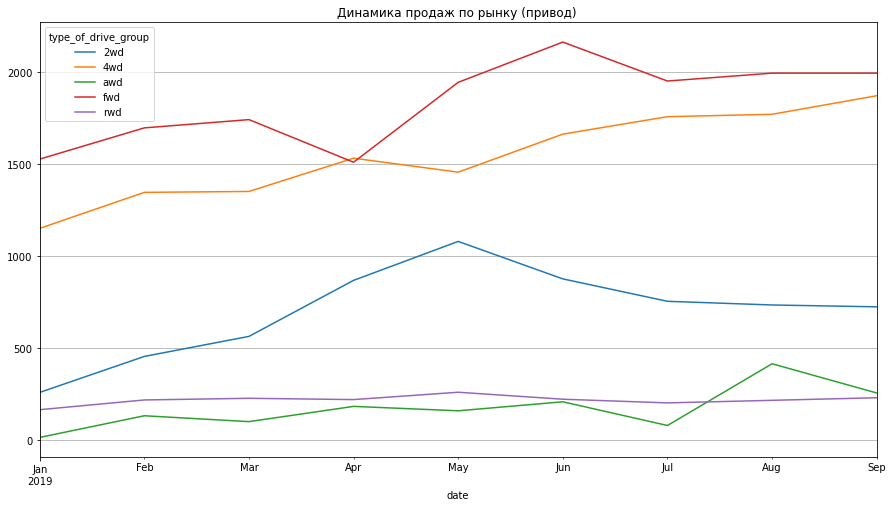

In [254]:
pd.pivot_table(
    df, index='type_of_drive_group', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (привод) ')
plt.show()

Вывод:
- лидеры: полноприводные и перед. приводные
- небольшое снижение у перед. приводных
- рост у полноприводных

#### Динамика продаж по рынку (объем двигателя)

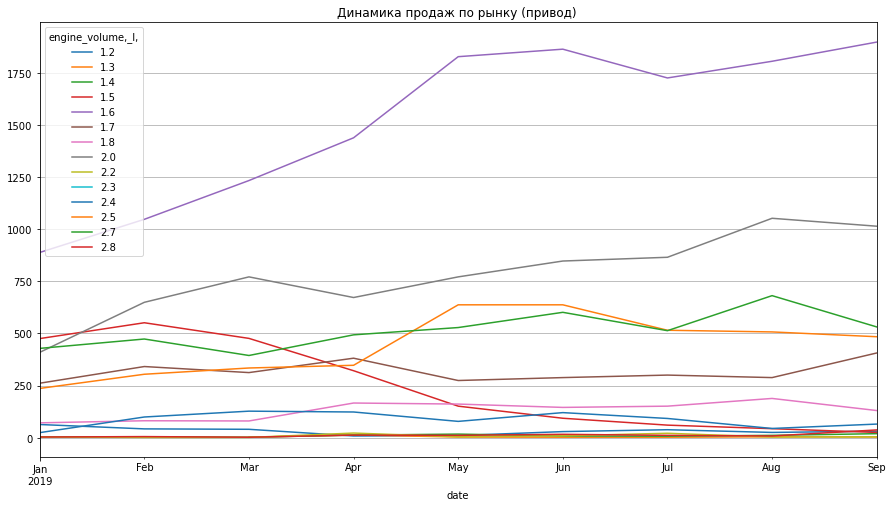

In [260]:
pd.pivot_table(
    df[df['engine_volume,_l,'] < 3], index='engine_volume,_l,', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по рынку (привод) ')
plt.show()

Вывод: из полученных данных видно, что у авто с 1.6л начался сильный рост к концу года. Так же ростут продажи автомобилей с 2.0л

Общий вывод по разделу:
- в общем по рынку виден рост продаж начиная с января. Замедление и снижение продаж в июле скорее всего связано с периодом отпусков.
- как видно из полученных данных у 3-х компаний идет рост продаж к концу года (БИПЭК авто, Toyota Motor, SMC). У остальных компаний или в стагнации или снижение.
- видно, что рост продаж только у 3-х брендов toyota, lada, hyndai.
- видно, что у toyota:
    * снижение продаж: camry
    * рост продаж у prado
    * - у lada:
- снижение продаж у granta
    * рост продаж у 4х4
- у hyndai:
    * снижение продаж у accent
    * рост продаж у creta, elantra
- ведущие по продажам коробки: автомат и механика
- рост продаж  у автомата
- небольшое снижение продаж у механики
- лидеры по продажам: полноприводные и перед. приводные
- небольшое снижение продаж у перед. приводных
- рост продаж у полноприводных
- из полученных данных видно, что у авто с 1.6л начался сильный рост продаж к концу года. Так же ростут продажи автомобилей с 2.0л

## Анализ компании Mercur Auto
Рассмотрим:
- кол-во представительств
- основной сегмент
- основной класс автомобилей
- основной бренд
- основная коробка
- основной привод
- основной объем двигателя
- средняя/медианная/максимальная/минимальная цена авто
- кол-во продаж общий по компании
- кол-во продаж по представительствам
- кол-во выручки общий по компании
- кол-во выручки по представительствам
- доля рынка дилера(количественный/стоимостном выражении)
- доля рынка дилера по маркам
- доля рынка дилера по типу авто

In [250]:
df.columns

Index(['0', 'year', 'month', 'company', 'brand', 'model', 'modification',
       'year_of_issue', 'manufacturer_country', 'type_of_fuel',
       'engine_volume,_l,', 'transmission', 'type_of_drive', 'region',
       'dealership_name', 'client_type', 'quantity', 'price,_usd', 'sale,_usd',
       'city', 'segmentation_2013', 'class_of_2013', 'production_localization',
       'date', 'code_manufacturer_country', 'transmition_group',
       'type_of_drive_group', 'level_life'],
      dtype='object')

#### кол-во представительств

In [268]:
df[df['company'] == 'Mercur Auto']['dealership_name'].unique()

array(['mercur auto алматы', 'mercur auto астана', 'автодом костанай',
       'mercur auto атырау', 'автомир-центр караганда',
       'eurasia motor zhaik', 'eurasia motors uralsk'], dtype=object)

Вывод: из данных видно, что компания имеет 7 представительств в разных городах.

#### основной сегмент

In [270]:
df[df['company'] == 'Mercur Auto']['segmentation_2013'].unique()

array(['Легковые автомобили ', 'Внедорожники ', 'Пикапы ', 'Минивэны',
       'Коммерческие автомобили '], dtype=object)

<AxesSubplot:title={'center':'Scandinavian Motors'}, xlabel='segmentation_2013'>

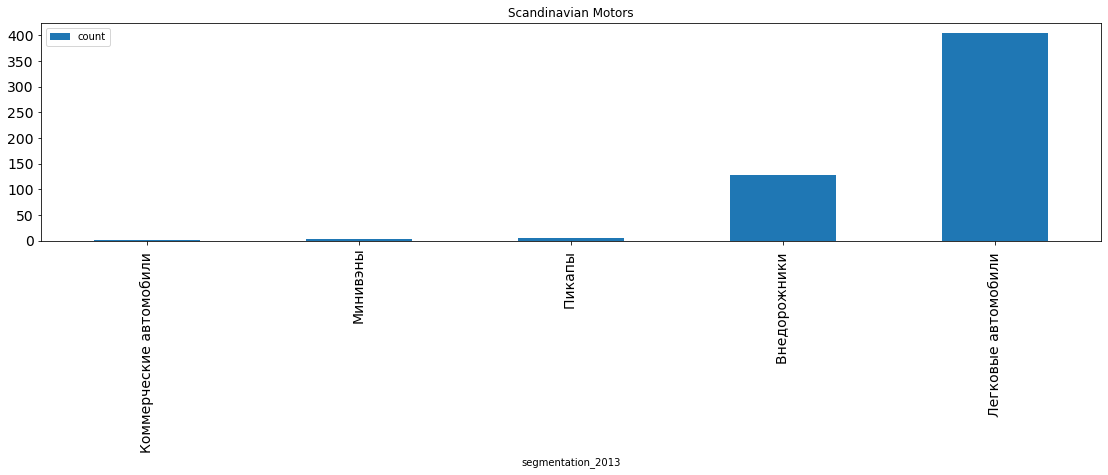

In [271]:
df[df['company'] == 'Mercur Auto'].groupby(['segmentation_2013'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='segmentation_2013',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

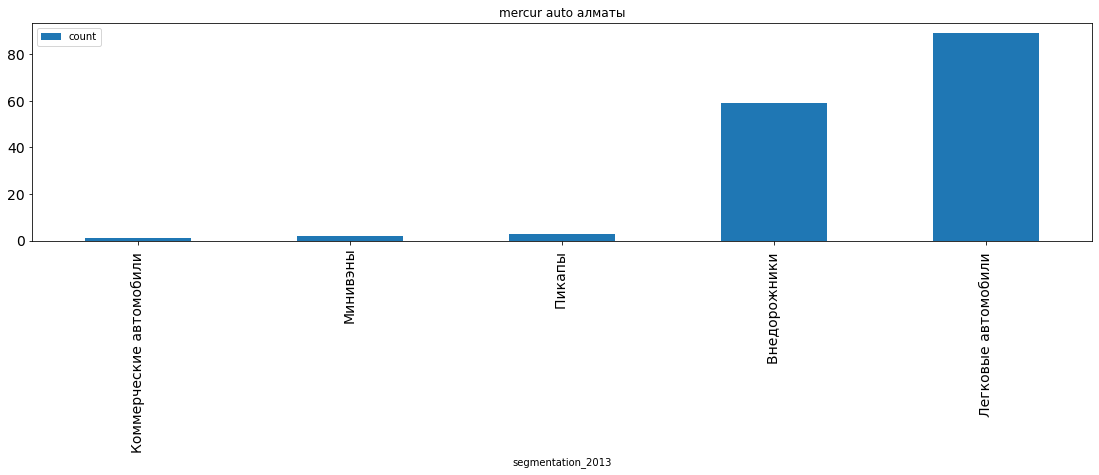

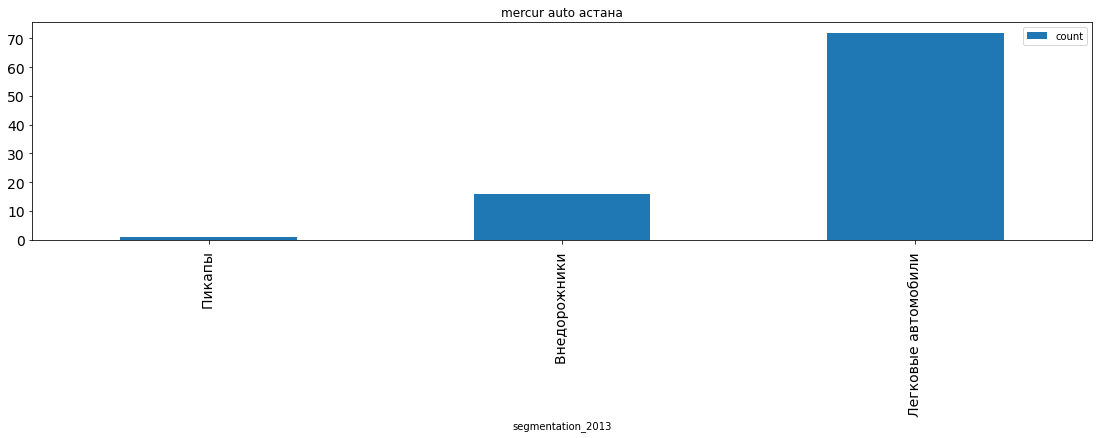

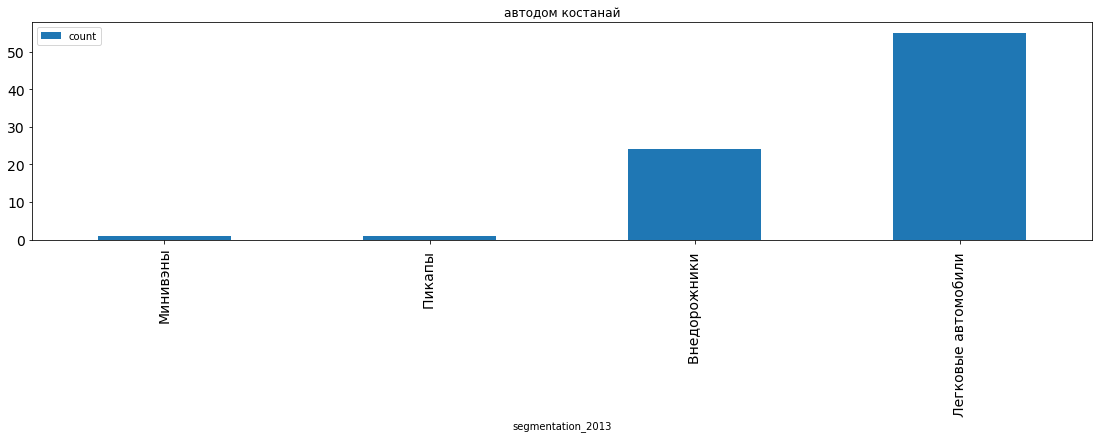

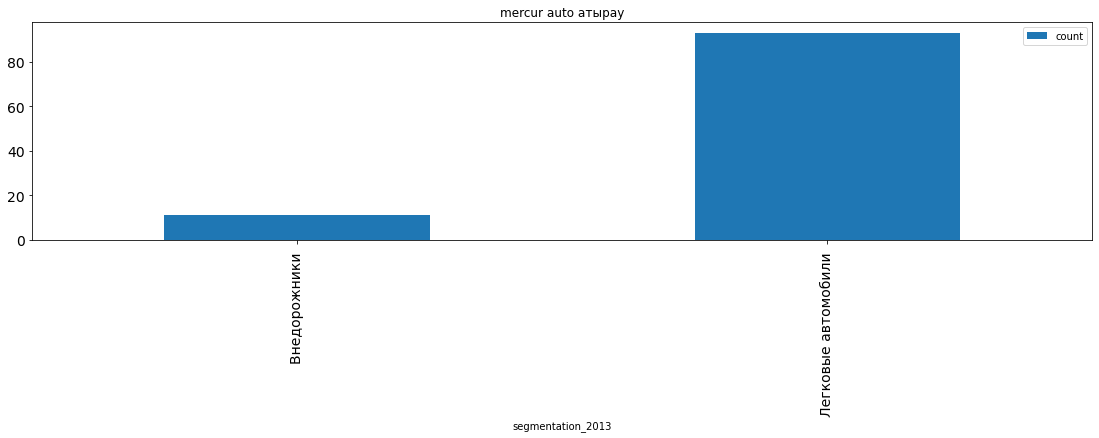

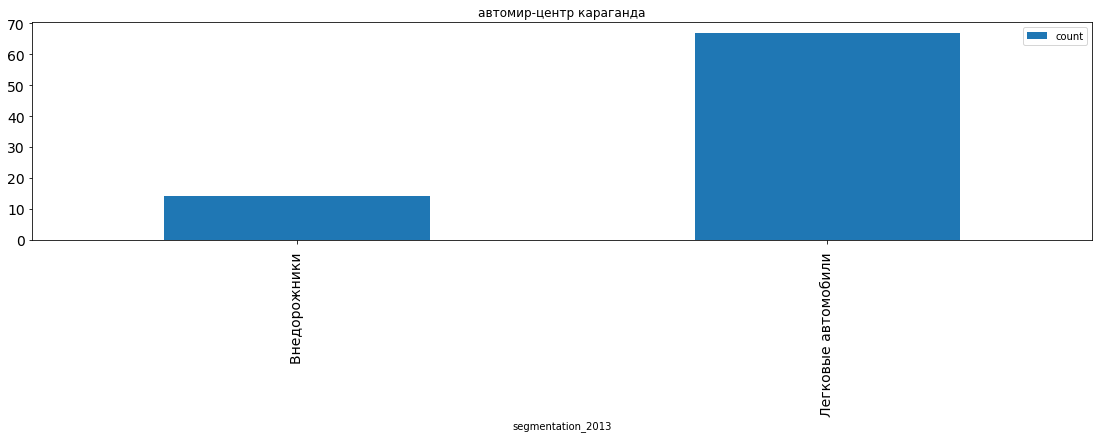

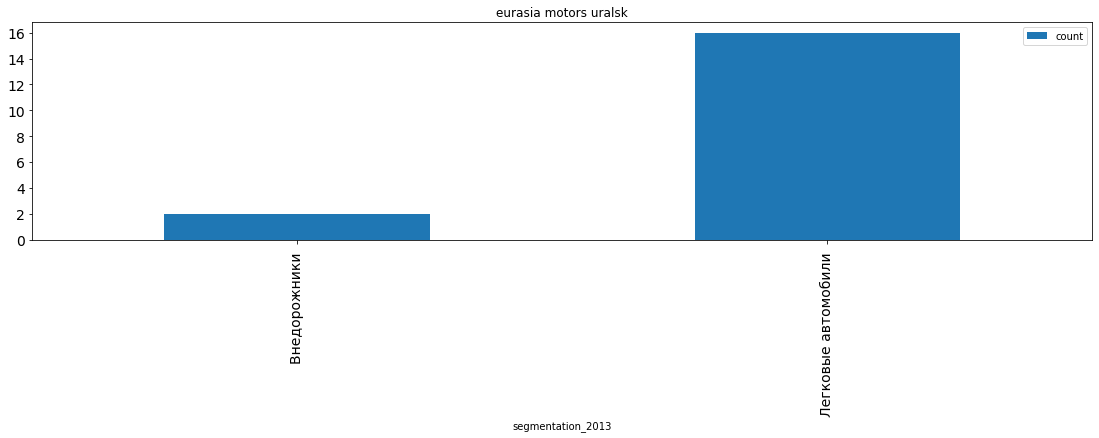

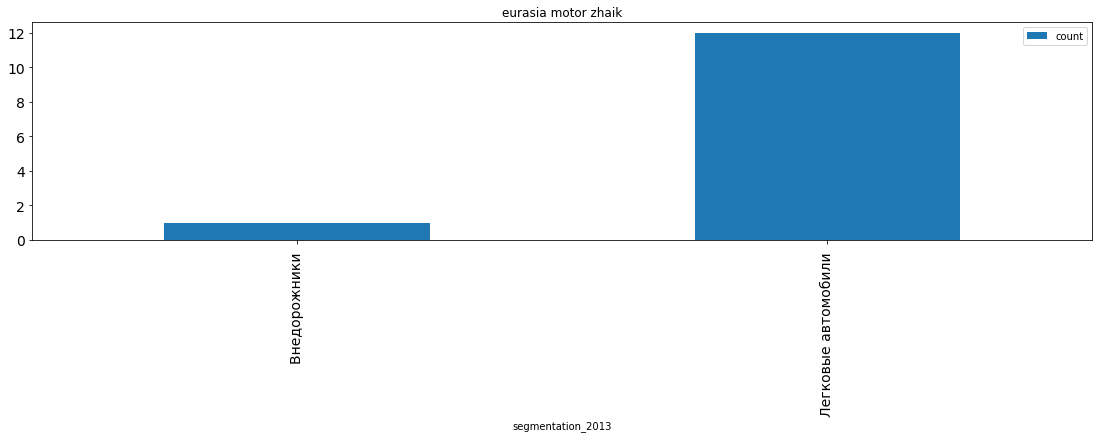

In [273]:
for i in df['dealership_name'].unique():
    if df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['0'].count() > 0:
        df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)].groupby(['segmentation_2013'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                    x='segmentation_2013',
                    y="count",
                    kind="bar",
                    rot=90,
                    fontsize=14,
                    figsize=(19,4),
                    title=i
                )

Вывод: основной сегмент автомобилей компании это Легковые автомобили. Так же в компании представлены внедорожники. В. некоторых представительствах есть комерч. автотранспорт, пикапы и минивены.

#### основной класс автомобилей

<AxesSubplot:title={'center':'volvo car almaty'}, xlabel='class_of_2013'>

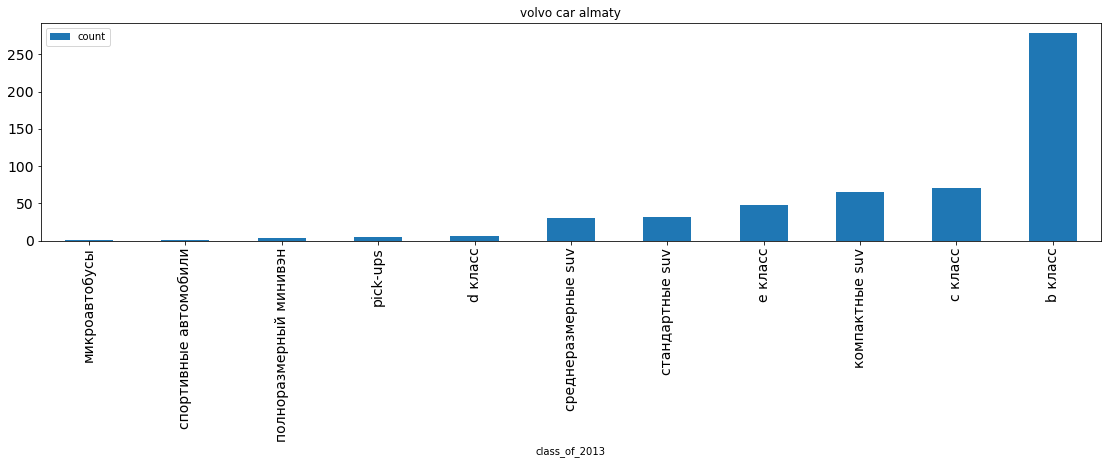

In [286]:
df[df['company'] == 'Mercur Auto'].groupby(['class_of_2013'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='class_of_2013',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

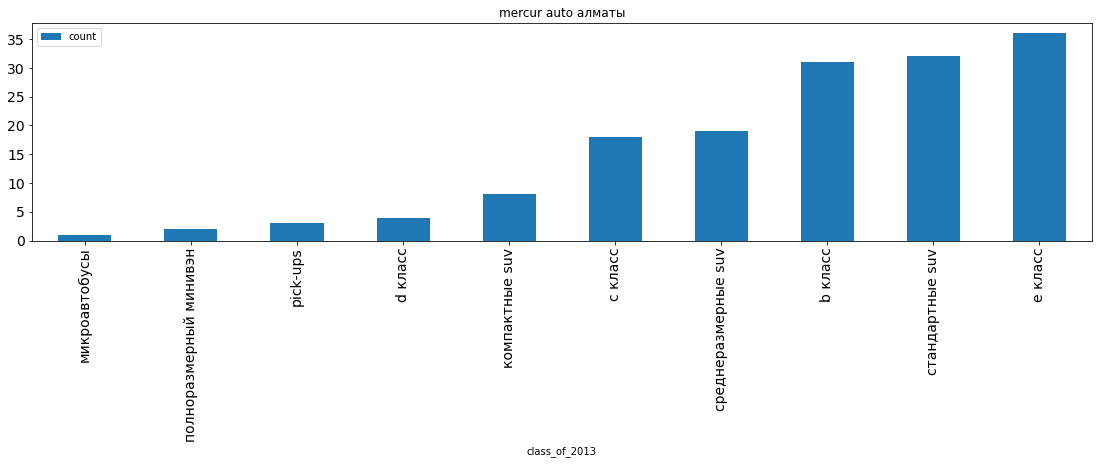

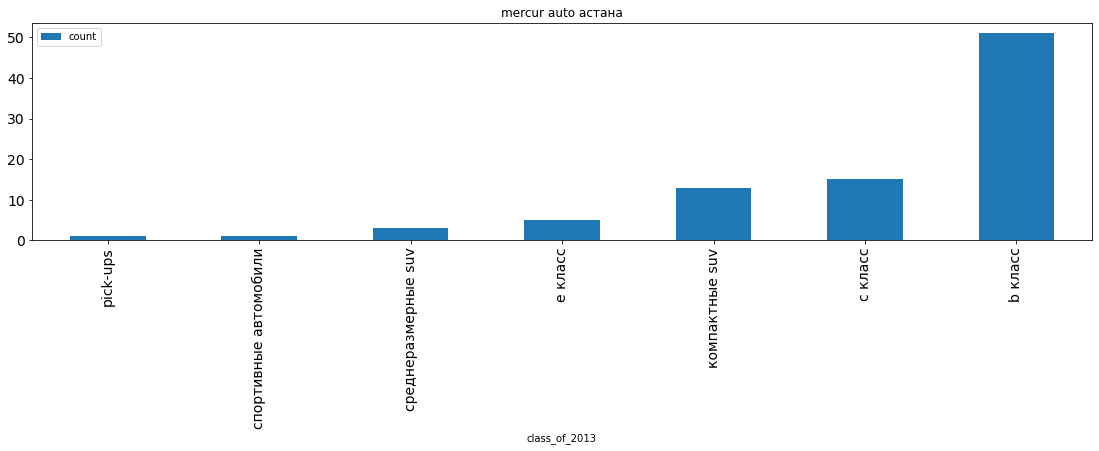

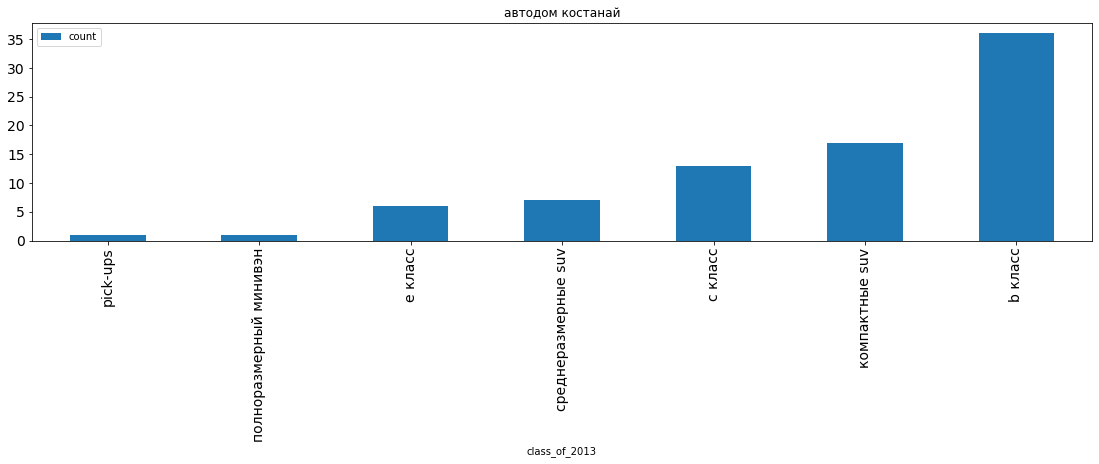

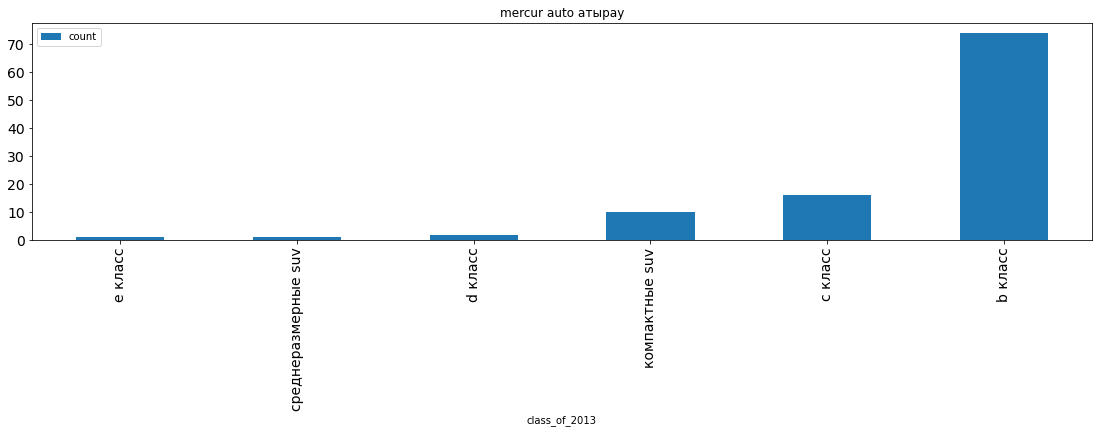

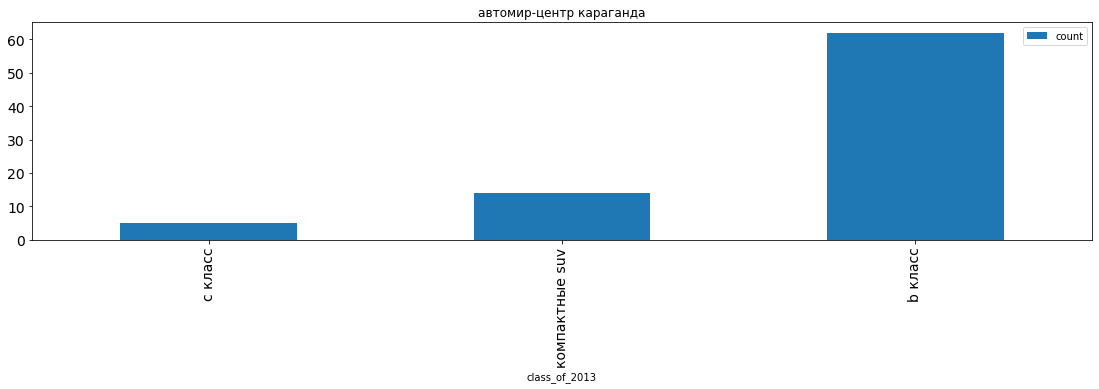

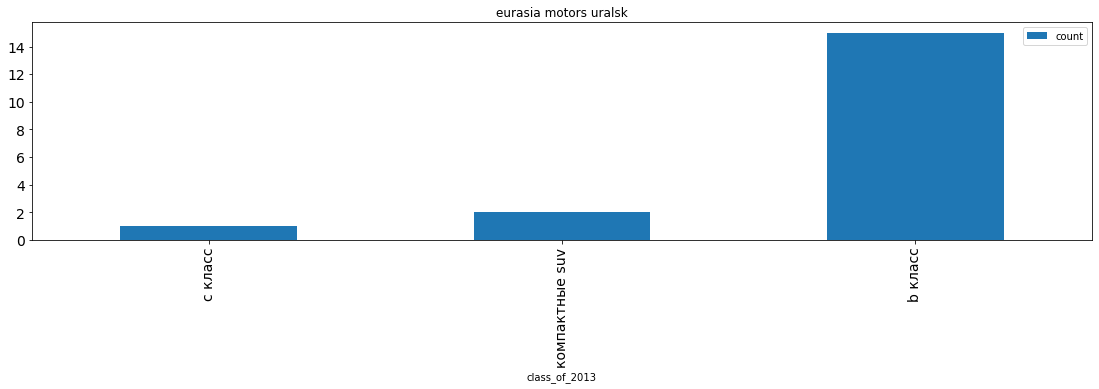

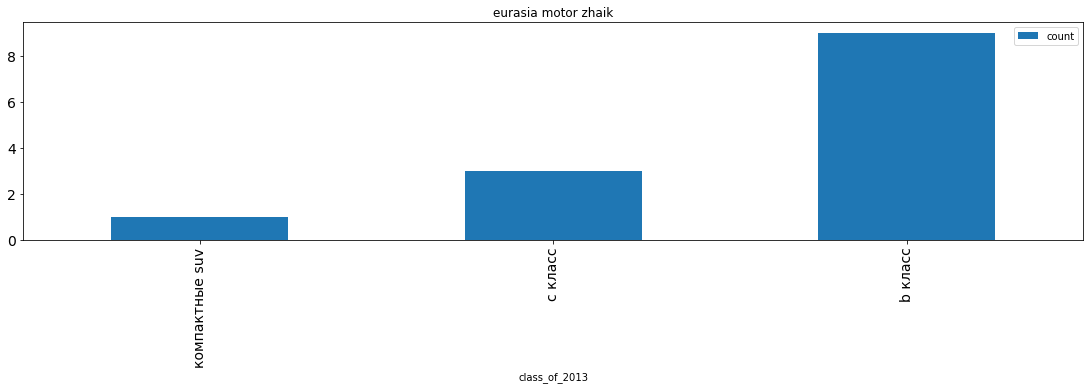

In [287]:
for i in df['dealership_name'].unique():
    if df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['0'].count() > 0:
        df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)].groupby(['class_of_2013'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                    x='class_of_2013',
                    y="count",
                    kind="bar",
                    rot=90,
                    fontsize=14,
                    figsize=(19,4),
                    title=i
                )

Вывод:
- во всех представительствах основной класс авто: b класс, кромя представительствав Алмате.
- в Алмате еще равно допредставлены: b класс, e класс, стандартные suv.

#### основной бренд

<AxesSubplot:title={'center':'volvo car almaty'}, xlabel='brand'>

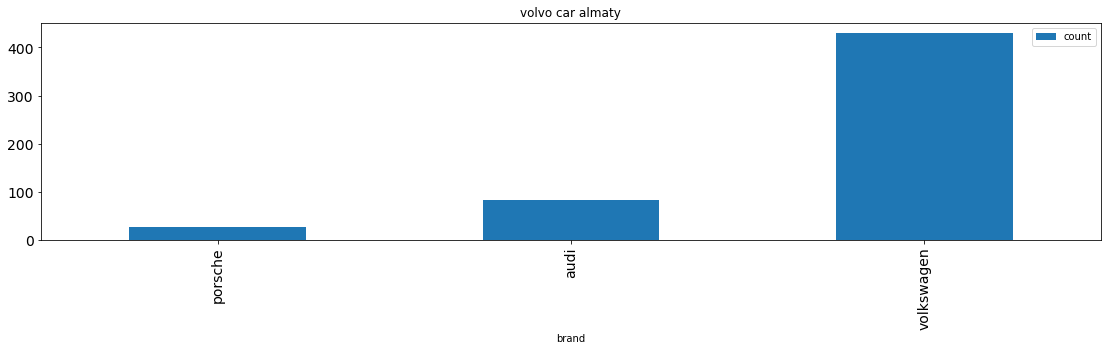

In [290]:
df[df['company'] == 'Mercur Auto'].groupby(['brand'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='brand',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

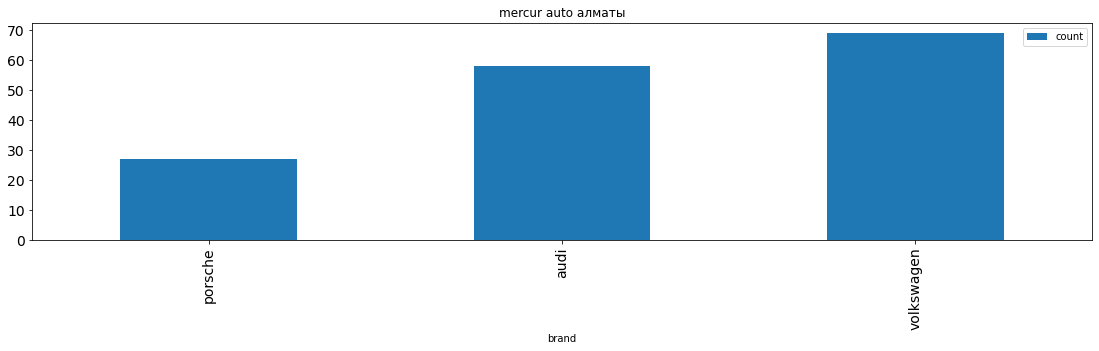

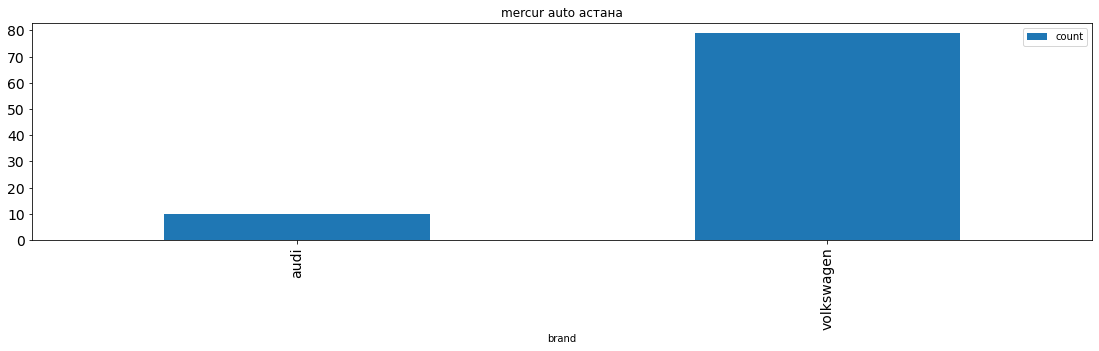

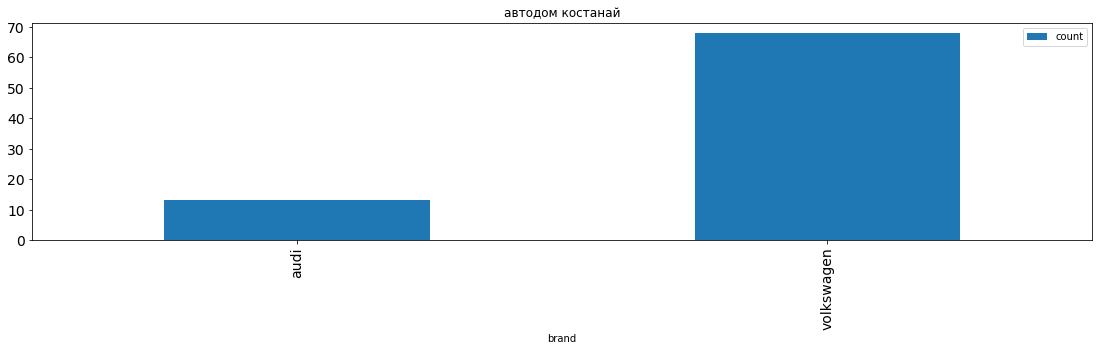

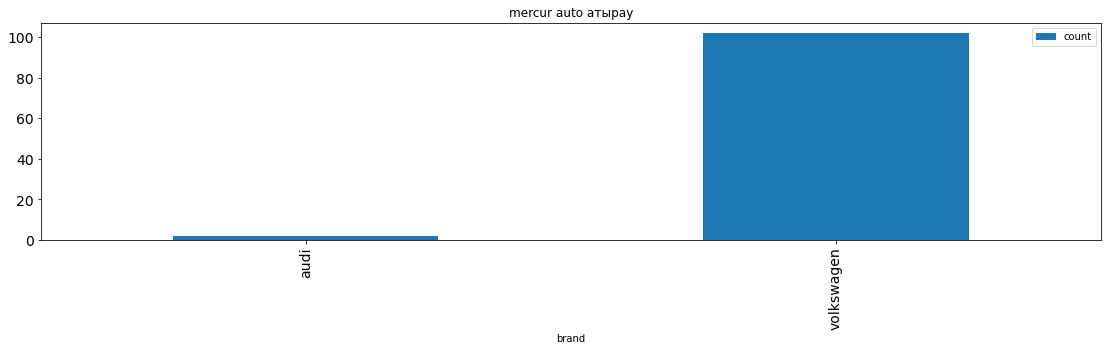

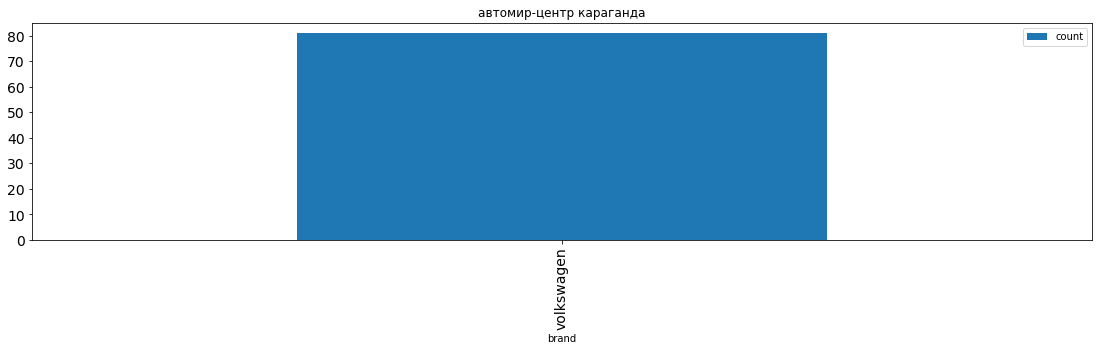

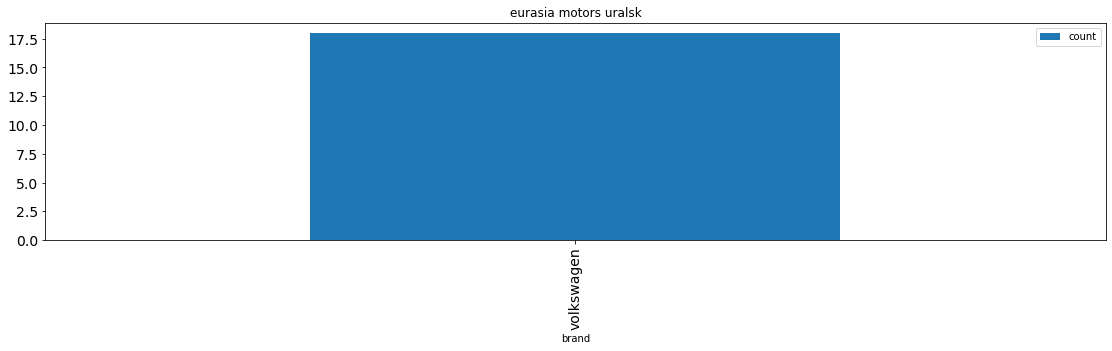

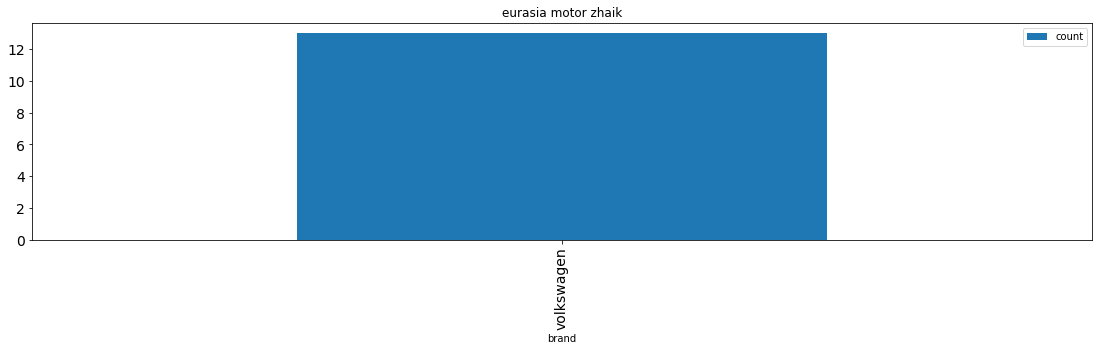

In [291]:
for i in df['dealership_name'].unique():
    if df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['0'].count() > 0:
        df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)].groupby(['brand'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                    x='brand',
                    y="count",
                    kind="bar",
                    rot=90,
                    fontsize=14,
                    figsize=(19,4),
                    title=i
                )

Вывод:
- основной бренд компании VW

#### основная коробка

<AxesSubplot:title={'center':'volvo car almaty'}, xlabel='transmition_group'>

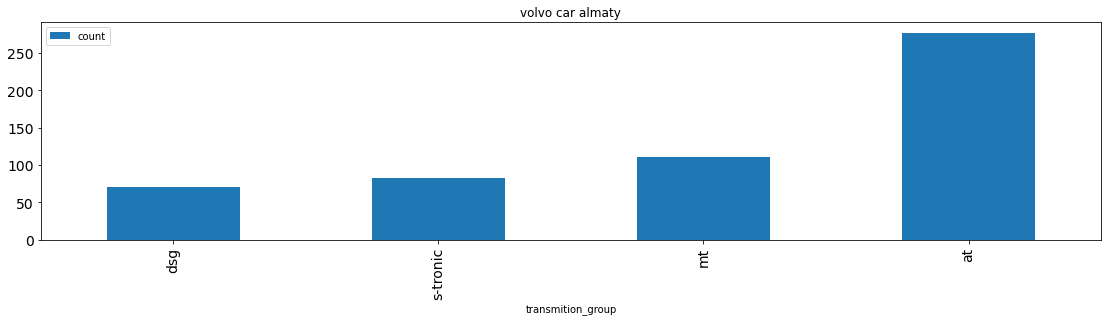

In [292]:
df[df['company'] == 'Mercur Auto'].groupby(['transmition_group'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='transmition_group',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

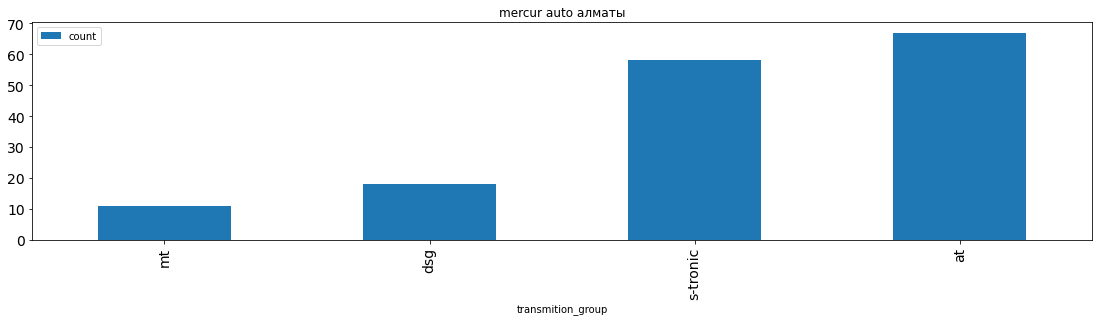

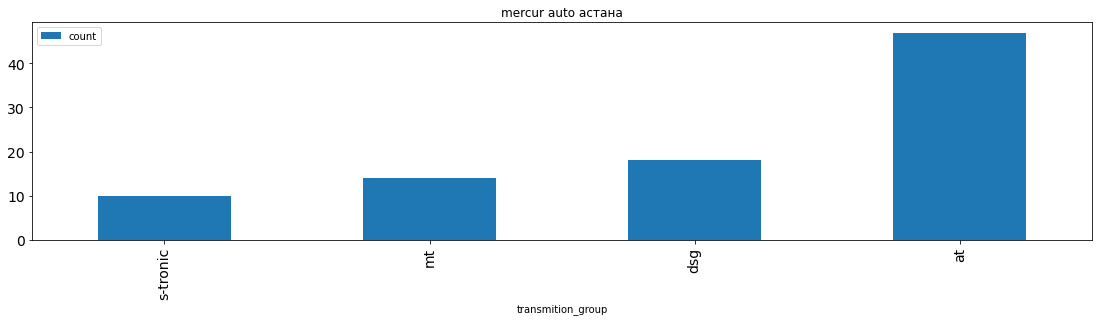

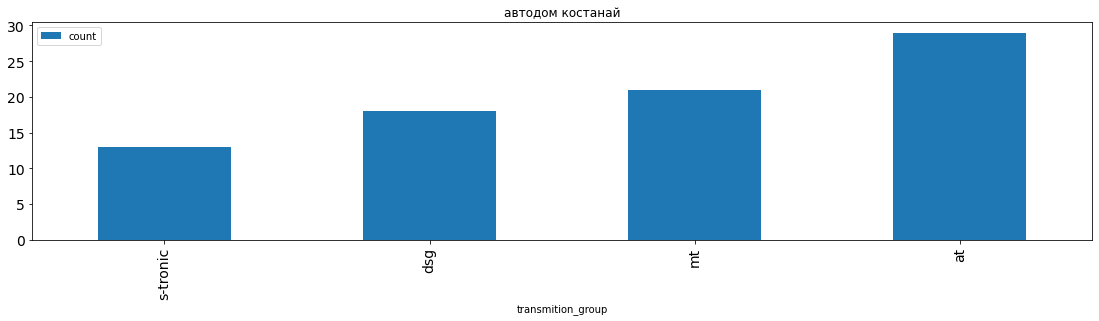

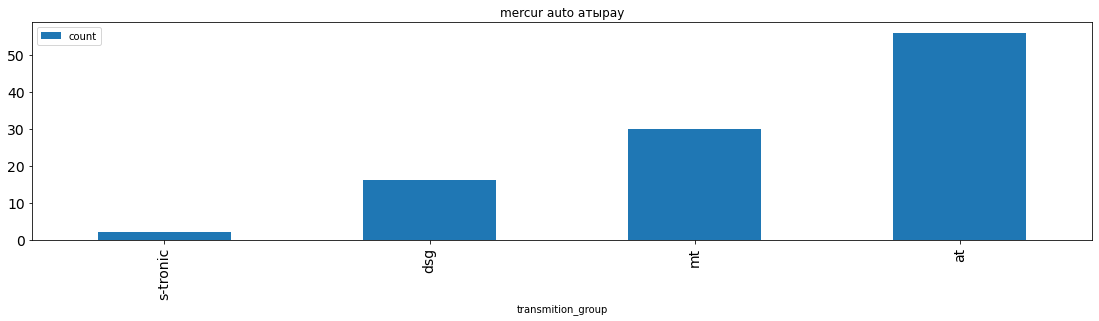

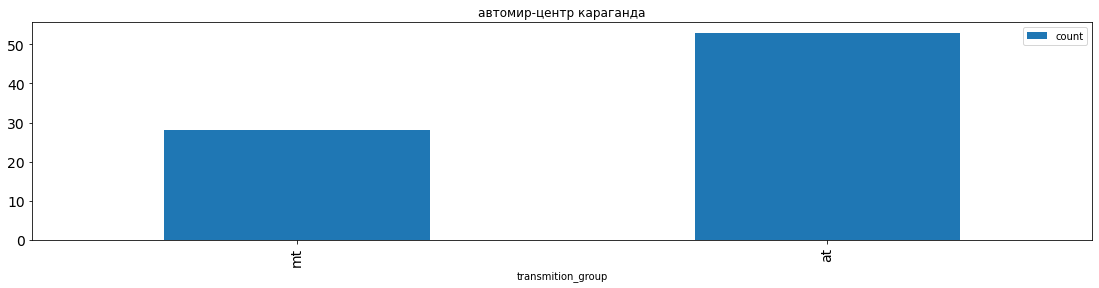

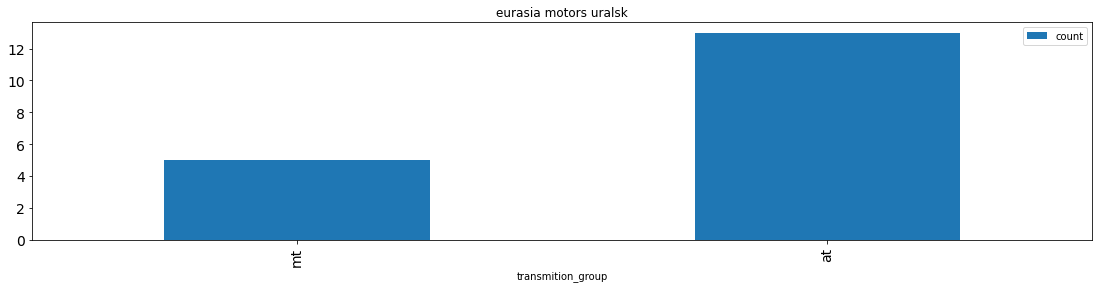

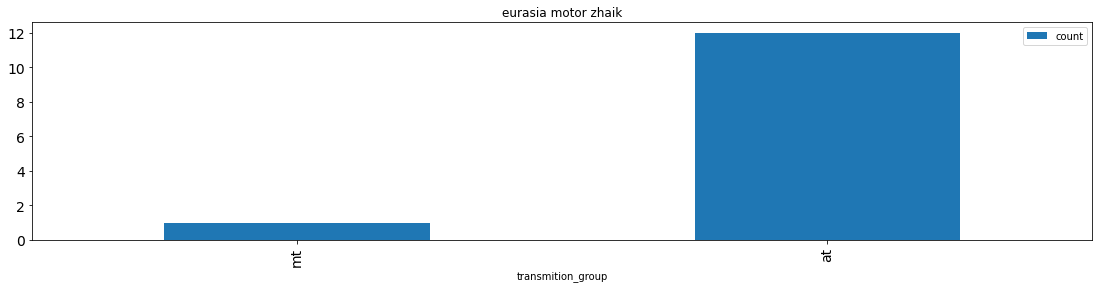

In [293]:
for i in df['dealership_name'].unique():
    if df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['0'].count() > 0:
        df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)].groupby(['transmition_group'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                    x='transmition_group',
                    y="count",
                    kind="bar",
                    rot=90,
                    fontsize=14,
                    figsize=(19,4),
                    title=i
                )

Вывод:
- основная трансмиссия автоматическая или ее другие вариации (тк в некоторых марках автомабилей ставятся другие вариации автоматической трансмиссии)

#### основной привод

<AxesSubplot:title={'center':'volvo car almaty'}, xlabel='type_of_drive_group'>

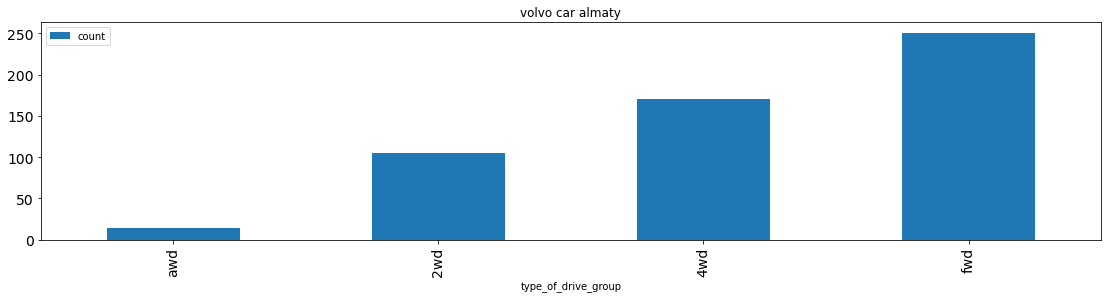

In [294]:
df[df['company'] == 'Mercur Auto'].groupby(['type_of_drive_group'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='type_of_drive_group',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

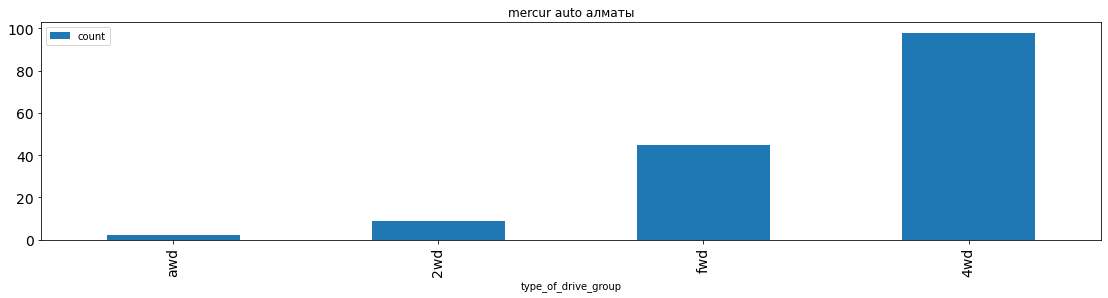

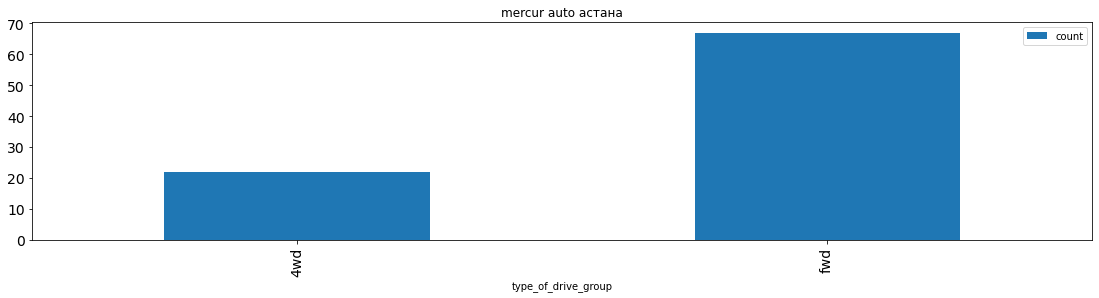

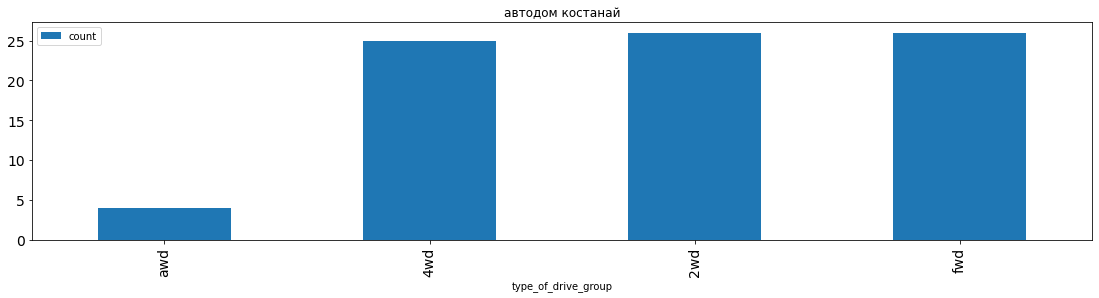

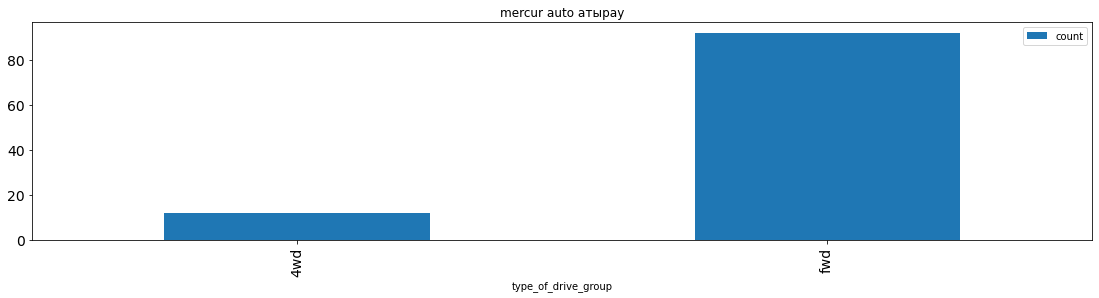

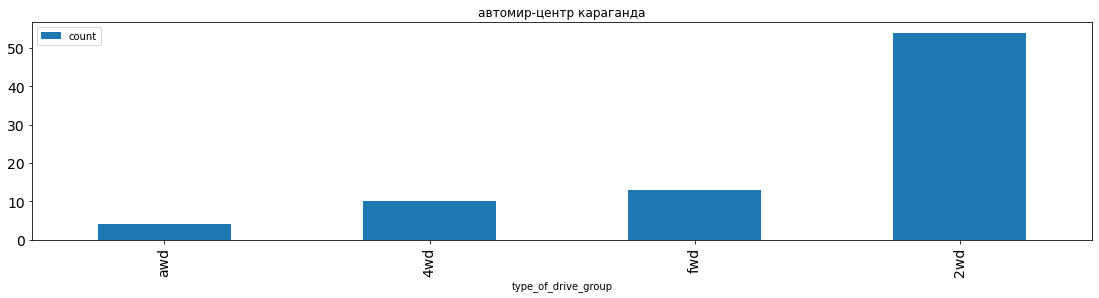

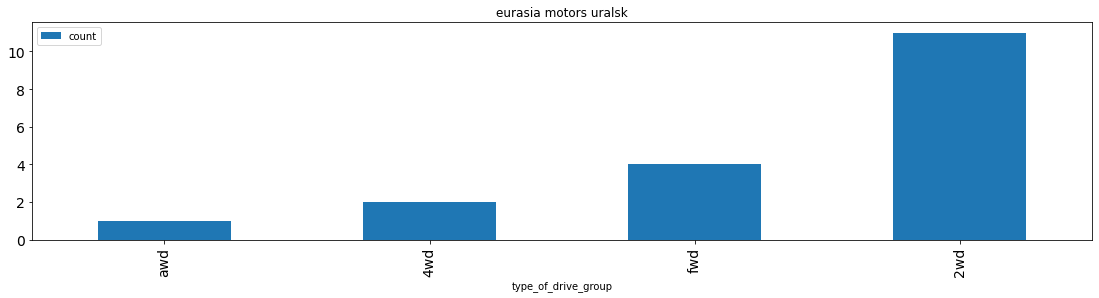

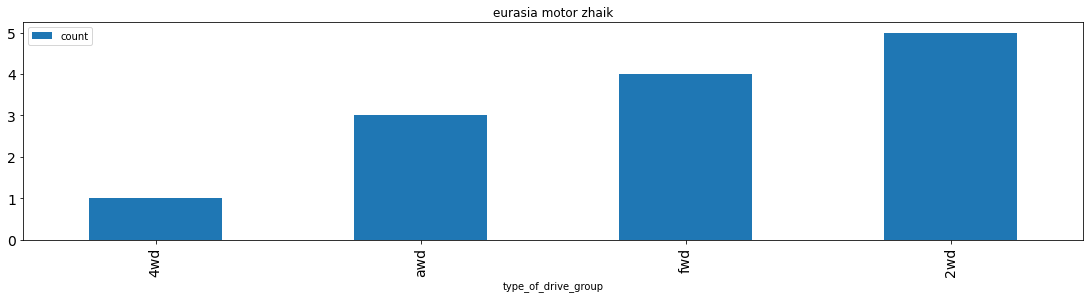

In [295]:
for i in df['dealership_name'].unique():
    if df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['0'].count() > 0:
        df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)].groupby(['type_of_drive_group'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                    x='type_of_drive_group',
                    y="count",
                    kind="bar",
                    rot=90,
                    fontsize=14,
                    figsize=(19,4),
                    title=i
                )

Вывод:
- в основном представлен передний привод
- в г.Алмате доминирует полноприводные автомобили

#### основной объем двигателя

<AxesSubplot:title={'center':'volvo car almaty'}, xlabel='engine_volume,_l,'>

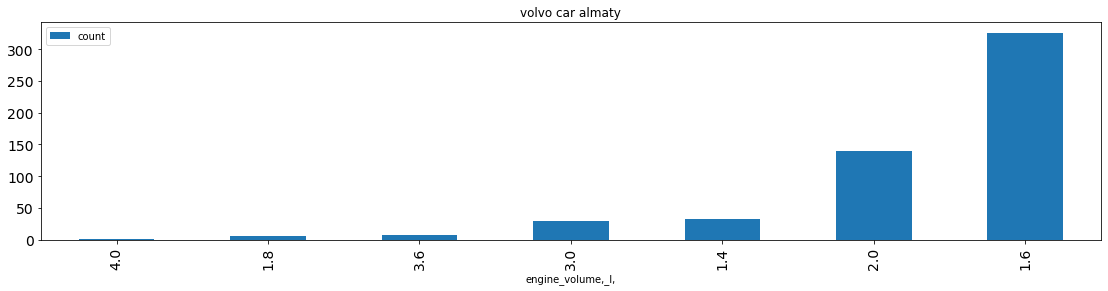

In [296]:
df[df['company'] == 'Mercur Auto'].groupby(['engine_volume,_l,'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                x='engine_volume,_l,',
                y="count",
                kind="bar",
                rot=90,
                fontsize=14,
                figsize=(19,4),
                title=i
            )

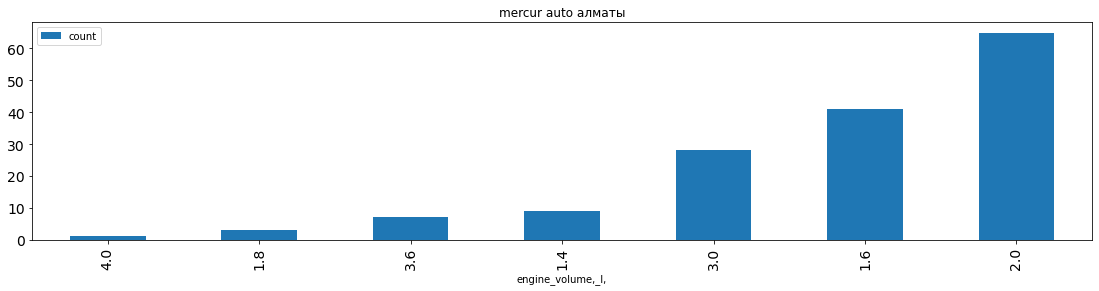

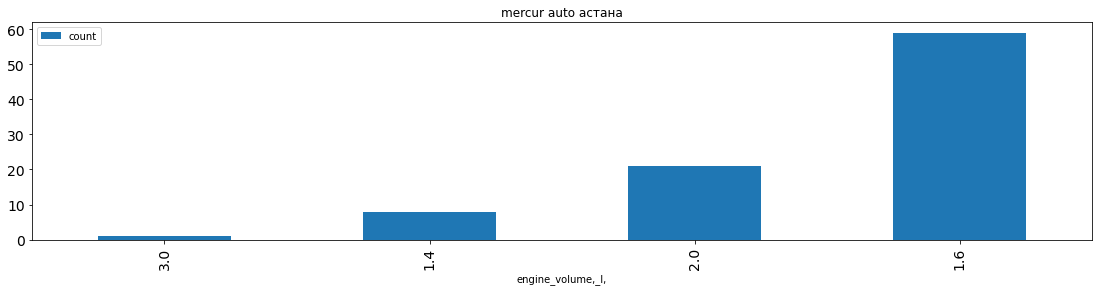

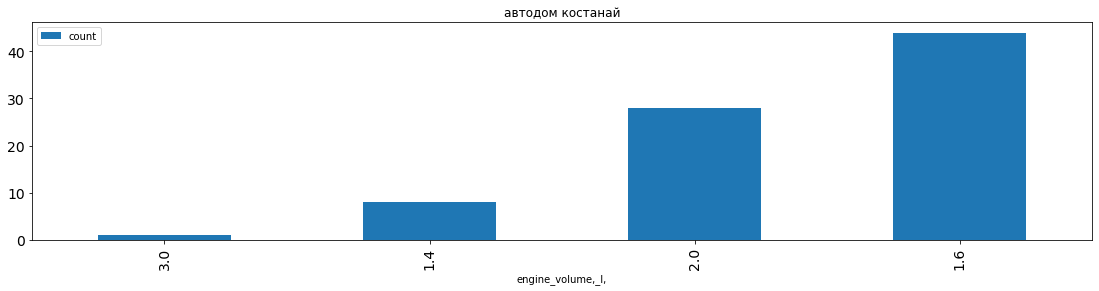

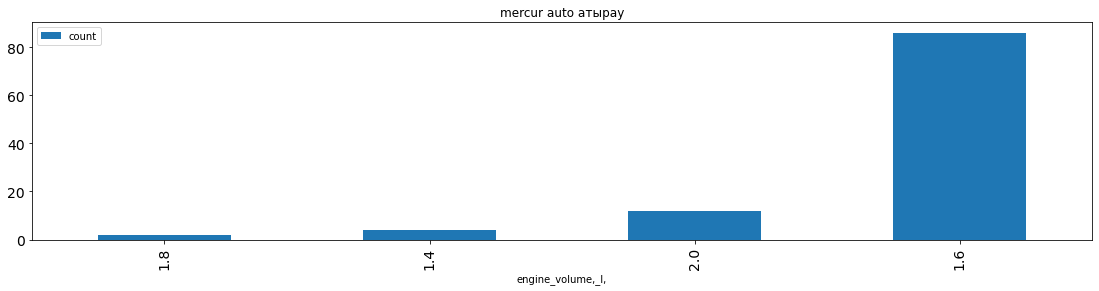

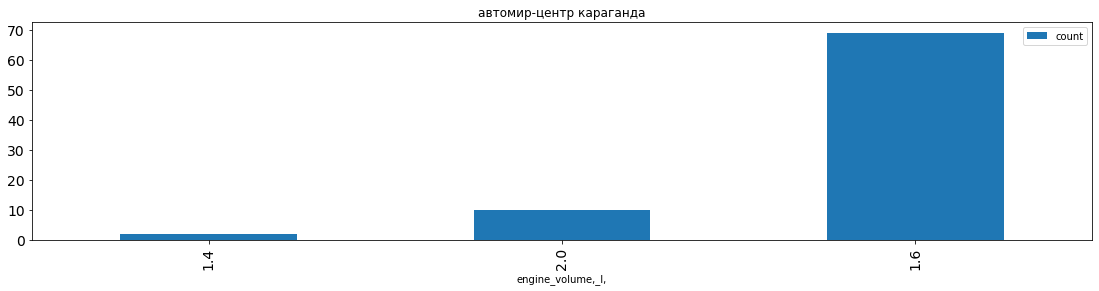

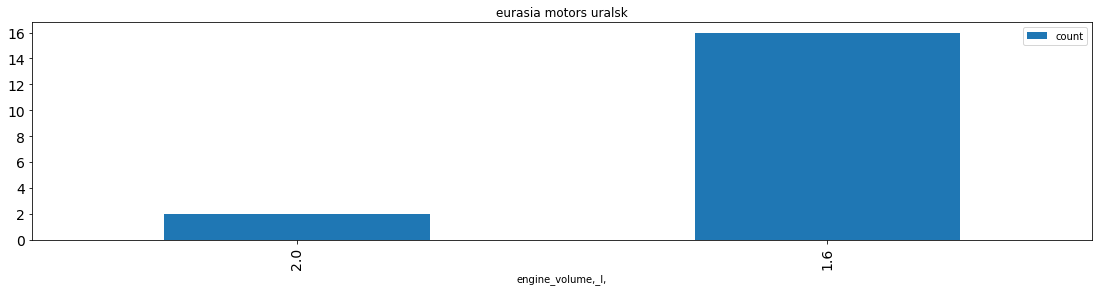

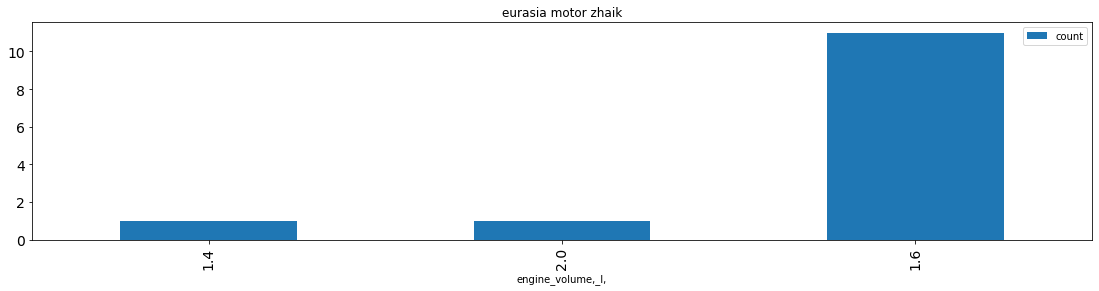

In [297]:
for i in df['dealership_name'].unique():
    if df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['0'].count() > 0:
        df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)].groupby(['engine_volume,_l,'])['0'].agg(['count']).reset_index().sort_values(by='count').plot(
                    x='engine_volume,_l,',
                    y="count",
                    kind="bar",
                    rot=90,
                    fontsize=14,
                    figsize=(19,4),
                    title=i
                )

In [299]:
df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == 'mercur auto алматы') & (df['engine_volume,_l,'] == 2.0)].groupby('model')['0'].count()

model
a4                     1
a6                    35
multivan               2
q5                    19
tiguan                 7
transporter kasten     1
Name: 0, dtype: int64

Вывод:
- осноной представленный двигатель 1.6
- в г.Алматы, представлен 2.0, основной автомобиль audi a6

#### средняя/медианная/максимальная/минимальная цена авто

In [279]:
df[df['company'] == 'Mercur Auto']['price,_usd'].describe()

count       540.000000
mean      29133.187406
std       21692.524958
min       12755.601542
25%       14982.290783
50%       18327.486024
75%       38969.646090
max      166315.444268
Name: price,_usd, dtype: float64

In [284]:
for i in df['dealership_name'].unique():
    if df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['price,_usd'].count() > 0:
        print(i)
        print(df[(df['company'] == 'Mercur Auto') & (df['dealership_name'] == i)]['price,_usd'].describe())
        print('-' * 10)

mercur auto алматы
count       154.000000
mean      48174.159087
std       29053.844957
min       13300.404666
25%       20842.386338
50%       45558.323073
75%       56315.819942
max      166315.444268
Name: price,_usd, dtype: float64
----------
mercur auto астана
count       89.000000
mean     22919.777727
std      12376.714179
min      12787.165939
25%      14532.109692
50%      17163.226306
75%      32328.082143
max      57589.998201
Name: price,_usd, dtype: float64
----------
автодом костанай
count       81.000000
mean     26590.580629
std      14028.700424
min      13359.725608
25%      15318.739084
50%      19930.226458
75%      37028.007192
max      76158.839484
Name: price,_usd, dtype: float64
----------
mercur auto атырау
count      104.000000
mean     19003.600184
std       7876.049980
min      12814.430685
25%      14260.907722
50%      15634.149983
75%      19718.409119
max      51093.344629
Name: price,_usd, dtype: float64
----------
автомир-центр караганда
count       81

Вывод: средняя цена у компаний схожа, различия есть только в компаниях где представлен ком. автотраспорт.

#### кол-во продаж общий по компании

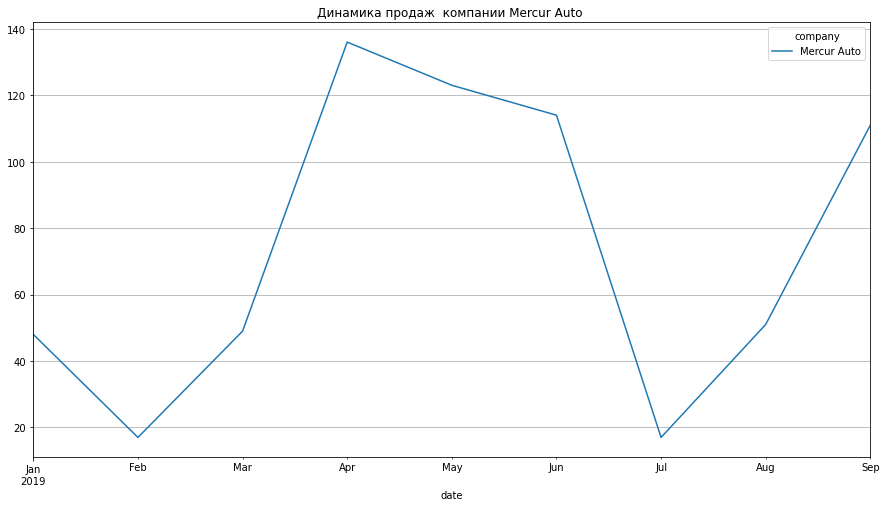

In [276]:
pd.pivot_table(
    df[df['company'] == 'Mercur Auto'], index='company', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж  компании Mercur Auto ')
plt.show()

Вывод: по общему графику видно, что у компании падения происходят в периоды новогодних праздником и период летних отпусков, после которых происходят востановления.

#### кол-во продаж по представительствам

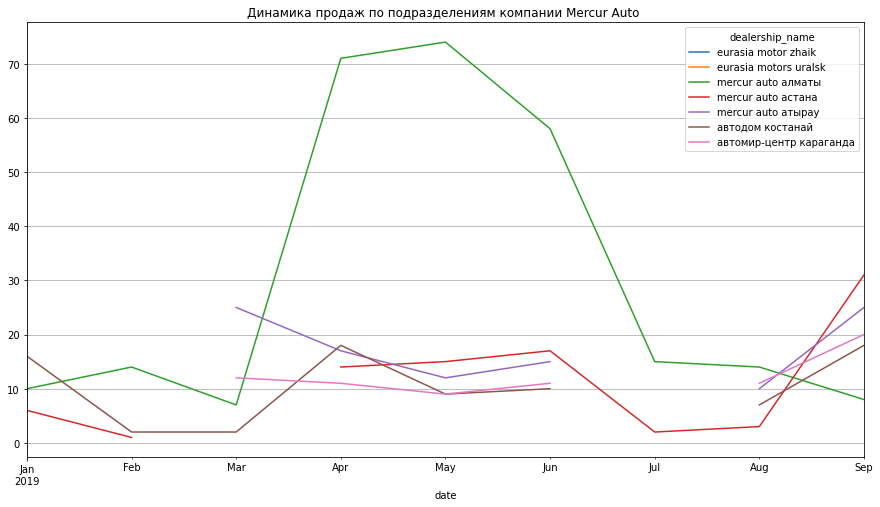

In [269]:
pd.pivot_table(
    df[df['company'] == 'Mercur Auto'], index='dealership_name', columns='date', values='quantity', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='Динамика продаж по подразделениям компании Mercur Auto ')
plt.show()

Вывод:видно что у представительства в Алматы был резкий рост весною, но затем резкое падение. В августе виден рост продаж у всех представительст, кроме г. Алматы

#### кол-во выручки общий по компании

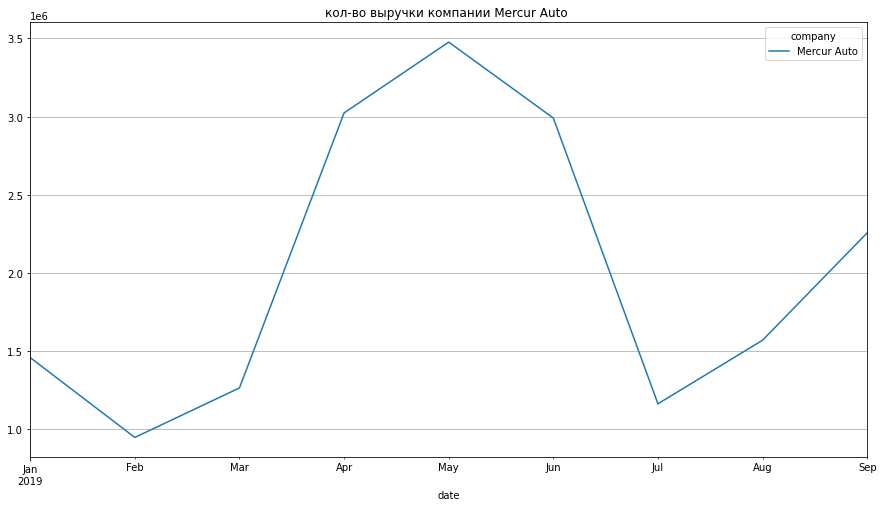

In [277]:
pd.pivot_table(
    df[df['company'] == 'Mercur Auto'], index='company', columns='date', values='sale,_usd', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='кол-во выручки компании Mercur Auto ')
plt.show()

Вывод: видно из графика, что выручка компании коллерирует с продажами

#### кол-во выручки по представительствам

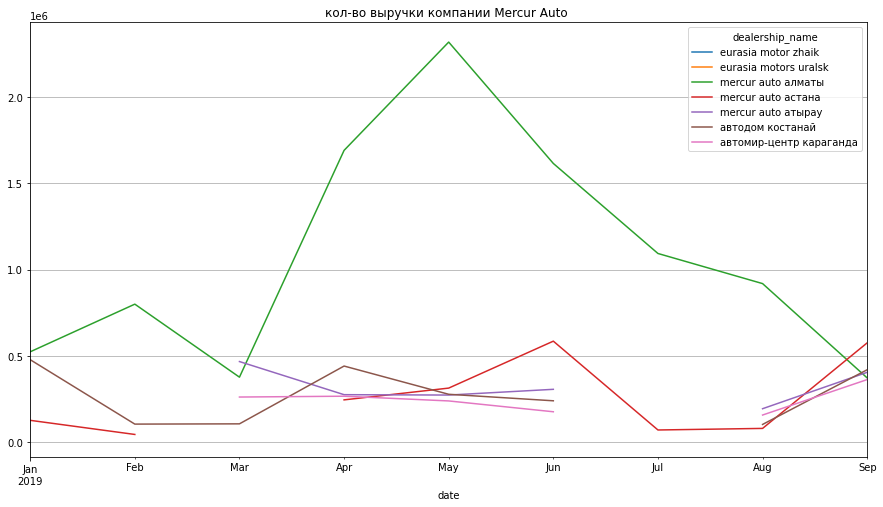

In [278]:
pd.pivot_table(
    df[df['company'] == 'Mercur Auto'], index='dealership_name', columns='date', values='sale,_usd', aggfunc='sum'
    ).T.plot(figsize=(15, 8), grid=True, title='кол-во выручки компании Mercur Auto ')
plt.show()

Вывод: при детальном рассмотрении видно, что сильный скачок выручки виден только у компании в Алматы.

#### доля рынка дилера(количественный/стоимостном выражении)

In [306]:
print(f"в количественном выражении: {round(len(df[df['company'] == 'Mercur Auto']['dealership_name'].unique())/len(df['dealership_name'].unique()), 2)}")
print(f"в стоимостном выражении: {round(df[df['company'] == 'Mercur Auto']['sale,_usd'].sum()/df['sale,_usd'].sum(), 2)}")

в количественном выражении: 0.04
в стоимостном выражении: 0.02


#### доля рынка дилера по маркам

In [314]:
for i in df['brand'].unique():
    if len(df[(df['company'] == 'Mercur Auto')&(df['brand'] == i)]['dealership_name'].unique()) > 0:
        print(i)
        print(f"в количественном выражении: {df[(df['company'] == 'Mercur Auto')&(df['brand'] == i)]['0'].count()/df[df['brand'] == i]['0'].count()}")
        print(f"в стоимостном выражении: {df[(df['company'] == 'Mercur Auto')&(df['brand'] == i)]['sale,_usd'].sum()/df[df['brand'] == i]['sale,_usd'].sum()}")
        print('-' * 10)

audi
в количественном выражении: 1.0
в стоимостном выражении: 1.0
----------
porsche
в количественном выражении: 1.0
в стоимостном выражении: 1.0
----------
volkswagen
в количественном выражении: 1.0
в стоимостном выражении: 1.0
----------


In [313]:
df[df['brand'] == 'audi']['dealership_name'].unique()

array(['mercur auto алматы', 'mercur auto астана', 'автодом костанай',
       'mercur auto атырау'], dtype=object)

In [316]:
df[(df['company'] == 'Mercur Auto')&(df['brand'] == 'audi')]['dealership_name'].unique()

array(['mercur auto алматы', 'mercur auto астана', 'автодом костанай',
       'mercur auto атырау'], dtype=object)

Вывод: из данных видно что данная компания является единственным монополистом на рынке Казахстана данных моделей авто

#### доля рынка дилера по типу авто

In [319]:
for i in df['segmentation_2013'].unique():
    if len(df[(df['company'] == 'Mercur Auto')&(df['segmentation_2013'] == i)]['dealership_name'].unique()) > 0:
        print(i)
        print(f"в количественном выражении: {round(df[(df['company'] == 'Mercur Auto')&(df['segmentation_2013'] == i)]['0'].count()/df[df['segmentation_2013'] == i]['0'].count(), 2)}")
        print(f"в стоимостном выражении: {round(df[(df['company'] == 'Mercur Auto')&(df['segmentation_2013'] == i)]['sale,_usd'].sum()/df[df['segmentation_2013'] == i]['sale,_usd'].sum(), 2)}")
        print('-' * 10)

Легковые автомобили 
в количественном выражении: 0.03
в стоимостном выражении: 0.03
----------
Внедорожники 
в количественном выражении: 0.01
в стоимостном выражении: 0.01
----------
Коммерческие автомобили 
в количественном выражении: 0.0
в стоимостном выражении: 0.0
----------
Минивэны
в количественном выражении: 0.05
в стоимостном выражении: 0.13
----------
Пикапы 
в количественном выражении: 0.01
в стоимостном выражении: 0.01
----------


Вывод:
- компания занимает всего 3% рынка в сегменте легковых автомобилей
- компания занимает 5% рынка в сегменте минивены и 13% в денежном эквиваленте

Общий вывод по разделу:
- из данных видно, что компания имеет 7 представительств в разных городах.
- основной сегмент автомобилей компании это Легковые автомобили. Так же в компании представлены внедорожники. В. некоторых представительствах есть комерч. автотранспорт, пикапы и минивены.
- во всех представительствах основной класс авто: b класс, кромя представительствав Алмате.
- в Алмате еще равно допредставлены: b класс, e класс, стандартные suv.
- основной бренд компании VW
- основная трансмиссия автоматическая или ее другие вариации (тк в некоторых марках автомабилей ставятся другие вариации автоматической трансмиссии)
- в основном представлен передний привод
- в г.Алмате доминирует полноприводные автомобили
- осноной представленный двигатель 1.6
- в г.Алматы, представлен 2.0, основной автомобиль audi a6
- средняя цена у компаний схожа, различия есть только в компаниях где представлен ком. автотраспорт.
- по общему графику видно, что у компании падения происходят в периоды новогодних праздником и период летних отпусков, после которых происходят востановления.
- видно что у представительства в Алматы был резкий рост весною, но затем резкое падение. В августе виден рост продаж у всех представительст, кроме г. Алматы
- видно из графика, что выручка компании коллерирует с продажами
- при детальном рассмотрении видно, что сильный скачок выручки виден только у компании в Алматы.
- доля рынка дилера
    - в количественном выражении: 0.04
    - в стоимостном выражении: 0.02
- доля рынка дилера по маркам: из данных видно что данная компания является единственным монополистом на рынке Казахстана данных моделей авто (audi, porsche, volkswagen)
- доля рынка дилера по типу авто:
    * компания занимает всего 3% рынка в сегменте легковых автомобилей
    * компания занимает 5% рынка в сегменте минивены и 13% в денежном эквиваленте

### Конкуренты Mercur Auto
- лидеры рынка
- ближайшие конкуренты(регион, марка, класс)

#### лидеры рынка

<AxesSubplot:title={'center':'кол-во продаж по компаниям'}, xlabel='company'>

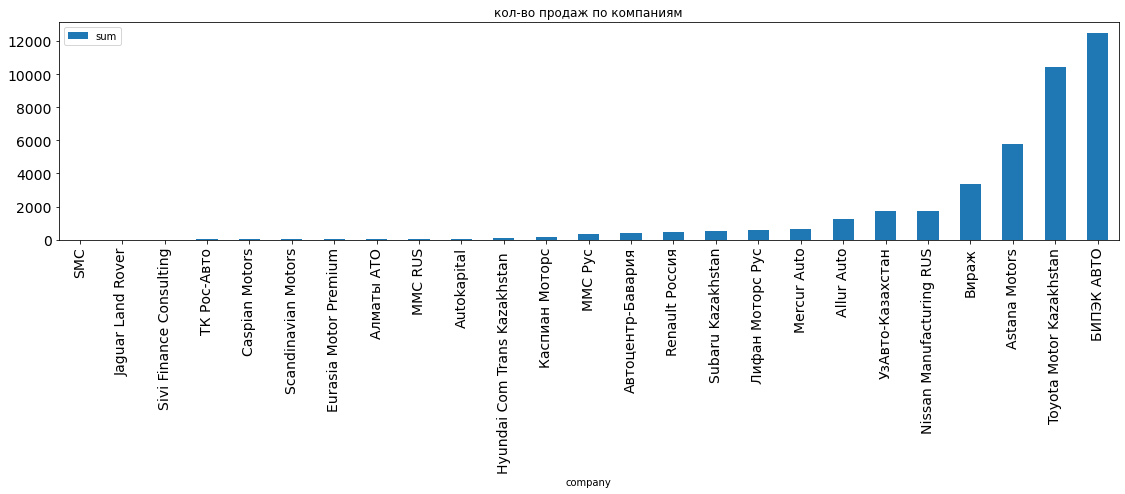

In [320]:
df.groupby(['company'])['quantity'].agg(['sum']).reset_index().sort_values(by='sum').plot(
        x='company',
        y="sum",
        kind="bar",
        rot=90,
        fontsize=14,
        figsize=(19,4),
        title='кол-во продаж по компаниям'
)

Вывод: из данных видно, что основные лидеры рынка: БИПЭК АВТО, Toyota Motor и Astana Motor. Mercur Auto, отстает сильно от лидеров рынка по кол-ву продаж

#### ближайшие конкуренты по региону

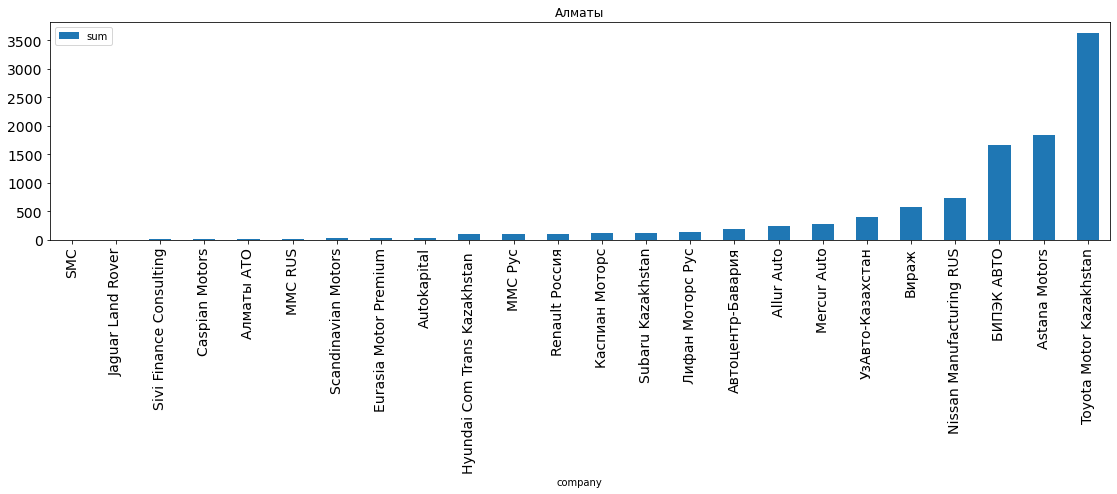

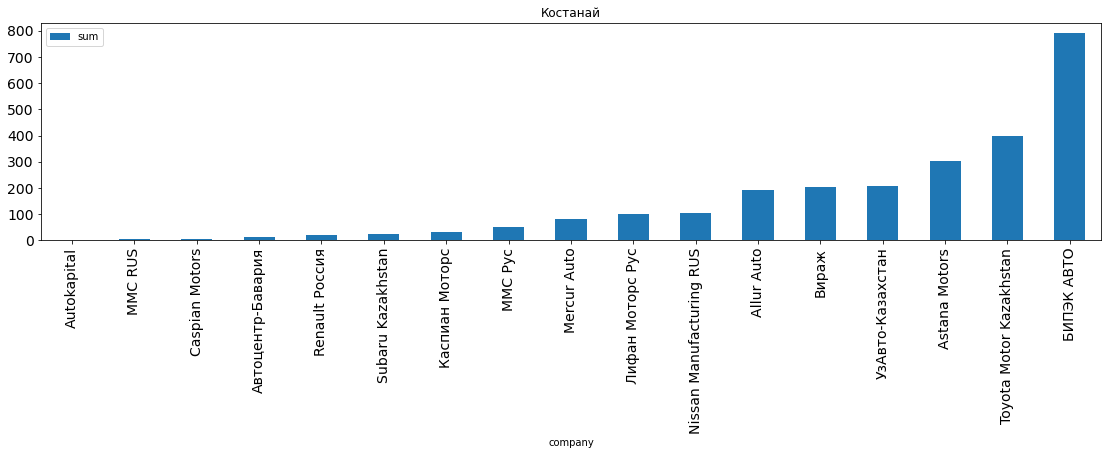

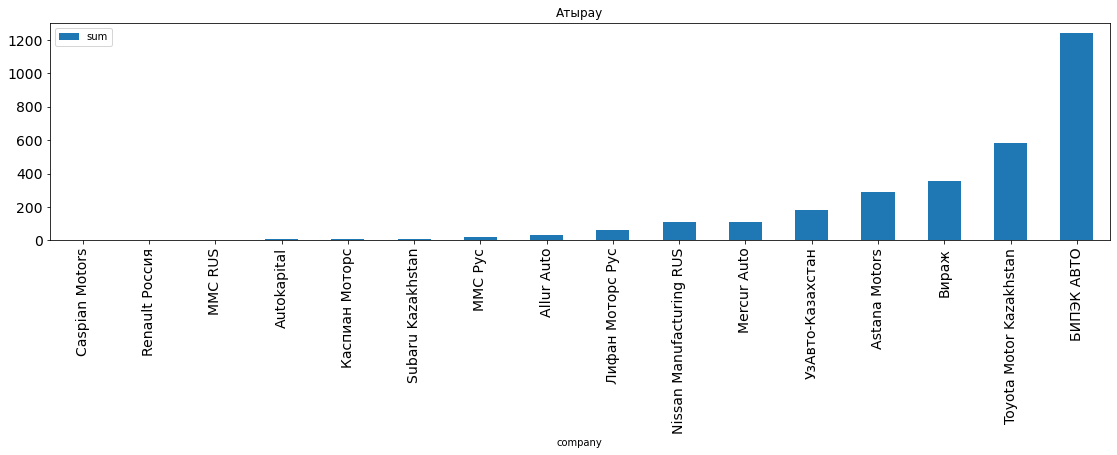

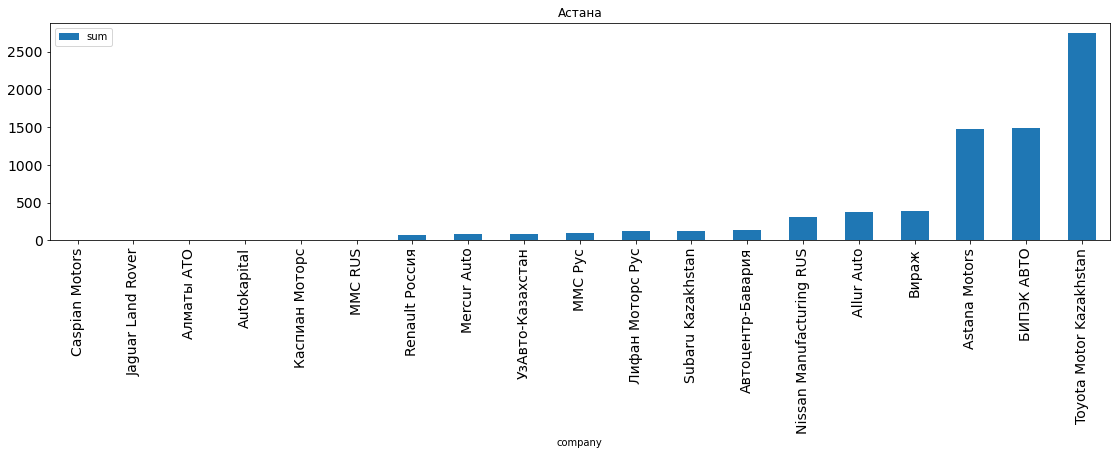

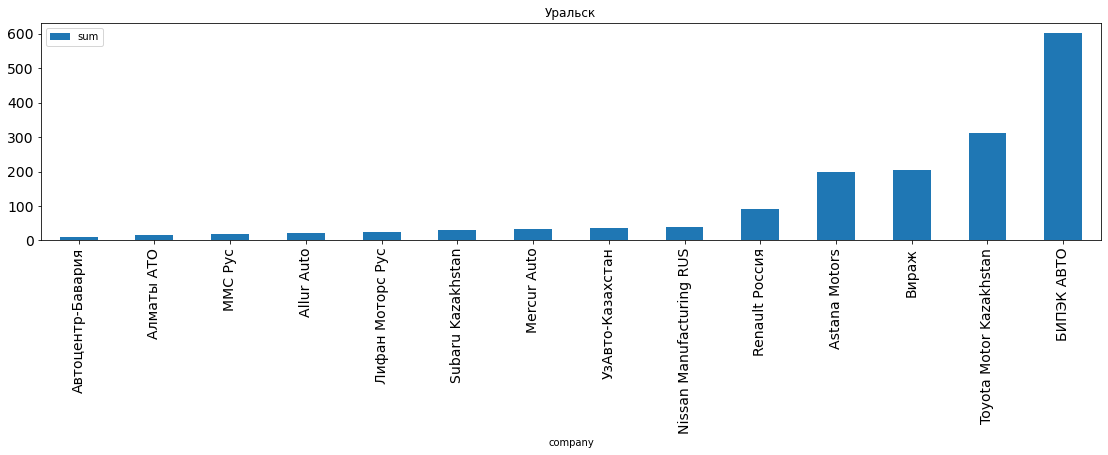

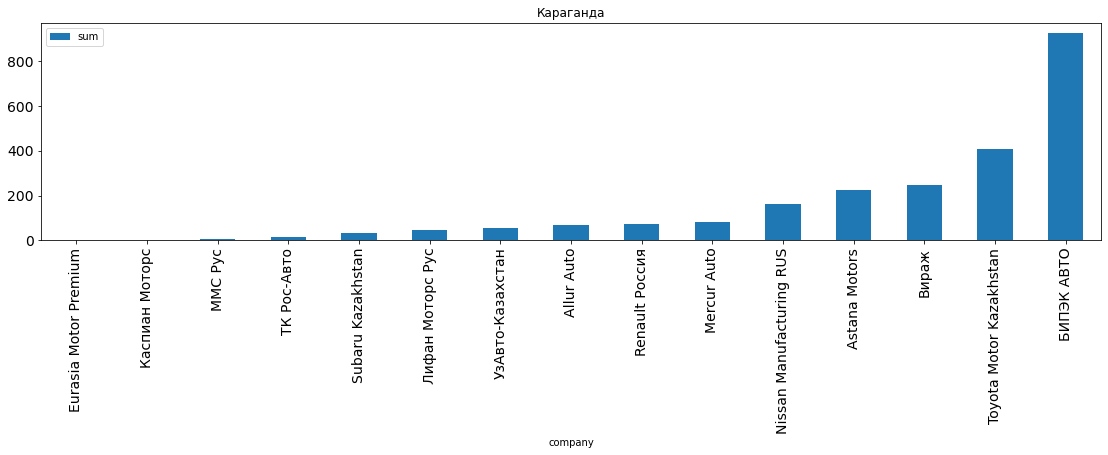

In [325]:
for i in df['region'].unique():
    if len(df[(df['company'] == 'Mercur Auto')&(df['region'] == i)]) > 0:
        df[(df['region'] == i)].groupby(['company'])['quantity'].agg(['sum']).reset_index().sort_values(by='sum').plot(
            x='company',
            y="sum",
            kind="bar",
            rot=90,
            fontsize=14,
            figsize=(19,4),
            title= i
        )

Вывод: по регионам видно что лидеры остаются теже, меняются среди них лишь только лидирующие места. Mercur Auto занимает везде места в районе середины.

#### ближайшие конкуренты по марке

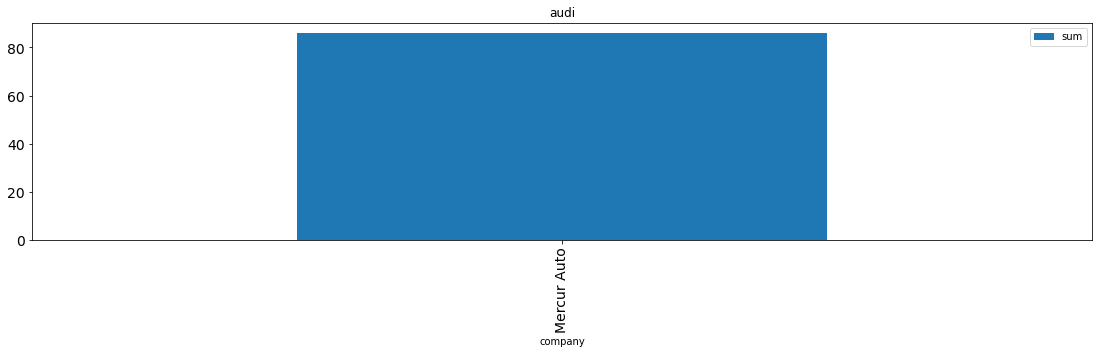

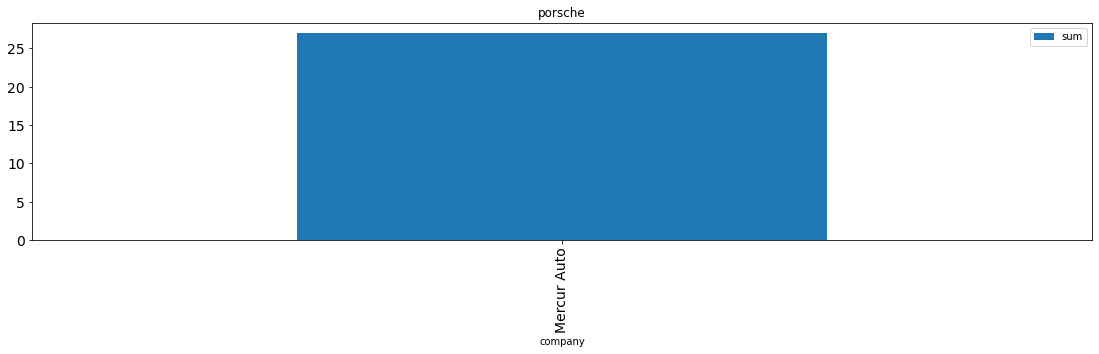

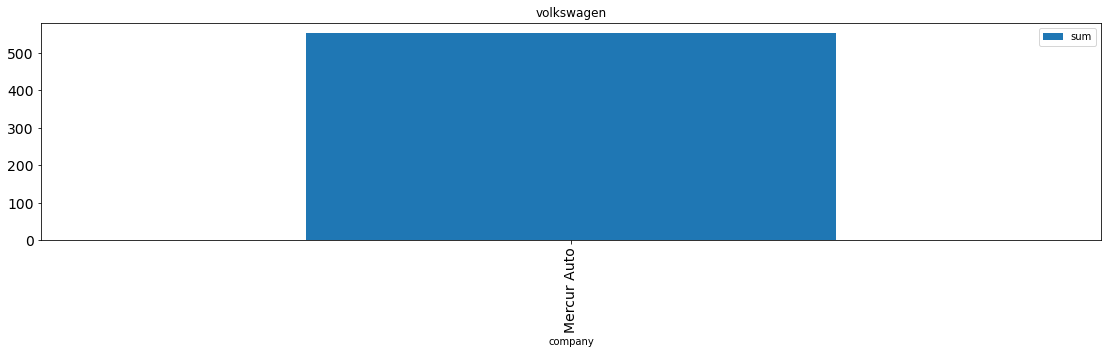

In [327]:
for i in df['brand'].unique():
    if len(df[(df['company'] == 'Mercur Auto')&(df['brand'] == i)]) > 0:
        df[(df['brand'] == i)].groupby(['company'])['quantity'].agg(['sum']).reset_index().sort_values(by='sum').plot(
            x='company',
            y="sum",
            kind="bar",
            rot=90,
            fontsize=14,
            figsize=(19,4),
            title= i
        )

Вывод: по марке компания единственный представить

#### ближайшие конкуренты по классу

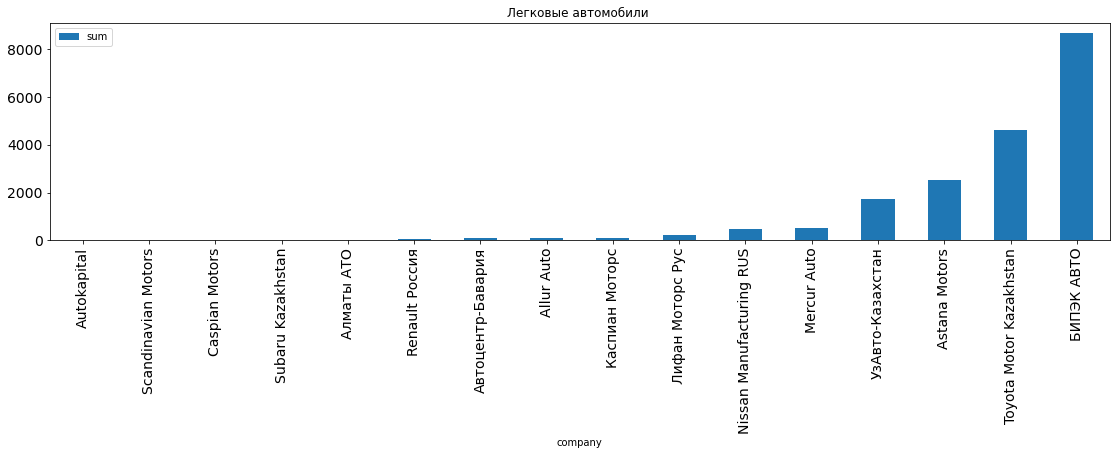

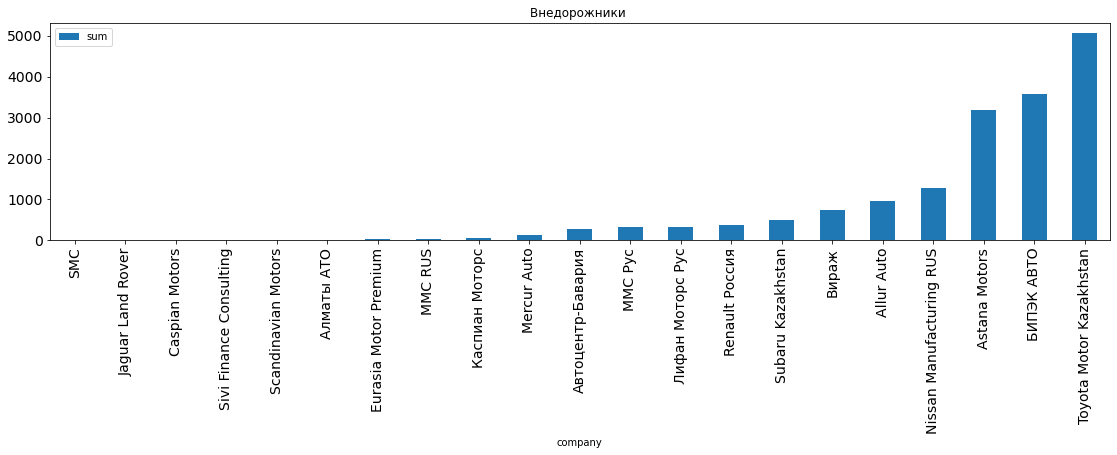

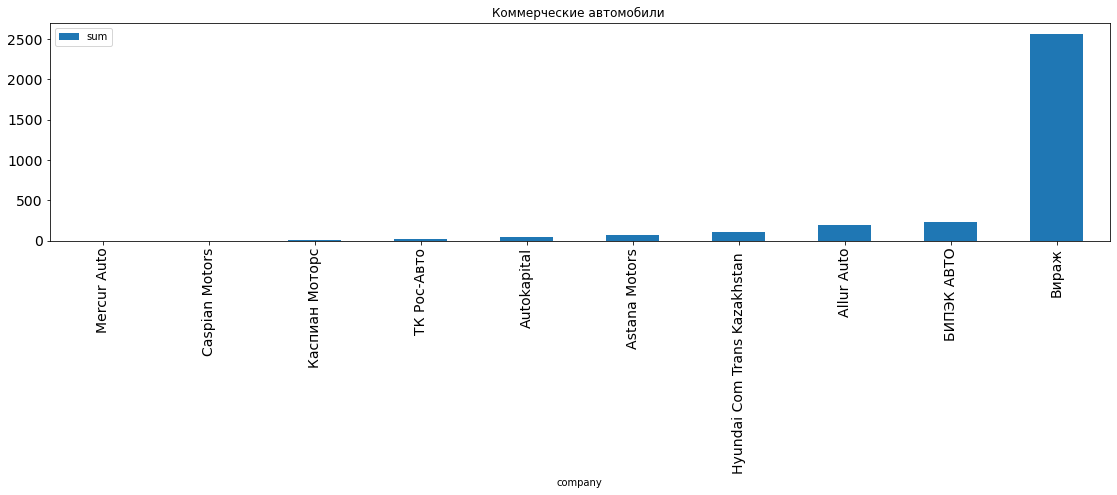

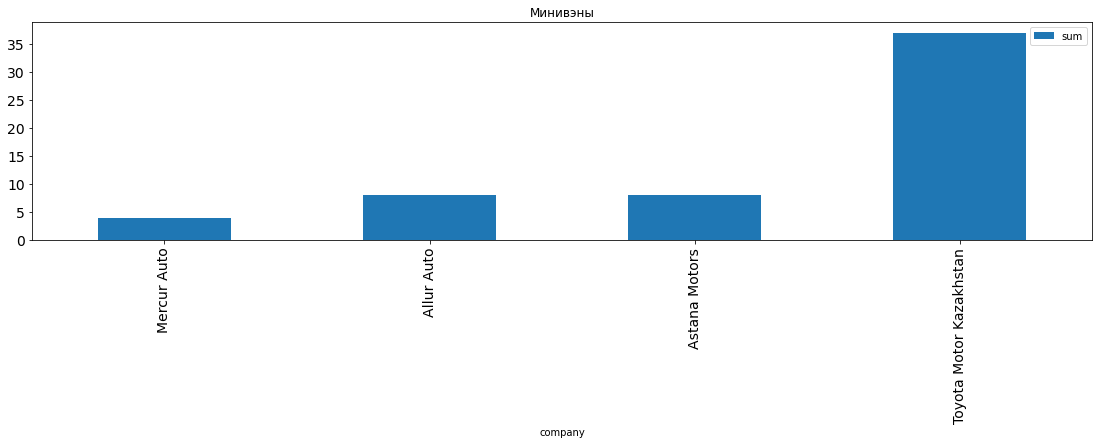

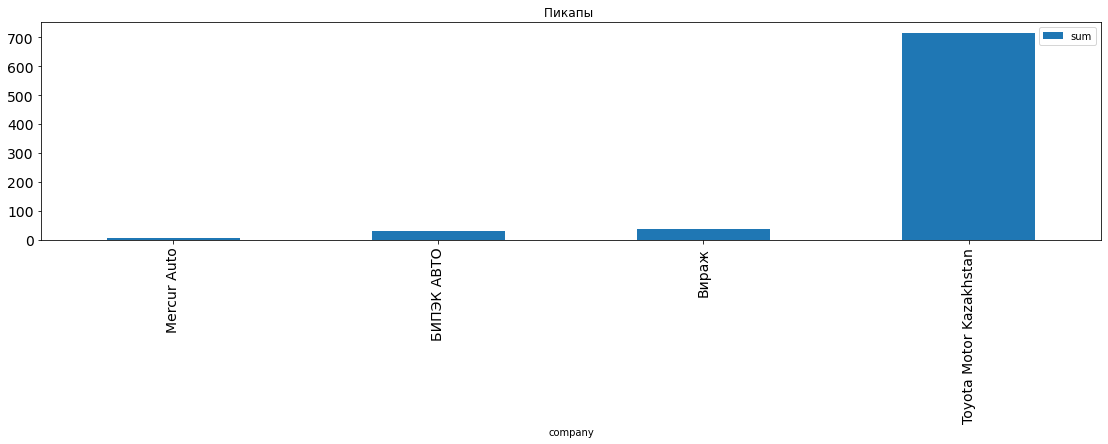

In [328]:
for i in df['segmentation_2013'].unique():
    if len(df[(df['company'] == 'Mercur Auto')&(df['segmentation_2013'] == i)]) > 0:
        df[(df['segmentation_2013'] == i)].groupby(['company'])['quantity'].agg(['sum']).reset_index().sort_values(by='sum').plot(
            x='company',
            y="sum",
            kind="bar",
            rot=90,
            fontsize=14,
            figsize=(19,4),
            title= i
        )

Вывод:
- в сегменте легковых и внедорожников у компании больше всего конкурентов
- в сегменте коммерческого автотранспорта компания занимает последнее место
- в сегментах с малым количеством конкурентов компания на последних местах
- практически во всех сегментах лидер Toyota motors, кроме: коммерческого - вираж и легковых - Бипек авто

Общий вывод по разделу:
- из данных видно, что основные лидеры рынка: БИПЭК АВТО, Toyota Motor и Astana Motor. Mercur Auto, отстает сильно от лидеров рынка по кол-ву продаж
- по марке компания единственный представить
* в сегменте легковых и внедорожников у компании больше всего конкурентов
* в сегменте коммерческого автотранспорта компания занимает последнее место
* в сегментах с малым количеством конкурентов компания на последних местах
* практически во всех сегментах лидер Toyota motors, кроме: коммерческого - вираж и легковых - Бипек авто

### Общий вывод и рекомендации
Общий вывод по компаниям:¶
* лидерами по продажам являюттся: БИПЭК АВТО , Toyota Motor Kazakhstan , Astana Motors 
* аутсайдерами по продажам являются: SMC, jaguar Land Rover
* лидерами по выручке являюттся: БИПЭК АВТО , Toyota Motor Kazakhstan , Astana Motors 
* аутсайдерами по выручке являются: SMC, jaguar Land Rover
* самый представленный сегмент в компаниях лидерах: внедорожники
* самая популярная трансмиссия: автомат
* самый популярный привлд: различные вариации полноприводных автомобилей


Общий вывод по разделу анализ Брендов:
* самые популярные бренды: hyundai, toyota и lada
* самые не популярные landrover, suzuki, mersedes-benz
* самые дорогие машины брендов: porsche, cadillac
* самые дешевые машины брендов: lada, ravon
* как видно больше всего представлена в регионах toyota
* можно заметить что lada, gaz представлены в районах с уровнем дохода ниже среднего
* как видно что механика в основном представлена в российском автопроме и китайском.
* Остальные типы приводов разделены по производителям
* чисто автоматическая является самой популярной из устанавливаемой отсюда и лидерство, но стоит учитывать все вариации автоматических вместе
* toyota в основном предсталены в полном и переднеприводном сегменте
* uaz, gaz с подключаемомы
* hyndai в моноприводе
* самые популярные объемы двигателей у лидеров бренды: hyundai (1.6 и 2.0), toyota (2.5) и lada (1.6)
* самые популярные объемы двигателей у антилидеров landrover (2.0), suzuki (1.3, 1.4), mersedes-benz (2.0)
* можно сделать вывод что самые популярные объемы: 1.6 и 2.0



Общий вывод по разделу (Проверка стат гипотез):
* внедорожники продаются чаще, в отличии от видов автомобилей
* автомобили с автоматической трансмиссией продаются чаще, в отличии от автомобилей с другими видами коробки
* автомобили полноприводные продаются чаще, в отличии от автомобилей с другими видами привода


Общие выводы по разделу (корр. цены):
* из полученных данных видно что очень небольшая зависимость видна в автомобилях дороже 50тыс., так зависимость цены на сумму сделки не видна
* зависимость цены от уровня заработной платы в регионе не обнаружена
* зависимость суммы сделки от уровня заработной платы в регионе не обнаружена


Общий вывод по разделу (Динамика продаж по рынку):
* в общем по рынку виден рост продаж начиная с января. Замедление и снижение продаж в июле скорее всего связано с периодом отпусков.
* как видно из полученных данных у 3-х компаний идет рост продаж к концу года (БИПЭК авто, Toyota Motor, SMC). У остальных компаний или в стагнации или снижение.
* видно, что рост продаж только у 3-х брендов toyota, lada, hyndai.
* видно, что у toyota:
    * снижение продаж: camry
    * рост продаж у prado
        * у lada:
* снижение продаж у granta
    * рост продаж у 4х4
* у hyndai:
    * снижение продаж у accent
    * рост продаж у creta, elantra
* ведущие по продажам коробки: автомат и механика
* рост продаж у автомата
* небольшое снижение продаж у механики
* лидеры по продажам: полноприводные и перед. приводные
* небольшое снижение продаж у перед. приводных
* рост продаж у полноприводных
* из полученных данных видно, что у авто с 1.6л начался сильный рост продаж к концу года. Так же ростут продажи автомобилей с 2.0л


Общий вывод по разделу (Анализ компании Mercur Auto):
* из данных видно, что компания имеет 7 представительств в разных городах.
* основной сегмент автомобилей компании это Легковые автомобили. Так же в компании представлены внедорожники. В. некоторых представительствах есть комерч. автотранспорт, пикапы и минивены.
* во всех представительствах основной класс авто: b класс, кромя представительствав Алмате.
* в Алмате еще равно допредставлены: b класс, e класс, стандартные suv.
* основной бренд компании VW
* основная трансмиссия автоматическая или ее другие вариации (тк в некоторых марках автомабилей ставятся другие вариации автоматической трансмиссии)
* в основном представлен передний привод
* в г.Алмате доминирует полноприводные автомобили
* осноной представленный двигатель 1.6
* в г.Алматы, представлен 2.0, основной автомобиль audi a6
* средняя цена у компаний схожа, различия есть только в компаниях где представлен ком. автотраспорт.
* по общему графику видно, что у компании падения происходят в периоды новогодних праздником и период летних отпусков, после которых происходят востановления.
* видно что у представительства в Алматы был резкий рост весною, но затем резкое падение. В августе виден рост продаж у всех представительст, кроме г. Алматы
* видно из графика, что выручка компании коллерирует с продажами
* при детальном рассмотрении видно, что сильный скачок выручки виден только у компании в Алматы.
* доля рынка дилера
    * в количественном выражении: 0.04
    * в стоимостном выражении: 0.02
* доля рынка дилера по маркам: из данных видно что данная компания является единственным монополистом на рынке Казахстана данных моделей авто (audi, porsche, volkswagen)
* доля рынка дилера по типу авто:
    * компания занимает всего 3% рынка в сегменте легковых автомобилей
    * компания занимает 5% рынка в сегменте минивены и 13% в денежном эквиваленте



Общий вывод по разделу (Конкуренты Mercur Auto):
* из данных видно, что основные лидеры рынка: БИПЭК АВТО, Toyota Motor и Astana Motor. Mercur Auto, отстает сильно от лидеров рынка по кол-ву продаж
* по марке компания единственный представить
* в сегменте легковых и внедорожников у компании больше всего конкурентов
* в сегменте коммерческого автотранспорта компания занимает последнее место
* в сегментах с малым количеством конкурентов компания на последних местах
* практически во всех сегментах лидер Toyota motors, кроме: коммерческого - вираж и легковых - Бипек авто

#### Рекомендации

- компании стоит обратить внимание на конкурентов:
    - на рынке лидируют по продажам внедорожники, в компании они недопредставлены
    - возможно стоит обратить внимание на рынок минивенов, там меньше конкуренция
    - стоит обратить на факт у главного конкурента компании toyota, видно, что     * снижение продаж: camry и рост продаж у prado, данный факт может говорить о том что рынок все больше интересуют внедорожники и меньше сиданы
    - если компанию планирует заниматся только атомобилями vag group, то стоит поискать модели для сегмента - Внедорожники. На данный момент в компании большая часть полноприводных автомобилей это полноприводные audi a6.